In [1]:
#méthode de gradient boosting avec surement du stacking pour le forecasting

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import pandas_bokeh
pandas_bokeh.output_notebook()
pd.set_option("plotting.backend", "pandas_bokeh")

Loading BokehJS ...

In [3]:
uber = pd.read_csv('../uber_data.csv', parse_dates = True)

In [4]:
uber_man = uber[uber['borough'] == 'Manhattan']

In [5]:
uber_man = uber_man.drop('borough', axis=1)

uber_man['pickup_dt'] = uber_man['pickup_dt'].astype(str) 

uber_man = uber_man.set_index('pickup_dt')

uber_man = pd.get_dummies(uber_man)

In [6]:
uber_man.tail()

pickups  spd   vsb  temp  dewp     slp  pcp01  pcp06  \
pickup_dt                                                                   
2015-06-30 19:00:00     4585  5.0  10.0  80.0  58.0  1012.5    0.0    0.0   
2015-06-30 20:00:00     4210  8.0  10.0  80.0  58.0  1012.4    0.0    0.0   
2015-06-30 21:00:00     4313  7.0  10.0  76.0  61.0  1012.4    0.0    0.0   
2015-06-30 22:00:00     4452  5.0  10.0  76.0  64.0  1011.9    0.0    0.0   
2015-06-30 23:00:00     3828  7.0  10.0  75.0  65.0  1011.8    0.0    0.0   

                     pcp24   sd  hday_N  hday_Y  
pickup_dt                                        
2015-06-30 19:00:00    0.0  0.0       1       0  
2015-06-30 20:00:00    0.0  0.0       1       0  
2015-06-30 21:00:00    0.0  0.0       1       0  
2015-06-30 22:00:00    0.0  0.0       1       0  
2015-06-30 23:00:00    0.0  0.0       1       0

Ajout d'une lag feature sur la serie
il s'agit d'horizon en heure donc on peut faire des lags sur les heures précédentes jusqu'à -4h par exemple
ensuite sur le jour précédent à la même heure
la semaine précédente
et enfin le mois

In [7]:
#lag features
for i in [1,2,3,4,24,7*24]:
    uber_man[f'lag_{i}'] = uber_man.pickups.shift(i)

In [8]:
def smape_perso(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [9]:
import lightgbm as lgb

In [10]:
uber_man.head()

pickups  spd   vsb  temp  dewp     slp  pcp01  pcp06  \
pickup_dt                                                                   
2015-01-01 01:00:00     5258  5.0  10.0  30.0   7.0  1023.5    0.0    0.0   
2015-01-01 02:00:00     4345  3.0  10.0  30.0   6.0  1023.0    0.0    0.0   
2015-01-01 03:00:00     4577  5.0  10.0  30.0   8.0  1022.3    0.0    0.0   
2015-01-01 04:00:00     3003  5.0  10.0  29.0   9.0  1022.0    0.0    0.0   
2015-01-01 05:00:00     1313  5.0  10.0  28.0   9.0  1021.8    0.0    0.0   

                     pcp24   sd  hday_N  hday_Y   lag_1   lag_2   lag_3  \
pickup_dt                                                                 
2015-01-01 01:00:00    0.0  0.0       0       1     NaN     NaN     NaN   
2015-01-01 02:00:00    0.0  0.0       0       1  5258.0     NaN     NaN   
2015-01-01 03:00:00    0.0  0.0       0       1  4345.0  5258.0     NaN   
2015-01-01 04:00:00    0.0  0.0       0       1  4577.0  4345.0  5258.0   
2015-01-01 05:00:00    0.0  0.0       0       1  3003.0  4577.0  4345.0   

                      lag_4  lag_24  lag_168  
pickup_dt                                     
2015-01-01 01:00:00     NaN     NaN      NaN  
2015-01-01 02:00:00     NaN     NaN      NaN  
2015-01-01 03:00:00     NaN     NaN      NaN  
2015-01-01 04:00:00     NaN     NaN      NaN  
2015-01-01 05:00:00  5258.0     NaN      NaN

In [11]:
from sklearn.model_selection import TimeSeriesSplit
from sktime.forecasting.model_selection import temporal_train_test_split

#uber_mancv = uber_man.reset_index(drop=True)

X = uber_man.drop('pickups', axis=1)
y = uber_man['pickups']




tscv = TimeSeriesSplit(n_splits = 3)

    
    
    
train, test = temporal_train_test_split(uber_man, test_size = 720)

X_train = train.drop('pickups', axis=1)
y_train = train['pickups']
X_test = test.drop('pickups',axis=1)
y_test = test['pickups']

In [12]:
len(X_test)

720

In [13]:
from sklearn.model_selection import RandomizedSearchCV

rs_params = {
    'learning_rate': [0.01,0.03,0.01],
    'max_depth': [2,4,6,8,10,12],
    'num_leaves': [10,20,40,60,100,200],
    'metric': ['mape'],
    'num_iterations': [500],
    'objective':['poisson','tweedie','mape','regression']
}

rs_cv = RandomizedSearchCV(estimator=lgb.LGBMRegressor(), param_distributions=rs_params,
                           cv = tscv, n_iter=100,verbose=1)




In [14]:
#alors la le set de validation n'est pas bon il ne devrait pas etre fait avec le X_test et y_test
rs_cv.fit(X_train, y_train,verbose=1, early_stopping_rounds= 100,eval_set = (X_test, y_test))

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[1]	valid_0's mape: 0.709285
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.698749
[3]	valid_0's mape: 0.688346
[4]	valid_0's mape: 0.678099
[5]	valid_0's mape: 0.667988
[6]	valid_0's mape: 0.658616
[7]	valid_0's mape: 0.648838
[8]	valid_0's mape: 0.63916
[9]	valid_0's mape: 0.630157
[10]	valid_0's mape: 0.620823
[11]	valid_0's mape: 0.611896
[12]	valid_0's mape: 0.602868
[13]	valid_0's mape: 0.594069
[14]	valid_0's mape: 0.585366
[15]	valid_0's mape: 0.576847
[16]	valid_0's mape: 0.568431
[17]	valid_0's mape: 0.560219
[18]	valid_0's mape: 0.552272
[19]	valid_0's mape: 0.544503
[20]	valid_0's mape: 0.536884


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[21]	valid_0's mape: 0.529387
[22]	valid_0's mape: 0.521706
[23]	valid_0's mape: 0.514224
[24]	valid_0's mape: 0.506936
[25]	valid_0's mape: 0.500123
[26]	valid_0's mape: 0.493077
[27]	valid_0's mape: 0.486628
[28]	valid_0's mape: 0.47984
[29]	valid_0's mape: 0.473199
[30]	valid_0's mape: 0.466785
[31]	valid_0's mape: 0.46046
[32]	valid_0's mape: 0.454012
[33]	valid_0's mape: 0.44769
[34]	valid_0's mape: 0.441441
[35]	valid_0's mape: 0.435524
[36]	valid_0's mape: 0.429614
[37]	valid_0's mape: 0.423574
[38]	valid_0's mape: 0.418154
[39]	valid_0's mape: 0.412575
[40]	valid_0's mape: 0.407089
[41]	valid_0's mape: 0.401676
[42]	valid_0's mape: 0.396428
[43]	valid_0's mape: 0.391128
[44]	valid_0's mape: 0.385699
[45]	valid_0's mape: 0.38057
[46]	valid_0's mape: 0.375481
[47]	valid_0's mape: 0.370489
[48]	valid_0's mape: 0.36559
[49]	valid_0's mape: 0.360744
[50]	valid_0's mape: 0.355987
[51]	valid_0's mape: 0.351161
[52]	valid_0's mape: 0.346548
[53]	valid_0's mape: 0.342051
[54]	valid_0's 

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[16]	valid_0's mape: 0.594423
[17]	valid_0's mape: 0.586061
[18]	valid_0's mape: 0.577925
[19]	valid_0's mape: 0.569575
[20]	valid_0's mape: 0.561548
[21]	valid_0's mape: 0.553631
[22]	valid_0's mape: 0.545971
[23]	valid_0's mape: 0.538049
[24]	valid_0's mape: 0.530389
[25]	valid_0's mape: 0.522924
[26]	valid_0's mape: 0.515483
[27]	valid_0's mape: 0.508142
[28]	valid_0's mape: 0.500903
[29]	valid_0's mape: 0.493711
[30]	valid_0's mape: 0.486732
[31]	valid_0's mape: 0.479696
[32]	valid_0's mape: 0.472888
[33]	valid_0's mape: 0.46611
[34]	valid_0's mape: 0.459523
[35]	valid_0's mape: 0.453129
[36]	valid_0's mape: 0.446841
[37]	valid_0's mape: 0.440704
[38]	valid_0's mape: 0.434655
[39]	valid_0's mape: 0.428663
[40]	valid_0's mape: 0.422779
[41]	valid_0's mape: 0.41706
[42]	valid_0's mape: 0.411321
[43]	valid_0's mape: 0.405694
[44]	valid_0's mape: 0.40014
[45]	valid_0's mape: 0.394667
[46]	valid_0's mape: 0.389284
[47]	valid_0's mape: 0.384027
[48]	valid_0's mape: 0.378844
[49]	valid_0'

[290]	valid_0's mape: 0.107674
[291]	valid_0's mape: 0.107672
[292]	valid_0's mape: 0.107694
[293]	valid_0's mape: 0.107706
[294]	valid_0's mape: 0.107701
[295]	valid_0's mape: 0.107711
[296]	valid_0's mape: 0.107738
[297]	valid_0's mape: 0.107769
[298]	valid_0's mape: 0.107761
[299]	valid_0's mape: 0.107818
[300]	valid_0's mape: 0.10779
[301]	valid_0's mape: 0.107842
[302]	valid_0's mape: 0.107865
[303]	valid_0's mape: 0.107917
[304]	valid_0's mape: 0.107933
[305]	valid_0's mape: 0.107961
[306]	valid_0's mape: 0.107989
[307]	valid_0's mape: 0.10799
[308]	valid_0's mape: 0.107997
[309]	valid_0's mape: 0.108021
[310]	valid_0's mape: 0.108021
[311]	valid_0's mape: 0.108024
[312]	valid_0's mape: 0.108008
[313]	valid_0's mape: 0.108026
[314]	valid_0's mape: 0.10802
[315]	valid_0's mape: 0.108022
[316]	valid_0's mape: 0.108012
[317]	valid_0's mape: 0.107988
[318]	valid_0's mape: 0.107988
[319]	valid_0's mape: 0.107977
[320]	valid_0's mape: 0.107994
[321]	valid_0's mape: 0.108022
[322]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[8]	valid_0's mape: 0.668307
[9]	valid_0's mape: 0.658289
[10]	valid_0's mape: 0.648392
[11]	valid_0's mape: 0.638641
[12]	valid_0's mape: 0.629085
[13]	valid_0's mape: 0.619615
[14]	valid_0's mape: 0.610537
[15]	valid_0's mape: 0.601494
[16]	valid_0's mape: 0.592581
[17]	valid_0's mape: 0.58388
[18]	valid_0's mape: 0.575381
[19]	valid_0's mape: 0.566885
[20]	valid_0's mape: 0.558641
[21]	valid_0's mape: 0.550394
[22]	valid_0's mape: 0.542422
[23]	valid_0's mape: 0.534697
[24]	valid_0's mape: 0.526945
[25]	valid_0's mape: 0.519444
[26]	valid_0's mape: 0.51204
[27]	valid_0's mape: 0.504654
[28]	valid_0's mape: 0.49749
[29]	valid_0's mape: 0.490384
[30]	valid_0's mape: 0.48336
[31]	valid_0's mape: 0.476385
[32]	valid_0's mape: 0.469577
[33]	valid_0's mape: 0.462988
[34]	valid_0's mape: 0.456285
[35]	valid_0's mape: 0.449788
[36]	valid_0's mape: 0.443431
[37]	valid_0's mape: 0.437267
[38]	valid_0's mape: 0.431083
[39]	valid_0's mape: 0.42502
[40]	valid_0's mape: 0.419066
[41]	valid_0's ma

[303]	valid_0's mape: 0.105831
[304]	valid_0's mape: 0.10582
[305]	valid_0's mape: 0.105812
[306]	valid_0's mape: 0.105816
[307]	valid_0's mape: 0.105837
[308]	valid_0's mape: 0.105857
[309]	valid_0's mape: 0.105858
[310]	valid_0's mape: 0.10585
[311]	valid_0's mape: 0.105863
[312]	valid_0's mape: 0.105848
[313]	valid_0's mape: 0.105888
[314]	valid_0's mape: 0.105873
[315]	valid_0's mape: 0.105874
[316]	valid_0's mape: 0.105891
[317]	valid_0's mape: 0.105933
[318]	valid_0's mape: 0.105994
[319]	valid_0's mape: 0.105984
[320]	valid_0's mape: 0.105982
[321]	valid_0's mape: 0.105986
[322]	valid_0's mape: 0.105993
[323]	valid_0's mape: 0.105978
[324]	valid_0's mape: 0.105985
[325]	valid_0's mape: 0.105986
[326]	valid_0's mape: 0.105989
[327]	valid_0's mape: 0.105975
[328]	valid_0's mape: 0.105972
[329]	valid_0's mape: 0.106014
[330]	valid_0's mape: 0.106018
[331]	valid_0's mape: 0.106008
[332]	valid_0's mape: 0.10601
[333]	valid_0's mape: 0.106003
[334]	valid_0's mape: 0.106028
[335]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.990733
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.981558
[3]	valid_0's mape: 0.972475
[4]	valid_0's mape: 0.963482
[5]	valid_0's mape: 0.95458
[6]	valid_0's mape: 0.945767
[7]	valid_0's mape: 0.937042
[8]	valid_0's mape: 0.928404
[9]	valid_0's mape: 0.919852
[10]	valid_0's mape: 0.911386
[11]	valid_0's mape: 0.903005
[12]	valid_0's mape: 0.894707
[13]	valid_0's mape: 0.886493
[14]	valid_0's mape: 0.87836
[15]	valid_0's mape: 0.870309
[16]	valid_0's mape: 0.862339
[17]	valid_0's mape: 0.854448
[18]	valid_0's mape: 0.846636
[19]	valid_0's mape: 0.838902
[20]	valid_0's mape: 0.831245
[21]	valid_0's mape: 0.823665
[22]	valid_0's mape: 0.816161
[23]	valid_0's mape: 0.808732
[24]	valid_0's mape: 0.801377
[25]	valid_0's mape: 0.794096
[26]	valid_0's mape: 0.786888
[27]	valid_0's mape: 0.779751
[28]	valid_0's mape: 0.772686
[29]	valid_0's mape: 0.765692
[30]	valid_0's mape: 0.758767
[31]	valid_0's mape: 0.751912
[32]	valid_0's mape

[277]	valid_0's mape: 0.175081
[278]	valid_0's mape: 0.174846
[279]	valid_0's mape: 0.174623
[280]	valid_0's mape: 0.174432
[281]	valid_0's mape: 0.174213
[282]	valid_0's mape: 0.174002
[283]	valid_0's mape: 0.173796
[284]	valid_0's mape: 0.173592
[285]	valid_0's mape: 0.173401
[286]	valid_0's mape: 0.173208
[287]	valid_0's mape: 0.173014
[288]	valid_0's mape: 0.172816
[289]	valid_0's mape: 0.172624
[290]	valid_0's mape: 0.172454
[291]	valid_0's mape: 0.172301
[292]	valid_0's mape: 0.172137
[293]	valid_0's mape: 0.171988
[294]	valid_0's mape: 0.171836
[295]	valid_0's mape: 0.171682
[296]	valid_0's mape: 0.171508
[297]	valid_0's mape: 0.171355
[298]	valid_0's mape: 0.171205
[299]	valid_0's mape: 0.171036
[300]	valid_0's mape: 0.170887
[301]	valid_0's mape: 0.170743
[302]	valid_0's mape: 0.170619
[303]	valid_0's mape: 0.170416
[304]	valid_0's mape: 0.170239
[305]	valid_0's mape: 0.170045
[306]	valid_0's mape: 0.169904
[307]	valid_0's mape: 0.169764
[308]	valid_0's mape: 0.169589
[309]	va

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[4]	valid_0's mape: 0.962109
[5]	valid_0's mape: 0.952872
[6]	valid_0's mape: 0.943727
[7]	valid_0's mape: 0.934674
[8]	valid_0's mape: 0.925711
[9]	valid_0's mape: 0.916838
[10]	valid_0's mape: 0.908053
[11]	valid_0's mape: 0.899357
[12]	valid_0's mape: 0.890747
[13]	valid_0's mape: 0.882224
[14]	valid_0's mape: 0.873785
[15]	valid_0's mape: 0.865431
[16]	valid_0's mape: 0.857161
[17]	valid_0's mape: 0.848973
[18]	valid_0's mape: 0.840867
[19]	valid_0's mape: 0.832843
[20]	valid_0's mape: 0.824898
[21]	valid_0's mape: 0.817033
[22]	valid_0's mape: 0.809247
[23]	valid_0's mape: 0.801538
[24]	valid_0's mape: 0.793907
[25]	valid_0's mape: 0.786352
[26]	valid_0's mape: 0.778872
[27]	valid_0's mape: 0.771467
[28]	valid_0's mape: 0.764137
[29]	valid_0's mape: 0.756879
[30]	valid_0's mape: 0.749694
[31]	valid_0's mape: 0.742581
[32]	valid_0's mape: 0.73554
[33]	valid_0's mape: 0.728568
[34]	valid_0's mape: 0.721857
[35]	valid_0's mape: 0.715213
[36]	valid_0's mape: 0.708635
[37]	valid_0's ma

[298]	valid_0's mape: 0.151027
[299]	valid_0's mape: 0.150711
[300]	valid_0's mape: 0.150432
[301]	valid_0's mape: 0.150174
[302]	valid_0's mape: 0.149903
[303]	valid_0's mape: 0.149682
[304]	valid_0's mape: 0.149244
[305]	valid_0's mape: 0.148931
[306]	valid_0's mape: 0.148652
[307]	valid_0's mape: 0.148364
[308]	valid_0's mape: 0.148088
[309]	valid_0's mape: 0.147729
[310]	valid_0's mape: 0.147379
[311]	valid_0's mape: 0.147166
[312]	valid_0's mape: 0.146907
[313]	valid_0's mape: 0.146535
[314]	valid_0's mape: 0.146276
[315]	valid_0's mape: 0.146045
[316]	valid_0's mape: 0.145798
[317]	valid_0's mape: 0.145621
[318]	valid_0's mape: 0.145424
[319]	valid_0's mape: 0.145173
[320]	valid_0's mape: 0.144888
[321]	valid_0's mape: 0.144729
[322]	valid_0's mape: 0.144484
[323]	valid_0's mape: 0.144243
[324]	valid_0's mape: 0.14403
[325]	valid_0's mape: 0.143847
[326]	valid_0's mape: 0.143703
[327]	valid_0's mape: 0.143603
[328]	valid_0's mape: 0.143381
[329]	valid_0's mape: 0.143255
[330]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[13]	valid_0's mape: 0.884472
[14]	valid_0's mape: 0.876195
[15]	valid_0's mape: 0.868
[16]	valid_0's mape: 0.859888
[17]	valid_0's mape: 0.851856
[18]	valid_0's mape: 0.843905
[19]	valid_0's mape: 0.836034
[20]	valid_0's mape: 0.828241
[21]	valid_0's mape: 0.820526
[22]	valid_0's mape: 0.812888
[23]	valid_0's mape: 0.805333
[24]	valid_0's mape: 0.797853
[25]	valid_0's mape: 0.790448
[26]	valid_0's mape: 0.783116
[27]	valid_0's mape: 0.775859
[28]	valid_0's mape: 0.768673
[29]	valid_0's mape: 0.76156
[30]	valid_0's mape: 0.754518
[31]	valid_0's mape: 0.747546
[32]	valid_0's mape: 0.740644
[33]	valid_0's mape: 0.733811
[34]	valid_0's mape: 0.727046
[35]	valid_0's mape: 0.720349
[36]	valid_0's mape: 0.713719
[37]	valid_0's mape: 0.707155
[38]	valid_0's mape: 0.700657
[39]	valid_0's mape: 0.694224
[40]	valid_0's mape: 0.687855
[41]	valid_0's mape: 0.68155
[42]	valid_0's mape: 0.675308
[43]	valid_0's mape: 0.669059
[44]	valid_0's mape: 0.662872
[45]	valid_0's mape: 0.656748
[46]	valid_0's 

[345]	valid_0's mape: 0.147816
[346]	valid_0's mape: 0.147681
[347]	valid_0's mape: 0.147544
[348]	valid_0's mape: 0.147305
[349]	valid_0's mape: 0.147142
[350]	valid_0's mape: 0.146977
[351]	valid_0's mape: 0.146779
[352]	valid_0's mape: 0.146647
[353]	valid_0's mape: 0.146499
[354]	valid_0's mape: 0.146309
[355]	valid_0's mape: 0.146156
[356]	valid_0's mape: 0.146034
[357]	valid_0's mape: 0.145879
[358]	valid_0's mape: 0.145716
[359]	valid_0's mape: 0.145557
[360]	valid_0's mape: 0.145423
[361]	valid_0's mape: 0.145222
[362]	valid_0's mape: 0.145091
[363]	valid_0's mape: 0.145007
[364]	valid_0's mape: 0.144917
[365]	valid_0's mape: 0.144821
[366]	valid_0's mape: 0.144729
[367]	valid_0's mape: 0.144635
[368]	valid_0's mape: 0.144531
[369]	valid_0's mape: 0.14444
[370]	valid_0's mape: 0.14435
[371]	valid_0's mape: 0.144261
[372]	valid_0's mape: 0.144173
[373]	valid_0's mape: 0.144086
[374]	valid_0's mape: 0.144001
[375]	valid_0's mape: 0.143922
[376]	valid_0's mape: 0.143845
[377]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[126]	valid_0's mape: 0.244032
[127]	valid_0's mape: 0.242304
[128]	valid_0's mape: 0.240603
[129]	valid_0's mape: 0.238995
[130]	valid_0's mape: 0.23741
[131]	valid_0's mape: 0.236003
[132]	valid_0's mape: 0.234531
[133]	valid_0's mape: 0.232844
[134]	valid_0's mape: 0.231466
[135]	valid_0's mape: 0.229729
[136]	valid_0's mape: 0.228415
[137]	valid_0's mape: 0.226892
[138]	valid_0's mape: 0.225428
[139]	valid_0's mape: 0.22403
[140]	valid_0's mape: 0.222454
[141]	valid_0's mape: 0.221222
[142]	valid_0's mape: 0.219608
[143]	valid_0's mape: 0.218256
[144]	valid_0's mape: 0.216962
[145]	valid_0's mape: 0.215577
[146]	valid_0's mape: 0.214136
[147]	valid_0's mape: 0.213
[148]	valid_0's mape: 0.211535
[149]	valid_0's mape: 0.21018
[150]	valid_0's mape: 0.209072
[151]	valid_0's mape: 0.208058
[152]	valid_0's mape: 0.207043
[153]	valid_0's mape: 0.205691
[154]	valid_0's mape: 0.204483
[155]	valid_0's mape: 0.203351
[156]	valid_0's mape: 0.202343
[157]	valid_0's mape: 0.201088
[158]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[51]	valid_0's mape: 0.466663
[52]	valid_0's mape: 0.462417
[53]	valid_0's mape: 0.458018
[54]	valid_0's mape: 0.453806
[55]	valid_0's mape: 0.449712
[56]	valid_0's mape: 0.445738
[57]	valid_0's mape: 0.441554
[58]	valid_0's mape: 0.437437
[59]	valid_0's mape: 0.433575
[60]	valid_0's mape: 0.429624
[61]	valid_0's mape: 0.425802
[62]	valid_0's mape: 0.421894
[63]	valid_0's mape: 0.418134
[64]	valid_0's mape: 0.414328
[65]	valid_0's mape: 0.410706
[66]	valid_0's mape: 0.407041
[67]	valid_0's mape: 0.40336
[68]	valid_0's mape: 0.399831
[69]	valid_0's mape: 0.396215
[70]	valid_0's mape: 0.392728
[71]	valid_0's mape: 0.389307
[72]	valid_0's mape: 0.385849
[73]	valid_0's mape: 0.382371
[74]	valid_0's mape: 0.379002
[75]	valid_0's mape: 0.375688
[76]	valid_0's mape: 0.372376
[77]	valid_0's mape: 0.369313
[78]	valid_0's mape: 0.366255
[79]	valid_0's mape: 0.362914
[80]	valid_0's mape: 0.35986
[81]	valid_0's mape: 0.356755
[82]	valid_0's mape: 0.353771
[83]	valid_0's mape: 0.350845
[84]	valid_0

[472]	valid_0's mape: 0.111532
[473]	valid_0's mape: 0.111546
[474]	valid_0's mape: 0.111539
[475]	valid_0's mape: 0.111512
[476]	valid_0's mape: 0.111524
[477]	valid_0's mape: 0.111497
[478]	valid_0's mape: 0.111456
[479]	valid_0's mape: 0.111448
[480]	valid_0's mape: 0.111439
[481]	valid_0's mape: 0.111431
[482]	valid_0's mape: 0.111437
[483]	valid_0's mape: 0.111408
[484]	valid_0's mape: 0.111395
[485]	valid_0's mape: 0.1114
[486]	valid_0's mape: 0.111372
[487]	valid_0's mape: 0.111366
[488]	valid_0's mape: 0.111385
[489]	valid_0's mape: 0.111377
[490]	valid_0's mape: 0.111346
[491]	valid_0's mape: 0.111351
[492]	valid_0's mape: 0.111323
[493]	valid_0's mape: 0.111318
[494]	valid_0's mape: 0.111336
[495]	valid_0's mape: 0.111316
[496]	valid_0's mape: 0.111316
[497]	valid_0's mape: 0.111309
[498]	valid_0's mape: 0.111291
[499]	valid_0's mape: 0.111288
[500]	valid_0's mape: 0.1113
Did not meet early stopping. Best iteration is:
[499]	valid_0's mape: 0.111288
[1]	valid_0's mape: 0.7465

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[135]	valid_0's mape: 0.232834
[136]	valid_0's mape: 0.231143
[137]	valid_0's mape: 0.229536
[138]	valid_0's mape: 0.227866
[139]	valid_0's mape: 0.226315
[140]	valid_0's mape: 0.224849
[141]	valid_0's mape: 0.223194
[142]	valid_0's mape: 0.22167
[143]	valid_0's mape: 0.220141
[144]	valid_0's mape: 0.218597
[145]	valid_0's mape: 0.217166
[146]	valid_0's mape: 0.215712
[147]	valid_0's mape: 0.214299
[148]	valid_0's mape: 0.212856
[149]	valid_0's mape: 0.211373
[150]	valid_0's mape: 0.209924
[151]	valid_0's mape: 0.208501
[152]	valid_0's mape: 0.207014
[153]	valid_0's mape: 0.205617
[154]	valid_0's mape: 0.20433
[155]	valid_0's mape: 0.202984
[156]	valid_0's mape: 0.201617
[157]	valid_0's mape: 0.200319
[158]	valid_0's mape: 0.199009
[159]	valid_0's mape: 0.197655
[160]	valid_0's mape: 0.196334
[161]	valid_0's mape: 0.195034
[162]	valid_0's mape: 0.193694
[163]	valid_0's mape: 0.192517
[164]	valid_0's mape: 0.191328
[165]	valid_0's mape: 0.190022
[166]	valid_0's mape: 0.188855
[167]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[4]	valid_0's mape: 0.963474
[5]	valid_0's mape: 0.95457
[6]	valid_0's mape: 0.945755
[7]	valid_0's mape: 0.937028
[8]	valid_0's mape: 0.928388
[9]	valid_0's mape: 0.919835
[10]	valid_0's mape: 0.911367
[11]	valid_0's mape: 0.902983
[12]	valid_0's mape: 0.894684
[13]	valid_0's mape: 0.886468
[14]	valid_0's mape: 0.878334
[15]	valid_0's mape: 0.870281
[16]	valid_0's mape: 0.862308
[17]	valid_0's mape: 0.854416
[18]	valid_0's mape: 0.846602
[19]	valid_0's mape: 0.838866
[20]	valid_0's mape: 0.831208
[21]	valid_0's mape: 0.823627
[22]	valid_0's mape: 0.816121
[23]	valid_0's mape: 0.80869
[24]	valid_0's mape: 0.801334
[25]	valid_0's mape: 0.794051
[26]	valid_0's mape: 0.786841
[27]	valid_0's mape: 0.779703
[28]	valid_0's mape: 0.772636
[29]	valid_0's mape: 0.76564
[30]	valid_0's mape: 0.758714
[31]	valid_0's mape: 0.751858
[32]	valid_0's mape: 0.74507
[33]	valid_0's mape: 0.738349
[34]	valid_0's mape: 0.731476
[35]	valid_0's mape: 0.724671
[36]	valid_0's mape: 0.717934
[37]	valid_0's mape:

[283]	valid_0's mape: 0.175052
[284]	valid_0's mape: 0.174798
[285]	valid_0's mape: 0.17455
[286]	valid_0's mape: 0.174463
[287]	valid_0's mape: 0.174377
[288]	valid_0's mape: 0.174225
[289]	valid_0's mape: 0.174047
[290]	valid_0's mape: 0.17389
[291]	valid_0's mape: 0.17375
[292]	valid_0's mape: 0.173564
[293]	valid_0's mape: 0.173369
[294]	valid_0's mape: 0.173223
[295]	valid_0's mape: 0.173079
[296]	valid_0's mape: 0.17291
[297]	valid_0's mape: 0.172745
[298]	valid_0's mape: 0.172581
[299]	valid_0's mape: 0.172522
[300]	valid_0's mape: 0.172342
[301]	valid_0's mape: 0.172208
[302]	valid_0's mape: 0.172015
[303]	valid_0's mape: 0.171824
[304]	valid_0's mape: 0.171665
[305]	valid_0's mape: 0.171519
[306]	valid_0's mape: 0.171472
[307]	valid_0's mape: 0.17143
[308]	valid_0's mape: 0.171388
[309]	valid_0's mape: 0.171347
[310]	valid_0's mape: 0.171199
[311]	valid_0's mape: 0.171052
[312]	valid_0's mape: 0.170907
[313]	valid_0's mape: 0.170871
[314]	valid_0's mape: 0.170836
[315]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[18]	valid_0's mape: 0.839513
[19]	valid_0's mape: 0.83142
[20]	valid_0's mape: 0.823408
[21]	valid_0's mape: 0.815476
[22]	valid_0's mape: 0.807624
[23]	valid_0's mape: 0.799849
[24]	valid_0's mape: 0.792153
[25]	valid_0's mape: 0.784534
[26]	valid_0's mape: 0.77699
[27]	valid_0's mape: 0.769523
[28]	valid_0's mape: 0.76213
[29]	valid_0's mape: 0.75481
[30]	valid_0's mape: 0.747564
[31]	valid_0's mape: 0.740391
[32]	valid_0's mape: 0.733289
[33]	valid_0's mape: 0.726258
[34]	valid_0's mape: 0.719487
[35]	valid_0's mape: 0.712784
[36]	valid_0's mape: 0.706148
[37]	valid_0's mape: 0.699579
[38]	valid_0's mape: 0.693075
[39]	valid_0's mape: 0.686636
[40]	valid_0's mape: 0.680261
[41]	valid_0's mape: 0.67395
[42]	valid_0's mape: 0.667702
[43]	valid_0's mape: 0.661517
[44]	valid_0's mape: 0.655394
[45]	valid_0's mape: 0.649332
[46]	valid_0's mape: 0.64333
[47]	valid_0's mape: 0.637389
[48]	valid_0's mape: 0.631506
[49]	valid_0's mape: 0.625683
[50]	valid_0's mape: 0.619918
[51]	valid_0's m

[297]	valid_0's mape: 0.151522
[298]	valid_0's mape: 0.151244
[299]	valid_0's mape: 0.150957
[300]	valid_0's mape: 0.150681
[301]	valid_0's mape: 0.150399
[302]	valid_0's mape: 0.15021
[303]	valid_0's mape: 0.149961
[304]	valid_0's mape: 0.149764
[305]	valid_0's mape: 0.149551
[306]	valid_0's mape: 0.149402
[307]	valid_0's mape: 0.149239
[308]	valid_0's mape: 0.149056
[309]	valid_0's mape: 0.148879
[310]	valid_0's mape: 0.148759
[311]	valid_0's mape: 0.148571
[312]	valid_0's mape: 0.148407
[313]	valid_0's mape: 0.148245
[314]	valid_0's mape: 0.148036
[315]	valid_0's mape: 0.147868
[316]	valid_0's mape: 0.147741
[317]	valid_0's mape: 0.147584
[318]	valid_0's mape: 0.147371
[319]	valid_0's mape: 0.147134
[320]	valid_0's mape: 0.146866
[321]	valid_0's mape: 0.146599
[322]	valid_0's mape: 0.146391
[323]	valid_0's mape: 0.146177
[324]	valid_0's mape: 0.146008
[325]	valid_0's mape: 0.14585
[326]	valid_0's mape: 0.145686
[327]	valid_0's mape: 0.145507
[328]	valid_0's mape: 0.145345
[329]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.990317
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.980731
[3]	valid_0's mape: 0.971241
[4]	valid_0's mape: 0.961845
[5]	valid_0's mape: 0.952544
[6]	valid_0's mape: 0.943335
[7]	valid_0's mape: 0.934219
[8]	valid_0's mape: 0.925194
[9]	valid_0's mape: 0.916259
[10]	valid_0's mape: 0.907414
[11]	valid_0's mape: 0.898656
[12]	valid_0's mape: 0.889987
[13]	valid_0's mape: 0.881404
[14]	valid_0's mape: 0.872907
[15]	valid_0's mape: 0.864495
[16]	valid_0's mape: 0.856167
[17]	valid_0's mape: 0.847922
[18]	valid_0's mape: 0.83976
[19]	valid_0's mape: 0.83168
[20]	valid_0's mape: 0.82368
[21]	valid_0's mape: 0.81576
[22]	valid_0's mape: 0.80792
[23]	valid_0's mape: 0.800161
[24]	valid_0's mape: 0.79248
[25]	valid_0's mape: 0.784875
[26]	valid_0's mape: 0.777347
[27]	valid_0's mape: 0.769894
[28]	valid_0's mape: 0.762515
[29]	valid_0's mape: 0.755211
[30]	valid_0's mape: 0.747979
[31]	valid_0's mape: 0.74082
[32]	valid_0's mape: 0.7

[307]	valid_0's mape: 0.133971
[308]	valid_0's mape: 0.133784
[309]	valid_0's mape: 0.133615
[310]	valid_0's mape: 0.133469
[311]	valid_0's mape: 0.133266
[312]	valid_0's mape: 0.133134
[313]	valid_0's mape: 0.132933
[314]	valid_0's mape: 0.132747
[315]	valid_0's mape: 0.132604
[316]	valid_0's mape: 0.132532
[317]	valid_0's mape: 0.132444
[318]	valid_0's mape: 0.132351
[319]	valid_0's mape: 0.132242
[320]	valid_0's mape: 0.132079
[321]	valid_0's mape: 0.131913
[322]	valid_0's mape: 0.131747
[323]	valid_0's mape: 0.131556
[324]	valid_0's mape: 0.131456
[325]	valid_0's mape: 0.131378
[326]	valid_0's mape: 0.131299
[327]	valid_0's mape: 0.131204
[328]	valid_0's mape: 0.131132
[329]	valid_0's mape: 0.131046
[330]	valid_0's mape: 0.131004
[331]	valid_0's mape: 0.130937
[332]	valid_0's mape: 0.130901
[333]	valid_0's mape: 0.130796
[334]	valid_0's mape: 0.130737
[335]	valid_0's mape: 0.130607
[336]	valid_0's mape: 0.130519
[337]	valid_0's mape: 0.13047
[338]	valid_0's mape: 0.130386
[339]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[51]	valid_0's mape: 0.560922
[52]	valid_0's mape: 0.558228
[53]	valid_0's mape: 0.555583
[54]	valid_0's mape: 0.552964
[55]	valid_0's mape: 0.55036
[56]	valid_0's mape: 0.547769
[57]	valid_0's mape: 0.545201
[58]	valid_0's mape: 0.542652
[59]	valid_0's mape: 0.540116
[60]	valid_0's mape: 0.537597
[61]	valid_0's mape: 0.534992
[62]	valid_0's mape: 0.532375
[63]	valid_0's mape: 0.529917
[64]	valid_0's mape: 0.527336
[65]	valid_0's mape: 0.52489
[66]	valid_0's mape: 0.522405
[67]	valid_0's mape: 0.51991
[68]	valid_0's mape: 0.517572
[69]	valid_0's mape: 0.515125
[70]	valid_0's mape: 0.512715
[71]	valid_0's mape: 0.510284
[72]	valid_0's mape: 0.507989
[73]	valid_0's mape: 0.505592
[74]	valid_0's mape: 0.503246
[75]	valid_0's mape: 0.50098
[76]	valid_0's mape: 0.498632
[77]	valid_0's mape: 0.496388
[78]	valid_0's mape: 0.494113
[79]	valid_0's mape: 0.491798
[80]	valid_0's mape: 0.489548
[81]	valid_0's mape: 0.487254
[82]	valid_0's mape: 0.484936
[83]	valid_0's mape: 0.482731
[84]	valid_0's

[320]	valid_0's mape: 0.193627
[321]	valid_0's mape: 0.19312
[322]	valid_0's mape: 0.192612
[323]	valid_0's mape: 0.192124
[324]	valid_0's mape: 0.191622
[325]	valid_0's mape: 0.191142
[326]	valid_0's mape: 0.190658
[327]	valid_0's mape: 0.190182
[328]	valid_0's mape: 0.189715
[329]	valid_0's mape: 0.189244
[330]	valid_0's mape: 0.188786
[331]	valid_0's mape: 0.18832
[332]	valid_0's mape: 0.187849
[333]	valid_0's mape: 0.187408
[334]	valid_0's mape: 0.186965
[335]	valid_0's mape: 0.18653
[336]	valid_0's mape: 0.186075
[337]	valid_0's mape: 0.18563
[338]	valid_0's mape: 0.185181
[339]	valid_0's mape: 0.184747
[340]	valid_0's mape: 0.184306
[341]	valid_0's mape: 0.183888
[342]	valid_0's mape: 0.183457
[343]	valid_0's mape: 0.183047
[344]	valid_0's mape: 0.182639
[345]	valid_0's mape: 0.182252
[346]	valid_0's mape: 0.181849
[347]	valid_0's mape: 0.181444
[348]	valid_0's mape: 0.181042
[349]	valid_0's mape: 0.18065
[350]	valid_0's mape: 0.180231
[351]	valid_0's mape: 0.179842
[352]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.748419
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.74469
[3]	valid_0's mape: 0.74101
[4]	valid_0's mape: 0.737317
[5]	valid_0's mape: 0.733676
[6]	valid_0's mape: 0.730051
[7]	valid_0's mape: 0.726436
[8]	valid_0's mape: 0.722863
[9]	valid_0's mape: 0.719283
[10]	valid_0's mape: 0.715744
[11]	valid_0's mape: 0.71223
[12]	valid_0's mape: 0.708755
[13]	valid_0's mape: 0.705297
[14]	valid_0's mape: 0.701831
[15]	valid_0's mape: 0.698403
[16]	valid_0's mape: 0.694992
[17]	valid_0's mape: 0.691574
[18]	valid_0's mape: 0.688183
[19]	valid_0's mape: 0.684799
[20]	valid_0's mape: 0.681458
[21]	valid_0's mape: 0.678109
[22]	valid_0's mape: 0.674791
[23]	valid_0's mape: 0.671473
[24]	valid_0's mape: 0.66821
[25]	valid_0's mape: 0.66495
[26]	valid_0's mape: 0.661757
[27]	valid_0's mape: 0.658531
[28]	valid_0's mape: 0.655339
[29]	valid_0's mape: 0.652145
[30]	valid_0's mape: 0.648968
[31]	valid_0's mape: 0.645812
[32]	valid_0's mape: 0

[314]	valid_0's mape: 0.190699
[315]	valid_0's mape: 0.190035
[316]	valid_0's mape: 0.189379
[317]	valid_0's mape: 0.188719
[318]	valid_0's mape: 0.188062
[319]	valid_0's mape: 0.187434
[320]	valid_0's mape: 0.186799
[321]	valid_0's mape: 0.186168
[322]	valid_0's mape: 0.185543
[323]	valid_0's mape: 0.184928
[324]	valid_0's mape: 0.184303
[325]	valid_0's mape: 0.183689
[326]	valid_0's mape: 0.183053
[327]	valid_0's mape: 0.182438
[328]	valid_0's mape: 0.181839
[329]	valid_0's mape: 0.181243
[330]	valid_0's mape: 0.18064
[331]	valid_0's mape: 0.180054
[332]	valid_0's mape: 0.179475
[333]	valid_0's mape: 0.178887
[334]	valid_0's mape: 0.178327
[335]	valid_0's mape: 0.177738
[336]	valid_0's mape: 0.177177
[337]	valid_0's mape: 0.176615
[338]	valid_0's mape: 0.176059
[339]	valid_0's mape: 0.175498
[340]	valid_0's mape: 0.174962
[341]	valid_0's mape: 0.17441
[342]	valid_0's mape: 0.17388
[343]	valid_0's mape: 0.173374
[344]	valid_0's mape: 0.172835
[345]	valid_0's mape: 0.172307
[346]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.750011
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.746302
[3]	valid_0's mape: 0.742616
[4]	valid_0's mape: 0.738933
[5]	valid_0's mape: 0.735274
[6]	valid_0's mape: 0.73165
[7]	valid_0's mape: 0.728033
[8]	valid_0's mape: 0.724431
[9]	valid_0's mape: 0.720849
[10]	valid_0's mape: 0.717284
[11]	valid_0's mape: 0.71373
[12]	valid_0's mape: 0.710216
[13]	valid_0's mape: 0.706687
[14]	valid_0's mape: 0.703206
[15]	valid_0's mape: 0.699737
[16]	valid_0's mape: 0.696292
[17]	valid_0's mape: 0.692859
[18]	valid_0's mape: 0.689444
[19]	valid_0's mape: 0.686043
[20]	valid_0's mape: 0.682666
[21]	valid_0's mape: 0.679256
[22]	valid_0's mape: 0.675872
[23]	valid_0's mape: 0.672493
[24]	valid_0's mape: 0.669146
[25]	valid_0's mape: 0.66581
[26]	valid_0's mape: 0.66247
[27]	valid_0's mape: 0.659155
[28]	valid_0's mape: 0.655836
[29]	valid_0's mape: 0.652555
[30]	valid_0's mape: 0.649303
[31]	valid_0's mape: 0.646086
[32]	valid_0's mape: 

[331]	valid_0's mape: 0.180241
[332]	valid_0's mape: 0.179657
[333]	valid_0's mape: 0.179077
[334]	valid_0's mape: 0.178501
[335]	valid_0's mape: 0.177943
[336]	valid_0's mape: 0.177337
[337]	valid_0's mape: 0.176767
[338]	valid_0's mape: 0.176214
[339]	valid_0's mape: 0.175672
[340]	valid_0's mape: 0.175119
[341]	valid_0's mape: 0.174553
[342]	valid_0's mape: 0.174025
[343]	valid_0's mape: 0.173491
[344]	valid_0's mape: 0.172961
[345]	valid_0's mape: 0.172422
[346]	valid_0's mape: 0.171886
[347]	valid_0's mape: 0.171352
[348]	valid_0's mape: 0.170842
[349]	valid_0's mape: 0.17032
[350]	valid_0's mape: 0.169809
[351]	valid_0's mape: 0.16928
[352]	valid_0's mape: 0.168748
[353]	valid_0's mape: 0.168239
[354]	valid_0's mape: 0.167726
[355]	valid_0's mape: 0.167215
[356]	valid_0's mape: 0.166708
[357]	valid_0's mape: 0.166209
[358]	valid_0's mape: 0.165707
[359]	valid_0's mape: 0.165219
[360]	valid_0's mape: 0.164735
[361]	valid_0's mape: 0.164249
[362]	valid_0's mape: 0.16377
[363]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[60]	valid_0's mape: 0.312745
[61]	valid_0's mape: 0.308814
[62]	valid_0's mape: 0.305117
[63]	valid_0's mape: 0.301607
[64]	valid_0's mape: 0.297773
[65]	valid_0's mape: 0.29414
[66]	valid_0's mape: 0.290645
[67]	valid_0's mape: 0.287079
[68]	valid_0's mape: 0.283836
[69]	valid_0's mape: 0.280502
[70]	valid_0's mape: 0.277185
[71]	valid_0's mape: 0.273982
[72]	valid_0's mape: 0.27077
[73]	valid_0's mape: 0.267691
[74]	valid_0's mape: 0.264582
[75]	valid_0's mape: 0.261699
[76]	valid_0's mape: 0.258834
[77]	valid_0's mape: 0.255995
[78]	valid_0's mape: 0.253262
[79]	valid_0's mape: 0.250527
[80]	valid_0's mape: 0.24779
[81]	valid_0's mape: 0.24524
[82]	valid_0's mape: 0.242495
[83]	valid_0's mape: 0.239926
[84]	valid_0's mape: 0.237375
[85]	valid_0's mape: 0.234884
[86]	valid_0's mape: 0.232375
[87]	valid_0's mape: 0.229921
[88]	valid_0's mape: 0.227659
[89]	valid_0's mape: 0.225263
[90]	valid_0's mape: 0.223034
[91]	valid_0's mape: 0.220898
[92]	valid_0's mape: 0.218885
[93]	valid_0's

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[42]	valid_0's mape: 0.41112
[43]	valid_0's mape: 0.405577
[44]	valid_0's mape: 0.400015
[45]	valid_0's mape: 0.394531
[46]	valid_0's mape: 0.389123
[47]	valid_0's mape: 0.383819
[48]	valid_0's mape: 0.378618
[49]	valid_0's mape: 0.373498
[50]	valid_0's mape: 0.368423
[51]	valid_0's mape: 0.363479
[52]	valid_0's mape: 0.358567
[53]	valid_0's mape: 0.353756
[54]	valid_0's mape: 0.349042
[55]	valid_0's mape: 0.344321
[56]	valid_0's mape: 0.339766
[57]	valid_0's mape: 0.335062
[58]	valid_0's mape: 0.33066
[59]	valid_0's mape: 0.326121
[60]	valid_0's mape: 0.321956
[61]	valid_0's mape: 0.317767
[62]	valid_0's mape: 0.313543
[63]	valid_0's mape: 0.309389
[64]	valid_0's mape: 0.305427
[65]	valid_0's mape: 0.301395
[66]	valid_0's mape: 0.297409
[67]	valid_0's mape: 0.29352
[68]	valid_0's mape: 0.289694
[69]	valid_0's mape: 0.286001
[70]	valid_0's mape: 0.282281
[71]	valid_0's mape: 0.278718
[72]	valid_0's mape: 0.275187
[73]	valid_0's mape: 0.271626
[74]	valid_0's mape: 0.268249
[75]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.742447
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.731325
[3]	valid_0's mape: 0.720374
[4]	valid_0's mape: 0.709624
[5]	valid_0's mape: 0.699044
[6]	valid_0's mape: 0.688646
[7]	valid_0's mape: 0.678442
[8]	valid_0's mape: 0.668278
[9]	valid_0's mape: 0.658226
[10]	valid_0's mape: 0.648426
[11]	valid_0's mape: 0.638717
[12]	valid_0's mape: 0.629295
[13]	valid_0's mape: 0.619911
[14]	valid_0's mape: 0.610625
[15]	valid_0's mape: 0.601676
[16]	valid_0's mape: 0.59285
[17]	valid_0's mape: 0.584327
[18]	valid_0's mape: 0.575806
[19]	valid_0's mape: 0.567405
[20]	valid_0's mape: 0.559217
[21]	valid_0's mape: 0.551094
[22]	valid_0's mape: 0.543205
[23]	valid_0's mape: 0.535472
[24]	valid_0's mape: 0.527865
[25]	valid_0's mape: 0.520355
[26]	valid_0's mape: 0.512985
[27]	valid_0's mape: 0.505807
[28]	valid_0's mape: 0.498567
[29]	valid_0's mape: 0.491354
[30]	valid_0's mape: 0.484319
[31]	valid_0's mape: 0.47749
[32]	valid_0's mape

[272]	valid_0's mape: 0.106357
[273]	valid_0's mape: 0.106381
[274]	valid_0's mape: 0.10643
[275]	valid_0's mape: 0.106476
[276]	valid_0's mape: 0.106468
[277]	valid_0's mape: 0.106419
[278]	valid_0's mape: 0.10641
[279]	valid_0's mape: 0.106408
[280]	valid_0's mape: 0.106452
[281]	valid_0's mape: 0.106402
[282]	valid_0's mape: 0.106405
[283]	valid_0's mape: 0.106358
[284]	valid_0's mape: 0.106325
[285]	valid_0's mape: 0.106346
[286]	valid_0's mape: 0.10631
[287]	valid_0's mape: 0.106267
[288]	valid_0's mape: 0.106267
[289]	valid_0's mape: 0.106263
[290]	valid_0's mape: 0.106231
[291]	valid_0's mape: 0.106195
[292]	valid_0's mape: 0.106199
[293]	valid_0's mape: 0.106171
[294]	valid_0's mape: 0.106147
[295]	valid_0's mape: 0.106137
[296]	valid_0's mape: 0.106127
[297]	valid_0's mape: 0.106083
[298]	valid_0's mape: 0.106039
[299]	valid_0's mape: 0.106027
[300]	valid_0's mape: 0.106015
[301]	valid_0's mape: 0.105973
[302]	valid_0's mape: 0.105973
[303]	valid_0's mape: 0.105951
[304]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[42]	valid_0's mape: 0.204654
[43]	valid_0's mape: 0.20112
[44]	valid_0's mape: 0.197598
[45]	valid_0's mape: 0.194577
[46]	valid_0's mape: 0.191667
[47]	valid_0's mape: 0.189148
[48]	valid_0's mape: 0.186385
[49]	valid_0's mape: 0.183895
[50]	valid_0's mape: 0.180855
[51]	valid_0's mape: 0.179043
[52]	valid_0's mape: 0.176495
[53]	valid_0's mape: 0.17406
[54]	valid_0's mape: 0.171756
[55]	valid_0's mape: 0.169726
[56]	valid_0's mape: 0.167713
[57]	valid_0's mape: 0.165746
[58]	valid_0's mape: 0.164009
[59]	valid_0's mape: 0.162428
[60]	valid_0's mape: 0.160836
[61]	valid_0's mape: 0.159154
[62]	valid_0's mape: 0.1576
[63]	valid_0's mape: 0.156202
[64]	valid_0's mape: 0.154657
[65]	valid_0's mape: 0.153153
[66]	valid_0's mape: 0.151861
[67]	valid_0's mape: 0.150928
[68]	valid_0's mape: 0.149646
[69]	valid_0's mape: 0.148609
[70]	valid_0's mape: 0.147793
[71]	valid_0's mape: 0.146935
[72]	valid_0's mape: 0.146179
[73]	valid_0's mape: 0.145535
[74]	valid_0's mape: 0.145007
[75]	valid_0's

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[93]	valid_0's mape: 0.115008
[94]	valid_0's mape: 0.114728
[95]	valid_0's mape: 0.114492
[96]	valid_0's mape: 0.114156
[97]	valid_0's mape: 0.113905
[98]	valid_0's mape: 0.113615
[99]	valid_0's mape: 0.113497
[100]	valid_0's mape: 0.113378
[101]	valid_0's mape: 0.113196
[102]	valid_0's mape: 0.113055
[103]	valid_0's mape: 0.112914
[104]	valid_0's mape: 0.112925
[105]	valid_0's mape: 0.112862
[106]	valid_0's mape: 0.112893
[107]	valid_0's mape: 0.112761
[108]	valid_0's mape: 0.112776
[109]	valid_0's mape: 0.112736
[110]	valid_0's mape: 0.112673
[111]	valid_0's mape: 0.112565
[112]	valid_0's mape: 0.11253
[113]	valid_0's mape: 0.112416
[114]	valid_0's mape: 0.112436
[115]	valid_0's mape: 0.112368
[116]	valid_0's mape: 0.112343
[117]	valid_0's mape: 0.112279
[118]	valid_0's mape: 0.112215
[119]	valid_0's mape: 0.112152
[120]	valid_0's mape: 0.112075
[121]	valid_0's mape: 0.112099
[122]	valid_0's mape: 0.112012
[123]	valid_0's mape: 0.112018
[124]	valid_0's mape: 0.111993
[125]	valid_0's 

[389]	valid_0's mape: 0.109227
[390]	valid_0's mape: 0.10924
[391]	valid_0's mape: 0.109226
[392]	valid_0's mape: 0.109194
[393]	valid_0's mape: 0.109187
[394]	valid_0's mape: 0.109175
[395]	valid_0's mape: 0.109195
[396]	valid_0's mape: 0.109194
[397]	valid_0's mape: 0.109286
[398]	valid_0's mape: 0.109259
[399]	valid_0's mape: 0.109183
[400]	valid_0's mape: 0.109159
[401]	valid_0's mape: 0.109121
[402]	valid_0's mape: 0.109225
[403]	valid_0's mape: 0.109238
[404]	valid_0's mape: 0.109249
[405]	valid_0's mape: 0.109202
[406]	valid_0's mape: 0.109203
[407]	valid_0's mape: 0.109218
[408]	valid_0's mape: 0.109229
[409]	valid_0's mape: 0.109207
[410]	valid_0's mape: 0.109147
[411]	valid_0's mape: 0.109144
[412]	valid_0's mape: 0.109127
[413]	valid_0's mape: 0.109093
[414]	valid_0's mape: 0.10907
[415]	valid_0's mape: 0.109071
[416]	valid_0's mape: 0.109047
[417]	valid_0's mape: 0.109053
[418]	valid_0's mape: 0.109054
[419]	valid_0's mape: 0.109068
[420]	valid_0's mape: 0.10905
[421]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.724745
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.697044
[3]	valid_0's mape: 0.671098
[4]	valid_0's mape: 0.645728
[5]	valid_0's mape: 0.622106
[6]	valid_0's mape: 0.599161
[7]	valid_0's mape: 0.576985
[8]	valid_0's mape: 0.555892
[9]	valid_0's mape: 0.536164
[10]	valid_0's mape: 0.516933
[11]	valid_0's mape: 0.498814
[12]	valid_0's mape: 0.481565
[13]	valid_0's mape: 0.465106
[14]	valid_0's mape: 0.449184
[15]	valid_0's mape: 0.434132
[16]	valid_0's mape: 0.419981
[17]	valid_0's mape: 0.406252
[18]	valid_0's mape: 0.392987
[19]	valid_0's mape: 0.38072
[20]	valid_0's mape: 0.368565
[21]	valid_0's mape: 0.357153
[22]	valid_0's mape: 0.345897
[23]	valid_0's mape: 0.334829
[24]	valid_0's mape: 0.324629
[25]	valid_0's mape: 0.314605
[26]	valid_0's mape: 0.305365
[27]	valid_0's mape: 0.29641
[28]	valid_0's mape: 0.287648
[29]	valid_0's mape: 0.278905
[30]	valid_0's mape: 0.27123
[31]	valid_0's mape: 0.263498
[32]	valid_0's mape:

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[49]	valid_0's mape: 0.18041
[50]	valid_0's mape: 0.177828
[51]	valid_0's mape: 0.17519
[52]	valid_0's mape: 0.1729
[53]	valid_0's mape: 0.170681
[54]	valid_0's mape: 0.168376
[55]	valid_0's mape: 0.166396
[56]	valid_0's mape: 0.164072
[57]	valid_0's mape: 0.162326
[58]	valid_0's mape: 0.160812
[59]	valid_0's mape: 0.1588
[60]	valid_0's mape: 0.157619
[61]	valid_0's mape: 0.155846
[62]	valid_0's mape: 0.154441
[63]	valid_0's mape: 0.15301
[64]	valid_0's mape: 0.151766
[65]	valid_0's mape: 0.150737
[66]	valid_0's mape: 0.149842
[67]	valid_0's mape: 0.148943
[68]	valid_0's mape: 0.147929
[69]	valid_0's mape: 0.147064
[70]	valid_0's mape: 0.146428
[71]	valid_0's mape: 0.145532
[72]	valid_0's mape: 0.144784
[73]	valid_0's mape: 0.143761
[74]	valid_0's mape: 0.14313
[75]	valid_0's mape: 0.14258
[76]	valid_0's mape: 0.142012
[77]	valid_0's mape: 0.141666
[78]	valid_0's mape: 0.141171
[79]	valid_0's mape: 0.140636
[80]	valid_0's mape: 0.139941
[81]	valid_0's mape: 0.139402
[82]	valid_0's mape

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[53]	valid_0's mape: 0.148324
[54]	valid_0's mape: 0.145897
[55]	valid_0's mape: 0.143617
[56]	valid_0's mape: 0.141227
[57]	valid_0's mape: 0.139181
[58]	valid_0's mape: 0.136976
[59]	valid_0's mape: 0.13499
[60]	valid_0's mape: 0.133315
[61]	valid_0's mape: 0.131543
[62]	valid_0's mape: 0.12994
[63]	valid_0's mape: 0.128433
[64]	valid_0's mape: 0.126997
[65]	valid_0's mape: 0.125764
[66]	valid_0's mape: 0.124323
[67]	valid_0's mape: 0.123198
[68]	valid_0's mape: 0.122051
[69]	valid_0's mape: 0.120933
[70]	valid_0's mape: 0.12008
[71]	valid_0's mape: 0.119307
[72]	valid_0's mape: 0.118484
[73]	valid_0's mape: 0.117772
[74]	valid_0's mape: 0.117089
[75]	valid_0's mape: 0.116443
[76]	valid_0's mape: 0.115918
[77]	valid_0's mape: 0.115226
[78]	valid_0's mape: 0.11473
[79]	valid_0's mape: 0.114329
[80]	valid_0's mape: 0.11398
[81]	valid_0's mape: 0.113377
[82]	valid_0's mape: 0.113045
[83]	valid_0's mape: 0.112583
[84]	valid_0's mape: 0.112076
[85]	valid_0's mape: 0.111661
[86]	valid_0's 

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[42]	valid_0's mape: 0.191426
[43]	valid_0's mape: 0.186763
[44]	valid_0's mape: 0.182452
[45]	valid_0's mape: 0.178695
[46]	valid_0's mape: 0.174617
[47]	valid_0's mape: 0.170695
[48]	valid_0's mape: 0.167213
[49]	valid_0's mape: 0.164011
[50]	valid_0's mape: 0.161001
[51]	valid_0's mape: 0.157796
[52]	valid_0's mape: 0.155054
[53]	valid_0's mape: 0.152299
[54]	valid_0's mape: 0.14974
[55]	valid_0's mape: 0.147311
[56]	valid_0's mape: 0.144933
[57]	valid_0's mape: 0.142555
[58]	valid_0's mape: 0.140275
[59]	valid_0's mape: 0.138175
[60]	valid_0's mape: 0.136143
[61]	valid_0's mape: 0.134237
[62]	valid_0's mape: 0.132606
[63]	valid_0's mape: 0.130896
[64]	valid_0's mape: 0.129391
[65]	valid_0's mape: 0.127866
[66]	valid_0's mape: 0.126654
[67]	valid_0's mape: 0.12533
[68]	valid_0's mape: 0.12421
[69]	valid_0's mape: 0.123126
[70]	valid_0's mape: 0.121957
[71]	valid_0's mape: 0.12101
[72]	valid_0's mape: 0.119955
[73]	valid_0's mape: 0.119146
[74]	valid_0's mape: 0.118286
[75]	valid_0's

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[144]	valid_0's mape: 0.167338
[145]	valid_0's mape: 0.166499
[146]	valid_0's mape: 0.166287
[147]	valid_0's mape: 0.165484
[148]	valid_0's mape: 0.16498
[149]	valid_0's mape: 0.164978
[150]	valid_0's mape: 0.164966
[151]	valid_0's mape: 0.164213
[152]	valid_0's mape: 0.164031
[153]	valid_0's mape: 0.163784
[154]	valid_0's mape: 0.163279
[155]	valid_0's mape: 0.162793
[156]	valid_0's mape: 0.163131
[157]	valid_0's mape: 0.163081
[158]	valid_0's mape: 0.162718
[159]	valid_0's mape: 0.163188
[160]	valid_0's mape: 0.163007
[161]	valid_0's mape: 0.16255
[162]	valid_0's mape: 0.162594
[163]	valid_0's mape: 0.162355
[164]	valid_0's mape: 0.162916
[165]	valid_0's mape: 0.16292
[166]	valid_0's mape: 0.162349
[167]	valid_0's mape: 0.162358
[168]	valid_0's mape: 0.162988
[169]	valid_0's mape: 0.162552
[170]	valid_0's mape: 0.163221
[171]	valid_0's mape: 0.162739
[172]	valid_0's mape: 0.162581
[173]	valid_0's mape: 0.162592
[174]	valid_0's mape: 0.162652
[175]	valid_0's mape: 0.163366
[176]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[116]	valid_0's mape: 0.152917
[117]	valid_0's mape: 0.152455
[118]	valid_0's mape: 0.152445
[119]	valid_0's mape: 0.151777
[120]	valid_0's mape: 0.15175
[121]	valid_0's mape: 0.150988
[122]	valid_0's mape: 0.150924
[123]	valid_0's mape: 0.150209
[124]	valid_0's mape: 0.149841
[125]	valid_0's mape: 0.149296
[126]	valid_0's mape: 0.149216
[127]	valid_0's mape: 0.148709
[128]	valid_0's mape: 0.148645
[129]	valid_0's mape: 0.148522
[130]	valid_0's mape: 0.148196
[131]	valid_0's mape: 0.148177
[132]	valid_0's mape: 0.147572
[133]	valid_0's mape: 0.147552
[134]	valid_0's mape: 0.147246
[135]	valid_0's mape: 0.146681
[136]	valid_0's mape: 0.146399
[137]	valid_0's mape: 0.145972
[138]	valid_0's mape: 0.14586
[139]	valid_0's mape: 0.145611
[140]	valid_0's mape: 0.144857
[141]	valid_0's mape: 0.144758
[142]	valid_0's mape: 0.144385
[143]	valid_0's mape: 0.144366
[144]	valid_0's mape: 0.144108
[145]	valid_0's mape: 0.143555
[146]	valid_0's mape: 0.143439
[147]	valid_0's mape: 0.143172
[148]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.728776
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.705122
[3]	valid_0's mape: 0.682553
[4]	valid_0's mape: 0.660585
[5]	valid_0's mape: 0.640106
[6]	valid_0's mape: 0.620119
[7]	valid_0's mape: 0.60091
[8]	valid_0's mape: 0.582959
[9]	valid_0's mape: 0.564787
[10]	valid_0's mape: 0.549707
[11]	valid_0's mape: 0.533494
[12]	valid_0's mape: 0.518534
[13]	valid_0's mape: 0.502897
[14]	valid_0's mape: 0.486972
[15]	valid_0's mape: 0.470866
[16]	valid_0's mape: 0.459493
[17]	valid_0's mape: 0.447465
[18]	valid_0's mape: 0.435981
[19]	valid_0's mape: 0.422612
[20]	valid_0's mape: 0.411438
[21]	valid_0's mape: 0.400772
[22]	valid_0's mape: 0.389329
[23]	valid_0's mape: 0.381091
[24]	valid_0's mape: 0.371755
[25]	valid_0's mape: 0.362662
[26]	valid_0's mape: 0.354057
[27]	valid_0's mape: 0.346159
[28]	valid_0's mape: 0.337351
[29]	valid_0's mape: 0.329834
[30]	valid_0's mape: 0.322108
[31]	valid_0's mape: 0.314963
[32]	valid_0's map

[481]	valid_0's mape: 0.115691
[482]	valid_0's mape: 0.115692
[483]	valid_0's mape: 0.115695
[484]	valid_0's mape: 0.115643
[485]	valid_0's mape: 0.115642
[486]	valid_0's mape: 0.11556
[487]	valid_0's mape: 0.115604
[488]	valid_0's mape: 0.115499
[489]	valid_0's mape: 0.115483
[490]	valid_0's mape: 0.115484
[491]	valid_0's mape: 0.115427
[492]	valid_0's mape: 0.115413
[493]	valid_0's mape: 0.115365
[494]	valid_0's mape: 0.115314
[495]	valid_0's mape: 0.115298
[496]	valid_0's mape: 0.115297
[497]	valid_0's mape: 0.115206
[498]	valid_0's mape: 0.115206
[499]	valid_0's mape: 0.115207
[500]	valid_0's mape: 0.115171
Did not meet early stopping. Best iteration is:
[500]	valid_0's mape: 0.115171
[1]	valid_0's mape: 0.713519
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.70739
[3]	valid_0's mape: 0.701325
[4]	valid_0's mape: 0.695335
[5]	valid_0's mape: 0.689465
[6]	valid_0's mape: 0.683617
[7]	valid_0's mape: 0.677897
[8]	valid_0's mape: 0.672195
[9]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[148]	valid_0's mape: 0.268971
[149]	valid_0's mape: 0.267845
[150]	valid_0's mape: 0.266528
[151]	valid_0's mape: 0.265204
[152]	valid_0's mape: 0.263855
[153]	valid_0's mape: 0.262929
[154]	valid_0's mape: 0.261784
[155]	valid_0's mape: 0.26075
[156]	valid_0's mape: 0.25961
[157]	valid_0's mape: 0.258108
[158]	valid_0's mape: 0.256919
[159]	valid_0's mape: 0.25569
[160]	valid_0's mape: 0.254654
[161]	valid_0's mape: 0.253303
[162]	valid_0's mape: 0.25228
[163]	valid_0's mape: 0.250883
[164]	valid_0's mape: 0.250061
[165]	valid_0's mape: 0.248972
[166]	valid_0's mape: 0.24774
[167]	valid_0's mape: 0.246877
[168]	valid_0's mape: 0.245568
[169]	valid_0's mape: 0.244655
[170]	valid_0's mape: 0.243628
[171]	valid_0's mape: 0.242883
[172]	valid_0's mape: 0.242002
[173]	valid_0's mape: 0.240873
[174]	valid_0's mape: 0.239639
[175]	valid_0's mape: 0.238815
[176]	valid_0's mape: 0.237892
[177]	valid_0's mape: 0.236857
[178]	valid_0's mape: 0.235692
[179]	valid_0's mape: 0.235165
[180]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[53]	valid_0's mape: 0.491239
[54]	valid_0's mape: 0.487873
[55]	valid_0's mape: 0.484042
[56]	valid_0's mape: 0.480042
[57]	valid_0's mape: 0.476782
[58]	valid_0's mape: 0.473612
[59]	valid_0's mape: 0.470184
[60]	valid_0's mape: 0.466518
[61]	valid_0's mape: 0.463434
[62]	valid_0's mape: 0.460264
[63]	valid_0's mape: 0.456807
[64]	valid_0's mape: 0.453292
[65]	valid_0's mape: 0.450337
[66]	valid_0's mape: 0.447018
[67]	valid_0's mape: 0.443947
[68]	valid_0's mape: 0.440903
[69]	valid_0's mape: 0.43768
[70]	valid_0's mape: 0.434101
[71]	valid_0's mape: 0.431272
[72]	valid_0's mape: 0.428144
[73]	valid_0's mape: 0.425293
[74]	valid_0's mape: 0.422323
[75]	valid_0's mape: 0.419272
[76]	valid_0's mape: 0.416427
[77]	valid_0's mape: 0.41369
[78]	valid_0's mape: 0.411079
[79]	valid_0's mape: 0.408139
[80]	valid_0's mape: 0.405219
[81]	valid_0's mape: 0.40233
[82]	valid_0's mape: 0.399777
[83]	valid_0's mape: 0.396675
[84]	valid_0's mape: 0.393995
[85]	valid_0's mape: 0.391485
[86]	valid_0'

[449]	valid_0's mape: 0.145845
[450]	valid_0's mape: 0.14573
[451]	valid_0's mape: 0.145685
[452]	valid_0's mape: 0.145578
[453]	valid_0's mape: 0.145402
[454]	valid_0's mape: 0.145343
[455]	valid_0's mape: 0.145299
[456]	valid_0's mape: 0.145183
[457]	valid_0's mape: 0.145063
[458]	valid_0's mape: 0.145019
[459]	valid_0's mape: 0.145005
[460]	valid_0's mape: 0.144897
[461]	valid_0's mape: 0.144866
[462]	valid_0's mape: 0.144828
[463]	valid_0's mape: 0.144816
[464]	valid_0's mape: 0.144672
[465]	valid_0's mape: 0.144621
[466]	valid_0's mape: 0.144584
[467]	valid_0's mape: 0.14457
[468]	valid_0's mape: 0.144458
[469]	valid_0's mape: 0.144359
[470]	valid_0's mape: 0.144323
[471]	valid_0's mape: 0.144162
[472]	valid_0's mape: 0.144142
[473]	valid_0's mape: 0.144088
[474]	valid_0's mape: 0.144053
[475]	valid_0's mape: 0.143956
[476]	valid_0's mape: 0.143961
[477]	valid_0's mape: 0.143922
[478]	valid_0's mape: 0.143835
[479]	valid_0's mape: 0.1438
[480]	valid_0's mape: 0.143782
[481]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[143]	valid_0's mape: 0.263424
[144]	valid_0's mape: 0.262033
[145]	valid_0's mape: 0.260672
[146]	valid_0's mape: 0.259252
[147]	valid_0's mape: 0.257682
[148]	valid_0's mape: 0.256142
[149]	valid_0's mape: 0.254753
[150]	valid_0's mape: 0.253567
[151]	valid_0's mape: 0.25212
[152]	valid_0's mape: 0.250784
[153]	valid_0's mape: 0.249268
[154]	valid_0's mape: 0.247963
[155]	valid_0's mape: 0.246667
[156]	valid_0's mape: 0.245372
[157]	valid_0's mape: 0.244019
[158]	valid_0's mape: 0.242747
[159]	valid_0's mape: 0.241175
[160]	valid_0's mape: 0.239932
[161]	valid_0's mape: 0.238587
[162]	valid_0's mape: 0.237058
[163]	valid_0's mape: 0.23586
[164]	valid_0's mape: 0.234456
[165]	valid_0's mape: 0.233265
[166]	valid_0's mape: 0.2321
[167]	valid_0's mape: 0.23078
[168]	valid_0's mape: 0.229354
[169]	valid_0's mape: 0.22823
[170]	valid_0's mape: 0.226927
[171]	valid_0's mape: 0.225846
[172]	valid_0's mape: 0.224578
[173]	valid_0's mape: 0.223548
[174]	valid_0's mape: 0.222391
[175]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[124]	valid_0's mape: 0.211089
[125]	valid_0's mape: 0.209745
[126]	valid_0's mape: 0.208311
[127]	valid_0's mape: 0.20722
[128]	valid_0's mape: 0.205912
[129]	valid_0's mape: 0.20469
[130]	valid_0's mape: 0.203666
[131]	valid_0's mape: 0.202499
[132]	valid_0's mape: 0.20134
[133]	valid_0's mape: 0.200122
[134]	valid_0's mape: 0.198974
[135]	valid_0's mape: 0.197901
[136]	valid_0's mape: 0.196706
[137]	valid_0's mape: 0.19564
[138]	valid_0's mape: 0.194529
[139]	valid_0's mape: 0.193594
[140]	valid_0's mape: 0.192538
[141]	valid_0's mape: 0.19159
[142]	valid_0's mape: 0.190589
[143]	valid_0's mape: 0.189607
[144]	valid_0's mape: 0.188716
[145]	valid_0's mape: 0.187822
[146]	valid_0's mape: 0.186868
[147]	valid_0's mape: 0.186068
[148]	valid_0's mape: 0.185244
[149]	valid_0's mape: 0.184315
[150]	valid_0's mape: 0.183446
[151]	valid_0's mape: 0.182612
[152]	valid_0's mape: 0.181727
[153]	valid_0's mape: 0.180945
[154]	valid_0's mape: 0.18004
[155]	valid_0's mape: 0.179279
[156]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[41]	valid_0's mape: 0.459755
[42]	valid_0's mape: 0.454589
[43]	valid_0's mape: 0.449799
[44]	valid_0's mape: 0.444694
[45]	valid_0's mape: 0.439969
[46]	valid_0's mape: 0.435198
[47]	valid_0's mape: 0.430521
[48]	valid_0's mape: 0.425998
[49]	valid_0's mape: 0.421466
[50]	valid_0's mape: 0.416947
[51]	valid_0's mape: 0.412596
[52]	valid_0's mape: 0.408116
[53]	valid_0's mape: 0.403925
[54]	valid_0's mape: 0.399539
[55]	valid_0's mape: 0.395214
[56]	valid_0's mape: 0.391118
[57]	valid_0's mape: 0.386937
[58]	valid_0's mape: 0.383024
[59]	valid_0's mape: 0.378966
[60]	valid_0's mape: 0.375064
[61]	valid_0's mape: 0.371313
[62]	valid_0's mape: 0.367409
[63]	valid_0's mape: 0.363523
[64]	valid_0's mape: 0.359895
[65]	valid_0's mape: 0.356123
[66]	valid_0's mape: 0.352342
[67]	valid_0's mape: 0.348997
[68]	valid_0's mape: 0.345362
[69]	valid_0's mape: 0.341641
[70]	valid_0's mape: 0.338213
[71]	valid_0's mape: 0.334663
[72]	valid_0's mape: 0.331416
[73]	valid_0's mape: 0.327914
[74]	valid

[321]	valid_0's mape: 0.114553
[322]	valid_0's mape: 0.114517
[323]	valid_0's mape: 0.114503
[324]	valid_0's mape: 0.114491
[325]	valid_0's mape: 0.114476
[326]	valid_0's mape: 0.114471
[327]	valid_0's mape: 0.114459
[328]	valid_0's mape: 0.114452
[329]	valid_0's mape: 0.11442
[330]	valid_0's mape: 0.114389
[331]	valid_0's mape: 0.114382
[332]	valid_0's mape: 0.114382
[333]	valid_0's mape: 0.114336
[334]	valid_0's mape: 0.114344
[335]	valid_0's mape: 0.114331
[336]	valid_0's mape: 0.114319
[337]	valid_0's mape: 0.114304
[338]	valid_0's mape: 0.114272
[339]	valid_0's mape: 0.114265
[340]	valid_0's mape: 0.114252
[341]	valid_0's mape: 0.114261
[342]	valid_0's mape: 0.114263
[343]	valid_0's mape: 0.114261
[344]	valid_0's mape: 0.114256
[345]	valid_0's mape: 0.114247
[346]	valid_0's mape: 0.114237
[347]	valid_0's mape: 0.114237
[348]	valid_0's mape: 0.114238
[349]	valid_0's mape: 0.114211
[350]	valid_0's mape: 0.114231
[351]	valid_0's mape: 0.114204
[352]	valid_0's mape: 0.114178
[353]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[86]	valid_0's mape: 0.293436
[87]	valid_0's mape: 0.290653
[88]	valid_0's mape: 0.287829
[89]	valid_0's mape: 0.285028
[90]	valid_0's mape: 0.282368
[91]	valid_0's mape: 0.279658
[92]	valid_0's mape: 0.277065
[93]	valid_0's mape: 0.274443
[94]	valid_0's mape: 0.27185
[95]	valid_0's mape: 0.26928
[96]	valid_0's mape: 0.26684
[97]	valid_0's mape: 0.26455
[98]	valid_0's mape: 0.262092
[99]	valid_0's mape: 0.259669
[100]	valid_0's mape: 0.257269
[101]	valid_0's mape: 0.254892
[102]	valid_0's mape: 0.252702
[103]	valid_0's mape: 0.250378
[104]	valid_0's mape: 0.248117
[105]	valid_0's mape: 0.246064
[106]	valid_0's mape: 0.243815
[107]	valid_0's mape: 0.241596
[108]	valid_0's mape: 0.239528
[109]	valid_0's mape: 0.237395
[110]	valid_0's mape: 0.235344
[111]	valid_0's mape: 0.233392
[112]	valid_0's mape: 0.231286
[113]	valid_0's mape: 0.229445
[114]	valid_0's mape: 0.227556
[115]	valid_0's mape: 0.225552
[116]	valid_0's mape: 0.223781
[117]	valid_0's mape: 0.221942
[118]	valid_0's mape: 0.22

[399]	valid_0's mape: 0.110993
[400]	valid_0's mape: 0.110999
[401]	valid_0's mape: 0.110977
[402]	valid_0's mape: 0.110963
[403]	valid_0's mape: 0.110972
[404]	valid_0's mape: 0.110982
[405]	valid_0's mape: 0.110991
[406]	valid_0's mape: 0.111001
[407]	valid_0's mape: 0.110995
[408]	valid_0's mape: 0.110973
[409]	valid_0's mape: 0.110982
[410]	valid_0's mape: 0.110965
[411]	valid_0's mape: 0.110967
[412]	valid_0's mape: 0.110975
[413]	valid_0's mape: 0.110953
[414]	valid_0's mape: 0.110959
[415]	valid_0's mape: 0.110943
[416]	valid_0's mape: 0.110954
[417]	valid_0's mape: 0.110942
[418]	valid_0's mape: 0.110942
[419]	valid_0's mape: 0.110926
[420]	valid_0's mape: 0.110931
[421]	valid_0's mape: 0.110936
[422]	valid_0's mape: 0.110948
[423]	valid_0's mape: 0.110928
[424]	valid_0's mape: 0.11094
[425]	valid_0's mape: 0.110948
[426]	valid_0's mape: 0.110939
[427]	valid_0's mape: 0.110949
[428]	valid_0's mape: 0.110933
[429]	valid_0's mape: 0.110938
[430]	valid_0's mape: 0.110919
[431]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.711116
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.702653
[3]	valid_0's mape: 0.694318
[4]	valid_0's mape: 0.686109
[5]	valid_0's mape: 0.678461
[6]	valid_0's mape: 0.670921
[7]	valid_0's mape: 0.663602
[8]	valid_0's mape: 0.655803
[9]	valid_0's mape: 0.648076
[10]	valid_0's mape: 0.640515
[11]	valid_0's mape: 0.633106
[12]	valid_0's mape: 0.625925
[13]	valid_0's mape: 0.619249
[14]	valid_0's mape: 0.61202
[15]	valid_0's mape: 0.604655
[16]	valid_0's mape: 0.597891
[17]	valid_0's mape: 0.590907
[18]	valid_0's mape: 0.584337
[19]	valid_0's mape: 0.577377
[20]	valid_0's mape: 0.570816
[21]	valid_0's mape: 0.564449
[22]	valid_0's mape: 0.557895
[23]	valid_0's mape: 0.551668
[24]	valid_0's mape: 0.545274
[25]	valid_0's mape: 0.538968
[26]	valid_0's mape: 0.532903
[27]	valid_0's mape: 0.526762
[28]	valid_0's mape: 0.521027
[29]	valid_0's mape: 0.514914
[30]	valid_0's mape: 0.50908
[31]	valid_0's mape: 0.503566
[32]	valid_0's mape

[384]	valid_0's mape: 0.13543
[385]	valid_0's mape: 0.135415
[386]	valid_0's mape: 0.135573
[387]	valid_0's mape: 0.135729
[388]	valid_0's mape: 0.135732
[389]	valid_0's mape: 0.13576
[390]	valid_0's mape: 0.135774
[391]	valid_0's mape: 0.135938
[392]	valid_0's mape: 0.135944
[393]	valid_0's mape: 0.13592
[394]	valid_0's mape: 0.136083
[395]	valid_0's mape: 0.136088
[396]	valid_0's mape: 0.136082
[397]	valid_0's mape: 0.136047
[398]	valid_0's mape: 0.136087
[399]	valid_0's mape: 0.136083
[400]	valid_0's mape: 0.136151
[401]	valid_0's mape: 0.136148
[402]	valid_0's mape: 0.136184
[403]	valid_0's mape: 0.136199
[404]	valid_0's mape: 0.136357
[405]	valid_0's mape: 0.13642
[406]	valid_0's mape: 0.136416
[407]	valid_0's mape: 0.136386
[408]	valid_0's mape: 0.136501
[409]	valid_0's mape: 0.136464
[410]	valid_0's mape: 0.136534
[411]	valid_0's mape: 0.136571
[412]	valid_0's mape: 0.136571
[413]	valid_0's mape: 0.136731
[414]	valid_0's mape: 0.136708
[415]	valid_0's mape: 0.136707
[416]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[42]	valid_0's mape: 0.460005
[43]	valid_0's mape: 0.454832
[44]	valid_0's mape: 0.449937
[45]	valid_0's mape: 0.445236
[46]	valid_0's mape: 0.440153
[47]	valid_0's mape: 0.435671
[48]	valid_0's mape: 0.430764
[49]	valid_0's mape: 0.426261
[50]	valid_0's mape: 0.421556
[51]	valid_0's mape: 0.416891
[52]	valid_0's mape: 0.41262
[53]	valid_0's mape: 0.407969
[54]	valid_0's mape: 0.403477
[55]	valid_0's mape: 0.39933
[56]	valid_0's mape: 0.394864
[57]	valid_0's mape: 0.390937
[58]	valid_0's mape: 0.386576
[59]	valid_0's mape: 0.382723
[60]	valid_0's mape: 0.378676
[61]	valid_0's mape: 0.374566
[62]	valid_0's mape: 0.370906
[63]	valid_0's mape: 0.367006
[64]	valid_0's mape: 0.363068
[65]	valid_0's mape: 0.359451
[66]	valid_0's mape: 0.355616
[67]	valid_0's mape: 0.351903
[68]	valid_0's mape: 0.348177
[69]	valid_0's mape: 0.344724
[70]	valid_0's mape: 0.341126
[71]	valid_0's mape: 0.337647
[72]	valid_0's mape: 0.334051
[73]	valid_0's mape: 0.330797
[74]	valid_0's mape: 0.327341
[75]	valid_0

[388]	valid_0's mape: 0.117112
[389]	valid_0's mape: 0.117099
[390]	valid_0's mape: 0.117098
[391]	valid_0's mape: 0.11704
[392]	valid_0's mape: 0.117022
[393]	valid_0's mape: 0.117021
[394]	valid_0's mape: 0.117001
[395]	valid_0's mape: 0.117033
[396]	valid_0's mape: 0.117043
[397]	valid_0's mape: 0.11703
[398]	valid_0's mape: 0.117036
[399]	valid_0's mape: 0.117053
[400]	valid_0's mape: 0.117078
[401]	valid_0's mape: 0.117072
[402]	valid_0's mape: 0.117058
[403]	valid_0's mape: 0.117009
[404]	valid_0's mape: 0.11699
[405]	valid_0's mape: 0.117006
[406]	valid_0's mape: 0.117021
[407]	valid_0's mape: 0.116995
[408]	valid_0's mape: 0.116999
[409]	valid_0's mape: 0.117017
[410]	valid_0's mape: 0.117036
[411]	valid_0's mape: 0.117024
[412]	valid_0's mape: 0.117045
[413]	valid_0's mape: 0.117046
[414]	valid_0's mape: 0.117055
[415]	valid_0's mape: 0.117079
[416]	valid_0's mape: 0.117059
[417]	valid_0's mape: 0.117074
[418]	valid_0's mape: 0.11709
[419]	valid_0's mape: 0.117108
[420]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[82]	valid_0's mape: 0.307096
[83]	valid_0's mape: 0.304325
[84]	valid_0's mape: 0.301319
[85]	valid_0's mape: 0.298594
[86]	valid_0's mape: 0.295696
[87]	valid_0's mape: 0.293053
[88]	valid_0's mape: 0.29021
[89]	valid_0's mape: 0.287531
[90]	valid_0's mape: 0.284899
[91]	valid_0's mape: 0.28225
[92]	valid_0's mape: 0.279699
[93]	valid_0's mape: 0.277118
[94]	valid_0's mape: 0.274669
[95]	valid_0's mape: 0.272334
[96]	valid_0's mape: 0.269863
[97]	valid_0's mape: 0.26746
[98]	valid_0's mape: 0.265031
[99]	valid_0's mape: 0.262768
[100]	valid_0's mape: 0.260412
[101]	valid_0's mape: 0.258173
[102]	valid_0's mape: 0.255994
[103]	valid_0's mape: 0.253846
[104]	valid_0's mape: 0.251609
[105]	valid_0's mape: 0.249555
[106]	valid_0's mape: 0.247393
[107]	valid_0's mape: 0.245378
[108]	valid_0's mape: 0.243414
[109]	valid_0's mape: 0.241326
[110]	valid_0's mape: 0.239399
[111]	valid_0's mape: 0.237535
[112]	valid_0's mape: 0.235693
[113]	valid_0's mape: 0.233717
[114]	valid_0's mape: 0.23179

[459]	valid_0's mape: 0.112951
[460]	valid_0's mape: 0.112946
[461]	valid_0's mape: 0.112939
[462]	valid_0's mape: 0.112943
[463]	valid_0's mape: 0.11293
[464]	valid_0's mape: 0.112928
[465]	valid_0's mape: 0.112925
[466]	valid_0's mape: 0.112911
[467]	valid_0's mape: 0.112907
[468]	valid_0's mape: 0.112877
[469]	valid_0's mape: 0.112887
[470]	valid_0's mape: 0.112877
[471]	valid_0's mape: 0.112871
[472]	valid_0's mape: 0.112873
[473]	valid_0's mape: 0.112859
[474]	valid_0's mape: 0.112868
[475]	valid_0's mape: 0.112871
[476]	valid_0's mape: 0.112834
[477]	valid_0's mape: 0.11285
[478]	valid_0's mape: 0.112832
[479]	valid_0's mape: 0.112833
[480]	valid_0's mape: 0.11282
[481]	valid_0's mape: 0.112807
[482]	valid_0's mape: 0.112811
[483]	valid_0's mape: 0.112809
[484]	valid_0's mape: 0.112823
[485]	valid_0's mape: 0.11283
[486]	valid_0's mape: 0.112832
[487]	valid_0's mape: 0.11285
[488]	valid_0's mape: 0.11283
[489]	valid_0's mape: 0.112846
[490]	valid_0's mape: 0.112863
[491]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[90]	valid_0's mape: 0.301868
[91]	valid_0's mape: 0.300324
[92]	valid_0's mape: 0.298583
[93]	valid_0's mape: 0.298165
[94]	valid_0's mape: 0.296803
[95]	valid_0's mape: 0.297291
[96]	valid_0's mape: 0.29379
[97]	valid_0's mape: 0.294266
[98]	valid_0's mape: 0.290985
[99]	valid_0's mape: 0.289765
[100]	valid_0's mape: 0.290225
[101]	valid_0's mape: 0.289843
[102]	valid_0's mape: 0.288709
[103]	valid_0's mape: 0.285601
[104]	valid_0's mape: 0.285251
[105]	valid_0's mape: 0.28474
[106]	valid_0's mape: 0.28402
[107]	valid_0's mape: 0.283607
[108]	valid_0's mape: 0.281507
[109]	valid_0's mape: 0.27872
[110]	valid_0's mape: 0.276039
[111]	valid_0's mape: 0.275741
[112]	valid_0's mape: 0.275109
[113]	valid_0's mape: 0.274881
[114]	valid_0's mape: 0.27174
[115]	valid_0's mape: 0.268736
[116]	valid_0's mape: 0.268469
[117]	valid_0's mape: 0.268194
[118]	valid_0's mape: 0.267775
[119]	valid_0's mape: 0.267421
[120]	valid_0's mape: 0.266754
[121]	valid_0's mape: 0.266389
[122]	valid_0's mape: 0

[368]	valid_0's mape: 0.211886
[369]	valid_0's mape: 0.211888
[370]	valid_0's mape: 0.21189
[371]	valid_0's mape: 0.211827
[372]	valid_0's mape: 0.211713
[373]	valid_0's mape: 0.211569
[374]	valid_0's mape: 0.211566
[375]	valid_0's mape: 0.2116
[376]	valid_0's mape: 0.211634
[377]	valid_0's mape: 0.211667
[378]	valid_0's mape: 0.211699
[379]	valid_0's mape: 0.211729
[380]	valid_0's mape: 0.211783
[381]	valid_0's mape: 0.211963
[382]	valid_0's mape: 0.211949
[383]	valid_0's mape: 0.211851
[384]	valid_0's mape: 0.211833
[385]	valid_0's mape: 0.211793
[386]	valid_0's mape: 0.21177
[387]	valid_0's mape: 0.211851
[388]	valid_0's mape: 0.211831
[389]	valid_0's mape: 0.211823
[390]	valid_0's mape: 0.211801
[391]	valid_0's mape: 0.211785
[392]	valid_0's mape: 0.211765
[393]	valid_0's mape: 0.211745
[394]	valid_0's mape: 0.211741
[395]	valid_0's mape: 0.211751
[396]	valid_0's mape: 0.211663
[397]	valid_0's mape: 0.211705
[398]	valid_0's mape: 0.211702
[399]	valid_0's mape: 0.21154
[400]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[17]	valid_0's mape: 0.64531
[18]	valid_0's mape: 0.63066
[19]	valid_0's mape: 0.616621
[20]	valid_0's mape: 0.603073
[21]	valid_0's mape: 0.590142
[22]	valid_0's mape: 0.578017
[23]	valid_0's mape: 0.564543
[24]	valid_0's mape: 0.551523
[25]	valid_0's mape: 0.538851
[26]	valid_0's mape: 0.527308
[27]	valid_0's mape: 0.516319
[28]	valid_0's mape: 0.506173
[29]	valid_0's mape: 0.496422
[30]	valid_0's mape: 0.486983
[31]	valid_0's mape: 0.477912
[32]	valid_0's mape: 0.470505
[33]	valid_0's mape: 0.463342
[34]	valid_0's mape: 0.456279
[35]	valid_0's mape: 0.450003
[36]	valid_0's mape: 0.443959
[37]	valid_0's mape: 0.437694
[38]	valid_0's mape: 0.431787
[39]	valid_0's mape: 0.426063
[40]	valid_0's mape: 0.420128
[41]	valid_0's mape: 0.414252
[42]	valid_0's mape: 0.4084
[43]	valid_0's mape: 0.40291
[44]	valid_0's mape: 0.397607
[45]	valid_0's mape: 0.392763
[46]	valid_0's mape: 0.387595
[47]	valid_0's mape: 0.382864
[48]	valid_0's mape: 0.378378
[49]	valid_0's mape: 0.373878
[50]	valid_0's 

[332]	valid_0's mape: 0.165369
[333]	valid_0's mape: 0.165323
[334]	valid_0's mape: 0.165311
[335]	valid_0's mape: 0.165315
[336]	valid_0's mape: 0.165253
[337]	valid_0's mape: 0.165212
[338]	valid_0's mape: 0.165215
[339]	valid_0's mape: 0.165123
[340]	valid_0's mape: 0.16513
[341]	valid_0's mape: 0.165104
[342]	valid_0's mape: 0.165114
[343]	valid_0's mape: 0.165043
[344]	valid_0's mape: 0.164995
[345]	valid_0's mape: 0.164783
[346]	valid_0's mape: 0.164762
[347]	valid_0's mape: 0.164764
[348]	valid_0's mape: 0.164787
[349]	valid_0's mape: 0.164747
[350]	valid_0's mape: 0.164718
[351]	valid_0's mape: 0.16482
[352]	valid_0's mape: 0.164899
[353]	valid_0's mape: 0.164907
[354]	valid_0's mape: 0.164971
[355]	valid_0's mape: 0.164969
[356]	valid_0's mape: 0.164977
[357]	valid_0's mape: 0.164919
[358]	valid_0's mape: 0.164866
[359]	valid_0's mape: 0.164769
[360]	valid_0's mape: 0.16483
[361]	valid_0's mape: 0.164741
[362]	valid_0's mape: 0.164735
[363]	valid_0's mape: 0.164707
[364]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.973793
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.948372
[3]	valid_0's mape: 0.923714
[4]	valid_0's mape: 0.899796
[5]	valid_0's mape: 0.876595
[6]	valid_0's mape: 0.85409
[7]	valid_0's mape: 0.832261
[8]	valid_0's mape: 0.811799
[9]	valid_0's mape: 0.791951
[10]	valid_0's mape: 0.772698
[11]	valid_0's mape: 0.754023
[12]	valid_0's mape: 0.735908
[13]	valid_0's mape: 0.718337
[14]	valid_0's mape: 0.701293
[15]	valid_0's mape: 0.684867
[16]	valid_0's mape: 0.668979
[17]	valid_0's mape: 0.652403
[18]	valid_0's mape: 0.636328
[19]	valid_0's mape: 0.620861
[20]	valid_0's mape: 0.606047
[21]	valid_0's mape: 0.591158
[22]	valid_0's mape: 0.578354
[23]	valid_0's mape: 0.566059
[24]	valid_0's mape: 0.554283
[25]	valid_0's mape: 0.542977
[26]	valid_0's mape: 0.531563
[27]	valid_0's mape: 0.52055
[28]	valid_0's mape: 0.510705
[29]	valid_0's mape: 0.500401
[30]	valid_0's mape: 0.491621
[31]	valid_0's mape: 0.483391
[32]	valid_0's mape

[334]	valid_0's mape: 0.160241
[335]	valid_0's mape: 0.16022
[336]	valid_0's mape: 0.16008
[337]	valid_0's mape: 0.160014
[338]	valid_0's mape: 0.160003
[339]	valid_0's mape: 0.160021
[340]	valid_0's mape: 0.159997
[341]	valid_0's mape: 0.159981
[342]	valid_0's mape: 0.159985
[343]	valid_0's mape: 0.159781
[344]	valid_0's mape: 0.159686
[345]	valid_0's mape: 0.159584
[346]	valid_0's mape: 0.159575
[347]	valid_0's mape: 0.159553
[348]	valid_0's mape: 0.159519
[349]	valid_0's mape: 0.159511
[350]	valid_0's mape: 0.159464
[351]	valid_0's mape: 0.15939
[352]	valid_0's mape: 0.159381
[353]	valid_0's mape: 0.159357
[354]	valid_0's mape: 0.159321
[355]	valid_0's mape: 0.15902
[356]	valid_0's mape: 0.158987
[357]	valid_0's mape: 0.159
[358]	valid_0's mape: 0.158975
[359]	valid_0's mape: 0.158924
[360]	valid_0's mape: 0.158833
[361]	valid_0's mape: 0.158587
[362]	valid_0's mape: 0.15849
[363]	valid_0's mape: 0.158439
[364]	valid_0's mape: 0.158416
[365]	valid_0's mape: 0.158438
[366]	valid_0's 

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[23]	valid_0's mape: 0.575403
[24]	valid_0's mape: 0.570123
[25]	valid_0's mape: 0.564529
[26]	valid_0's mape: 0.559082
[27]	valid_0's mape: 0.553557
[28]	valid_0's mape: 0.548415
[29]	valid_0's mape: 0.54313
[30]	valid_0's mape: 0.538206
[31]	valid_0's mape: 0.533017
[32]	valid_0's mape: 0.527789
[33]	valid_0's mape: 0.522543
[34]	valid_0's mape: 0.517818
[35]	valid_0's mape: 0.512709
[36]	valid_0's mape: 0.50765
[37]	valid_0's mape: 0.502634
[38]	valid_0's mape: 0.497967
[39]	valid_0's mape: 0.493093
[40]	valid_0's mape: 0.488282
[41]	valid_0's mape: 0.48365
[42]	valid_0's mape: 0.478908
[43]	valid_0's mape: 0.474469
[44]	valid_0's mape: 0.469878
[45]	valid_0's mape: 0.465561
[46]	valid_0's mape: 0.461153
[47]	valid_0's mape: 0.456705
[48]	valid_0's mape: 0.452556
[49]	valid_0's mape: 0.448288
[50]	valid_0's mape: 0.444114
[51]	valid_0's mape: 0.440072
[52]	valid_0's mape: 0.435848
[53]	valid_0's mape: 0.43172
[54]	valid_0's mape: 0.427777
[55]	valid_0's mape: 0.423734
[56]	valid_0's

[372]	valid_0's mape: 0.13098
[373]	valid_0's mape: 0.130991
[374]	valid_0's mape: 0.13097
[375]	valid_0's mape: 0.130934
[376]	valid_0's mape: 0.130902
[377]	valid_0's mape: 0.130839
[378]	valid_0's mape: 0.130804
[379]	valid_0's mape: 0.130798
[380]	valid_0's mape: 0.130792
[381]	valid_0's mape: 0.130732
[382]	valid_0's mape: 0.130711
[383]	valid_0's mape: 0.130652
[384]	valid_0's mape: 0.130677
[385]	valid_0's mape: 0.13063
[386]	valid_0's mape: 0.130651
[387]	valid_0's mape: 0.130631
[388]	valid_0's mape: 0.130607
[389]	valid_0's mape: 0.130634
[390]	valid_0's mape: 0.130612
[391]	valid_0's mape: 0.130574
[392]	valid_0's mape: 0.130531
[393]	valid_0's mape: 0.130497
[394]	valid_0's mape: 0.130456
[395]	valid_0's mape: 0.130467
[396]	valid_0's mape: 0.130472
[397]	valid_0's mape: 0.130446
[398]	valid_0's mape: 0.130434
[399]	valid_0's mape: 0.130425
[400]	valid_0's mape: 0.130407
[401]	valid_0's mape: 0.130398
[402]	valid_0's mape: 0.130461
[403]	valid_0's mape: 0.130463
[404]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.744576
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.7371
[3]	valid_0's mape: 0.729639
[4]	valid_0's mape: 0.722323
[5]	valid_0's mape: 0.715012
[6]	valid_0's mape: 0.707781
[7]	valid_0's mape: 0.700705
[8]	valid_0's mape: 0.693694
[9]	valid_0's mape: 0.686793
[10]	valid_0's mape: 0.67994
[11]	valid_0's mape: 0.67314
[12]	valid_0's mape: 0.666544
[13]	valid_0's mape: 0.660037
[14]	valid_0's mape: 0.653563
[15]	valid_0's mape: 0.647116
[16]	valid_0's mape: 0.640753
[17]	valid_0's mape: 0.634518
[18]	valid_0's mape: 0.628494
[19]	valid_0's mape: 0.622319
[20]	valid_0's mape: 0.616417
[21]	valid_0's mape: 0.610334
[22]	valid_0's mape: 0.60435
[23]	valid_0's mape: 0.598388
[24]	valid_0's mape: 0.592702
[25]	valid_0's mape: 0.586944
[26]	valid_0's mape: 0.581334
[27]	valid_0's mape: 0.575571
[28]	valid_0's mape: 0.570022
[29]	valid_0's mape: 0.5645
[30]	valid_0's mape: 0.559163
[31]	valid_0's mape: 0.553635
[32]	valid_0's mape: 0.5

[303]	valid_0's mape: 0.109561
[304]	valid_0's mape: 0.109443
[305]	valid_0's mape: 0.109333
[306]	valid_0's mape: 0.10923
[307]	valid_0's mape: 0.109118
[308]	valid_0's mape: 0.109048
[309]	valid_0's mape: 0.108946
[310]	valid_0's mape: 0.108847
[311]	valid_0's mape: 0.108742
[312]	valid_0's mape: 0.108629
[313]	valid_0's mape: 0.10856
[314]	valid_0's mape: 0.10848
[315]	valid_0's mape: 0.108387
[316]	valid_0's mape: 0.108311
[317]	valid_0's mape: 0.108207
[318]	valid_0's mape: 0.108136
[319]	valid_0's mape: 0.108069
[320]	valid_0's mape: 0.108025
[321]	valid_0's mape: 0.107953
[322]	valid_0's mape: 0.107878
[323]	valid_0's mape: 0.107841
[324]	valid_0's mape: 0.107802
[325]	valid_0's mape: 0.107748
[326]	valid_0's mape: 0.107695
[327]	valid_0's mape: 0.107672
[328]	valid_0's mape: 0.107607
[329]	valid_0's mape: 0.107559
[330]	valid_0's mape: 0.107509
[331]	valid_0's mape: 0.107471
[332]	valid_0's mape: 0.107432
[333]	valid_0's mape: 0.107403
[334]	valid_0's mape: 0.107376
[335]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.746157
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.738654
[3]	valid_0's mape: 0.731251
[4]	valid_0's mape: 0.723909
[5]	valid_0's mape: 0.716631
[6]	valid_0's mape: 0.709445
[7]	valid_0's mape: 0.702353
[8]	valid_0's mape: 0.695343
[9]	valid_0's mape: 0.688377
[10]	valid_0's mape: 0.681512
[11]	valid_0's mape: 0.674703
[12]	valid_0's mape: 0.667942
[13]	valid_0's mape: 0.661302
[14]	valid_0's mape: 0.654702
[15]	valid_0's mape: 0.648167
[16]	valid_0's mape: 0.641731
[17]	valid_0's mape: 0.635431
[18]	valid_0's mape: 0.62918
[19]	valid_0's mape: 0.62304
[20]	valid_0's mape: 0.616903
[21]	valid_0's mape: 0.610871
[22]	valid_0's mape: 0.604882
[23]	valid_0's mape: 0.59898
[24]	valid_0's mape: 0.593016
[25]	valid_0's mape: 0.587217
[26]	valid_0's mape: 0.581508
[27]	valid_0's mape: 0.575747
[28]	valid_0's mape: 0.570142
[29]	valid_0's mape: 0.564557
[30]	valid_0's mape: 0.559055
[31]	valid_0's mape: 0.553597
[32]	valid_0's mape:

[335]	valid_0's mape: 0.108266
[336]	valid_0's mape: 0.10821
[337]	valid_0's mape: 0.108178
[338]	valid_0's mape: 0.108132
[339]	valid_0's mape: 0.108097
[340]	valid_0's mape: 0.108064
[341]	valid_0's mape: 0.108027
[342]	valid_0's mape: 0.108015
[343]	valid_0's mape: 0.10797
[344]	valid_0's mape: 0.107931
[345]	valid_0's mape: 0.107888
[346]	valid_0's mape: 0.10785
[347]	valid_0's mape: 0.10783
[348]	valid_0's mape: 0.107789
[349]	valid_0's mape: 0.107768
[350]	valid_0's mape: 0.107761
[351]	valid_0's mape: 0.107742
[352]	valid_0's mape: 0.107709
[353]	valid_0's mape: 0.107691
[354]	valid_0's mape: 0.107671
[355]	valid_0's mape: 0.107651
[356]	valid_0's mape: 0.107622
[357]	valid_0's mape: 0.107612
[358]	valid_0's mape: 0.107596
[359]	valid_0's mape: 0.107578
[360]	valid_0's mape: 0.107547
[361]	valid_0's mape: 0.107531
[362]	valid_0's mape: 0.107518
[363]	valid_0's mape: 0.107504
[364]	valid_0's mape: 0.107486
[365]	valid_0's mape: 0.107484
[366]	valid_0's mape: 0.107485
[367]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[172]	valid_0's mape: 0.379099
[173]	valid_0's mape: 0.37789
[174]	valid_0's mape: 0.376399
[175]	valid_0's mape: 0.374994
[176]	valid_0's mape: 0.373825
[177]	valid_0's mape: 0.372565
[178]	valid_0's mape: 0.371482
[179]	valid_0's mape: 0.370237
[180]	valid_0's mape: 0.369094
[181]	valid_0's mape: 0.367939
[182]	valid_0's mape: 0.366586
[183]	valid_0's mape: 0.365457
[184]	valid_0's mape: 0.364282
[185]	valid_0's mape: 0.363238
[186]	valid_0's mape: 0.362083
[187]	valid_0's mape: 0.360884
[188]	valid_0's mape: 0.360017
[189]	valid_0's mape: 0.358636
[190]	valid_0's mape: 0.35757
[191]	valid_0's mape: 0.356272
[192]	valid_0's mape: 0.35539
[193]	valid_0's mape: 0.354388
[194]	valid_0's mape: 0.353049
[195]	valid_0's mape: 0.351949
[196]	valid_0's mape: 0.350847
[197]	valid_0's mape: 0.349594
[198]	valid_0's mape: 0.348603
[199]	valid_0's mape: 0.347756
[200]	valid_0's mape: 0.346518
[201]	valid_0's mape: 0.345718
[202]	valid_0's mape: 0.344679
[203]	valid_0's mape: 0.343393
[204]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.748898
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.745649
[3]	valid_0's mape: 0.742415
[4]	valid_0's mape: 0.739261
[5]	valid_0's mape: 0.736123
[6]	valid_0's mape: 0.733002
[7]	valid_0's mape: 0.729897
[8]	valid_0's mape: 0.726737
[9]	valid_0's mape: 0.723684
[10]	valid_0's mape: 0.720659
[11]	valid_0's mape: 0.71765
[12]	valid_0's mape: 0.714656
[13]	valid_0's mape: 0.71168
[14]	valid_0's mape: 0.708719
[15]	valid_0's mape: 0.705781
[16]	valid_0's mape: 0.702865
[17]	valid_0's mape: 0.699958
[18]	valid_0's mape: 0.697072
[19]	valid_0's mape: 0.694198
[20]	valid_0's mape: 0.691347
[21]	valid_0's mape: 0.688518
[22]	valid_0's mape: 0.685698
[23]	valid_0's mape: 0.682906
[24]	valid_0's mape: 0.680025
[25]	valid_0's mape: 0.677255
[26]	valid_0's mape: 0.674402
[27]	valid_0's mape: 0.671666
[28]	valid_0's mape: 0.668846
[29]	valid_0's mape: 0.666143
[30]	valid_0's mape: 0.663348
[31]	valid_0's mape: 0.660673
[32]	valid_0's mape

[336]	valid_0's mape: 0.243098
[337]	valid_0's mape: 0.242575
[338]	valid_0's mape: 0.242164
[339]	valid_0's mape: 0.241668
[340]	valid_0's mape: 0.241037
[341]	valid_0's mape: 0.240591
[342]	valid_0's mape: 0.239965
[343]	valid_0's mape: 0.239493
[344]	valid_0's mape: 0.239009
[345]	valid_0's mape: 0.23853
[346]	valid_0's mape: 0.237914
[347]	valid_0's mape: 0.237469
[348]	valid_0's mape: 0.236995
[349]	valid_0's mape: 0.23645
[350]	valid_0's mape: 0.235989
[351]	valid_0's mape: 0.235384
[352]	valid_0's mape: 0.234964
[353]	valid_0's mape: 0.234366
[354]	valid_0's mape: 0.233938
[355]	valid_0's mape: 0.233475
[356]	valid_0's mape: 0.232947
[357]	valid_0's mape: 0.2325
[358]	valid_0's mape: 0.231913
[359]	valid_0's mape: 0.231498
[360]	valid_0's mape: 0.230917
[361]	valid_0's mape: 0.230504
[362]	valid_0's mape: 0.230058
[363]	valid_0's mape: 0.229546
[364]	valid_0's mape: 0.229154
[365]	valid_0's mape: 0.228582
[366]	valid_0's mape: 0.228228
[367]	valid_0's mape: 0.22766
[368]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[123]	valid_0's mape: 0.459296
[124]	valid_0's mape: 0.457499
[125]	valid_0's mape: 0.455824
[126]	valid_0's mape: 0.454069
[127]	valid_0's mape: 0.452211
[128]	valid_0's mape: 0.4504
[129]	valid_0's mape: 0.448767
[130]	valid_0's mape: 0.446974
[131]	valid_0's mape: 0.445357
[132]	valid_0's mape: 0.443582
[133]	valid_0's mape: 0.441984
[134]	valid_0's mape: 0.440232
[135]	valid_0's mape: 0.438652
[136]	valid_0's mape: 0.436914
[137]	valid_0's mape: 0.435349
[138]	valid_0's mape: 0.433694
[139]	valid_0's mape: 0.432197
[140]	valid_0's mape: 0.43048
[141]	valid_0's mape: 0.428943
[142]	valid_0's mape: 0.427288
[143]	valid_0's mape: 0.425563
[144]	valid_0's mape: 0.423736
[145]	valid_0's mape: 0.422363
[146]	valid_0's mape: 0.420897
[147]	valid_0's mape: 0.419148
[148]	valid_0's mape: 0.417552
[149]	valid_0's mape: 0.415968
[150]	valid_0's mape: 0.414267
[151]	valid_0's mape: 0.412619
[152]	valid_0's mape: 0.411223
[153]	valid_0's mape: 0.409817
[154]	valid_0's mape: 0.408273
[155]	valid

[438]	valid_0's mape: 0.192405
[439]	valid_0's mape: 0.191974
[440]	valid_0's mape: 0.191711
[441]	valid_0's mape: 0.19136
[442]	valid_0's mape: 0.191135
[443]	valid_0's mape: 0.190853
[444]	valid_0's mape: 0.190509
[445]	valid_0's mape: 0.190256
[446]	valid_0's mape: 0.18992
[447]	valid_0's mape: 0.189687
[448]	valid_0's mape: 0.189277
[449]	valid_0's mape: 0.189031
[450]	valid_0's mape: 0.188681
[451]	valid_0's mape: 0.188474
[452]	valid_0's mape: 0.188225
[453]	valid_0's mape: 0.187862
[454]	valid_0's mape: 0.187628
[455]	valid_0's mape: 0.187258
[456]	valid_0's mape: 0.187066
[457]	valid_0's mape: 0.186752
[458]	valid_0's mape: 0.18651
[459]	valid_0's mape: 0.186297
[460]	valid_0's mape: 0.185944
[461]	valid_0's mape: 0.185697
[462]	valid_0's mape: 0.185312
[463]	valid_0's mape: 0.185133
[464]	valid_0's mape: 0.184826
[465]	valid_0's mape: 0.184592
[466]	valid_0's mape: 0.184372
[467]	valid_0's mape: 0.184053
[468]	valid_0's mape: 0.183814
[469]	valid_0's mape: 0.183633
[470]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[71]	valid_0's mape: 0.322898
[72]	valid_0's mape: 0.319671
[73]	valid_0's mape: 0.316795
[74]	valid_0's mape: 0.313443
[75]	valid_0's mape: 0.310642
[76]	valid_0's mape: 0.307701
[77]	valid_0's mape: 0.304537
[78]	valid_0's mape: 0.301511
[79]	valid_0's mape: 0.298457
[80]	valid_0's mape: 0.295707
[81]	valid_0's mape: 0.292757
[82]	valid_0's mape: 0.290164
[83]	valid_0's mape: 0.287574
[84]	valid_0's mape: 0.284842
[85]	valid_0's mape: 0.282306
[86]	valid_0's mape: 0.279561
[87]	valid_0's mape: 0.277028
[88]	valid_0's mape: 0.274365
[89]	valid_0's mape: 0.271892
[90]	valid_0's mape: 0.269725
[91]	valid_0's mape: 0.267503
[92]	valid_0's mape: 0.265023
[93]	valid_0's mape: 0.262487
[94]	valid_0's mape: 0.260282
[95]	valid_0's mape: 0.257988
[96]	valid_0's mape: 0.255667
[97]	valid_0's mape: 0.253474
[98]	valid_0's mape: 0.251558
[99]	valid_0's mape: 0.249354
[100]	valid_0's mape: 0.24725
[101]	valid_0's mape: 0.245219
[102]	valid_0's mape: 0.243245
[103]	valid_0's mape: 0.241111
[104]	v

[385]	valid_0's mape: 0.135015
[386]	valid_0's mape: 0.13498
[387]	valid_0's mape: 0.135034
[388]	valid_0's mape: 0.13501
[389]	valid_0's mape: 0.13507
[390]	valid_0's mape: 0.135078
[391]	valid_0's mape: 0.135055
[392]	valid_0's mape: 0.135032
[393]	valid_0's mape: 0.135098
[394]	valid_0's mape: 0.135068
[395]	valid_0's mape: 0.135108
[396]	valid_0's mape: 0.135098
[397]	valid_0's mape: 0.135137
[398]	valid_0's mape: 0.135195
[399]	valid_0's mape: 0.135252
[400]	valid_0's mape: 0.135287
[401]	valid_0's mape: 0.135264
[402]	valid_0's mape: 0.135258
[403]	valid_0's mape: 0.135293
[404]	valid_0's mape: 0.135328
[405]	valid_0's mape: 0.135324
[406]	valid_0's mape: 0.135302
[407]	valid_0's mape: 0.135278
[408]	valid_0's mape: 0.135315
[409]	valid_0's mape: 0.135369
[410]	valid_0's mape: 0.135351
[411]	valid_0's mape: 0.13536
[412]	valid_0's mape: 0.135377
[413]	valid_0's mape: 0.135364
[414]	valid_0's mape: 0.135394
Early stopping, best iteration is:
[314]	valid_0's mape: 0.134397
[1]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[7]	valid_0's mape: 0.685809
[8]	valid_0's mape: 0.677046
[9]	valid_0's mape: 0.668244
[10]	valid_0's mape: 0.659537
[11]	valid_0's mape: 0.650972
[12]	valid_0's mape: 0.642411
[13]	valid_0's mape: 0.63425
[14]	valid_0's mape: 0.626074
[15]	valid_0's mape: 0.617933
[16]	valid_0's mape: 0.610017
[17]	valid_0's mape: 0.602189
[18]	valid_0's mape: 0.594516
[19]	valid_0's mape: 0.586949
[20]	valid_0's mape: 0.579533
[21]	valid_0's mape: 0.572232
[22]	valid_0's mape: 0.565076
[23]	valid_0's mape: 0.55791
[24]	valid_0's mape: 0.550951
[25]	valid_0's mape: 0.5442
[26]	valid_0's mape: 0.53734
[27]	valid_0's mape: 0.53083
[28]	valid_0's mape: 0.524135
[29]	valid_0's mape: 0.517845
[30]	valid_0's mape: 0.511333
[31]	valid_0's mape: 0.50494
[32]	valid_0's mape: 0.49881
[33]	valid_0's mape: 0.492738
[34]	valid_0's mape: 0.486824
[35]	valid_0's mape: 0.48079
[36]	valid_0's mape: 0.475086
[37]	valid_0's mape: 0.469293
[38]	valid_0's mape: 0.463688
[39]	valid_0's mape: 0.458242
[40]	valid_0's mape: 0

[326]	valid_0's mape: 0.10864
[327]	valid_0's mape: 0.10859
[328]	valid_0's mape: 0.108563
[329]	valid_0's mape: 0.108507
[330]	valid_0's mape: 0.108468
[331]	valid_0's mape: 0.108427
[332]	valid_0's mape: 0.108368
[333]	valid_0's mape: 0.108313
[334]	valid_0's mape: 0.108268
[335]	valid_0's mape: 0.108232
[336]	valid_0's mape: 0.108177
[337]	valid_0's mape: 0.108127
[338]	valid_0's mape: 0.10811
[339]	valid_0's mape: 0.108072
[340]	valid_0's mape: 0.10804
[341]	valid_0's mape: 0.107991
[342]	valid_0's mape: 0.107959
[343]	valid_0's mape: 0.107938
[344]	valid_0's mape: 0.107891
[345]	valid_0's mape: 0.107872
[346]	valid_0's mape: 0.107866
[347]	valid_0's mape: 0.107844
[348]	valid_0's mape: 0.107829
[349]	valid_0's mape: 0.107791
[350]	valid_0's mape: 0.107755
[351]	valid_0's mape: 0.107743
[352]	valid_0's mape: 0.107739
[353]	valid_0's mape: 0.107717
[354]	valid_0's mape: 0.107714
[355]	valid_0's mape: 0.107703
[356]	valid_0's mape: 0.107697
[357]	valid_0's mape: 0.107678
[358]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.743893
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.734187
[3]	valid_0's mape: 0.724662
[4]	valid_0's mape: 0.715257
[5]	valid_0's mape: 0.706011
[6]	valid_0's mape: 0.696815
[7]	valid_0's mape: 0.687776
[8]	valid_0's mape: 0.678842
[9]	valid_0's mape: 0.67014
[10]	valid_0's mape: 0.661501
[11]	valid_0's mape: 0.653044
[12]	valid_0's mape: 0.644664
[13]	valid_0's mape: 0.636504
[14]	valid_0's mape: 0.628421
[15]	valid_0's mape: 0.620442
[16]	valid_0's mape: 0.612675
[17]	valid_0's mape: 0.604965
[18]	valid_0's mape: 0.597389
[19]	valid_0's mape: 0.589915
[20]	valid_0's mape: 0.582546
[21]	valid_0's mape: 0.575355
[22]	valid_0's mape: 0.568309
[23]	valid_0's mape: 0.561341
[24]	valid_0's mape: 0.554502
[25]	valid_0's mape: 0.547702
[26]	valid_0's mape: 0.541035
[27]	valid_0's mape: 0.534381
[28]	valid_0's mape: 0.527839
[29]	valid_0's mape: 0.521388
[30]	valid_0's mape: 0.515036
[31]	valid_0's mape: 0.508747
[32]	valid_0's map

[286]	valid_0's mape: 0.10802
[287]	valid_0's mape: 0.107933
[288]	valid_0's mape: 0.10784
[289]	valid_0's mape: 0.107758
[290]	valid_0's mape: 0.107668
[291]	valid_0's mape: 0.107633
[292]	valid_0's mape: 0.107582
[293]	valid_0's mape: 0.107513
[294]	valid_0's mape: 0.107475
[295]	valid_0's mape: 0.107401
[296]	valid_0's mape: 0.107357
[297]	valid_0's mape: 0.107311
[298]	valid_0's mape: 0.107232
[299]	valid_0's mape: 0.107206
[300]	valid_0's mape: 0.10716
[301]	valid_0's mape: 0.107091
[302]	valid_0's mape: 0.107048
[303]	valid_0's mape: 0.107015
[304]	valid_0's mape: 0.106946
[305]	valid_0's mape: 0.106908
[306]	valid_0's mape: 0.10686
[307]	valid_0's mape: 0.106821
[308]	valid_0's mape: 0.106773
[309]	valid_0's mape: 0.106716
[310]	valid_0's mape: 0.106682
[311]	valid_0's mape: 0.10663
[312]	valid_0's mape: 0.106601
[313]	valid_0's mape: 0.106587
[314]	valid_0's mape: 0.106537
[315]	valid_0's mape: 0.106503
[316]	valid_0's mape: 0.106457
[317]	valid_0's mape: 0.106417
[318]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.69926
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.678913
[3]	valid_0's mape: 0.659229
[4]	valid_0's mape: 0.639896
[5]	valid_0's mape: 0.62182
[6]	valid_0's mape: 0.604687
[7]	valid_0's mape: 0.586628
[8]	valid_0's mape: 0.570914
[9]	valid_0's mape: 0.5539
[10]	valid_0's mape: 0.53818
[11]	valid_0's mape: 0.523104
[12]	valid_0's mape: 0.508153
[13]	valid_0's mape: 0.493449
[14]	valid_0's mape: 0.479172
[15]	valid_0's mape: 0.466048
[16]	valid_0's mape: 0.45247
[17]	valid_0's mape: 0.439971
[18]	valid_0's mape: 0.427717
[19]	valid_0's mape: 0.417012
[20]	valid_0's mape: 0.405633
[21]	valid_0's mape: 0.395388
[22]	valid_0's mape: 0.384788
[23]	valid_0's mape: 0.374346
[24]	valid_0's mape: 0.36466
[25]	valid_0's mape: 0.354722
[26]	valid_0's mape: 0.345753
[27]	valid_0's mape: 0.336863
[28]	valid_0's mape: 0.328377
[29]	valid_0's mape: 0.320662
[30]	valid_0's mape: 0.312436
[31]	valid_0's mape: 0.304793
[32]	valid_0's mape: 0.2

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[48]	valid_0's mape: 0.211936
[49]	valid_0's mape: 0.207511
[50]	valid_0's mape: 0.203244
[51]	valid_0's mape: 0.199169
[52]	valid_0's mape: 0.195658
[53]	valid_0's mape: 0.192147
[54]	valid_0's mape: 0.188781
[55]	valid_0's mape: 0.185044
[56]	valid_0's mape: 0.181826
[57]	valid_0's mape: 0.178803
[58]	valid_0's mape: 0.175502
[59]	valid_0's mape: 0.172745
[60]	valid_0's mape: 0.169664
[61]	valid_0's mape: 0.166504
[62]	valid_0's mape: 0.163889
[63]	valid_0's mape: 0.161213
[64]	valid_0's mape: 0.158516
[65]	valid_0's mape: 0.155979
[66]	valid_0's mape: 0.153761
[67]	valid_0's mape: 0.151461
[68]	valid_0's mape: 0.14947
[69]	valid_0's mape: 0.147289
[70]	valid_0's mape: 0.145482
[71]	valid_0's mape: 0.143685
[72]	valid_0's mape: 0.142036
[73]	valid_0's mape: 0.140208
[74]	valid_0's mape: 0.138846
[75]	valid_0's mape: 0.137315
[76]	valid_0's mape: 0.135907
[77]	valid_0's mape: 0.134697
[78]	valid_0's mape: 0.133464
[79]	valid_0's mape: 0.132227
[80]	valid_0's mape: 0.130997
[81]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[34]	valid_0's mape: 0.292318
[35]	valid_0's mape: 0.285291
[36]	valid_0's mape: 0.278245
[37]	valid_0's mape: 0.271812
[38]	valid_0's mape: 0.265021
[39]	valid_0's mape: 0.258978
[40]	valid_0's mape: 0.252804
[41]	valid_0's mape: 0.246799
[42]	valid_0's mape: 0.241205
[43]	valid_0's mape: 0.236199
[44]	valid_0's mape: 0.231159
[45]	valid_0's mape: 0.226286
[46]	valid_0's mape: 0.22122
[47]	valid_0's mape: 0.216857
[48]	valid_0's mape: 0.21235
[49]	valid_0's mape: 0.208169
[50]	valid_0's mape: 0.203947
[51]	valid_0's mape: 0.199778
[52]	valid_0's mape: 0.195716
[53]	valid_0's mape: 0.192226
[54]	valid_0's mape: 0.188324
[55]	valid_0's mape: 0.184696
[56]	valid_0's mape: 0.18131
[57]	valid_0's mape: 0.177817
[58]	valid_0's mape: 0.17424
[59]	valid_0's mape: 0.171132
[60]	valid_0's mape: 0.167953
[61]	valid_0's mape: 0.165148
[62]	valid_0's mape: 0.162422
[63]	valid_0's mape: 0.159824
[64]	valid_0's mape: 0.157358
[65]	valid_0's mape: 0.155131
[66]	valid_0's mape: 0.152728
[67]	valid_0's

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[24]	valid_0's mape: 0.513336
[25]	valid_0's mape: 0.506159
[26]	valid_0's mape: 0.499213
[27]	valid_0's mape: 0.492422
[28]	valid_0's mape: 0.485309
[29]	valid_0's mape: 0.478438
[30]	valid_0's mape: 0.471888
[31]	valid_0's mape: 0.465227
[32]	valid_0's mape: 0.458945
[33]	valid_0's mape: 0.452589
[34]	valid_0's mape: 0.446281
[35]	valid_0's mape: 0.440125
[36]	valid_0's mape: 0.43407
[37]	valid_0's mape: 0.428175
[38]	valid_0's mape: 0.422237
[39]	valid_0's mape: 0.416476
[40]	valid_0's mape: 0.410981
[41]	valid_0's mape: 0.405966
[42]	valid_0's mape: 0.400635
[43]	valid_0's mape: 0.395467
[44]	valid_0's mape: 0.390144
[45]	valid_0's mape: 0.384894
[46]	valid_0's mape: 0.379733
[47]	valid_0's mape: 0.37487
[48]	valid_0's mape: 0.369798
[49]	valid_0's mape: 0.365022
[50]	valid_0's mape: 0.36024
[51]	valid_0's mape: 0.355447
[52]	valid_0's mape: 0.350931
[53]	valid_0's mape: 0.346376
[54]	valid_0's mape: 0.341965
[55]	valid_0's mape: 0.337776
[56]	valid_0's mape: 0.333711
[57]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.7417
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.73128
[3]	valid_0's mape: 0.720936
[4]	valid_0's mape: 0.711056
[5]	valid_0's mape: 0.701308
[6]	valid_0's mape: 0.691712
[7]	valid_0's mape: 0.682335
[8]	valid_0's mape: 0.672982
[9]	valid_0's mape: 0.664022
[10]	valid_0's mape: 0.654983
[11]	valid_0's mape: 0.646138
[12]	valid_0's mape: 0.637403
[13]	valid_0's mape: 0.628916
[14]	valid_0's mape: 0.620601
[15]	valid_0's mape: 0.61228
[16]	valid_0's mape: 0.604242
[17]	valid_0's mape: 0.596206
[18]	valid_0's mape: 0.588272
[19]	valid_0's mape: 0.580331
[20]	valid_0's mape: 0.572548
[21]	valid_0's mape: 0.56466
[22]	valid_0's mape: 0.556961
[23]	valid_0's mape: 0.549307
[24]	valid_0's mape: 0.541839
[25]	valid_0's mape: 0.534456
[26]	valid_0's mape: 0.527194
[27]	valid_0's mape: 0.520169
[28]	valid_0's mape: 0.513175
[29]	valid_0's mape: 0.506293
[30]	valid_0's mape: 0.499634
[31]	valid_0's mape: 0.492922
[32]	valid_0's mape: 0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.743014
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.732468
[3]	valid_0's mape: 0.72212
[4]	valid_0's mape: 0.711922
[5]	valid_0's mape: 0.701914
[6]	valid_0's mape: 0.692023
[7]	valid_0's mape: 0.68195
[8]	valid_0's mape: 0.672078
[9]	valid_0's mape: 0.662334
[10]	valid_0's mape: 0.652711
[11]	valid_0's mape: 0.643302
[12]	valid_0's mape: 0.634034
[13]	valid_0's mape: 0.624967
[14]	valid_0's mape: 0.616133
[15]	valid_0's mape: 0.607419
[16]	valid_0's mape: 0.5987
[17]	valid_0's mape: 0.590262
[18]	valid_0's mape: 0.581957
[19]	valid_0's mape: 0.5739
[20]	valid_0's mape: 0.565936
[21]	valid_0's mape: 0.558155
[22]	valid_0's mape: 0.550431
[23]	valid_0's mape: 0.542844
[24]	valid_0's mape: 0.535385
[25]	valid_0's mape: 0.527816
[26]	valid_0's mape: 0.520506
[27]	valid_0's mape: 0.513314
[28]	valid_0's mape: 0.506276
[29]	valid_0's mape: 0.4994
[30]	valid_0's mape: 0.492692
[31]	valid_0's mape: 0.486278
[32]	valid_0's mape: 0.47

[354]	valid_0's mape: 0.10958
[355]	valid_0's mape: 0.109575
[356]	valid_0's mape: 0.109589
[357]	valid_0's mape: 0.109579
[358]	valid_0's mape: 0.109571
[359]	valid_0's mape: 0.10956
[360]	valid_0's mape: 0.10958
[361]	valid_0's mape: 0.109503
[362]	valid_0's mape: 0.109487
[363]	valid_0's mape: 0.10948
[364]	valid_0's mape: 0.109481
[365]	valid_0's mape: 0.109404
[366]	valid_0's mape: 0.109418
[367]	valid_0's mape: 0.109424
[368]	valid_0's mape: 0.109407
[369]	valid_0's mape: 0.109435
[370]	valid_0's mape: 0.109361
[371]	valid_0's mape: 0.109329
[372]	valid_0's mape: 0.109343
[373]	valid_0's mape: 0.109347
[374]	valid_0's mape: 0.109339
[375]	valid_0's mape: 0.109324
[376]	valid_0's mape: 0.109342
[377]	valid_0's mape: 0.10927
[378]	valid_0's mape: 0.109249
[379]	valid_0's mape: 0.109244
[380]	valid_0's mape: 0.109257
[381]	valid_0's mape: 0.109214
[382]	valid_0's mape: 0.109153
[383]	valid_0's mape: 0.109137
[384]	valid_0's mape: 0.109116
[385]	valid_0's mape: 0.10909
[386]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.972652
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.946124
[3]	valid_0's mape: 0.920392
[4]	valid_0's mape: 0.895432
[5]	valid_0's mape: 0.871221
[6]	valid_0's mape: 0.847736
[7]	valid_0's mape: 0.824955
[8]	valid_0's mape: 0.802859
[9]	valid_0's mape: 0.781425
[10]	valid_0's mape: 0.760634
[11]	valid_0's mape: 0.740466
[12]	valid_0's mape: 0.720244
[13]	valid_0's mape: 0.700629
[14]	valid_0's mape: 0.681602
[15]	valid_0's mape: 0.663146
[16]	valid_0's mape: 0.645244
[17]	valid_0's mape: 0.627878
[18]	valid_0's mape: 0.610917
[19]	valid_0's mape: 0.594509
[20]	valid_0's mape: 0.578658
[21]	valid_0's mape: 0.563283
[22]	valid_0's mape: 0.548369
[23]	valid_0's mape: 0.533908
[24]	valid_0's mape: 0.519881
[25]	valid_0's mape: 0.506282
[26]	valid_0's mape: 0.493278
[27]	valid_0's mape: 0.480704
[28]	valid_0's mape: 0.468681
[29]	valid_0's mape: 0.457045
[30]	valid_0's mape: 0.445827
[31]	valid_0's mape: 0.435057
[32]	valid_0's ma

[324]	valid_0's mape: 0.160542
[325]	valid_0's mape: 0.16055
[326]	valid_0's mape: 0.160551
[327]	valid_0's mape: 0.160551
[328]	valid_0's mape: 0.160618
[329]	valid_0's mape: 0.160579
[330]	valid_0's mape: 0.160656
[331]	valid_0's mape: 0.160588
[332]	valid_0's mape: 0.160572
[333]	valid_0's mape: 0.160394
[334]	valid_0's mape: 0.160223
[335]	valid_0's mape: 0.160235
[336]	valid_0's mape: 0.160274
[337]	valid_0's mape: 0.160216
[338]	valid_0's mape: 0.160168
[339]	valid_0's mape: 0.160187
[340]	valid_0's mape: 0.160222
[341]	valid_0's mape: 0.160234
[342]	valid_0's mape: 0.160204
[343]	valid_0's mape: 0.160186
[344]	valid_0's mape: 0.16018
[345]	valid_0's mape: 0.160257
[346]	valid_0's mape: 0.160309
[347]	valid_0's mape: 0.160298
[348]	valid_0's mape: 0.160296
[349]	valid_0's mape: 0.160425
[350]	valid_0's mape: 0.160394
[351]	valid_0's mape: 0.160388
[352]	valid_0's mape: 0.160348
[353]	valid_0's mape: 0.160313
[354]	valid_0's mape: 0.160297
[355]	valid_0's mape: 0.160184
[356]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[62]	valid_0's mape: 0.223844
[63]	valid_0's mape: 0.220499
[64]	valid_0's mape: 0.217609
[65]	valid_0's mape: 0.214597
[66]	valid_0's mape: 0.211807
[67]	valid_0's mape: 0.209201
[68]	valid_0's mape: 0.206681
[69]	valid_0's mape: 0.20441
[70]	valid_0's mape: 0.202134
[71]	valid_0's mape: 0.200367
[72]	valid_0's mape: 0.198252
[73]	valid_0's mape: 0.196511
[74]	valid_0's mape: 0.194855
[75]	valid_0's mape: 0.193224
[76]	valid_0's mape: 0.191684
[77]	valid_0's mape: 0.190274
[78]	valid_0's mape: 0.188884
[79]	valid_0's mape: 0.187494
[80]	valid_0's mape: 0.185864
[81]	valid_0's mape: 0.184668
[82]	valid_0's mape: 0.183013
[83]	valid_0's mape: 0.182087
[84]	valid_0's mape: 0.18084
[85]	valid_0's mape: 0.179789
[86]	valid_0's mape: 0.178071
[87]	valid_0's mape: 0.176712
[88]	valid_0's mape: 0.175519
[89]	valid_0's mape: 0.174224
[90]	valid_0's mape: 0.173266
[91]	valid_0's mape: 0.171862
[92]	valid_0's mape: 0.170661
[93]	valid_0's mape: 0.169238
[94]	valid_0's mape: 0.168012
[95]	valid_0

[441]	valid_0's mape: 0.137132
[442]	valid_0's mape: 0.13713
[443]	valid_0's mape: 0.137135
[444]	valid_0's mape: 0.137137
[445]	valid_0's mape: 0.13713
[446]	valid_0's mape: 0.13711
[447]	valid_0's mape: 0.137091
[448]	valid_0's mape: 0.137098
[449]	valid_0's mape: 0.137094
[450]	valid_0's mape: 0.137096
[451]	valid_0's mape: 0.137103
[452]	valid_0's mape: 0.137105
[453]	valid_0's mape: 0.137112
[454]	valid_0's mape: 0.137097
[455]	valid_0's mape: 0.137102
[456]	valid_0's mape: 0.137107
[457]	valid_0's mape: 0.137107
[458]	valid_0's mape: 0.137106
[459]	valid_0's mape: 0.137105
[460]	valid_0's mape: 0.137112
[461]	valid_0's mape: 0.137113
[462]	valid_0's mape: 0.137091
[463]	valid_0's mape: 0.137094
[464]	valid_0's mape: 0.137096
[465]	valid_0's mape: 0.136983
[466]	valid_0's mape: 0.137013
[467]	valid_0's mape: 0.137117
[468]	valid_0's mape: 0.137092
[469]	valid_0's mape: 0.137051
[470]	valid_0's mape: 0.137054
[471]	valid_0's mape: 0.137057
[472]	valid_0's mape: 0.137059
[473]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[28]	valid_0's mape: 0.454114
[29]	valid_0's mape: 0.441686
[30]	valid_0's mape: 0.429922
[31]	valid_0's mape: 0.418674
[32]	valid_0's mape: 0.40773
[33]	valid_0's mape: 0.396796
[34]	valid_0's mape: 0.386282
[35]	valid_0's mape: 0.375925
[36]	valid_0's mape: 0.366028
[37]	valid_0's mape: 0.356456
[38]	valid_0's mape: 0.347246
[39]	valid_0's mape: 0.33839
[40]	valid_0's mape: 0.329838
[41]	valid_0's mape: 0.321319
[42]	valid_0's mape: 0.313045
[43]	valid_0's mape: 0.305677
[44]	valid_0's mape: 0.298068
[45]	valid_0's mape: 0.291081
[46]	valid_0's mape: 0.284698
[47]	valid_0's mape: 0.27854
[48]	valid_0's mape: 0.272232
[49]	valid_0's mape: 0.266423
[50]	valid_0's mape: 0.260782
[51]	valid_0's mape: 0.255394
[52]	valid_0's mape: 0.250344
[53]	valid_0's mape: 0.245524
[54]	valid_0's mape: 0.240879
[55]	valid_0's mape: 0.236431
[56]	valid_0's mape: 0.231845
[57]	valid_0's mape: 0.22746
[58]	valid_0's mape: 0.223448
[59]	valid_0's mape: 0.219608
[60]	valid_0's mape: 0.215917
[61]	valid_0's

[370]	valid_0's mape: 0.133092
[371]	valid_0's mape: 0.133092
[372]	valid_0's mape: 0.133091
[373]	valid_0's mape: 0.133088
[374]	valid_0's mape: 0.133088
[375]	valid_0's mape: 0.133087
[376]	valid_0's mape: 0.133091
[377]	valid_0's mape: 0.133097
[378]	valid_0's mape: 0.133099
[379]	valid_0's mape: 0.133096
[380]	valid_0's mape: 0.133102
[381]	valid_0's mape: 0.133103
[382]	valid_0's mape: 0.133104
[383]	valid_0's mape: 0.1331
[384]	valid_0's mape: 0.133093
[385]	valid_0's mape: 0.133092
[386]	valid_0's mape: 0.133089
[387]	valid_0's mape: 0.133085
[388]	valid_0's mape: 0.133028
[389]	valid_0's mape: 0.13302
[390]	valid_0's mape: 0.133007
[391]	valid_0's mape: 0.133001
[392]	valid_0's mape: 0.132994
[393]	valid_0's mape: 0.132992
[394]	valid_0's mape: 0.132989
[395]	valid_0's mape: 0.132973
[396]	valid_0's mape: 0.132973
[397]	valid_0's mape: 0.132961
[398]	valid_0's mape: 0.132933
[399]	valid_0's mape: 0.132935
[400]	valid_0's mape: 0.132936
[401]	valid_0's mape: 0.132935
[402]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[110]	valid_0's mape: 0.411549
[111]	valid_0's mape: 0.411241
[112]	valid_0's mape: 0.410941
[113]	valid_0's mape: 0.410639
[114]	valid_0's mape: 0.410075
[115]	valid_0's mape: 0.407352
[116]	valid_0's mape: 0.407045
[117]	valid_0's mape: 0.406788
[118]	valid_0's mape: 0.406232
[119]	valid_0's mape: 0.403614
[120]	valid_0's mape: 0.401076
[121]	valid_0's mape: 0.400826
[122]	valid_0's mape: 0.400393
[123]	valid_0's mape: 0.400239
[124]	valid_0's mape: 0.40009
[125]	valid_0's mape: 0.398917
[126]	valid_0's mape: 0.398787
[127]	valid_0's mape: 0.39641
[128]	valid_0's mape: 0.396286
[129]	valid_0's mape: 0.393983
[130]	valid_0's mape: 0.393781
[131]	valid_0's mape: 0.393669
[132]	valid_0's mape: 0.39356
[133]	valid_0's mape: 0.393454
[134]	valid_0's mape: 0.391218
[135]	valid_0's mape: 0.39111
[136]	valid_0's mape: 0.390916
[137]	valid_0's mape: 0.390808
[138]	valid_0's mape: 0.39054
[139]	valid_0's mape: 0.388384
[140]	valid_0's mape: 0.385711
[141]	valid_0's mape: 0.383168
[142]	valid_0

[384]	valid_0's mape: 0.289188
[385]	valid_0's mape: 0.289097
[386]	valid_0's mape: 0.288953
[387]	valid_0's mape: 0.289035
[388]	valid_0's mape: 0.288725
[389]	valid_0's mape: 0.288802
[390]	valid_0's mape: 0.288623
[391]	valid_0's mape: 0.288699
[392]	valid_0's mape: 0.288788
[393]	valid_0's mape: 0.288876
[394]	valid_0's mape: 0.288836
[395]	valid_0's mape: 0.288798
[396]	valid_0's mape: 0.288882
[397]	valid_0's mape: 0.288842
[398]	valid_0's mape: 0.288804
[399]	valid_0's mape: 0.288767
[400]	valid_0's mape: 0.288731
[401]	valid_0's mape: 0.288696
[402]	valid_0's mape: 0.288663
[403]	valid_0's mape: 0.288743
[404]	valid_0's mape: 0.288589
[405]	valid_0's mape: 0.288684
[406]	valid_0's mape: 0.288776
[407]	valid_0's mape: 0.288889
[408]	valid_0's mape: 0.288963
[409]	valid_0's mape: 0.28905
[410]	valid_0's mape: 0.289142
[411]	valid_0's mape: 0.289232
[412]	valid_0's mape: 0.289311
[413]	valid_0's mape: 0.289122
[414]	valid_0's mape: 0.289209
[415]	valid_0's mape: 0.289293
[416]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[59]	valid_0's mape: 0.457015
[60]	valid_0's mape: 0.454989
[61]	valid_0's mape: 0.453023
[62]	valid_0's mape: 0.451122
[63]	valid_0's mape: 0.449299
[64]	valid_0's mape: 0.447576
[65]	valid_0's mape: 0.44592
[66]	valid_0's mape: 0.444412
[67]	valid_0's mape: 0.442958
[68]	valid_0's mape: 0.441567
[69]	valid_0's mape: 0.439856
[70]	valid_0's mape: 0.434836
[71]	valid_0's mape: 0.43152
[72]	valid_0's mape: 0.428257
[73]	valid_0's mape: 0.423505
[74]	valid_0's mape: 0.42039
[75]	valid_0's mape: 0.41649
[76]	valid_0's mape: 0.411896
[77]	valid_0's mape: 0.408115
[78]	valid_0's mape: 0.407181
[79]	valid_0's mape: 0.403014
[80]	valid_0's mape: 0.39949
[81]	valid_0's mape: 0.396125
[82]	valid_0's mape: 0.395417
[83]	valid_0's mape: 0.392313
[84]	valid_0's mape: 0.388751
[85]	valid_0's mape: 0.388183
[86]	valid_0's mape: 0.387632
[87]	valid_0's mape: 0.384719
[88]	valid_0's mape: 0.384228
[89]	valid_0's mape: 0.380201
[90]	valid_0's mape: 0.377204
[91]	valid_0's mape: 0.376797
[92]	valid_0's 

[426]	valid_0's mape: 0.242328
[427]	valid_0's mape: 0.24224
[428]	valid_0's mape: 0.242157
[429]	valid_0's mape: 0.242136
[430]	valid_0's mape: 0.242115
[431]	valid_0's mape: 0.242094
[432]	valid_0's mape: 0.24211
[433]	valid_0's mape: 0.242091
[434]	valid_0's mape: 0.242072
[435]	valid_0's mape: 0.241993
[436]	valid_0's mape: 0.242008
[437]	valid_0's mape: 0.242
[438]	valid_0's mape: 0.242065
[439]	valid_0's mape: 0.242081
[440]	valid_0's mape: 0.242004
[441]	valid_0's mape: 0.242019
[442]	valid_0's mape: 0.242034
[443]	valid_0's mape: 0.241956
[444]	valid_0's mape: 0.241978
[445]	valid_0's mape: 0.241993
[446]	valid_0's mape: 0.241111
[447]	valid_0's mape: 0.241126
[448]	valid_0's mape: 0.241055
[449]	valid_0's mape: 0.241077
[450]	valid_0's mape: 0.241137
[451]	valid_0's mape: 0.241152
[452]	valid_0's mape: 0.24111
[453]	valid_0's mape: 0.240074
[454]	valid_0's mape: 0.240087
[455]	valid_0's mape: 0.240053
[456]	valid_0's mape: 0.240067
[457]	valid_0's mape: 0.239999
[458]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[28]	valid_0's mape: 0.615429
[29]	valid_0's mape: 0.608412
[30]	valid_0's mape: 0.601747
[31]	valid_0's mape: 0.595359
[32]	valid_0's mape: 0.589273
[33]	valid_0's mape: 0.583447
[34]	valid_0's mape: 0.577924
[35]	valid_0's mape: 0.572688
[36]	valid_0's mape: 0.567656
[37]	valid_0's mape: 0.562853
[38]	valid_0's mape: 0.55823
[39]	valid_0's mape: 0.553762
[40]	valid_0's mape: 0.549469
[41]	valid_0's mape: 0.545333
[42]	valid_0's mape: 0.54134
[43]	valid_0's mape: 0.5375
[44]	valid_0's mape: 0.533841
[45]	valid_0's mape: 0.530301
[46]	valid_0's mape: 0.526866
[47]	valid_0's mape: 0.523558
[48]	valid_0's mape: 0.520391
[49]	valid_0's mape: 0.517355
[50]	valid_0's mape: 0.514412
[51]	valid_0's mape: 0.511558
[52]	valid_0's mape: 0.508789
[53]	valid_0's mape: 0.506122
[54]	valid_0's mape: 0.503537
[55]	valid_0's mape: 0.501065
[56]	valid_0's mape: 0.498691
[57]	valid_0's mape: 0.496017
[58]	valid_0's mape: 0.49381
[59]	valid_0's mape: 0.491356
[60]	valid_0's mape: 0.489022
[61]	valid_0's 

[405]	valid_0's mape: 0.25947
[406]	valid_0's mape: 0.259451
[407]	valid_0's mape: 0.25942
[408]	valid_0's mape: 0.259401
[409]	valid_0's mape: 0.259371
[410]	valid_0's mape: 0.25932
[411]	valid_0's mape: 0.259298
[412]	valid_0's mape: 0.259271
[413]	valid_0's mape: 0.25925
[414]	valid_0's mape: 0.259217
[415]	valid_0's mape: 0.259196
[416]	valid_0's mape: 0.259164
[417]	valid_0's mape: 0.259144
[418]	valid_0's mape: 0.259112
[419]	valid_0's mape: 0.259087
[420]	valid_0's mape: 0.259067
[421]	valid_0's mape: 0.259036
[422]	valid_0's mape: 0.259017
[423]	valid_0's mape: 0.258986
[424]	valid_0's mape: 0.258967
[425]	valid_0's mape: 0.258936
[426]	valid_0's mape: 0.258885
[427]	valid_0's mape: 0.258866
[428]	valid_0's mape: 0.258816
[429]	valid_0's mape: 0.258796
[430]	valid_0's mape: 0.2587
[431]	valid_0's mape: 0.25868
[432]	valid_0's mape: 0.258585
[433]	valid_0's mape: 0.258564
[434]	valid_0's mape: 0.258541
[435]	valid_0's mape: 0.258523
[436]	valid_0's mape: 0.258502
[437]	valid_0's

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[13]	valid_0's mape: 0.674939
[14]	valid_0's mape: 0.671566
[15]	valid_0's mape: 0.66825
[16]	valid_0's mape: 0.66512
[17]	valid_0's mape: 0.661797
[18]	valid_0's mape: 0.658701
[19]	valid_0's mape: 0.655435
[20]	valid_0's mape: 0.652183
[21]	valid_0's mape: 0.649138
[22]	valid_0's mape: 0.645926
[23]	valid_0's mape: 0.642913
[24]	valid_0's mape: 0.639705
[25]	valid_0's mape: 0.636698
[26]	valid_0's mape: 0.633533
[27]	valid_0's mape: 0.630511
[28]	valid_0's mape: 0.627395
[29]	valid_0's mape: 0.624323
[30]	valid_0's mape: 0.621371
[31]	valid_0's mape: 0.618314
[32]	valid_0's mape: 0.615348
[33]	valid_0's mape: 0.612304
[34]	valid_0's mape: 0.609408
[35]	valid_0's mape: 0.606423
[36]	valid_0's mape: 0.60353
[37]	valid_0's mape: 0.600544
[38]	valid_0's mape: 0.59762
[39]	valid_0's mape: 0.594658
[40]	valid_0's mape: 0.591751
[41]	valid_0's mape: 0.588859
[42]	valid_0's mape: 0.585982
[43]	valid_0's mape: 0.583128
[44]	valid_0's mape: 0.580294
[45]	valid_0's mape: 0.577476
[46]	valid_0's

[339]	valid_0's mape: 0.184678
[340]	valid_0's mape: 0.184242
[341]	valid_0's mape: 0.183823
[342]	valid_0's mape: 0.183405
[343]	valid_0's mape: 0.182986
[344]	valid_0's mape: 0.182574
[345]	valid_0's mape: 0.182155
[346]	valid_0's mape: 0.181767
[347]	valid_0's mape: 0.181361
[348]	valid_0's mape: 0.180957
[349]	valid_0's mape: 0.180553
[350]	valid_0's mape: 0.18015
[351]	valid_0's mape: 0.17975
[352]	valid_0's mape: 0.179367
[353]	valid_0's mape: 0.178973
[354]	valid_0's mape: 0.178581
[355]	valid_0's mape: 0.178196
[356]	valid_0's mape: 0.177812
[357]	valid_0's mape: 0.177404
[358]	valid_0's mape: 0.177029
[359]	valid_0's mape: 0.176664
[360]	valid_0's mape: 0.176256
[361]	valid_0's mape: 0.175897
[362]	valid_0's mape: 0.175502
[363]	valid_0's mape: 0.175159
[364]	valid_0's mape: 0.174778
[365]	valid_0's mape: 0.174436
[366]	valid_0's mape: 0.174038
[367]	valid_0's mape: 0.173708
[368]	valid_0's mape: 0.173316
[369]	valid_0's mape: 0.173001
[370]	valid_0's mape: 0.172675
[371]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.748393
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.744636
[3]	valid_0's mape: 0.740919
[4]	valid_0's mape: 0.7372
[5]	valid_0's mape: 0.733521
[6]	valid_0's mape: 0.729912
[7]	valid_0's mape: 0.72631
[8]	valid_0's mape: 0.722731
[9]	valid_0's mape: 0.719164
[10]	valid_0's mape: 0.715608
[11]	valid_0's mape: 0.712078
[12]	valid_0's mape: 0.708574
[13]	valid_0's mape: 0.705065
[14]	valid_0's mape: 0.701578
[15]	valid_0's mape: 0.69811
[16]	valid_0's mape: 0.694662
[17]	valid_0's mape: 0.691231
[18]	valid_0's mape: 0.687804
[19]	valid_0's mape: 0.684398
[20]	valid_0's mape: 0.681076
[21]	valid_0's mape: 0.677785
[22]	valid_0's mape: 0.674427
[23]	valid_0's mape: 0.671158
[24]	valid_0's mape: 0.667906
[25]	valid_0's mape: 0.664606
[26]	valid_0's mape: 0.66142
[27]	valid_0's mape: 0.658266
[28]	valid_0's mape: 0.655028
[29]	valid_0's mape: 0.651901
[30]	valid_0's mape: 0.648799
[31]	valid_0's mape: 0.645606
[32]	valid_0's mape: 0

[294]	valid_0's mape: 0.202877
[295]	valid_0's mape: 0.202132
[296]	valid_0's mape: 0.201402
[297]	valid_0's mape: 0.20067
[298]	valid_0's mape: 0.199944
[299]	valid_0's mape: 0.199236
[300]	valid_0's mape: 0.198532
[301]	valid_0's mape: 0.197846
[302]	valid_0's mape: 0.197148
[303]	valid_0's mape: 0.196445
[304]	valid_0's mape: 0.195759
[305]	valid_0's mape: 0.195066
[306]	valid_0's mape: 0.194403
[307]	valid_0's mape: 0.19371
[308]	valid_0's mape: 0.193022
[309]	valid_0's mape: 0.192366
[310]	valid_0's mape: 0.191719
[311]	valid_0's mape: 0.191067
[312]	valid_0's mape: 0.190403
[313]	valid_0's mape: 0.189757
[314]	valid_0's mape: 0.18912
[315]	valid_0's mape: 0.188513
[316]	valid_0's mape: 0.187875
[317]	valid_0's mape: 0.187242
[318]	valid_0's mape: 0.186619
[319]	valid_0's mape: 0.186008
[320]	valid_0's mape: 0.185401
[321]	valid_0's mape: 0.184814
[322]	valid_0's mape: 0.184218
[323]	valid_0's mape: 0.183614
[324]	valid_0's mape: 0.183017
[325]	valid_0's mape: 0.18242
[326]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.74997
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.746223
[3]	valid_0's mape: 0.742488
[4]	valid_0's mape: 0.738773
[5]	valid_0's mape: 0.735078
[6]	valid_0's mape: 0.731401
[7]	valid_0's mape: 0.727751
[8]	valid_0's mape: 0.724118
[9]	valid_0's mape: 0.720489
[10]	valid_0's mape: 0.716906
[11]	valid_0's mape: 0.71332
[12]	valid_0's mape: 0.709778
[13]	valid_0's mape: 0.706253
[14]	valid_0's mape: 0.70274
[15]	valid_0's mape: 0.699243
[16]	valid_0's mape: 0.695756
[17]	valid_0's mape: 0.692294
[18]	valid_0's mape: 0.688863
[19]	valid_0's mape: 0.685453
[20]	valid_0's mape: 0.682083
[21]	valid_0's mape: 0.6787
[22]	valid_0's mape: 0.675365
[23]	valid_0's mape: 0.671993
[24]	valid_0's mape: 0.668632
[25]	valid_0's mape: 0.665304
[26]	valid_0's mape: 0.661966
[27]	valid_0's mape: 0.65867
[28]	valid_0's mape: 0.655371
[29]	valid_0's mape: 0.652113
[30]	valid_0's mape: 0.648893
[31]	valid_0's mape: 0.645671
[32]	valid_0's mape: 0.

[290]	valid_0's mape: 0.210057
[291]	valid_0's mape: 0.209282
[292]	valid_0's mape: 0.208526
[293]	valid_0's mape: 0.207775
[294]	valid_0's mape: 0.207025
[295]	valid_0's mape: 0.206282
[296]	valid_0's mape: 0.205538
[297]	valid_0's mape: 0.20481
[298]	valid_0's mape: 0.204078
[299]	valid_0's mape: 0.203356
[300]	valid_0's mape: 0.202646
[301]	valid_0's mape: 0.201936
[302]	valid_0's mape: 0.201215
[303]	valid_0's mape: 0.200513
[304]	valid_0's mape: 0.199805
[305]	valid_0's mape: 0.199101
[306]	valid_0's mape: 0.198392
[307]	valid_0's mape: 0.197711
[308]	valid_0's mape: 0.197031
[309]	valid_0's mape: 0.196341
[310]	valid_0's mape: 0.195661
[311]	valid_0's mape: 0.194974
[312]	valid_0's mape: 0.194297
[313]	valid_0's mape: 0.193634
[314]	valid_0's mape: 0.192975
[315]	valid_0's mape: 0.192291
[316]	valid_0's mape: 0.191628
[317]	valid_0's mape: 0.190971
[318]	valid_0's mape: 0.190327
[319]	valid_0's mape: 0.189668
[320]	valid_0's mape: 0.189015
[321]	valid_0's mape: 0.188371
[322]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.990733
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.981558
[3]	valid_0's mape: 0.972475
[4]	valid_0's mape: 0.963482
[5]	valid_0's mape: 0.95458
[6]	valid_0's mape: 0.945767
[7]	valid_0's mape: 0.937042
[8]	valid_0's mape: 0.928404
[9]	valid_0's mape: 0.919852
[10]	valid_0's mape: 0.911386
[11]	valid_0's mape: 0.903005
[12]	valid_0's mape: 0.894707
[13]	valid_0's mape: 0.886493
[14]	valid_0's mape: 0.87836
[15]	valid_0's mape: 0.870309
[16]	valid_0's mape: 0.862339
[17]	valid_0's mape: 0.854448
[18]	valid_0's mape: 0.846636
[19]	valid_0's mape: 0.838902
[20]	valid_0's mape: 0.831245
[21]	valid_0's mape: 0.823665
[22]	valid_0's mape: 0.816161
[23]	valid_0's mape: 0.808732
[24]	valid_0's mape: 0.801377
[25]	valid_0's mape: 0.794096
[26]	valid_0's mape: 0.786888
[27]	valid_0's mape: 0.779751
[28]	valid_0's mape: 0.772686
[29]	valid_0's mape: 0.765692
[30]	valid_0's mape: 0.758767
[31]	valid_0's mape: 0.751912
[32]	valid_0's mape

[371]	valid_0's mape: 0.161818
[372]	valid_0's mape: 0.161726
[373]	valid_0's mape: 0.161647
[374]	valid_0's mape: 0.161572
[375]	valid_0's mape: 0.161495
[376]	valid_0's mape: 0.161454
[377]	valid_0's mape: 0.161381
[378]	valid_0's mape: 0.161303
[379]	valid_0's mape: 0.161226
[380]	valid_0's mape: 0.161157
[381]	valid_0's mape: 0.161186
[382]	valid_0's mape: 0.161214
[383]	valid_0's mape: 0.161146
[384]	valid_0's mape: 0.161072
[385]	valid_0's mape: 0.160991
[386]	valid_0's mape: 0.1609
[387]	valid_0's mape: 0.160927
[388]	valid_0's mape: 0.160956
[389]	valid_0's mape: 0.160883
[390]	valid_0's mape: 0.160827
[391]	valid_0's mape: 0.160756
[392]	valid_0's mape: 0.160692
[393]	valid_0's mape: 0.160689
[394]	valid_0's mape: 0.16066
[395]	valid_0's mape: 0.160641
[396]	valid_0's mape: 0.160651
[397]	valid_0's mape: 0.160683
[398]	valid_0's mape: 0.160644
[399]	valid_0's mape: 0.160612
[400]	valid_0's mape: 0.160536
[401]	valid_0's mape: 0.160468
[402]	valid_0's mape: 0.160498
[403]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[2]	valid_0's mape: 0.980726
[3]	valid_0's mape: 0.971234
[4]	valid_0's mape: 0.961836
[5]	valid_0's mape: 0.952533
[6]	valid_0's mape: 0.943322
[7]	valid_0's mape: 0.934204
[8]	valid_0's mape: 0.925177
[9]	valid_0's mape: 0.91624
[10]	valid_0's mape: 0.907392
[11]	valid_0's mape: 0.898633
[12]	valid_0's mape: 0.889962
[13]	valid_0's mape: 0.881377
[14]	valid_0's mape: 0.872878
[15]	valid_0's mape: 0.864464
[16]	valid_0's mape: 0.856134
[17]	valid_0's mape: 0.847887
[18]	valid_0's mape: 0.839723
[19]	valid_0's mape: 0.831641
[20]	valid_0's mape: 0.823639
[21]	valid_0's mape: 0.815718
[22]	valid_0's mape: 0.807875
[23]	valid_0's mape: 0.800111
[24]	valid_0's mape: 0.792425
[25]	valid_0's mape: 0.784816
[26]	valid_0's mape: 0.777282
[27]	valid_0's mape: 0.769824
[28]	valid_0's mape: 0.762441
[29]	valid_0's mape: 0.755131
[30]	valid_0's mape: 0.747895
[31]	valid_0's mape: 0.740731
[32]	valid_0's mape: 0.733638
[33]	valid_0's mape: 0.726616
[34]	valid_0's mape: 0.719895
[35]	valid_0's mape

[322]	valid_0's mape: 0.139913
[323]	valid_0's mape: 0.139766
[324]	valid_0's mape: 0.139587
[325]	valid_0's mape: 0.139435
[326]	valid_0's mape: 0.139279
[327]	valid_0's mape: 0.139156
[328]	valid_0's mape: 0.138997
[329]	valid_0's mape: 0.138852
[330]	valid_0's mape: 0.138692
[331]	valid_0's mape: 0.138534
[332]	valid_0's mape: 0.138404
[333]	valid_0's mape: 0.138281
[334]	valid_0's mape: 0.138135
[335]	valid_0's mape: 0.137987
[336]	valid_0's mape: 0.137835
[337]	valid_0's mape: 0.137699
[338]	valid_0's mape: 0.137563
[339]	valid_0's mape: 0.137436
[340]	valid_0's mape: 0.137306
[341]	valid_0's mape: 0.137213
[342]	valid_0's mape: 0.137109
[343]	valid_0's mape: 0.137013
[344]	valid_0's mape: 0.136912
[345]	valid_0's mape: 0.136787
[346]	valid_0's mape: 0.136692
[347]	valid_0's mape: 0.136568
[348]	valid_0's mape: 0.136467
[349]	valid_0's mape: 0.13628
[350]	valid_0's mape: 0.13619
[351]	valid_0's mape: 0.136084
[352]	valid_0's mape: 0.135913
[353]	valid_0's mape: 0.135786
[354]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.990264
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.980625
[3]	valid_0's mape: 0.971082
[4]	valid_0's mape: 0.961635
[5]	valid_0's mape: 0.952283
[6]	valid_0's mape: 0.943024
[7]	valid_0's mape: 0.933857
[8]	valid_0's mape: 0.924783
[9]	valid_0's mape: 0.915799
[10]	valid_0's mape: 0.906904
[11]	valid_0's mape: 0.898099
[12]	valid_0's mape: 0.889382
[13]	valid_0's mape: 0.880752
[14]	valid_0's mape: 0.872208
[15]	valid_0's mape: 0.86375
[16]	valid_0's mape: 0.855376
[17]	valid_0's mape: 0.847086
[18]	valid_0's mape: 0.838879
[19]	valid_0's mape: 0.830754
[20]	valid_0's mape: 0.82271
[21]	valid_0's mape: 0.814747
[22]	valid_0's mape: 0.806863
[23]	valid_0's mape: 0.799089
[24]	valid_0's mape: 0.791393
[25]	valid_0's mape: 0.783773
[26]	valid_0's mape: 0.77623
[27]	valid_0's mape: 0.768762
[28]	valid_0's mape: 0.761369
[29]	valid_0's mape: 0.75405
[30]	valid_0's mape: 0.746804
[31]	valid_0's mape: 0.739631
[32]	valid_0's mape: 

[270]	valid_0's mape: 0.14412
[271]	valid_0's mape: 0.143808
[272]	valid_0's mape: 0.143508
[273]	valid_0's mape: 0.143292
[274]	valid_0's mape: 0.143072
[275]	valid_0's mape: 0.142881
[276]	valid_0's mape: 0.142682
[277]	valid_0's mape: 0.142468
[278]	valid_0's mape: 0.142248
[279]	valid_0's mape: 0.142027
[280]	valid_0's mape: 0.141823
[281]	valid_0's mape: 0.141648
[282]	valid_0's mape: 0.141431
[283]	valid_0's mape: 0.141227
[284]	valid_0's mape: 0.141036
[285]	valid_0's mape: 0.14085
[286]	valid_0's mape: 0.140672
[287]	valid_0's mape: 0.140487
[288]	valid_0's mape: 0.140309
[289]	valid_0's mape: 0.140129
[290]	valid_0's mape: 0.139902
[291]	valid_0's mape: 0.139715
[292]	valid_0's mape: 0.139501
[293]	valid_0's mape: 0.139335
[294]	valid_0's mape: 0.139169
[295]	valid_0's mape: 0.138999
[296]	valid_0's mape: 0.138828
[297]	valid_0's mape: 0.138682
[298]	valid_0's mape: 0.138529
[299]	valid_0's mape: 0.138305
[300]	valid_0's mape: 0.138139
[301]	valid_0's mape: 0.137905
[302]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[39]	valid_0's mape: 0.493093
[40]	valid_0's mape: 0.488282
[41]	valid_0's mape: 0.48365
[42]	valid_0's mape: 0.478908
[43]	valid_0's mape: 0.474469
[44]	valid_0's mape: 0.469878
[45]	valid_0's mape: 0.465561
[46]	valid_0's mape: 0.461153
[47]	valid_0's mape: 0.456705
[48]	valid_0's mape: 0.452556
[49]	valid_0's mape: 0.448288
[50]	valid_0's mape: 0.444114
[51]	valid_0's mape: 0.440072
[52]	valid_0's mape: 0.435848
[53]	valid_0's mape: 0.43172
[54]	valid_0's mape: 0.427777
[55]	valid_0's mape: 0.423734
[56]	valid_0's mape: 0.419715
[57]	valid_0's mape: 0.415733
[58]	valid_0's mape: 0.412108
[59]	valid_0's mape: 0.408324
[60]	valid_0's mape: 0.404608
[61]	valid_0's mape: 0.400829
[62]	valid_0's mape: 0.39724
[63]	valid_0's mape: 0.393625
[64]	valid_0's mape: 0.390192
[65]	valid_0's mape: 0.386645
[66]	valid_0's mape: 0.383065
[67]	valid_0's mape: 0.3796
[68]	valid_0's mape: 0.376331
[69]	valid_0's mape: 0.372887
[70]	valid_0's mape: 0.369494
[71]	valid_0's mape: 0.366189
[72]	valid_0's 

[370]	valid_0's mape: 0.131264
[371]	valid_0's mape: 0.131216
[372]	valid_0's mape: 0.131176
[373]	valid_0's mape: 0.131155
[374]	valid_0's mape: 0.131142
[375]	valid_0's mape: 0.131171
[376]	valid_0's mape: 0.131136
[377]	valid_0's mape: 0.131094
[378]	valid_0's mape: 0.131046
[379]	valid_0's mape: 0.131025
[380]	valid_0's mape: 0.130978
[381]	valid_0's mape: 0.130946
[382]	valid_0's mape: 0.131006
[383]	valid_0's mape: 0.130958
[384]	valid_0's mape: 0.130953
[385]	valid_0's mape: 0.130937
[386]	valid_0's mape: 0.130912
[387]	valid_0's mape: 0.130897
[388]	valid_0's mape: 0.130873
[389]	valid_0's mape: 0.130824
[390]	valid_0's mape: 0.130788
[391]	valid_0's mape: 0.130764
[392]	valid_0's mape: 0.130698
[393]	valid_0's mape: 0.130651
[394]	valid_0's mape: 0.130607
[395]	valid_0's mape: 0.130582
[396]	valid_0's mape: 0.130518
[397]	valid_0's mape: 0.130475
[398]	valid_0's mape: 0.130457
[399]	valid_0's mape: 0.130413
[400]	valid_0's mape: 0.130382
[401]	valid_0's mape: 0.130364
[402]	va

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[13]	valid_0's mape: 0.660192
[14]	valid_0's mape: 0.653723
[15]	valid_0's mape: 0.647315
[16]	valid_0's mape: 0.640988
[17]	valid_0's mape: 0.634664
[18]	valid_0's mape: 0.628573
[19]	valid_0's mape: 0.622411
[20]	valid_0's mape: 0.616489
[21]	valid_0's mape: 0.610413
[22]	valid_0's mape: 0.604403
[23]	valid_0's mape: 0.598676
[24]	valid_0's mape: 0.59282
[25]	valid_0's mape: 0.587114
[26]	valid_0's mape: 0.581551
[27]	valid_0's mape: 0.575785
[28]	valid_0's mape: 0.57032
[29]	valid_0's mape: 0.564796
[30]	valid_0's mape: 0.559515
[31]	valid_0's mape: 0.554093
[32]	valid_0's mape: 0.548761
[33]	valid_0's mape: 0.543359
[34]	valid_0's mape: 0.538313
[35]	valid_0's mape: 0.533015
[36]	valid_0's mape: 0.527994
[37]	valid_0's mape: 0.52289
[38]	valid_0's mape: 0.517923
[39]	valid_0's mape: 0.512905
[40]	valid_0's mape: 0.507908
[41]	valid_0's mape: 0.503076
[42]	valid_0's mape: 0.498177
[43]	valid_0's mape: 0.493513
[44]	valid_0's mape: 0.488815
[45]	valid_0's mape: 0.484205
[46]	valid_0'

[293]	valid_0's mape: 0.110941
[294]	valid_0's mape: 0.110811
[295]	valid_0's mape: 0.110702
[296]	valid_0's mape: 0.110626
[297]	valid_0's mape: 0.110508
[298]	valid_0's mape: 0.110427
[299]	valid_0's mape: 0.110362
[300]	valid_0's mape: 0.110253
[301]	valid_0's mape: 0.110181
[302]	valid_0's mape: 0.110093
[303]	valid_0's mape: 0.109987
[304]	valid_0's mape: 0.109908
[305]	valid_0's mape: 0.109858
[306]	valid_0's mape: 0.109759
[307]	valid_0's mape: 0.109698
[308]	valid_0's mape: 0.109614
[309]	valid_0's mape: 0.10954
[310]	valid_0's mape: 0.109481
[311]	valid_0's mape: 0.109385
[312]	valid_0's mape: 0.1093
[313]	valid_0's mape: 0.109203
[314]	valid_0's mape: 0.109123
[315]	valid_0's mape: 0.109065
[316]	valid_0's mape: 0.108991
[317]	valid_0's mape: 0.108899
[318]	valid_0's mape: 0.108834
[319]	valid_0's mape: 0.108749
[320]	valid_0's mape: 0.108674
[321]	valid_0's mape: 0.108615
[322]	valid_0's mape: 0.108574
[323]	valid_0's mape: 0.108489
[324]	valid_0's mape: 0.108428
[325]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.746135
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.738607
[3]	valid_0's mape: 0.731176
[4]	valid_0's mape: 0.723825
[5]	valid_0's mape: 0.716518
[6]	valid_0's mape: 0.709328
[7]	valid_0's mape: 0.702217
[8]	valid_0's mape: 0.6952
[9]	valid_0's mape: 0.68821
[10]	valid_0's mape: 0.681359
[11]	valid_0's mape: 0.674538
[12]	valid_0's mape: 0.667807
[13]	valid_0's mape: 0.661198
[14]	valid_0's mape: 0.654646
[15]	valid_0's mape: 0.648215
[16]	valid_0's mape: 0.641839
[17]	valid_0's mape: 0.635516
[18]	valid_0's mape: 0.62931
[19]	valid_0's mape: 0.623149
[20]	valid_0's mape: 0.617066
[21]	valid_0's mape: 0.611071
[22]	valid_0's mape: 0.605128
[23]	valid_0's mape: 0.599231
[24]	valid_0's mape: 0.593412
[25]	valid_0's mape: 0.587612
[26]	valid_0's mape: 0.581758
[27]	valid_0's mape: 0.576054
[28]	valid_0's mape: 0.570431
[29]	valid_0's mape: 0.564839
[30]	valid_0's mape: 0.559244
[31]	valid_0's mape: 0.55369
[32]	valid_0's mape: 0

[284]	valid_0's mape: 0.115709
[285]	valid_0's mape: 0.115518
[286]	valid_0's mape: 0.115364
[287]	valid_0's mape: 0.115224
[288]	valid_0's mape: 0.115071
[289]	valid_0's mape: 0.114895
[290]	valid_0's mape: 0.114761
[291]	valid_0's mape: 0.114593
[292]	valid_0's mape: 0.11446
[293]	valid_0's mape: 0.114315
[294]	valid_0's mape: 0.114158
[295]	valid_0's mape: 0.114
[296]	valid_0's mape: 0.113883
[297]	valid_0's mape: 0.113733
[298]	valid_0's mape: 0.1136
[299]	valid_0's mape: 0.113478
[300]	valid_0's mape: 0.113346
[301]	valid_0's mape: 0.11319
[302]	valid_0's mape: 0.113087
[303]	valid_0's mape: 0.112981
[304]	valid_0's mape: 0.112859
[305]	valid_0's mape: 0.112763
[306]	valid_0's mape: 0.11263
[307]	valid_0's mape: 0.112524
[308]	valid_0's mape: 0.112426
[309]	valid_0's mape: 0.112301
[310]	valid_0's mape: 0.112179
[311]	valid_0's mape: 0.11207
[312]	valid_0's mape: 0.111942
[313]	valid_0's mape: 0.111829
[314]	valid_0's mape: 0.111704
[315]	valid_0's mape: 0.111602
[316]	valid_0's m

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.698687
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.677804
[3]	valid_0's mape: 0.658027
[4]	valid_0's mape: 0.638435
[5]	valid_0's mape: 0.620556
[6]	valid_0's mape: 0.602137
[7]	valid_0's mape: 0.58515
[8]	valid_0's mape: 0.56881
[9]	valid_0's mape: 0.552175
[10]	valid_0's mape: 0.536286
[11]	valid_0's mape: 0.520572
[12]	valid_0's mape: 0.505552
[13]	valid_0's mape: 0.49061
[14]	valid_0's mape: 0.476203
[15]	valid_0's mape: 0.462572
[16]	valid_0's mape: 0.449932
[17]	valid_0's mape: 0.437104
[18]	valid_0's mape: 0.424719
[19]	valid_0's mape: 0.413673
[20]	valid_0's mape: 0.402281
[21]	valid_0's mape: 0.391175
[22]	valid_0's mape: 0.380446
[23]	valid_0's mape: 0.370165
[24]	valid_0's mape: 0.360504
[25]	valid_0's mape: 0.350981
[26]	valid_0's mape: 0.341677
[27]	valid_0's mape: 0.332875
[28]	valid_0's mape: 0.32468
[29]	valid_0's mape: 0.316568
[30]	valid_0's mape: 0.308703
[31]	valid_0's mape: 0.300818
[32]	valid_0's mape: 

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[61]	valid_0's mape: 0.15953
[62]	valid_0's mape: 0.156977
[63]	valid_0's mape: 0.154483
[64]	valid_0's mape: 0.151965
[65]	valid_0's mape: 0.149617
[66]	valid_0's mape: 0.14765
[67]	valid_0's mape: 0.145765
[68]	valid_0's mape: 0.143842
[69]	valid_0's mape: 0.141907
[70]	valid_0's mape: 0.14029
[71]	valid_0's mape: 0.138555
[72]	valid_0's mape: 0.136934
[73]	valid_0's mape: 0.13537
[74]	valid_0's mape: 0.134126
[75]	valid_0's mape: 0.132757
[76]	valid_0's mape: 0.131515
[77]	valid_0's mape: 0.130198
[78]	valid_0's mape: 0.129156
[79]	valid_0's mape: 0.127777
[80]	valid_0's mape: 0.126646
[81]	valid_0's mape: 0.125475
[82]	valid_0's mape: 0.124658
[83]	valid_0's mape: 0.123696
[84]	valid_0's mape: 0.122986
[85]	valid_0's mape: 0.122277
[86]	valid_0's mape: 0.121566
[87]	valid_0's mape: 0.120891
[88]	valid_0's mape: 0.120335
[89]	valid_0's mape: 0.119768
[90]	valid_0's mape: 0.119072
[91]	valid_0's mape: 0.118559
[92]	valid_0's mape: 0.118078
[93]	valid_0's mape: 0.117496
[94]	valid_0's

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.731223
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.709478
[3]	valid_0's mape: 0.688362
[4]	valid_0's mape: 0.667907
[5]	valid_0's mape: 0.64823
[6]	valid_0's mape: 0.629049
[7]	valid_0's mape: 0.610267
[8]	valid_0's mape: 0.592352
[9]	valid_0's mape: 0.574908
[10]	valid_0's mape: 0.558138
[11]	valid_0's mape: 0.541959
[12]	valid_0's mape: 0.526166
[13]	valid_0's mape: 0.510902
[14]	valid_0's mape: 0.495971
[15]	valid_0's mape: 0.481831
[16]	valid_0's mape: 0.467827
[17]	valid_0's mape: 0.454522
[18]	valid_0's mape: 0.441397
[19]	valid_0's mape: 0.429306
[20]	valid_0's mape: 0.416975
[21]	valid_0's mape: 0.405221
[22]	valid_0's mape: 0.393863
[23]	valid_0's mape: 0.382908
[24]	valid_0's mape: 0.37248
[25]	valid_0's mape: 0.362472
[26]	valid_0's mape: 0.352445
[27]	valid_0's mape: 0.343045
[28]	valid_0's mape: 0.333738
[29]	valid_0's mape: 0.324637
[30]	valid_0's mape: 0.316167
[31]	valid_0's mape: 0.307799
[32]	valid_0's mape

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[102]	valid_0's mape: 0.134929
[103]	valid_0's mape: 0.134813
[104]	valid_0's mape: 0.134582
[105]	valid_0's mape: 0.134368
[106]	valid_0's mape: 0.134235
[107]	valid_0's mape: 0.13418
[108]	valid_0's mape: 0.134028
[109]	valid_0's mape: 0.134131
[110]	valid_0's mape: 0.133868
[111]	valid_0's mape: 0.134007
[112]	valid_0's mape: 0.134147
[113]	valid_0's mape: 0.134315
[114]	valid_0's mape: 0.134113
[115]	valid_0's mape: 0.134118
[116]	valid_0's mape: 0.133923
[117]	valid_0's mape: 0.133989
[118]	valid_0's mape: 0.134038
[119]	valid_0's mape: 0.13388
[120]	valid_0's mape: 0.134021
[121]	valid_0's mape: 0.134042
[122]	valid_0's mape: 0.134208
[123]	valid_0's mape: 0.134145
[124]	valid_0's mape: 0.134185
[125]	valid_0's mape: 0.134303
[126]	valid_0's mape: 0.134309
[127]	valid_0's mape: 0.134406
[128]	valid_0's mape: 0.134626
[129]	valid_0's mape: 0.134662
[130]	valid_0's mape: 0.134697
[131]	valid_0's mape: 0.134658
[132]	valid_0's mape: 0.135005
[133]	valid_0's mape: 0.135091
[134]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[12]	valid_0's mape: 0.479536
[13]	valid_0's mape: 0.462645
[14]	valid_0's mape: 0.44662
[15]	valid_0's mape: 0.43161
[16]	valid_0's mape: 0.417152
[17]	valid_0's mape: 0.403444
[18]	valid_0's mape: 0.390525
[19]	valid_0's mape: 0.377811
[20]	valid_0's mape: 0.365375
[21]	valid_0's mape: 0.353591
[22]	valid_0's mape: 0.342326
[23]	valid_0's mape: 0.331239
[24]	valid_0's mape: 0.320697
[25]	valid_0's mape: 0.310663
[26]	valid_0's mape: 0.30095
[27]	valid_0's mape: 0.291751
[28]	valid_0's mape: 0.28293
[29]	valid_0's mape: 0.27434
[30]	valid_0's mape: 0.266003
[31]	valid_0's mape: 0.258685
[32]	valid_0's mape: 0.251236
[33]	valid_0's mape: 0.244049
[34]	valid_0's mape: 0.237222
[35]	valid_0's mape: 0.230337
[36]	valid_0's mape: 0.224099
[37]	valid_0's mape: 0.218036
[38]	valid_0's mape: 0.212483
[39]	valid_0's mape: 0.207173
[40]	valid_0's mape: 0.202279
[41]	valid_0's mape: 0.197677
[42]	valid_0's mape: 0.193063
[43]	valid_0's mape: 0.188798
[44]	valid_0's mape: 0.184865
[45]	valid_0's 

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.724745
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.697044
[3]	valid_0's mape: 0.671098
[4]	valid_0's mape: 0.645728
[5]	valid_0's mape: 0.622106
[6]	valid_0's mape: 0.599161
[7]	valid_0's mape: 0.576985
[8]	valid_0's mape: 0.555892
[9]	valid_0's mape: 0.536164
[10]	valid_0's mape: 0.516933
[11]	valid_0's mape: 0.498814
[12]	valid_0's mape: 0.481565
[13]	valid_0's mape: 0.465106
[14]	valid_0's mape: 0.449184
[15]	valid_0's mape: 0.434132
[16]	valid_0's mape: 0.419981
[17]	valid_0's mape: 0.406252
[18]	valid_0's mape: 0.392987
[19]	valid_0's mape: 0.38072
[20]	valid_0's mape: 0.368565
[21]	valid_0's mape: 0.357153
[22]	valid_0's mape: 0.345897
[23]	valid_0's mape: 0.334829
[24]	valid_0's mape: 0.324629
[25]	valid_0's mape: 0.314605
[26]	valid_0's mape: 0.305365
[27]	valid_0's mape: 0.29641
[28]	valid_0's mape: 0.287648
[29]	valid_0's mape: 0.278905
[30]	valid_0's mape: 0.27123
[31]	valid_0's mape: 0.263498
[32]	valid_0's mape:

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[46]	valid_0's mape: 0.574676
[47]	valid_0's mape: 0.571871
[48]	valid_0's mape: 0.569111
[49]	valid_0's mape: 0.566345
[50]	valid_0's mape: 0.563615
[51]	valid_0's mape: 0.560922
[52]	valid_0's mape: 0.558228
[53]	valid_0's mape: 0.555583
[54]	valid_0's mape: 0.552964
[55]	valid_0's mape: 0.55036
[56]	valid_0's mape: 0.547769
[57]	valid_0's mape: 0.545201
[58]	valid_0's mape: 0.542652
[59]	valid_0's mape: 0.540116
[60]	valid_0's mape: 0.537597
[61]	valid_0's mape: 0.534992
[62]	valid_0's mape: 0.532375
[63]	valid_0's mape: 0.529917
[64]	valid_0's mape: 0.527336
[65]	valid_0's mape: 0.52489
[66]	valid_0's mape: 0.522405
[67]	valid_0's mape: 0.51991
[68]	valid_0's mape: 0.517572
[69]	valid_0's mape: 0.515125
[70]	valid_0's mape: 0.512715
[71]	valid_0's mape: 0.510284
[72]	valid_0's mape: 0.507989
[73]	valid_0's mape: 0.505592
[74]	valid_0's mape: 0.503246
[75]	valid_0's mape: 0.50098
[76]	valid_0's mape: 0.498632
[77]	valid_0's mape: 0.496388
[78]	valid_0's mape: 0.494113
[79]	valid_0's

[318]	valid_0's mape: 0.194523
[319]	valid_0's mape: 0.194011
[320]	valid_0's mape: 0.193514
[321]	valid_0's mape: 0.193009
[322]	valid_0's mape: 0.192516
[323]	valid_0's mape: 0.192014
[324]	valid_0's mape: 0.191534
[325]	valid_0's mape: 0.191047
[326]	valid_0's mape: 0.19057
[327]	valid_0's mape: 0.190092
[328]	valid_0's mape: 0.189628
[329]	valid_0's mape: 0.189176
[330]	valid_0's mape: 0.188719
[331]	valid_0's mape: 0.188268
[332]	valid_0's mape: 0.187799
[333]	valid_0's mape: 0.187356
[334]	valid_0's mape: 0.186893
[335]	valid_0's mape: 0.186453
[336]	valid_0's mape: 0.186015
[337]	valid_0's mape: 0.18557
[338]	valid_0's mape: 0.185114
[339]	valid_0's mape: 0.184678
[340]	valid_0's mape: 0.184242
[341]	valid_0's mape: 0.183823
[342]	valid_0's mape: 0.183405
[343]	valid_0's mape: 0.182986
[344]	valid_0's mape: 0.182574
[345]	valid_0's mape: 0.182155
[346]	valid_0's mape: 0.181767
[347]	valid_0's mape: 0.181361
[348]	valid_0's mape: 0.180957
[349]	valid_0's mape: 0.180553
[350]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.748393
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.744636
[3]	valid_0's mape: 0.740919
[4]	valid_0's mape: 0.7372
[5]	valid_0's mape: 0.733521
[6]	valid_0's mape: 0.729912
[7]	valid_0's mape: 0.72631
[8]	valid_0's mape: 0.722731
[9]	valid_0's mape: 0.719164
[10]	valid_0's mape: 0.715608
[11]	valid_0's mape: 0.712078
[12]	valid_0's mape: 0.708574
[13]	valid_0's mape: 0.705065
[14]	valid_0's mape: 0.701578
[15]	valid_0's mape: 0.69811
[16]	valid_0's mape: 0.694662
[17]	valid_0's mape: 0.691231
[18]	valid_0's mape: 0.687804
[19]	valid_0's mape: 0.684398
[20]	valid_0's mape: 0.681076
[21]	valid_0's mape: 0.677785
[22]	valid_0's mape: 0.674427
[23]	valid_0's mape: 0.671158
[24]	valid_0's mape: 0.667906
[25]	valid_0's mape: 0.664606
[26]	valid_0's mape: 0.66142
[27]	valid_0's mape: 0.658266
[28]	valid_0's mape: 0.655028
[29]	valid_0's mape: 0.651901
[30]	valid_0's mape: 0.648799
[31]	valid_0's mape: 0.645606
[32]	valid_0's mape: 0

[270]	valid_0's mape: 0.221429
[271]	valid_0's mape: 0.220561
[272]	valid_0's mape: 0.21969
[273]	valid_0's mape: 0.218918
[274]	valid_0's mape: 0.21806
[275]	valid_0's mape: 0.217214
[276]	valid_0's mape: 0.216416
[277]	valid_0's mape: 0.215578
[278]	valid_0's mape: 0.214795
[279]	valid_0's mape: 0.213973
[280]	valid_0's mape: 0.213169
[281]	valid_0's mape: 0.212461
[282]	valid_0's mape: 0.211705
[283]	valid_0's mape: 0.210959
[284]	valid_0's mape: 0.210225
[285]	valid_0's mape: 0.209432
[286]	valid_0's mape: 0.208689
[287]	valid_0's mape: 0.207912
[288]	valid_0's mape: 0.207141
[289]	valid_0's mape: 0.206395
[290]	valid_0's mape: 0.205653
[291]	valid_0's mape: 0.204896
[292]	valid_0's mape: 0.204139
[293]	valid_0's mape: 0.20342
[294]	valid_0's mape: 0.20267
[295]	valid_0's mape: 0.201928
[296]	valid_0's mape: 0.20119
[297]	valid_0's mape: 0.200458
[298]	valid_0's mape: 0.199763
[299]	valid_0's mape: 0.199054
[300]	valid_0's mape: 0.19836
[301]	valid_0's mape: 0.197662
[302]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.74997
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.746223
[3]	valid_0's mape: 0.742488
[4]	valid_0's mape: 0.738773
[5]	valid_0's mape: 0.735078
[6]	valid_0's mape: 0.731401
[7]	valid_0's mape: 0.727751
[8]	valid_0's mape: 0.724118
[9]	valid_0's mape: 0.720489
[10]	valid_0's mape: 0.716906
[11]	valid_0's mape: 0.71332
[12]	valid_0's mape: 0.709778
[13]	valid_0's mape: 0.706253
[14]	valid_0's mape: 0.70274
[15]	valid_0's mape: 0.699243
[16]	valid_0's mape: 0.695756
[17]	valid_0's mape: 0.692294
[18]	valid_0's mape: 0.688863
[19]	valid_0's mape: 0.685453
[20]	valid_0's mape: 0.682083
[21]	valid_0's mape: 0.6787
[22]	valid_0's mape: 0.675365
[23]	valid_0's mape: 0.671988
[24]	valid_0's mape: 0.668624
[25]	valid_0's mape: 0.665291
[26]	valid_0's mape: 0.66195
[27]	valid_0's mape: 0.65865
[28]	valid_0's mape: 0.655348
[29]	valid_0's mape: 0.652086
[30]	valid_0's mape: 0.648863
[31]	valid_0's mape: 0.645642
[32]	valid_0's mape: 0.6

[270]	valid_0's mape: 0.226493
[271]	valid_0's mape: 0.225682
[272]	valid_0's mape: 0.224899
[273]	valid_0's mape: 0.224088
[274]	valid_0's mape: 0.223303
[275]	valid_0's mape: 0.22245
[276]	valid_0's mape: 0.221578
[277]	valid_0's mape: 0.220735
[278]	valid_0's mape: 0.219885
[279]	valid_0's mape: 0.219051
[280]	valid_0's mape: 0.218231
[281]	valid_0's mape: 0.217415
[282]	valid_0's mape: 0.216624
[283]	valid_0's mape: 0.215795
[284]	valid_0's mape: 0.214989
[285]	valid_0's mape: 0.214193
[286]	valid_0's mape: 0.213398
[287]	valid_0's mape: 0.212638
[288]	valid_0's mape: 0.211852
[289]	valid_0's mape: 0.211073
[290]	valid_0's mape: 0.210307
[291]	valid_0's mape: 0.209546
[292]	valid_0's mape: 0.208785
[293]	valid_0's mape: 0.208043
[294]	valid_0's mape: 0.207289
[295]	valid_0's mape: 0.206539
[296]	valid_0's mape: 0.205806
[297]	valid_0's mape: 0.205082
[298]	valid_0's mape: 0.20436
[299]	valid_0's mape: 0.20364
[300]	valid_0's mape: 0.202933
[301]	valid_0's mape: 0.202216
[302]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.70968
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.69957
[3]	valid_0's mape: 0.68964
[4]	valid_0's mape: 0.680086
[5]	valid_0's mape: 0.670651
[6]	valid_0's mape: 0.661195
[7]	valid_0's mape: 0.652072
[8]	valid_0's mape: 0.643168
[9]	valid_0's mape: 0.634
[10]	valid_0's mape: 0.625155
[11]	valid_0's mape: 0.61629
[12]	valid_0's mape: 0.607507
[13]	valid_0's mape: 0.598729
[14]	valid_0's mape: 0.590028
[15]	valid_0's mape: 0.581616
[16]	valid_0's mape: 0.573204
[17]	valid_0's mape: 0.565521
[18]	valid_0's mape: 0.557424
[19]	valid_0's mape: 0.549314
[20]	valid_0's mape: 0.541973
[21]	valid_0's mape: 0.534287
[22]	valid_0's mape: 0.527199
[23]	valid_0's mape: 0.520176
[24]	valid_0's mape: 0.513336
[25]	valid_0's mape: 0.506159
[26]	valid_0's mape: 0.499213
[27]	valid_0's mape: 0.492422
[28]	valid_0's mape: 0.485309
[29]	valid_0's mape: 0.478438
[30]	valid_0's mape: 0.471888
[31]	valid_0's mape: 0.465227
[32]	valid_0's mape: 0.4

[324]	valid_0's mape: 0.148341
[325]	valid_0's mape: 0.14837
[326]	valid_0's mape: 0.148326
[327]	valid_0's mape: 0.148317
[328]	valid_0's mape: 0.148324
[329]	valid_0's mape: 0.148624
[330]	valid_0's mape: 0.148618
[331]	valid_0's mape: 0.148571
[332]	valid_0's mape: 0.148529
[333]	valid_0's mape: 0.148571
[334]	valid_0's mape: 0.148847
[335]	valid_0's mape: 0.148795
Early stopping, best iteration is:
[235]	valid_0's mape: 0.141183
[1]	valid_0's mape: 0.7417
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.73128
[3]	valid_0's mape: 0.720936
[4]	valid_0's mape: 0.711056
[5]	valid_0's mape: 0.701308
[6]	valid_0's mape: 0.691712
[7]	valid_0's mape: 0.682335
[8]	valid_0's mape: 0.672982
[9]	valid_0's mape: 0.664022
[10]	valid_0's mape: 0.654983
[11]	valid_0's mape: 0.646138
[12]	valid_0's mape: 0.637403
[13]	valid_0's mape: 0.628916
[14]	valid_0's mape: 0.620601
[15]	valid_0's mape: 0.61228
[16]	valid_0's mape: 0.604242
[17]	valid_0's mape: 0.596206
[18]

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[31]	valid_0's mape: 0.492922
[32]	valid_0's mape: 0.486373
[33]	valid_0's mape: 0.480027
[34]	valid_0's mape: 0.473872
[35]	valid_0's mape: 0.467385
[36]	valid_0's mape: 0.461247
[37]	valid_0's mape: 0.455077
[38]	valid_0's mape: 0.448944
[39]	valid_0's mape: 0.442927
[40]	valid_0's mape: 0.436963
[41]	valid_0's mape: 0.430928
[42]	valid_0's mape: 0.424927
[43]	valid_0's mape: 0.419099
[44]	valid_0's mape: 0.413358
[45]	valid_0's mape: 0.40784
[46]	valid_0's mape: 0.402448
[47]	valid_0's mape: 0.397017
[48]	valid_0's mape: 0.391745
[49]	valid_0's mape: 0.386525
[50]	valid_0's mape: 0.381564
[51]	valid_0's mape: 0.376494
[52]	valid_0's mape: 0.371472
[53]	valid_0's mape: 0.366719
[54]	valid_0's mape: 0.361875
[55]	valid_0's mape: 0.357161
[56]	valid_0's mape: 0.352673
[57]	valid_0's mape: 0.347942
[58]	valid_0's mape: 0.343274
[59]	valid_0's mape: 0.339057
[60]	valid_0's mape: 0.334727
[61]	valid_0's mape: 0.330474
[62]	valid_0's mape: 0.326085
[63]	valid_0's mape: 0.321974
[64]	valid_

[311]	valid_0's mape: 0.111399
[312]	valid_0's mape: 0.111474
[313]	valid_0's mape: 0.111492
[314]	valid_0's mape: 0.111456
[315]	valid_0's mape: 0.111477
[316]	valid_0's mape: 0.111491
[317]	valid_0's mape: 0.11157
[318]	valid_0's mape: 0.111558
[319]	valid_0's mape: 0.111554
[320]	valid_0's mape: 0.111563
[321]	valid_0's mape: 0.111598
[322]	valid_0's mape: 0.111603
[323]	valid_0's mape: 0.111602
[324]	valid_0's mape: 0.111614
[325]	valid_0's mape: 0.111619
[326]	valid_0's mape: 0.111635
[327]	valid_0's mape: 0.111635
[328]	valid_0's mape: 0.111643
[329]	valid_0's mape: 0.111627
[330]	valid_0's mape: 0.111718
[331]	valid_0's mape: 0.111758
[332]	valid_0's mape: 0.111762
[333]	valid_0's mape: 0.111761
[334]	valid_0's mape: 0.111801
[335]	valid_0's mape: 0.111785
[336]	valid_0's mape: 0.111808
[337]	valid_0's mape: 0.111793
[338]	valid_0's mape: 0.111789
[339]	valid_0's mape: 0.111877
[340]	valid_0's mape: 0.11188
[341]	valid_0's mape: 0.111902
[342]	valid_0's mape: 0.111902
[343]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[7]	valid_0's mape: 0.68195
[8]	valid_0's mape: 0.672078
[9]	valid_0's mape: 0.662334
[10]	valid_0's mape: 0.652711
[11]	valid_0's mape: 0.643302
[12]	valid_0's mape: 0.634034
[13]	valid_0's mape: 0.624967
[14]	valid_0's mape: 0.616133
[15]	valid_0's mape: 0.607419
[16]	valid_0's mape: 0.5987
[17]	valid_0's mape: 0.590262
[18]	valid_0's mape: 0.581957
[19]	valid_0's mape: 0.5739
[20]	valid_0's mape: 0.565936
[21]	valid_0's mape: 0.558155
[22]	valid_0's mape: 0.550431
[23]	valid_0's mape: 0.542844
[24]	valid_0's mape: 0.535385
[25]	valid_0's mape: 0.527816
[26]	valid_0's mape: 0.520506
[27]	valid_0's mape: 0.513314
[28]	valid_0's mape: 0.506276
[29]	valid_0's mape: 0.4994
[30]	valid_0's mape: 0.492692
[31]	valid_0's mape: 0.486278
[32]	valid_0's mape: 0.479654
[33]	valid_0's mape: 0.473397
[34]	valid_0's mape: 0.467009
[35]	valid_0's mape: 0.460789
[36]	valid_0's mape: 0.454811
[37]	valid_0's mape: 0.44874
[38]	valid_0's mape: 0.44303
[39]	valid_0's mape: 0.437118
[40]	valid_0's mape: 0

[279]	valid_0's mape: 0.109694
[280]	valid_0's mape: 0.109677
[281]	valid_0's mape: 0.109629
[282]	valid_0's mape: 0.109616
[283]	valid_0's mape: 0.109629
[284]	valid_0's mape: 0.109648
[285]	valid_0's mape: 0.109625
[286]	valid_0's mape: 0.109674
[287]	valid_0's mape: 0.109684
[288]	valid_0's mape: 0.109692
[289]	valid_0's mape: 0.109695
[290]	valid_0's mape: 0.109692
[291]	valid_0's mape: 0.109707
[292]	valid_0's mape: 0.109637
[293]	valid_0's mape: 0.109623
[294]	valid_0's mape: 0.109636
[295]	valid_0's mape: 0.109651
[296]	valid_0's mape: 0.109659
[297]	valid_0's mape: 0.109631
[298]	valid_0's mape: 0.109607
[299]	valid_0's mape: 0.109622
[300]	valid_0's mape: 0.109619
[301]	valid_0's mape: 0.109608
[302]	valid_0's mape: 0.109618
[303]	valid_0's mape: 0.109621
[304]	valid_0's mape: 0.109607
[305]	valid_0's mape: 0.109523
[306]	valid_0's mape: 0.109514
[307]	valid_0's mape: 0.109505
[308]	valid_0's mape: 0.109518
[309]	valid_0's mape: 0.109526
[310]	valid_0's mape: 0.109539
[311]	va

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[2]	valid_0's mape: 0.705577
[3]	valid_0's mape: 0.698714
[4]	valid_0's mape: 0.691742
[5]	valid_0's mape: 0.685112
[6]	valid_0's mape: 0.678305
[7]	valid_0's mape: 0.671705
[8]	valid_0's mape: 0.665011
[9]	valid_0's mape: 0.658749
[10]	valid_0's mape: 0.652205
[11]	valid_0's mape: 0.646095
[12]	valid_0's mape: 0.639854
[13]	valid_0's mape: 0.633515
[14]	valid_0's mape: 0.627593
[15]	valid_0's mape: 0.621434
[16]	valid_0's mape: 0.615653
[17]	valid_0's mape: 0.609683
[18]	valid_0's mape: 0.60356
[19]	valid_0's mape: 0.597922
[20]	valid_0's mape: 0.59201
[21]	valid_0's mape: 0.586596
[22]	valid_0's mape: 0.581213
[23]	valid_0's mape: 0.575403
[24]	valid_0's mape: 0.570123
[25]	valid_0's mape: 0.564529
[26]	valid_0's mape: 0.559082
[27]	valid_0's mape: 0.553557
[28]	valid_0's mape: 0.548415
[29]	valid_0's mape: 0.54313
[30]	valid_0's mape: 0.538206
[31]	valid_0's mape: 0.533017
[32]	valid_0's mape: 0.527789
[33]	valid_0's mape: 0.522543
[34]	valid_0's mape: 0.517818
[35]	valid_0's mape: 

[303]	valid_0's mape: 0.133567
[304]	valid_0's mape: 0.133501
[305]	valid_0's mape: 0.133445
[306]	valid_0's mape: 0.133399
[307]	valid_0's mape: 0.133332
[308]	valid_0's mape: 0.133326
[309]	valid_0's mape: 0.133295
[310]	valid_0's mape: 0.133227
[311]	valid_0's mape: 0.13316
[312]	valid_0's mape: 0.133097
[313]	valid_0's mape: 0.133015
[314]	valid_0's mape: 0.132969
[315]	valid_0's mape: 0.132932
[316]	valid_0's mape: 0.132879
[317]	valid_0's mape: 0.132895
[318]	valid_0's mape: 0.132839
[319]	valid_0's mape: 0.132774
[320]	valid_0's mape: 0.132742
[321]	valid_0's mape: 0.132675
[322]	valid_0's mape: 0.132619
[323]	valid_0's mape: 0.13258
[324]	valid_0's mape: 0.132527
[325]	valid_0's mape: 0.132483
[326]	valid_0's mape: 0.132455
[327]	valid_0's mape: 0.132421
[328]	valid_0's mape: 0.132386
[329]	valid_0's mape: 0.132336
[330]	valid_0's mape: 0.132306
[331]	valid_0's mape: 0.13229
[332]	valid_0's mape: 0.132238
[333]	valid_0's mape: 0.13228
[334]	valid_0's mape: 0.132254
[335]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[2]	valid_0's mape: 0.737071
[3]	valid_0's mape: 0.729614
[4]	valid_0's mape: 0.72228
[5]	valid_0's mape: 0.715008
[6]	valid_0's mape: 0.707768
[7]	valid_0's mape: 0.700695
[8]	valid_0's mape: 0.693675
[9]	valid_0's mape: 0.686784
[10]	valid_0's mape: 0.679986
[11]	valid_0's mape: 0.673275
[12]	valid_0's mape: 0.666654
[13]	valid_0's mape: 0.660192
[14]	valid_0's mape: 0.653723
[15]	valid_0's mape: 0.647315
[16]	valid_0's mape: 0.640988
[17]	valid_0's mape: 0.634664
[18]	valid_0's mape: 0.628573
[19]	valid_0's mape: 0.622411
[20]	valid_0's mape: 0.616489
[21]	valid_0's mape: 0.610413
[22]	valid_0's mape: 0.604403
[23]	valid_0's mape: 0.598676
[24]	valid_0's mape: 0.59282
[25]	valid_0's mape: 0.587114
[26]	valid_0's mape: 0.581551
[27]	valid_0's mape: 0.575785
[28]	valid_0's mape: 0.57032
[29]	valid_0's mape: 0.564796
[30]	valid_0's mape: 0.559515
[31]	valid_0's mape: 0.554093
[32]	valid_0's mape: 0.548761
[33]	valid_0's mape: 0.543359
[34]	valid_0's mape: 0.538313
[35]	valid_0's mape: 

[278]	valid_0's mape: 0.112702
[279]	valid_0's mape: 0.112523
[280]	valid_0's mape: 0.112369
[281]	valid_0's mape: 0.112243
[282]	valid_0's mape: 0.112109
[283]	valid_0's mape: 0.111944
[284]	valid_0's mape: 0.111806
[285]	valid_0's mape: 0.111671
[286]	valid_0's mape: 0.11154
[287]	valid_0's mape: 0.111371
[288]	valid_0's mape: 0.111247
[289]	valid_0's mape: 0.111103
[290]	valid_0's mape: 0.11096
[291]	valid_0's mape: 0.110846
[292]	valid_0's mape: 0.110706
[293]	valid_0's mape: 0.11061
[294]	valid_0's mape: 0.110529
[295]	valid_0's mape: 0.110436
[296]	valid_0's mape: 0.110303
[297]	valid_0's mape: 0.110203
[298]	valid_0's mape: 0.110131
[299]	valid_0's mape: 0.110054
[300]	valid_0's mape: 0.109985
[301]	valid_0's mape: 0.109861
[302]	valid_0's mape: 0.109763
[303]	valid_0's mape: 0.109694
[304]	valid_0's mape: 0.109593
[305]	valid_0's mape: 0.109518
[306]	valid_0's mape: 0.10942
[307]	valid_0's mape: 0.109289
[308]	valid_0's mape: 0.109226
[309]	valid_0's mape: 0.109147
[310]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.746133
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.738595
[3]	valid_0's mape: 0.731164
[4]	valid_0's mape: 0.723803
[5]	valid_0's mape: 0.716487
[6]	valid_0's mape: 0.709303
[7]	valid_0's mape: 0.70218
[8]	valid_0's mape: 0.695174
[9]	valid_0's mape: 0.688176
[10]	valid_0's mape: 0.681336
[11]	valid_0's mape: 0.674515
[12]	valid_0's mape: 0.667772
[13]	valid_0's mape: 0.661168
[14]	valid_0's mape: 0.654633
[15]	valid_0's mape: 0.64819
[16]	valid_0's mape: 0.641831
[17]	valid_0's mape: 0.635528
[18]	valid_0's mape: 0.629325
[19]	valid_0's mape: 0.623168
[20]	valid_0's mape: 0.617078
[21]	valid_0's mape: 0.611089
[22]	valid_0's mape: 0.605139
[23]	valid_0's mape: 0.599271
[24]	valid_0's mape: 0.593453
[25]	valid_0's mape: 0.587633
[26]	valid_0's mape: 0.581775
[27]	valid_0's mape: 0.576066
[28]	valid_0's mape: 0.570438
[29]	valid_0's mape: 0.564847
[30]	valid_0's mape: 0.559246
[31]	valid_0's mape: 0.553702
[32]	valid_0's mape

[270]	valid_0's mape: 0.118416
[271]	valid_0's mape: 0.11817
[272]	valid_0's mape: 0.117957
[273]	valid_0's mape: 0.117757
[274]	valid_0's mape: 0.117532
[275]	valid_0's mape: 0.117329
[276]	valid_0's mape: 0.117102
[277]	valid_0's mape: 0.116908
[278]	valid_0's mape: 0.116715
[279]	valid_0's mape: 0.116533
[280]	valid_0's mape: 0.116348
[281]	valid_0's mape: 0.116175
[282]	valid_0's mape: 0.116021
[283]	valid_0's mape: 0.115847
[284]	valid_0's mape: 0.115677
[285]	valid_0's mape: 0.115485
[286]	valid_0's mape: 0.115325
[287]	valid_0's mape: 0.115136
[288]	valid_0's mape: 0.115011
[289]	valid_0's mape: 0.114881
[290]	valid_0's mape: 0.114731
[291]	valid_0's mape: 0.11459
[292]	valid_0's mape: 0.114427
[293]	valid_0's mape: 0.114289
[294]	valid_0's mape: 0.114182
[295]	valid_0's mape: 0.114043
[296]	valid_0's mape: 0.113916
[297]	valid_0's mape: 0.11379
[298]	valid_0's mape: 0.113665
[299]	valid_0's mape: 0.113544
[300]	valid_0's mape: 0.113428
[301]	valid_0's mape: 0.113317
[302]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.712973
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.706141
[3]	valid_0's mape: 0.699536
[4]	valid_0's mape: 0.692851
[5]	valid_0's mape: 0.686392
[6]	valid_0's mape: 0.679987
[7]	valid_0's mape: 0.673664
[8]	valid_0's mape: 0.667397
[9]	valid_0's mape: 0.661201
[10]	valid_0's mape: 0.654941
[11]	valid_0's mape: 0.648839
[12]	valid_0's mape: 0.642721
[13]	valid_0's mape: 0.636747
[14]	valid_0's mape: 0.630647
[15]	valid_0's mape: 0.624653
[16]	valid_0's mape: 0.61865
[17]	valid_0's mape: 0.612908
[18]	valid_0's mape: 0.607
[19]	valid_0's mape: 0.601612
[20]	valid_0's mape: 0.595777
[21]	valid_0's mape: 0.589998
[22]	valid_0's mape: 0.584568
[23]	valid_0's mape: 0.5787
[24]	valid_0's mape: 0.573403
[25]	valid_0's mape: 0.567698
[26]	valid_0's mape: 0.562015
[27]	valid_0's mape: 0.55647
[28]	valid_0's mape: 0.550784
[29]	valid_0's mape: 0.546035
[30]	valid_0's mape: 0.540474
[31]	valid_0's mape: 0.535016
[32]	valid_0's mape: 0.5

[301]	valid_0's mape: 0.142855
[302]	valid_0's mape: 0.142738
[303]	valid_0's mape: 0.142621
[304]	valid_0's mape: 0.14256
[305]	valid_0's mape: 0.142482
[306]	valid_0's mape: 0.142367
[307]	valid_0's mape: 0.142346
[308]	valid_0's mape: 0.142134
[309]	valid_0's mape: 0.142079
[310]	valid_0's mape: 0.142028
[311]	valid_0's mape: 0.14192
[312]	valid_0's mape: 0.141816
[313]	valid_0's mape: 0.141702
[314]	valid_0's mape: 0.14155
[315]	valid_0's mape: 0.141419
[316]	valid_0's mape: 0.141391
[317]	valid_0's mape: 0.141276
[318]	valid_0's mape: 0.141187
[319]	valid_0's mape: 0.14106
[320]	valid_0's mape: 0.140994
[321]	valid_0's mape: 0.140929
[322]	valid_0's mape: 0.140871
[323]	valid_0's mape: 0.140798
[324]	valid_0's mape: 0.140734
[325]	valid_0's mape: 0.140676
[326]	valid_0's mape: 0.140628
[327]	valid_0's mape: 0.140554
[328]	valid_0's mape: 0.140546
[329]	valid_0's mape: 0.140499
[330]	valid_0's mape: 0.140397
[331]	valid_0's mape: 0.140293
[332]	valid_0's mape: 0.140085
[333]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[11]	valid_0's mape: 0.678282
[12]	valid_0's mape: 0.671801
[13]	valid_0's mape: 0.665497
[14]	valid_0's mape: 0.659183
[15]	valid_0's mape: 0.653228
[16]	valid_0's mape: 0.647143
[17]	valid_0's mape: 0.641157
[18]	valid_0's mape: 0.635184
[19]	valid_0's mape: 0.629073
[20]	valid_0's mape: 0.623339
[21]	valid_0's mape: 0.61754
[22]	valid_0's mape: 0.611874
[23]	valid_0's mape: 0.606328
[24]	valid_0's mape: 0.60052
[25]	valid_0's mape: 0.595126
[26]	valid_0's mape: 0.589443
[27]	valid_0's mape: 0.584138
[28]	valid_0's mape: 0.57858
[29]	valid_0's mape: 0.573296
[30]	valid_0's mape: 0.567787
[31]	valid_0's mape: 0.562558
[32]	valid_0's mape: 0.557151
[33]	valid_0's mape: 0.551868
[34]	valid_0's mape: 0.546844
[35]	valid_0's mape: 0.541686
[36]	valid_0's mape: 0.536595
[37]	valid_0's mape: 0.53179
[38]	valid_0's mape: 0.526789
[39]	valid_0's mape: 0.521816
[40]	valid_0's mape: 0.517111
[41]	valid_0's mape: 0.512245
[42]	valid_0's mape: 0.507413
[43]	valid_0's mape: 0.502765
[44]	valid_0's

[294]	valid_0's mape: 0.121581
[295]	valid_0's mape: 0.121354
[296]	valid_0's mape: 0.121182
[297]	valid_0's mape: 0.12102
[298]	valid_0's mape: 0.120814
[299]	valid_0's mape: 0.120678
[300]	valid_0's mape: 0.120521
[301]	valid_0's mape: 0.120426
[302]	valid_0's mape: 0.120283
[303]	valid_0's mape: 0.120131
[304]	valid_0's mape: 0.119943
[305]	valid_0's mape: 0.119732
[306]	valid_0's mape: 0.119546
[307]	valid_0's mape: 0.119397
[308]	valid_0's mape: 0.119252
[309]	valid_0's mape: 0.119104
[310]	valid_0's mape: 0.118998
[311]	valid_0's mape: 0.118804
[312]	valid_0's mape: 0.118669
[313]	valid_0's mape: 0.118565
[314]	valid_0's mape: 0.118429
[315]	valid_0's mape: 0.118323
[316]	valid_0's mape: 0.118229
[317]	valid_0's mape: 0.118097
[318]	valid_0's mape: 0.117992
[319]	valid_0's mape: 0.117856
[320]	valid_0's mape: 0.117784
[321]	valid_0's mape: 0.117688
[322]	valid_0's mape: 0.117582
[323]	valid_0's mape: 0.117498
[324]	valid_0's mape: 0.117401
[325]	valid_0's mape: 0.1173
[326]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[11]	valid_0's mape: 0.678292
[12]	valid_0's mape: 0.672072
[13]	valid_0's mape: 0.665488
[14]	valid_0's mape: 0.65927
[15]	valid_0's mape: 0.652853
[16]	valid_0's mape: 0.646846
[17]	valid_0's mape: 0.640821
[18]	valid_0's mape: 0.634623
[19]	valid_0's mape: 0.628774
[20]	valid_0's mape: 0.622698
[21]	valid_0's mape: 0.617005
[22]	valid_0's mape: 0.611061
[23]	valid_0's mape: 0.60542
[24]	valid_0's mape: 0.599809
[25]	valid_0's mape: 0.594093
[26]	valid_0's mape: 0.588731
[27]	valid_0's mape: 0.583083
[28]	valid_0's mape: 0.577744
[29]	valid_0's mape: 0.572304
[30]	valid_0's mape: 0.567043
[31]	valid_0's mape: 0.561662
[32]	valid_0's mape: 0.556584
[33]	valid_0's mape: 0.551287
[34]	valid_0's mape: 0.546282
[35]	valid_0's mape: 0.541169
[36]	valid_0's mape: 0.536282
[37]	valid_0's mape: 0.531267
[38]	valid_0's mape: 0.526496
[39]	valid_0's mape: 0.521533
[40]	valid_0's mape: 0.5167
[41]	valid_0's mape: 0.51178
[42]	valid_0's mape: 0.506771
[43]	valid_0's mape: 0.502055
[44]	valid_0's 

[307]	valid_0's mape: 0.114473
[308]	valid_0's mape: 0.114356
[309]	valid_0's mape: 0.114261
[310]	valid_0's mape: 0.114157
[311]	valid_0's mape: 0.114071
[312]	valid_0's mape: 0.11399
[313]	valid_0's mape: 0.113884
[314]	valid_0's mape: 0.113782
[315]	valid_0's mape: 0.11371
[316]	valid_0's mape: 0.113596
[317]	valid_0's mape: 0.113497
[318]	valid_0's mape: 0.113443
[319]	valid_0's mape: 0.113303
[320]	valid_0's mape: 0.113231
[321]	valid_0's mape: 0.113131
[322]	valid_0's mape: 0.113064
[323]	valid_0's mape: 0.112971
[324]	valid_0's mape: 0.112878
[325]	valid_0's mape: 0.112831
[326]	valid_0's mape: 0.112764
[327]	valid_0's mape: 0.112687
[328]	valid_0's mape: 0.11261
[329]	valid_0's mape: 0.112545
[330]	valid_0's mape: 0.11246
[331]	valid_0's mape: 0.112392
[332]	valid_0's mape: 0.11235
[333]	valid_0's mape: 0.112301
[334]	valid_0's mape: 0.112223
[335]	valid_0's mape: 0.112171
[336]	valid_0's mape: 0.112126
[337]	valid_0's mape: 0.112051
[338]	valid_0's mape: 0.11197
[339]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[104]	valid_0's mape: 0.564667
[105]	valid_0's mape: 0.562908
[106]	valid_0's mape: 0.561168
[107]	valid_0's mape: 0.559445
[108]	valid_0's mape: 0.557739
[109]	valid_0's mape: 0.556054
[110]	valid_0's mape: 0.554396
[111]	valid_0's mape: 0.552765
[112]	valid_0's mape: 0.551154
[113]	valid_0's mape: 0.549558
[114]	valid_0's mape: 0.547991
[115]	valid_0's mape: 0.546441
[116]	valid_0's mape: 0.544906
[117]	valid_0's mape: 0.543389
[118]	valid_0's mape: 0.541897
[119]	valid_0's mape: 0.540428
[120]	valid_0's mape: 0.538978
[121]	valid_0's mape: 0.537542
[122]	valid_0's mape: 0.536139
[123]	valid_0's mape: 0.534755
[124]	valid_0's mape: 0.533384
[125]	valid_0's mape: 0.532028
[126]	valid_0's mape: 0.530685
[127]	valid_0's mape: 0.529355
[128]	valid_0's mape: 0.528039
[129]	valid_0's mape: 0.526736
[130]	valid_0's mape: 0.525453
[131]	valid_0's mape: 0.524187
[132]	valid_0's mape: 0.522932
[133]	valid_0's mape: 0.521701
[134]	valid_0's mape: 0.520482
[135]	valid_0's mape: 0.519274
[136]	va

[471]	valid_0's mape: 0.370991
[472]	valid_0's mape: 0.370949
[473]	valid_0's mape: 0.370893
[474]	valid_0's mape: 0.37085
[475]	valid_0's mape: 0.369841
[476]	valid_0's mape: 0.368846
[477]	valid_0's mape: 0.368804
[478]	valid_0's mape: 0.367824
[479]	valid_0's mape: 0.367781
[480]	valid_0's mape: 0.367724
[481]	valid_0's mape: 0.367681
[482]	valid_0's mape: 0.367639
[483]	valid_0's mape: 0.367597
[484]	valid_0's mape: 0.36755
[485]	valid_0's mape: 0.367169
[486]	valid_0's mape: 0.367112
[487]	valid_0's mape: 0.366146
[488]	valid_0's mape: 0.366107
[489]	valid_0's mape: 0.36515
[490]	valid_0's mape: 0.365112
[491]	valid_0's mape: 0.365057
[492]	valid_0's mape: 0.365023
[493]	valid_0's mape: 0.364076
[494]	valid_0's mape: 0.36402
[495]	valid_0's mape: 0.363986
[496]	valid_0's mape: 0.363952
[497]	valid_0's mape: 0.363897
[498]	valid_0's mape: 0.36296
[499]	valid_0's mape: 0.362926
[500]	valid_0's mape: 0.361999
Did not meet early stopping. Best iteration is:
[500]	valid_0's mape: 0.361

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[44]	valid_0's mape: 0.734603
[45]	valid_0's mape: 0.730252
[46]	valid_0's mape: 0.725945
[47]	valid_0's mape: 0.721681
[48]	valid_0's mape: 0.717459
[49]	valid_0's mape: 0.71328
[50]	valid_0's mape: 0.709142
[51]	valid_0's mape: 0.705046
[52]	valid_0's mape: 0.700991
[53]	valid_0's mape: 0.696991
[54]	valid_0's mape: 0.693054
[55]	valid_0's mape: 0.689174
[56]	valid_0's mape: 0.685352
[57]	valid_0's mape: 0.681584
[58]	valid_0's mape: 0.677901
[59]	valid_0's mape: 0.674255
[60]	valid_0's mape: 0.670667
[61]	valid_0's mape: 0.667127
[62]	valid_0's mape: 0.663621
[63]	valid_0's mape: 0.660151
[64]	valid_0's mape: 0.656726
[65]	valid_0's mape: 0.653355
[66]	valid_0's mape: 0.650017
[67]	valid_0's mape: 0.646712
[68]	valid_0's mape: 0.643462
[69]	valid_0's mape: 0.640251
[70]	valid_0's mape: 0.637078
[71]	valid_0's mape: 0.633957
[72]	valid_0's mape: 0.630867
[73]	valid_0's mape: 0.627809
[74]	valid_0's mape: 0.624798
[75]	valid_0's mape: 0.621825
[76]	valid_0's mape: 0.618881
[77]	valid_

[392]	valid_0's mape: 0.330341
[393]	valid_0's mape: 0.329993
[394]	valid_0's mape: 0.329986
[395]	valid_0's mape: 0.32998
[396]	valid_0's mape: 0.329155
[397]	valid_0's mape: 0.329149
[398]	valid_0's mape: 0.328348
[399]	valid_0's mape: 0.328345
[400]	valid_0's mape: 0.328342
[401]	valid_0's mape: 0.327843
[402]	valid_0's mape: 0.327839
[403]	valid_0's mape: 0.327068
[404]	valid_0's mape: 0.327063
[405]	valid_0's mape: 0.325982
[406]	valid_0's mape: 0.325977
[407]	valid_0's mape: 0.324911
[408]	valid_0's mape: 0.324906
[409]	valid_0's mape: 0.324619
[410]	valid_0's mape: 0.324612
[411]	valid_0's mape: 0.324606
[412]	valid_0's mape: 0.324599
[413]	valid_0's mape: 0.324527
[414]	valid_0's mape: 0.324521
[415]	valid_0's mape: 0.323781
[416]	valid_0's mape: 0.323778
[417]	valid_0's mape: 0.323775
[418]	valid_0's mape: 0.32299
[419]	valid_0's mape: 0.32299
[420]	valid_0's mape: 0.322712
[421]	valid_0's mape: 0.322713
[422]	valid_0's mape: 0.322715
[423]	valid_0's mape: 0.321945
[424]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[65]	valid_0's mape: 0.671759
[66]	valid_0's mape: 0.668437
[67]	valid_0's mape: 0.665157
[68]	valid_0's mape: 0.661933
[69]	valid_0's mape: 0.658751
[70]	valid_0's mape: 0.655623
[71]	valid_0's mape: 0.652549
[72]	valid_0's mape: 0.649556
[73]	valid_0's mape: 0.646622
[74]	valid_0's mape: 0.643717
[75]	valid_0's mape: 0.640874
[76]	valid_0's mape: 0.638124
[77]	valid_0's mape: 0.635403
[78]	valid_0's mape: 0.632726
[79]	valid_0's mape: 0.630104
[80]	valid_0's mape: 0.627511
[81]	valid_0's mape: 0.624944
[82]	valid_0's mape: 0.622402
[83]	valid_0's mape: 0.619906
[84]	valid_0's mape: 0.617476
[85]	valid_0's mape: 0.615094
[86]	valid_0's mape: 0.612736
[87]	valid_0's mape: 0.610418
[88]	valid_0's mape: 0.608164
[89]	valid_0's mape: 0.605935
[90]	valid_0's mape: 0.60374
[91]	valid_0's mape: 0.601575
[92]	valid_0's mape: 0.599436
[93]	valid_0's mape: 0.597332
[94]	valid_0's mape: 0.595258
[95]	valid_0's mape: 0.593229
[96]	valid_0's mape: 0.591222
[97]	valid_0's mape: 0.589236
[98]	valid_

[346]	valid_0's mape: 0.364887
[347]	valid_0's mape: 0.364538
[348]	valid_0's mape: 0.364513
[349]	valid_0's mape: 0.364191
[350]	valid_0's mape: 0.363142
[351]	valid_0's mape: 0.362488
[352]	valid_0's mape: 0.361466
[353]	valid_0's mape: 0.361444
[354]	valid_0's mape: 0.360433
[355]	valid_0's mape: 0.359431
[356]	valid_0's mape: 0.359411
[357]	valid_0's mape: 0.35849
[358]	valid_0's mape: 0.358471
[359]	valid_0's mape: 0.357588
[360]	valid_0's mape: 0.356652
[361]	valid_0's mape: 0.356634
[362]	valid_0's mape: 0.356616
[363]	valid_0's mape: 0.356598
[364]	valid_0's mape: 0.355682
[365]	valid_0's mape: 0.355666
[366]	valid_0's mape: 0.355018
[367]	valid_0's mape: 0.355002
[368]	valid_0's mape: 0.354114
[369]	valid_0's mape: 0.354098
[370]	valid_0's mape: 0.353222
[371]	valid_0's mape: 0.352412
[372]	valid_0's mape: 0.352399
[373]	valid_0's mape: 0.351541
[374]	valid_0's mape: 0.351528
[375]	valid_0's mape: 0.350683
[376]	valid_0's mape: 0.350175
[377]	valid_0's mape: 0.350167
[378]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[16]	valid_0's mape: 0.628773
[17]	valid_0's mape: 0.623434
[18]	valid_0's mape: 0.618451
[19]	valid_0's mape: 0.613248
[20]	valid_0's mape: 0.608167
[21]	valid_0's mape: 0.603466
[22]	valid_0's mape: 0.59886
[23]	valid_0's mape: 0.594065
[24]	valid_0's mape: 0.589282
[25]	valid_0's mape: 0.585063
[26]	valid_0's mape: 0.580429
[27]	valid_0's mape: 0.576336
[28]	valid_0's mape: 0.571834
[29]	valid_0's mape: 0.567803
[30]	valid_0's mape: 0.563333
[31]	valid_0's mape: 0.559406
[32]	valid_0's mape: 0.554823
[33]	valid_0's mape: 0.550506
[34]	valid_0's mape: 0.546745
[35]	valid_0's mape: 0.542314
[36]	valid_0's mape: 0.538596
[37]	valid_0's mape: 0.53454
[38]	valid_0's mape: 0.530589
[39]	valid_0's mape: 0.526622
[40]	valid_0's mape: 0.522754
[41]	valid_0's mape: 0.518946
[42]	valid_0's mape: 0.51491
[43]	valid_0's mape: 0.511187
[44]	valid_0's mape: 0.507464
[45]	valid_0's mape: 0.50409
[46]	valid_0's mape: 0.500152
[47]	valid_0's mape: 0.496593
[48]	valid_0's mape: 0.493318
[49]	valid_0's

[294]	valid_0's mape: 0.186014
[295]	valid_0's mape: 0.185562
[296]	valid_0's mape: 0.185415
[297]	valid_0's mape: 0.185237
[298]	valid_0's mape: 0.184945
[299]	valid_0's mape: 0.18484
[300]	valid_0's mape: 0.18472
[301]	valid_0's mape: 0.184271
[302]	valid_0's mape: 0.184209
[303]	valid_0's mape: 0.183795
[304]	valid_0's mape: 0.183536
[305]	valid_0's mape: 0.183348
[306]	valid_0's mape: 0.18329
[307]	valid_0's mape: 0.183119
[308]	valid_0's mape: 0.183056
[309]	valid_0's mape: 0.18272
[310]	valid_0's mape: 0.18252
[311]	valid_0's mape: 0.182319
[312]	valid_0's mape: 0.182134
[313]	valid_0's mape: 0.182087
[314]	valid_0's mape: 0.182033
[315]	valid_0's mape: 0.181602
[316]	valid_0's mape: 0.181276
[317]	valid_0's mape: 0.181098
[318]	valid_0's mape: 0.180986
[319]	valid_0's mape: 0.180653
[320]	valid_0's mape: 0.1806
[321]	valid_0's mape: 0.180446
[322]	valid_0's mape: 0.180035
[323]	valid_0's mape: 0.179717
[324]	valid_0's mape: 0.179624
[325]	valid_0's mape: 0.179439
[326]	valid_0's

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[34]	valid_0's mape: 0.567731
[35]	valid_0's mape: 0.563256
[36]	valid_0's mape: 0.558734
[37]	valid_0's mape: 0.554579
[38]	valid_0's mape: 0.550224
[39]	valid_0's mape: 0.54582
[40]	valid_0's mape: 0.541804
[41]	valid_0's mape: 0.537577
[42]	valid_0's mape: 0.533678
[43]	valid_0's mape: 0.529349
[44]	valid_0's mape: 0.52539
[45]	valid_0's mape: 0.521736
[46]	valid_0's mape: 0.517627
[47]	valid_0's mape: 0.513462
[48]	valid_0's mape: 0.509845
[49]	valid_0's mape: 0.505528
[50]	valid_0's mape: 0.50207
[51]	valid_0's mape: 0.49858
[52]	valid_0's mape: 0.495179
[53]	valid_0's mape: 0.491239
[54]	valid_0's mape: 0.487873
[55]	valid_0's mape: 0.484042
[56]	valid_0's mape: 0.480042
[57]	valid_0's mape: 0.476782
[58]	valid_0's mape: 0.473612
[59]	valid_0's mape: 0.470184
[60]	valid_0's mape: 0.466518
[61]	valid_0's mape: 0.463434
[62]	valid_0's mape: 0.460264
[63]	valid_0's mape: 0.456807
[64]	valid_0's mape: 0.453292
[65]	valid_0's mape: 0.450337
[66]	valid_0's mape: 0.447018
[67]	valid_0's

[327]	valid_0's mape: 0.159215
[328]	valid_0's mape: 0.159148
[329]	valid_0's mape: 0.158988
[330]	valid_0's mape: 0.158897
[331]	valid_0's mape: 0.158879
[332]	valid_0's mape: 0.158742
[333]	valid_0's mape: 0.158721
[334]	valid_0's mape: 0.158362
[335]	valid_0's mape: 0.158164
[336]	valid_0's mape: 0.157919
[337]	valid_0's mape: 0.15786
[338]	valid_0's mape: 0.157702
[339]	valid_0's mape: 0.157685
[340]	valid_0's mape: 0.15738
[341]	valid_0's mape: 0.157363
[342]	valid_0's mape: 0.15709
[343]	valid_0's mape: 0.157006
[344]	valid_0's mape: 0.156985
[345]	valid_0's mape: 0.156728
[346]	valid_0's mape: 0.156517
[347]	valid_0's mape: 0.156198
[348]	valid_0's mape: 0.156146
[349]	valid_0's mape: 0.155993
[350]	valid_0's mape: 0.155877
[351]	valid_0's mape: 0.155853
[352]	valid_0's mape: 0.155613
[353]	valid_0's mape: 0.155482
[354]	valid_0's mape: 0.15535
[355]	valid_0's mape: 0.15509
[356]	valid_0's mape: 0.155065
[357]	valid_0's mape: 0.1549
[358]	valid_0's mape: 0.154875
[359]	valid_0's

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[28]	valid_0's mape: 0.595719
[29]	valid_0's mape: 0.590892
[30]	valid_0's mape: 0.586199
[31]	valid_0's mape: 0.581676
[32]	valid_0's mape: 0.576983
[33]	valid_0's mape: 0.572421
[34]	valid_0's mape: 0.567651
[35]	valid_0's mape: 0.562881
[36]	valid_0's mape: 0.558614
[37]	valid_0's mape: 0.553894
[38]	valid_0's mape: 0.549021
[39]	valid_0's mape: 0.544845
[40]	valid_0's mape: 0.540252
[41]	valid_0's mape: 0.535785
[42]	valid_0's mape: 0.531696
[43]	valid_0's mape: 0.527201
[44]	valid_0's mape: 0.52286
[45]	valid_0's mape: 0.518925
[46]	valid_0's mape: 0.514581
[47]	valid_0's mape: 0.510569
[48]	valid_0's mape: 0.506328
[49]	valid_0's mape: 0.502184
[50]	valid_0's mape: 0.498439
[51]	valid_0's mape: 0.494504
[52]	valid_0's mape: 0.490443
[53]	valid_0's mape: 0.486422
[54]	valid_0's mape: 0.48245
[55]	valid_0's mape: 0.478835
[56]	valid_0's mape: 0.474931
[57]	valid_0's mape: 0.471222
[58]	valid_0's mape: 0.467402
[59]	valid_0's mape: 0.463996
[60]	valid_0's mape: 0.460279
[61]	valid_0

[325]	valid_0's mape: 0.150185
[326]	valid_0's mape: 0.14986
[327]	valid_0's mape: 0.149823
[328]	valid_0's mape: 0.149658
[329]	valid_0's mape: 0.149417
[330]	valid_0's mape: 0.149171
[331]	valid_0's mape: 0.149034
[332]	valid_0's mape: 0.148895
[333]	valid_0's mape: 0.148856
[334]	valid_0's mape: 0.148656
[335]	valid_0's mape: 0.148416
[336]	valid_0's mape: 0.148399
[337]	valid_0's mape: 0.148363
[338]	valid_0's mape: 0.148108
[339]	valid_0's mape: 0.147806
[340]	valid_0's mape: 0.147767
[341]	valid_0's mape: 0.147661
[342]	valid_0's mape: 0.147428
[343]	valid_0's mape: 0.147409
[344]	valid_0's mape: 0.147323
[345]	valid_0's mape: 0.147189
[346]	valid_0's mape: 0.147057
[347]	valid_0's mape: 0.147038
[348]	valid_0's mape: 0.14681
[349]	valid_0's mape: 0.146526
[350]	valid_0's mape: 0.146509
[351]	valid_0's mape: 0.146433
[352]	valid_0's mape: 0.146229
[353]	valid_0's mape: 0.146102
[354]	valid_0's mape: 0.145962
[355]	valid_0's mape: 0.145945
[356]	valid_0's mape: 0.145719
[357]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[13]	valid_0's mape: 0.635086
[14]	valid_0's mape: 0.628892
[15]	valid_0's mape: 0.622765
[16]	valid_0's mape: 0.616694
[17]	valid_0's mape: 0.610888
[18]	valid_0's mape: 0.605542
[19]	valid_0's mape: 0.599683
[20]	valid_0's mape: 0.594104
[21]	valid_0's mape: 0.588339
[22]	valid_0's mape: 0.582565
[23]	valid_0's mape: 0.577182
[24]	valid_0's mape: 0.571544
[25]	valid_0's mape: 0.566519
[26]	valid_0's mape: 0.561265
[27]	valid_0's mape: 0.555851
[28]	valid_0's mape: 0.550491
[29]	valid_0's mape: 0.545276
[30]	valid_0's mape: 0.540393
[31]	valid_0's mape: 0.535278
[32]	valid_0's mape: 0.529976
[33]	valid_0's mape: 0.524779
[34]	valid_0's mape: 0.520135
[35]	valid_0's mape: 0.515038
[36]	valid_0's mape: 0.510486
[37]	valid_0's mape: 0.505516
[38]	valid_0's mape: 0.500715
[39]	valid_0's mape: 0.4959
[40]	valid_0's mape: 0.490978
[41]	valid_0's mape: 0.486605
[42]	valid_0's mape: 0.481939
[43]	valid_0's mape: 0.477531
[44]	valid_0's mape: 0.472793
[45]	valid_0's mape: 0.468131
[46]	valid_0

[290]	valid_0's mape: 0.141367
[291]	valid_0's mape: 0.141262
[292]	valid_0's mape: 0.141128
[293]	valid_0's mape: 0.140948
[294]	valid_0's mape: 0.140846
[295]	valid_0's mape: 0.140752
[296]	valid_0's mape: 0.140657
[297]	valid_0's mape: 0.14048
[298]	valid_0's mape: 0.14039
[299]	valid_0's mape: 0.140274
[300]	valid_0's mape: 0.140122
[301]	valid_0's mape: 0.140097
[302]	valid_0's mape: 0.139961
[303]	valid_0's mape: 0.139817
[304]	valid_0's mape: 0.139675
[305]	valid_0's mape: 0.139563
[306]	valid_0's mape: 0.139508
[307]	valid_0's mape: 0.139467
[308]	valid_0's mape: 0.139397
[309]	valid_0's mape: 0.139245
[310]	valid_0's mape: 0.139207
[311]	valid_0's mape: 0.139041
[312]	valid_0's mape: 0.138937
[313]	valid_0's mape: 0.138821
[314]	valid_0's mape: 0.138719
[315]	valid_0's mape: 0.138568
[316]	valid_0's mape: 0.138439
[317]	valid_0's mape: 0.138306
[318]	valid_0's mape: 0.138174
[319]	valid_0's mape: 0.138088
[320]	valid_0's mape: 0.137973
[321]	valid_0's mape: 0.137897
[322]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[3]	valid_0's mape: 0.730233
[4]	valid_0's mape: 0.723056
[5]	valid_0's mape: 0.71592
[6]	valid_0's mape: 0.708884
[7]	valid_0's mape: 0.702038
[8]	valid_0's mape: 0.695156
[9]	valid_0's mape: 0.688393
[10]	valid_0's mape: 0.681584
[11]	valid_0's mape: 0.674894
[12]	valid_0's mape: 0.668286
[13]	valid_0's mape: 0.661666
[14]	valid_0's mape: 0.655234
[15]	valid_0's mape: 0.648767
[16]	valid_0's mape: 0.642589
[17]	valid_0's mape: 0.6364
[18]	valid_0's mape: 0.630331
[19]	valid_0's mape: 0.624143
[20]	valid_0's mape: 0.618411
[21]	valid_0's mape: 0.612477
[22]	valid_0's mape: 0.606561
[23]	valid_0's mape: 0.600712
[24]	valid_0's mape: 0.594889
[25]	valid_0's mape: 0.589189
[26]	valid_0's mape: 0.583509
[27]	valid_0's mape: 0.577814
[28]	valid_0's mape: 0.572503
[29]	valid_0's mape: 0.567285
[30]	valid_0's mape: 0.561914
[31]	valid_0's mape: 0.55677
[32]	valid_0's mape: 0.551545
[33]	valid_0's mape: 0.54648
[34]	valid_0's mape: 0.541348
[35]	valid_0's mape: 0.536337
[36]	valid_0's mape: 0

[275]	valid_0's mape: 0.123078
[276]	valid_0's mape: 0.122869
[277]	valid_0's mape: 0.122718
[278]	valid_0's mape: 0.122542
[279]	valid_0's mape: 0.122301
[280]	valid_0's mape: 0.122127
[281]	valid_0's mape: 0.121936
[282]	valid_0's mape: 0.12172
[283]	valid_0's mape: 0.121524
[284]	valid_0's mape: 0.121423
[285]	valid_0's mape: 0.121289
[286]	valid_0's mape: 0.1211
[287]	valid_0's mape: 0.120928
[288]	valid_0's mape: 0.120766
[289]	valid_0's mape: 0.120634
[290]	valid_0's mape: 0.120437
[291]	valid_0's mape: 0.120246
[292]	valid_0's mape: 0.120172
[293]	valid_0's mape: 0.120047
[294]	valid_0's mape: 0.119887
[295]	valid_0's mape: 0.119747
[296]	valid_0's mape: 0.119623
[297]	valid_0's mape: 0.119477
[298]	valid_0's mape: 0.119371
[299]	valid_0's mape: 0.11928
[300]	valid_0's mape: 0.119201
[301]	valid_0's mape: 0.119082
[302]	valid_0's mape: 0.11891
[303]	valid_0's mape: 0.118779
[304]	valid_0's mape: 0.118632
[305]	valid_0's mape: 0.118516
[306]	valid_0's mape: 0.118385
[307]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.746528
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.73939
[3]	valid_0's mape: 0.73234
[4]	valid_0's mape: 0.725323
[5]	valid_0's mape: 0.718408
[6]	valid_0's mape: 0.711644
[7]	valid_0's mape: 0.704884
[8]	valid_0's mape: 0.698217
[9]	valid_0's mape: 0.691514
[10]	valid_0's mape: 0.684829
[11]	valid_0's mape: 0.67829
[12]	valid_0's mape: 0.671761
[13]	valid_0's mape: 0.665299
[14]	valid_0's mape: 0.658834
[15]	valid_0's mape: 0.652486
[16]	valid_0's mape: 0.646247
[17]	valid_0's mape: 0.640103
[18]	valid_0's mape: 0.634022
[19]	valid_0's mape: 0.628077
[20]	valid_0's mape: 0.622116
[21]	valid_0's mape: 0.616097
[22]	valid_0's mape: 0.610131
[23]	valid_0's mape: 0.60423
[24]	valid_0's mape: 0.598426
[25]	valid_0's mape: 0.592836
[26]	valid_0's mape: 0.58727
[27]	valid_0's mape: 0.581726
[28]	valid_0's mape: 0.576264
[29]	valid_0's mape: 0.570814
[30]	valid_0's mape: 0.565469
[31]	valid_0's mape: 0.560147
[32]	valid_0's mape: 0

[355]	valid_0's mape: 0.109871
[356]	valid_0's mape: 0.109839
[357]	valid_0's mape: 0.109804
[358]	valid_0's mape: 0.109752
[359]	valid_0's mape: 0.109733
[360]	valid_0's mape: 0.109671
[361]	valid_0's mape: 0.109632
[362]	valid_0's mape: 0.109574
[363]	valid_0's mape: 0.109542
[364]	valid_0's mape: 0.109519
[365]	valid_0's mape: 0.109485
[366]	valid_0's mape: 0.109483
[367]	valid_0's mape: 0.109444
[368]	valid_0's mape: 0.109408
[369]	valid_0's mape: 0.109394
[370]	valid_0's mape: 0.109358
[371]	valid_0's mape: 0.109337
[372]	valid_0's mape: 0.109328
[373]	valid_0's mape: 0.109312
[374]	valid_0's mape: 0.109295
[375]	valid_0's mape: 0.109252
[376]	valid_0's mape: 0.109213
[377]	valid_0's mape: 0.109201
[378]	valid_0's mape: 0.109172
[379]	valid_0's mape: 0.109118
[380]	valid_0's mape: 0.109087
[381]	valid_0's mape: 0.109081
[382]	valid_0's mape: 0.109057
[383]	valid_0's mape: 0.10905
[384]	valid_0's mape: 0.109012
[385]	valid_0's mape: 0.109015
[386]	valid_0's mape: 0.109005
[387]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[16]	valid_0's mape: 0.862308
[17]	valid_0's mape: 0.854416
[18]	valid_0's mape: 0.846602
[19]	valid_0's mape: 0.838866
[20]	valid_0's mape: 0.831208
[21]	valid_0's mape: 0.823627
[22]	valid_0's mape: 0.816121
[23]	valid_0's mape: 0.80869
[24]	valid_0's mape: 0.801334
[25]	valid_0's mape: 0.794051
[26]	valid_0's mape: 0.786841
[27]	valid_0's mape: 0.779703
[28]	valid_0's mape: 0.772636
[29]	valid_0's mape: 0.76564
[30]	valid_0's mape: 0.758714
[31]	valid_0's mape: 0.751858
[32]	valid_0's mape: 0.74507
[33]	valid_0's mape: 0.738349
[34]	valid_0's mape: 0.731476
[35]	valid_0's mape: 0.724671
[36]	valid_0's mape: 0.717934
[37]	valid_0's mape: 0.711265
[38]	valid_0's mape: 0.704662
[39]	valid_0's mape: 0.698126
[40]	valid_0's mape: 0.691654
[41]	valid_0's mape: 0.685248
[42]	valid_0's mape: 0.678905
[43]	valid_0's mape: 0.672626
[44]	valid_0's mape: 0.66641
[45]	valid_0's mape: 0.660256
[46]	valid_0's mape: 0.654163
[47]	valid_0's mape: 0.648131
[48]	valid_0's mape: 0.64216
[49]	valid_0's 

[292]	valid_0's mape: 0.173564
[293]	valid_0's mape: 0.173369
[294]	valid_0's mape: 0.173223
[295]	valid_0's mape: 0.173079
[296]	valid_0's mape: 0.17291
[297]	valid_0's mape: 0.172745
[298]	valid_0's mape: 0.172581
[299]	valid_0's mape: 0.172522
[300]	valid_0's mape: 0.172342
[301]	valid_0's mape: 0.172208
[302]	valid_0's mape: 0.172015
[303]	valid_0's mape: 0.171824
[304]	valid_0's mape: 0.171665
[305]	valid_0's mape: 0.171519
[306]	valid_0's mape: 0.171472
[307]	valid_0's mape: 0.17143
[308]	valid_0's mape: 0.171388
[309]	valid_0's mape: 0.171347
[310]	valid_0's mape: 0.171199
[311]	valid_0's mape: 0.171052
[312]	valid_0's mape: 0.170907
[313]	valid_0's mape: 0.170871
[314]	valid_0's mape: 0.170836
[315]	valid_0's mape: 0.17067
[316]	valid_0's mape: 0.170636
[317]	valid_0's mape: 0.170604
[318]	valid_0's mape: 0.170446
[319]	valid_0's mape: 0.17029
[320]	valid_0's mape: 0.170131
[321]	valid_0's mape: 0.169975
[322]	valid_0's mape: 0.169842
[323]	valid_0's mape: 0.16971
[324]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.990306
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.980709
[3]	valid_0's mape: 0.971208
[4]	valid_0's mape: 0.961802
[5]	valid_0's mape: 0.95249
[6]	valid_0's mape: 0.943271
[7]	valid_0's mape: 0.934145
[8]	valid_0's mape: 0.92511
[9]	valid_0's mape: 0.916165
[10]	valid_0's mape: 0.907309
[11]	valid_0's mape: 0.898542
[12]	valid_0's mape: 0.889863
[13]	valid_0's mape: 0.88127
[14]	valid_0's mape: 0.872764
[15]	valid_0's mape: 0.864342
[16]	valid_0's mape: 0.856005
[17]	valid_0's mape: 0.847751
[18]	valid_0's mape: 0.839579
[19]	valid_0's mape: 0.83149
[20]	valid_0's mape: 0.823481
[21]	valid_0's mape: 0.815552
[22]	valid_0's mape: 0.807703
[23]	valid_0's mape: 0.799932
[24]	valid_0's mape: 0.792239
[25]	valid_0's mape: 0.784622
[26]	valid_0's mape: 0.777082
[27]	valid_0's mape: 0.769618
[28]	valid_0's mape: 0.762227
[29]	valid_0's mape: 0.754911
[30]	valid_0's mape: 0.747668
[31]	valid_0's mape: 0.740498
[32]	valid_0's mape: 

[281]	valid_0's mape: 0.152708
[282]	valid_0's mape: 0.152405
[283]	valid_0's mape: 0.152118
[284]	valid_0's mape: 0.151828
[285]	valid_0's mape: 0.151555
[286]	valid_0's mape: 0.15126
[287]	valid_0's mape: 0.150982
[288]	valid_0's mape: 0.150683
[289]	valid_0's mape: 0.150368
[290]	valid_0's mape: 0.149941
[291]	valid_0's mape: 0.149647
[292]	valid_0's mape: 0.14934
[293]	valid_0's mape: 0.14903
[294]	valid_0's mape: 0.148641
[295]	valid_0's mape: 0.148338
[296]	valid_0's mape: 0.148042
[297]	valid_0's mape: 0.147738
[298]	valid_0's mape: 0.147482
[299]	valid_0's mape: 0.147213
[300]	valid_0's mape: 0.146931
[301]	valid_0's mape: 0.146657
[302]	valid_0's mape: 0.146383
[303]	valid_0's mape: 0.145994
[304]	valid_0's mape: 0.145787
[305]	valid_0's mape: 0.145492
[306]	valid_0's mape: 0.145193
[307]	valid_0's mape: 0.144995
[308]	valid_0's mape: 0.14477
[309]	valid_0's mape: 0.144494
[310]	valid_0's mape: 0.144275
[311]	valid_0's mape: 0.144102
[312]	valid_0's mape: 0.143889
[313]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.990568
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.981229
[3]	valid_0's mape: 0.971985
[4]	valid_0's mape: 0.962832
[5]	valid_0's mape: 0.953771
[6]	valid_0's mape: 0.944801
[7]	valid_0's mape: 0.935921
[8]	valid_0's mape: 0.927129
[9]	valid_0's mape: 0.918425
[10]	valid_0's mape: 0.909808
[11]	valid_0's mape: 0.901278
[12]	valid_0's mape: 0.892833
[13]	valid_0's mape: 0.884472
[14]	valid_0's mape: 0.876195
[15]	valid_0's mape: 0.868
[16]	valid_0's mape: 0.859888
[17]	valid_0's mape: 0.851856
[18]	valid_0's mape: 0.843905
[19]	valid_0's mape: 0.836034
[20]	valid_0's mape: 0.828241
[21]	valid_0's mape: 0.820526
[22]	valid_0's mape: 0.812888
[23]	valid_0's mape: 0.805333
[24]	valid_0's mape: 0.797853
[25]	valid_0's mape: 0.790448
[26]	valid_0's mape: 0.783116
[27]	valid_0's mape: 0.775859
[28]	valid_0's mape: 0.768673
[29]	valid_0's mape: 0.76156
[30]	valid_0's mape: 0.754518
[31]	valid_0's mape: 0.747546
[32]	valid_0's mape: 

[286]	valid_0's mape: 0.154713
[287]	valid_0's mape: 0.154499
[288]	valid_0's mape: 0.154235
[289]	valid_0's mape: 0.153997
[290]	valid_0's mape: 0.153809
[291]	valid_0's mape: 0.153602
[292]	valid_0's mape: 0.153404
[293]	valid_0's mape: 0.153123
[294]	valid_0's mape: 0.152893
[295]	valid_0's mape: 0.152665
[296]	valid_0's mape: 0.152389
[297]	valid_0's mape: 0.152166
[298]	valid_0's mape: 0.151928
[299]	valid_0's mape: 0.151739
[300]	valid_0's mape: 0.151579
[301]	valid_0's mape: 0.151406
[302]	valid_0's mape: 0.151174
[303]	valid_0's mape: 0.150962
[304]	valid_0's mape: 0.150762
[305]	valid_0's mape: 0.150551
[306]	valid_0's mape: 0.150309
[307]	valid_0's mape: 0.150093
[308]	valid_0's mape: 0.149924
[309]	valid_0's mape: 0.149768
[310]	valid_0's mape: 0.149637
[311]	valid_0's mape: 0.149482
[312]	valid_0's mape: 0.149303
[313]	valid_0's mape: 0.149133
[314]	valid_0's mape: 0.149004
[315]	valid_0's mape: 0.14885
[316]	valid_0's mape: 0.148691
[317]	valid_0's mape: 0.148565
[318]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.694143
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.669719
[3]	valid_0's mape: 0.647619
[4]	valid_0's mape: 0.625238
[5]	valid_0's mape: 0.604803
[6]	valid_0's mape: 0.58433
[7]	valid_0's mape: 0.564488
[8]	valid_0's mape: 0.545791
[9]	valid_0's mape: 0.526438
[10]	valid_0's mape: 0.508429
[11]	valid_0's mape: 0.492247
[12]	valid_0's mape: 0.475239
[13]	valid_0's mape: 0.459565
[14]	valid_0's mape: 0.444732
[15]	valid_0's mape: 0.431613
[16]	valid_0's mape: 0.41775
[17]	valid_0's mape: 0.405331
[18]	valid_0's mape: 0.392515
[19]	valid_0's mape: 0.381022
[20]	valid_0's mape: 0.368978
[21]	valid_0's mape: 0.357773
[22]	valid_0's mape: 0.347226
[23]	valid_0's mape: 0.336836
[24]	valid_0's mape: 0.326734
[25]	valid_0's mape: 0.317133
[26]	valid_0's mape: 0.308903
[27]	valid_0's mape: 0.300331
[28]	valid_0's mape: 0.292589
[29]	valid_0's mape: 0.284438
[30]	valid_0's mape: 0.277258
[31]	valid_0's mape: 0.270007
[32]	valid_0's mape

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.724199
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.698327
[3]	valid_0's mape: 0.673093
[4]	valid_0's mape: 0.649159
[5]	valid_0's mape: 0.625743
[6]	valid_0's mape: 0.603837
[7]	valid_0's mape: 0.582371
[8]	valid_0's mape: 0.56247
[9]	valid_0's mape: 0.543172
[10]	valid_0's mape: 0.524239
[11]	valid_0's mape: 0.506837
[12]	valid_0's mape: 0.490823
[13]	valid_0's mape: 0.473511
[14]	valid_0's mape: 0.457872
[15]	valid_0's mape: 0.443535
[16]	valid_0's mape: 0.42861
[17]	valid_0's mape: 0.415629
[18]	valid_0's mape: 0.40238
[19]	valid_0's mape: 0.389209
[20]	valid_0's mape: 0.376407
[21]	valid_0's mape: 0.364429
[22]	valid_0's mape: 0.352757
[23]	valid_0's mape: 0.342367
[24]	valid_0's mape: 0.332744
[25]	valid_0's mape: 0.32242
[26]	valid_0's mape: 0.312765
[27]	valid_0's mape: 0.303256
[28]	valid_0's mape: 0.293995
[29]	valid_0's mape: 0.285555
[30]	valid_0's mape: 0.277702
[31]	valid_0's mape: 0.26955
[32]	valid_0's mape: 0

[291]	valid_0's mape: 0.116173
[292]	valid_0's mape: 0.116172
[293]	valid_0's mape: 0.116089
[294]	valid_0's mape: 0.116051
[295]	valid_0's mape: 0.116077
[296]	valid_0's mape: 0.116144
[297]	valid_0's mape: 0.116153
[298]	valid_0's mape: 0.116157
[299]	valid_0's mape: 0.116182
[300]	valid_0's mape: 0.116126
[301]	valid_0's mape: 0.116155
[302]	valid_0's mape: 0.116172
[303]	valid_0's mape: 0.116183
[304]	valid_0's mape: 0.116177
[305]	valid_0's mape: 0.116163
[306]	valid_0's mape: 0.116138
[307]	valid_0's mape: 0.116162
[308]	valid_0's mape: 0.116167
[309]	valid_0's mape: 0.116215
[310]	valid_0's mape: 0.116226
[311]	valid_0's mape: 0.116149
[312]	valid_0's mape: 0.116136
[313]	valid_0's mape: 0.116174
[314]	valid_0's mape: 0.11616
[315]	valid_0's mape: 0.116185
[316]	valid_0's mape: 0.116209
[317]	valid_0's mape: 0.116219
[318]	valid_0's mape: 0.116211
[319]	valid_0's mape: 0.116242
[320]	valid_0's mape: 0.116234
[321]	valid_0's mape: 0.116245
[322]	valid_0's mape: 0.116243
[323]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.726234
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.700059
[3]	valid_0's mape: 0.675511
[4]	valid_0's mape: 0.651483
[5]	valid_0's mape: 0.628742
[6]	valid_0's mape: 0.60698
[7]	valid_0's mape: 0.586163
[8]	valid_0's mape: 0.566215
[9]	valid_0's mape: 0.547463
[10]	valid_0's mape: 0.529074
[11]	valid_0's mape: 0.511788
[12]	valid_0's mape: 0.495114
[13]	valid_0's mape: 0.477835
[14]	valid_0's mape: 0.461416
[15]	valid_0's mape: 0.446691
[16]	valid_0's mape: 0.431716
[17]	valid_0's mape: 0.418218
[18]	valid_0's mape: 0.404872
[19]	valid_0's mape: 0.392638
[20]	valid_0's mape: 0.381038
[21]	valid_0's mape: 0.368922
[22]	valid_0's mape: 0.357288
[23]	valid_0's mape: 0.347184
[24]	valid_0's mape: 0.336216
[25]	valid_0's mape: 0.32616
[26]	valid_0's mape: 0.316975
[27]	valid_0's mape: 0.307555
[28]	valid_0's mape: 0.299301
[29]	valid_0's mape: 0.290777
[30]	valid_0's mape: 0.283037
[31]	valid_0's mape: 0.275133
[32]	valid_0's mape

[304]	valid_0's mape: 0.109929
[305]	valid_0's mape: 0.109934
[306]	valid_0's mape: 0.109909
[307]	valid_0's mape: 0.109883
[308]	valid_0's mape: 0.109912
[309]	valid_0's mape: 0.110043
[310]	valid_0's mape: 0.109944
[311]	valid_0's mape: 0.109932
[312]	valid_0's mape: 0.109951
[313]	valid_0's mape: 0.109986
[314]	valid_0's mape: 0.109999
[315]	valid_0's mape: 0.109992
[316]	valid_0's mape: 0.109978
[317]	valid_0's mape: 0.109971
[318]	valid_0's mape: 0.109966
[319]	valid_0's mape: 0.10992
[320]	valid_0's mape: 0.109885
[321]	valid_0's mape: 0.110038
[322]	valid_0's mape: 0.110007
[323]	valid_0's mape: 0.11001
[324]	valid_0's mape: 0.109981
[325]	valid_0's mape: 0.109893
[326]	valid_0's mape: 0.109908
[327]	valid_0's mape: 0.109921
[328]	valid_0's mape: 0.110083
[329]	valid_0's mape: 0.110098
[330]	valid_0's mape: 0.110094
[331]	valid_0's mape: 0.110126
[332]	valid_0's mape: 0.110083
[333]	valid_0's mape: 0.110088
[334]	valid_0's mape: 0.110113
[335]	valid_0's mape: 0.110108
[336]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[11]	valid_0's mape: 0.627249
[12]	valid_0's mape: 0.619528
[13]	valid_0's mape: 0.611876
[14]	valid_0's mape: 0.60458
[15]	valid_0's mape: 0.597132
[16]	valid_0's mape: 0.589842
[17]	valid_0's mape: 0.582569
[18]	valid_0's mape: 0.575422
[19]	valid_0's mape: 0.568652
[20]	valid_0's mape: 0.561607
[21]	valid_0's mape: 0.554863
[22]	valid_0's mape: 0.548134
[23]	valid_0's mape: 0.541421
[24]	valid_0's mape: 0.535173
[25]	valid_0's mape: 0.528697
[26]	valid_0's mape: 0.522675
[27]	valid_0's mape: 0.51646
[28]	valid_0's mape: 0.510441
[29]	valid_0's mape: 0.504393
[30]	valid_0's mape: 0.498561
[31]	valid_0's mape: 0.492758
[32]	valid_0's mape: 0.487084
[33]	valid_0's mape: 0.48139
[34]	valid_0's mape: 0.475896
[35]	valid_0's mape: 0.470342
[36]	valid_0's mape: 0.464962
[37]	valid_0's mape: 0.459833
[38]	valid_0's mape: 0.454684
[39]	valid_0's mape: 0.449567
[40]	valid_0's mape: 0.444629
[41]	valid_0's mape: 0.439661
[42]	valid_0's mape: 0.434767
[43]	valid_0's mape: 0.429975
[44]	valid_0'

[294]	valid_0's mape: 0.134246
[295]	valid_0's mape: 0.134235
[296]	valid_0's mape: 0.134149
[297]	valid_0's mape: 0.134108
[298]	valid_0's mape: 0.134031
[299]	valid_0's mape: 0.133949
[300]	valid_0's mape: 0.133842
[301]	valid_0's mape: 0.13378
[302]	valid_0's mape: 0.13383
[303]	valid_0's mape: 0.133765
[304]	valid_0's mape: 0.133701
[305]	valid_0's mape: 0.13362
[306]	valid_0's mape: 0.13357
[307]	valid_0's mape: 0.133549
[308]	valid_0's mape: 0.133558
[309]	valid_0's mape: 0.133497
[310]	valid_0's mape: 0.13354
[311]	valid_0's mape: 0.133487
[312]	valid_0's mape: 0.133415
[313]	valid_0's mape: 0.133429
[314]	valid_0's mape: 0.133416
[315]	valid_0's mape: 0.133414
[316]	valid_0's mape: 0.133434
[317]	valid_0's mape: 0.133453
[318]	valid_0's mape: 0.133439
[319]	valid_0's mape: 0.133409
[320]	valid_0's mape: 0.13339
[321]	valid_0's mape: 0.133398
[322]	valid_0's mape: 0.133423
[323]	valid_0's mape: 0.133449
[324]	valid_0's mape: 0.1334
[325]	valid_0's mape: 0.133434
[326]	valid_0's 

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[13]	valid_0's mape: 0.635282
[14]	valid_0's mape: 0.627149
[15]	valid_0's mape: 0.618995
[16]	valid_0's mape: 0.611067
[17]	valid_0's mape: 0.60325
[18]	valid_0's mape: 0.595633
[19]	valid_0's mape: 0.588164
[20]	valid_0's mape: 0.580673
[21]	valid_0's mape: 0.573299
[22]	valid_0's mape: 0.566003
[23]	valid_0's mape: 0.558902
[24]	valid_0's mape: 0.551802
[25]	valid_0's mape: 0.545094
[26]	valid_0's mape: 0.538428
[27]	valid_0's mape: 0.531853
[28]	valid_0's mape: 0.525288
[29]	valid_0's mape: 0.51879
[30]	valid_0's mape: 0.512461
[31]	valid_0's mape: 0.506139
[32]	valid_0's mape: 0.500042
[33]	valid_0's mape: 0.493947
[34]	valid_0's mape: 0.48788
[35]	valid_0's mape: 0.482026
[36]	valid_0's mape: 0.476119
[37]	valid_0's mape: 0.4705
[38]	valid_0's mape: 0.465031
[39]	valid_0's mape: 0.459566
[40]	valid_0's mape: 0.454053
[41]	valid_0's mape: 0.448636
[42]	valid_0's mape: 0.443209
[43]	valid_0's mape: 0.437897
[44]	valid_0's mape: 0.432808
[45]	valid_0's mape: 0.427697
[46]	valid_0's 

[285]	valid_0's mape: 0.109616
[286]	valid_0's mape: 0.109559
[287]	valid_0's mape: 0.10952
[288]	valid_0's mape: 0.109476
[289]	valid_0's mape: 0.109439
[290]	valid_0's mape: 0.109388
[291]	valid_0's mape: 0.109347
[292]	valid_0's mape: 0.109309
[293]	valid_0's mape: 0.10927
[294]	valid_0's mape: 0.109225
[295]	valid_0's mape: 0.109185
[296]	valid_0's mape: 0.109141
[297]	valid_0's mape: 0.109091
[298]	valid_0's mape: 0.109051
[299]	valid_0's mape: 0.109014
[300]	valid_0's mape: 0.108967
[301]	valid_0's mape: 0.108957
[302]	valid_0's mape: 0.108953
[303]	valid_0's mape: 0.10891
[304]	valid_0's mape: 0.108897
[305]	valid_0's mape: 0.108857
[306]	valid_0's mape: 0.108826
[307]	valid_0's mape: 0.108818
[308]	valid_0's mape: 0.108799
[309]	valid_0's mape: 0.108775
[310]	valid_0's mape: 0.108704
[311]	valid_0's mape: 0.108675
[312]	valid_0's mape: 0.108641
[313]	valid_0's mape: 0.108646
[314]	valid_0's mape: 0.108595
[315]	valid_0's mape: 0.108577
[316]	valid_0's mape: 0.10855
[317]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.743995
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.734404
[3]	valid_0's mape: 0.724828
[4]	valid_0's mape: 0.715529
[5]	valid_0's mape: 0.706368
[6]	valid_0's mape: 0.69727
[7]	valid_0's mape: 0.688308
[8]	valid_0's mape: 0.679486
[9]	valid_0's mape: 0.670877
[10]	valid_0's mape: 0.662282
[11]	valid_0's mape: 0.653975
[12]	valid_0's mape: 0.645751
[13]	valid_0's mape: 0.637727
[14]	valid_0's mape: 0.629726
[15]	valid_0's mape: 0.621829
[16]	valid_0's mape: 0.614124
[17]	valid_0's mape: 0.606496
[18]	valid_0's mape: 0.599049
[19]	valid_0's mape: 0.591537
[20]	valid_0's mape: 0.584185
[21]	valid_0's mape: 0.577041
[22]	valid_0's mape: 0.569978
[23]	valid_0's mape: 0.562959
[24]	valid_0's mape: 0.556111
[25]	valid_0's mape: 0.549266
[26]	valid_0's mape: 0.54256
[27]	valid_0's mape: 0.53594
[28]	valid_0's mape: 0.529401
[29]	valid_0's mape: 0.523065
[30]	valid_0's mape: 0.516721
[31]	valid_0's mape: 0.510581
[32]	valid_0's mape:

[279]	valid_0's mape: 0.109308
[280]	valid_0's mape: 0.109229
[281]	valid_0's mape: 0.109166
[282]	valid_0's mape: 0.109102
[283]	valid_0's mape: 0.109038
[284]	valid_0's mape: 0.108957
[285]	valid_0's mape: 0.108887
[286]	valid_0's mape: 0.108832
[287]	valid_0's mape: 0.10878
[288]	valid_0's mape: 0.108707
[289]	valid_0's mape: 0.10864
[290]	valid_0's mape: 0.108566
[291]	valid_0's mape: 0.108509
[292]	valid_0's mape: 0.108449
[293]	valid_0's mape: 0.108391
[294]	valid_0's mape: 0.10832
[295]	valid_0's mape: 0.108275
[296]	valid_0's mape: 0.108227
[297]	valid_0's mape: 0.108161
[298]	valid_0's mape: 0.108124
[299]	valid_0's mape: 0.108072
[300]	valid_0's mape: 0.108038
[301]	valid_0's mape: 0.107946
[302]	valid_0's mape: 0.10787
[303]	valid_0's mape: 0.107807
[304]	valid_0's mape: 0.107753
[305]	valid_0's mape: 0.107682
[306]	valid_0's mape: 0.107623
[307]	valid_0's mape: 0.107582
[308]	valid_0's mape: 0.107548
[309]	valid_0's mape: 0.10751
[310]	valid_0's mape: 0.107483
[311]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[137]	valid_0's mape: 0.283882
[138]	valid_0's mape: 0.282408
[139]	valid_0's mape: 0.280816
[140]	valid_0's mape: 0.279542
[141]	valid_0's mape: 0.278075
[142]	valid_0's mape: 0.276526
[143]	valid_0's mape: 0.275374
[144]	valid_0's mape: 0.273953
[145]	valid_0's mape: 0.272585
[146]	valid_0's mape: 0.271152
[147]	valid_0's mape: 0.270173
[148]	valid_0's mape: 0.268971
[149]	valid_0's mape: 0.267845
[150]	valid_0's mape: 0.266528
[151]	valid_0's mape: 0.265204
[152]	valid_0's mape: 0.263855
[153]	valid_0's mape: 0.262929
[154]	valid_0's mape: 0.261784
[155]	valid_0's mape: 0.26075
[156]	valid_0's mape: 0.25961
[157]	valid_0's mape: 0.258108
[158]	valid_0's mape: 0.256919
[159]	valid_0's mape: 0.25569
[160]	valid_0's mape: 0.254654
[161]	valid_0's mape: 0.253303
[162]	valid_0's mape: 0.25228
[163]	valid_0's mape: 0.250883
[164]	valid_0's mape: 0.250061
[165]	valid_0's mape: 0.248972
[166]	valid_0's mape: 0.24774
[167]	valid_0's mape: 0.246877
[168]	valid_0's mape: 0.245568
[169]	valid_0

[420]	valid_0's mape: 0.166132
[421]	valid_0's mape: 0.166087
[422]	valid_0's mape: 0.166072
[423]	valid_0's mape: 0.165901
[424]	valid_0's mape: 0.165717
[425]	valid_0's mape: 0.165563
[426]	valid_0's mape: 0.165535
[427]	valid_0's mape: 0.165367
[428]	valid_0's mape: 0.165395
[429]	valid_0's mape: 0.165364
[430]	valid_0's mape: 0.165322
[431]	valid_0's mape: 0.16521
[432]	valid_0's mape: 0.16506
[433]	valid_0's mape: 0.164899
[434]	valid_0's mape: 0.164932
[435]	valid_0's mape: 0.164794
[436]	valid_0's mape: 0.164772
[437]	valid_0's mape: 0.164733
[438]	valid_0's mape: 0.164765
[439]	valid_0's mape: 0.164711
[440]	valid_0's mape: 0.164708
[441]	valid_0's mape: 0.164527
[442]	valid_0's mape: 0.164401
[443]	valid_0's mape: 0.164382
[444]	valid_0's mape: 0.164342
[445]	valid_0's mape: 0.164318
[446]	valid_0's mape: 0.164281
[447]	valid_0's mape: 0.164311
[448]	valid_0's mape: 0.164113
[449]	valid_0's mape: 0.164023
[450]	valid_0's mape: 0.163873
[451]	valid_0's mape: 0.163766
[452]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[57]	valid_0's mape: 0.476782
[58]	valid_0's mape: 0.473612
[59]	valid_0's mape: 0.470184
[60]	valid_0's mape: 0.466518
[61]	valid_0's mape: 0.463434
[62]	valid_0's mape: 0.460264
[63]	valid_0's mape: 0.456807
[64]	valid_0's mape: 0.453292
[65]	valid_0's mape: 0.450337
[66]	valid_0's mape: 0.447018
[67]	valid_0's mape: 0.443947
[68]	valid_0's mape: 0.440903
[69]	valid_0's mape: 0.43768
[70]	valid_0's mape: 0.434101
[71]	valid_0's mape: 0.431272
[72]	valid_0's mape: 0.428144
[73]	valid_0's mape: 0.425293
[74]	valid_0's mape: 0.422323
[75]	valid_0's mape: 0.419272
[76]	valid_0's mape: 0.416427
[77]	valid_0's mape: 0.41369
[78]	valid_0's mape: 0.411079
[79]	valid_0's mape: 0.408139
[80]	valid_0's mape: 0.405219
[81]	valid_0's mape: 0.40233
[82]	valid_0's mape: 0.399777
[83]	valid_0's mape: 0.396675
[84]	valid_0's mape: 0.393995
[85]	valid_0's mape: 0.391485
[86]	valid_0's mape: 0.389083
[87]	valid_0's mape: 0.386393
[88]	valid_0's mape: 0.383772
[89]	valid_0's mape: 0.381433
[90]	valid_0'

[352]	valid_0's mape: 0.155613
[353]	valid_0's mape: 0.155482
[354]	valid_0's mape: 0.15535
[355]	valid_0's mape: 0.15509
[356]	valid_0's mape: 0.155065
[357]	valid_0's mape: 0.1549
[358]	valid_0's mape: 0.154875
[359]	valid_0's mape: 0.154807
[360]	valid_0's mape: 0.154585
[361]	valid_0's mape: 0.154437
[362]	valid_0's mape: 0.154182
[363]	valid_0's mape: 0.154157
[364]	valid_0's mape: 0.153928
[365]	valid_0's mape: 0.153883
[366]	valid_0's mape: 0.153858
[367]	valid_0's mape: 0.153804
[368]	valid_0's mape: 0.153628
[369]	valid_0's mape: 0.153548
[370]	valid_0's mape: 0.153285
[371]	valid_0's mape: 0.153184
[372]	valid_0's mape: 0.153159
[373]	valid_0's mape: 0.153016
[374]	valid_0's mape: 0.15285
[375]	valid_0's mape: 0.152788
[376]	valid_0's mape: 0.152657
[377]	valid_0's mape: 0.152632
[378]	valid_0's mape: 0.152442
[379]	valid_0's mape: 0.152234
[380]	valid_0's mape: 0.152208
[381]	valid_0's mape: 0.152107
[382]	valid_0's mape: 0.151916
[383]	valid_0's mape: 0.151822
[384]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[92]	valid_0's mape: 0.362675
[93]	valid_0's mape: 0.360332
[94]	valid_0's mape: 0.357717
[95]	valid_0's mape: 0.355476
[96]	valid_0's mape: 0.352966
[97]	valid_0's mape: 0.350776
[98]	valid_0's mape: 0.348095
[99]	valid_0's mape: 0.345746
[100]	valid_0's mape: 0.343685
[101]	valid_0's mape: 0.341104
[102]	valid_0's mape: 0.338956
[103]	valid_0's mape: 0.336804
[104]	valid_0's mape: 0.334438
[105]	valid_0's mape: 0.332557
[106]	valid_0's mape: 0.330433
[107]	valid_0's mape: 0.327965
[108]	valid_0's mape: 0.325822
[109]	valid_0's mape: 0.324006
[110]	valid_0's mape: 0.321962
[111]	valid_0's mape: 0.320182
[112]	valid_0's mape: 0.317836
[113]	valid_0's mape: 0.315815
[114]	valid_0's mape: 0.314093
[115]	valid_0's mape: 0.311959
[116]	valid_0's mape: 0.310016
[117]	valid_0's mape: 0.307941
[118]	valid_0's mape: 0.306276
[119]	valid_0's mape: 0.304083
[120]	valid_0's mape: 0.302039
[121]	valid_0's mape: 0.300259
[122]	valid_0's mape: 0.298453
[123]	valid_0's mape: 0.296612
[124]	valid_0's 

[383]	valid_0's mape: 0.142991
[384]	valid_0's mape: 0.142866
[385]	valid_0's mape: 0.142846
[386]	valid_0's mape: 0.142658
[387]	valid_0's mape: 0.142645
[388]	valid_0's mape: 0.142439
[389]	valid_0's mape: 0.142331
[390]	valid_0's mape: 0.142314
[391]	valid_0's mape: 0.142199
[392]	valid_0's mape: 0.142172
[393]	valid_0's mape: 0.14197
[394]	valid_0's mape: 0.141783
[395]	valid_0's mape: 0.141662
[396]	valid_0's mape: 0.141649
[397]	valid_0's mape: 0.141462
[398]	valid_0's mape: 0.141428
[399]	valid_0's mape: 0.141344
[400]	valid_0's mape: 0.141335
[401]	valid_0's mape: 0.141315
[402]	valid_0's mape: 0.141115
[403]	valid_0's mape: 0.141062
[404]	valid_0's mape: 0.140946
[405]	valid_0's mape: 0.140841
[406]	valid_0's mape: 0.14068
[407]	valid_0's mape: 0.140667
[408]	valid_0's mape: 0.140655
[409]	valid_0's mape: 0.140573
[410]	valid_0's mape: 0.140462
[411]	valid_0's mape: 0.140365
[412]	valid_0's mape: 0.140178
[413]	valid_0's mape: 0.140133
[414]	valid_0's mape: 0.1401
[415]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.712704
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.705577
[3]	valid_0's mape: 0.698714
[4]	valid_0's mape: 0.691742
[5]	valid_0's mape: 0.685112
[6]	valid_0's mape: 0.678305
[7]	valid_0's mape: 0.671705
[8]	valid_0's mape: 0.665011
[9]	valid_0's mape: 0.658749
[10]	valid_0's mape: 0.652205
[11]	valid_0's mape: 0.646095
[12]	valid_0's mape: 0.639854
[13]	valid_0's mape: 0.633515
[14]	valid_0's mape: 0.627593
[15]	valid_0's mape: 0.621434
[16]	valid_0's mape: 0.615653
[17]	valid_0's mape: 0.609683
[18]	valid_0's mape: 0.60356
[19]	valid_0's mape: 0.597922
[20]	valid_0's mape: 0.59201
[21]	valid_0's mape: 0.586596
[22]	valid_0's mape: 0.581213
[23]	valid_0's mape: 0.575403
[24]	valid_0's mape: 0.570123
[25]	valid_0's mape: 0.564529
[26]	valid_0's mape: 0.559082
[27]	valid_0's mape: 0.553557
[28]	valid_0's mape: 0.548415
[29]	valid_0's mape: 0.54313
[30]	valid_0's mape: 0.538206
[31]	valid_0's mape: 0.533017
[32]	valid_0's mape:

[292]	valid_0's mape: 0.134982
[293]	valid_0's mape: 0.134923
[294]	valid_0's mape: 0.134824
[295]	valid_0's mape: 0.134731
[296]	valid_0's mape: 0.134679
[297]	valid_0's mape: 0.134626
[298]	valid_0's mape: 0.134563
[299]	valid_0's mape: 0.134502
[300]	valid_0's mape: 0.134416
[301]	valid_0's mape: 0.134291
[302]	valid_0's mape: 0.134219
[303]	valid_0's mape: 0.134157
[304]	valid_0's mape: 0.134096
[305]	valid_0's mape: 0.134001
[306]	valid_0's mape: 0.133922
[307]	valid_0's mape: 0.133841
[308]	valid_0's mape: 0.133767
[309]	valid_0's mape: 0.133712
[310]	valid_0's mape: 0.133613
[311]	valid_0's mape: 0.133526
[312]	valid_0's mape: 0.133446
[313]	valid_0's mape: 0.13339
[314]	valid_0's mape: 0.133318
[315]	valid_0's mape: 0.133266
[316]	valid_0's mape: 0.13324
[317]	valid_0's mape: 0.13312
[318]	valid_0's mape: 0.133045
[319]	valid_0's mape: 0.133019
[320]	valid_0's mape: 0.132943
[321]	valid_0's mape: 0.132906
[322]	valid_0's mape: 0.13287
[323]	valid_0's mape: 0.132821
[324]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.744578
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.737104
[3]	valid_0's mape: 0.729645
[4]	valid_0's mape: 0.722332
[5]	valid_0's mape: 0.715035
[6]	valid_0's mape: 0.707832
[7]	valid_0's mape: 0.700735
[8]	valid_0's mape: 0.693751
[9]	valid_0's mape: 0.68685
[10]	valid_0's mape: 0.679963
[11]	valid_0's mape: 0.673233
[12]	valid_0's mape: 0.666636
[13]	valid_0's mape: 0.66014
[14]	valid_0's mape: 0.653579
[15]	valid_0's mape: 0.647216
[16]	valid_0's mape: 0.640851
[17]	valid_0's mape: 0.634534
[18]	valid_0's mape: 0.628379
[19]	valid_0's mape: 0.62235
[20]	valid_0's mape: 0.616197
[21]	valid_0's mape: 0.610356
[22]	valid_0's mape: 0.604335
[23]	valid_0's mape: 0.59866
[24]	valid_0's mape: 0.592849
[25]	valid_0's mape: 0.587131
[26]	valid_0's mape: 0.581303
[27]	valid_0's mape: 0.575731
[28]	valid_0's mape: 0.570094
[29]	valid_0's mape: 0.564592
[30]	valid_0's mape: 0.559017
[31]	valid_0's mape: 0.55373
[32]	valid_0's mape: 0

[271]	valid_0's mape: 0.115272
[272]	valid_0's mape: 0.115133
[273]	valid_0's mape: 0.11497
[274]	valid_0's mape: 0.114788
[275]	valid_0's mape: 0.114619
[276]	valid_0's mape: 0.114464
[277]	valid_0's mape: 0.114303
[278]	valid_0's mape: 0.114157
[279]	valid_0's mape: 0.114003
[280]	valid_0's mape: 0.113859
[281]	valid_0's mape: 0.113704
[282]	valid_0's mape: 0.113575
[283]	valid_0's mape: 0.113459
[284]	valid_0's mape: 0.113301
[285]	valid_0's mape: 0.113171
[286]	valid_0's mape: 0.113031
[287]	valid_0's mape: 0.112907
[288]	valid_0's mape: 0.112792
[289]	valid_0's mape: 0.112662
[290]	valid_0's mape: 0.112551
[291]	valid_0's mape: 0.112449
[292]	valid_0's mape: 0.11236
[293]	valid_0's mape: 0.112241
[294]	valid_0's mape: 0.11213
[295]	valid_0's mape: 0.112028
[296]	valid_0's mape: 0.111952
[297]	valid_0's mape: 0.111856
[298]	valid_0's mape: 0.111775
[299]	valid_0's mape: 0.111671
[300]	valid_0's mape: 0.111579
[301]	valid_0's mape: 0.111481
[302]	valid_0's mape: 0.111381
[303]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.746157
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.738654
[3]	valid_0's mape: 0.731251
[4]	valid_0's mape: 0.723909
[5]	valid_0's mape: 0.716631
[6]	valid_0's mape: 0.709445
[7]	valid_0's mape: 0.702353
[8]	valid_0's mape: 0.695343
[9]	valid_0's mape: 0.688377
[10]	valid_0's mape: 0.681512
[11]	valid_0's mape: 0.674694
[12]	valid_0's mape: 0.667946
[13]	valid_0's mape: 0.661281
[14]	valid_0's mape: 0.654698
[15]	valid_0's mape: 0.648166
[16]	valid_0's mape: 0.641713
[17]	valid_0's mape: 0.635385
[18]	valid_0's mape: 0.629177
[19]	valid_0's mape: 0.623
[20]	valid_0's mape: 0.616873
[21]	valid_0's mape: 0.610807
[22]	valid_0's mape: 0.604823
[23]	valid_0's mape: 0.598909
[24]	valid_0's mape: 0.593037
[25]	valid_0's mape: 0.587215
[26]	valid_0's mape: 0.581478
[27]	valid_0's mape: 0.575819
[28]	valid_0's mape: 0.570075
[29]	valid_0's mape: 0.564545
[30]	valid_0's mape: 0.559042
[31]	valid_0's mape: 0.553625
[32]	valid_0's mape:

[275]	valid_0's mape: 0.114985
[276]	valid_0's mape: 0.114754
[277]	valid_0's mape: 0.114591
[278]	valid_0's mape: 0.114364
[279]	valid_0's mape: 0.11415
[280]	valid_0's mape: 0.113939
[281]	valid_0's mape: 0.113809
[282]	valid_0's mape: 0.113612
[283]	valid_0's mape: 0.11346
[284]	valid_0's mape: 0.113339
[285]	valid_0's mape: 0.113151
[286]	valid_0's mape: 0.112998
[287]	valid_0's mape: 0.112843
[288]	valid_0's mape: 0.112722
[289]	valid_0's mape: 0.112585
[290]	valid_0's mape: 0.112431
[291]	valid_0's mape: 0.112255
[292]	valid_0's mape: 0.112142
[293]	valid_0's mape: 0.111979
[294]	valid_0's mape: 0.111865
[295]	valid_0's mape: 0.111747
[296]	valid_0's mape: 0.111606
[297]	valid_0's mape: 0.111502
[298]	valid_0's mape: 0.111422
[299]	valid_0's mape: 0.111305
[300]	valid_0's mape: 0.111207
[301]	valid_0's mape: 0.111101
[302]	valid_0's mape: 0.110997
[303]	valid_0's mape: 0.110942
[304]	valid_0's mape: 0.11086
[305]	valid_0's mape: 0.110757
[306]	valid_0's mape: 0.110672
[307]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.712704
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.705577
[3]	valid_0's mape: 0.698714
[4]	valid_0's mape: 0.691742
[5]	valid_0's mape: 0.685112
[6]	valid_0's mape: 0.678305
[7]	valid_0's mape: 0.671705
[8]	valid_0's mape: 0.665011
[9]	valid_0's mape: 0.658749
[10]	valid_0's mape: 0.652205
[11]	valid_0's mape: 0.646095
[12]	valid_0's mape: 0.639854
[13]	valid_0's mape: 0.633515
[14]	valid_0's mape: 0.627593
[15]	valid_0's mape: 0.621434
[16]	valid_0's mape: 0.615653
[17]	valid_0's mape: 0.609683
[18]	valid_0's mape: 0.60356
[19]	valid_0's mape: 0.597922
[20]	valid_0's mape: 0.59201
[21]	valid_0's mape: 0.586596
[22]	valid_0's mape: 0.581213
[23]	valid_0's mape: 0.575403
[24]	valid_0's mape: 0.570123
[25]	valid_0's mape: 0.564529
[26]	valid_0's mape: 0.559082
[27]	valid_0's mape: 0.553557
[28]	valid_0's mape: 0.548415
[29]	valid_0's mape: 0.54313
[30]	valid_0's mape: 0.538206
[31]	valid_0's mape: 0.533017
[32]	valid_0's mape:

[279]	valid_0's mape: 0.136176
[280]	valid_0's mape: 0.136055
[281]	valid_0's mape: 0.13598
[282]	valid_0's mape: 0.135902
[283]	valid_0's mape: 0.135804
[284]	valid_0's mape: 0.135671
[285]	valid_0's mape: 0.135609
[286]	valid_0's mape: 0.135501
[287]	valid_0's mape: 0.135395
[288]	valid_0's mape: 0.135332
[289]	valid_0's mape: 0.135272
[290]	valid_0's mape: 0.135164
[291]	valid_0's mape: 0.135053
[292]	valid_0's mape: 0.134982
[293]	valid_0's mape: 0.134923
[294]	valid_0's mape: 0.134824
[295]	valid_0's mape: 0.134731
[296]	valid_0's mape: 0.134679
[297]	valid_0's mape: 0.134626
[298]	valid_0's mape: 0.134563
[299]	valid_0's mape: 0.134502
[300]	valid_0's mape: 0.134416
[301]	valid_0's mape: 0.134291
[302]	valid_0's mape: 0.134219
[303]	valid_0's mape: 0.134157
[304]	valid_0's mape: 0.134096
[305]	valid_0's mape: 0.134001
[306]	valid_0's mape: 0.133922
[307]	valid_0's mape: 0.133841
[308]	valid_0's mape: 0.133767
[309]	valid_0's mape: 0.133712
[310]	valid_0's mape: 0.133613
[311]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.744615
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.737255
[3]	valid_0's mape: 0.729851
[4]	valid_0's mape: 0.722635
[5]	valid_0's mape: 0.715394
[6]	valid_0's mape: 0.708243
[7]	valid_0's mape: 0.701141
[8]	valid_0's mape: 0.694126
[9]	valid_0's mape: 0.687284
[10]	valid_0's mape: 0.680471
[11]	valid_0's mape: 0.673712
[12]	valid_0's mape: 0.667147
[13]	valid_0's mape: 0.660625
[14]	valid_0's mape: 0.654107
[15]	valid_0's mape: 0.647735
[16]	valid_0's mape: 0.641357
[17]	valid_0's mape: 0.635094
[18]	valid_0's mape: 0.629009
[19]	valid_0's mape: 0.622875
[20]	valid_0's mape: 0.616936
[21]	valid_0's mape: 0.610909
[22]	valid_0's mape: 0.604996
[23]	valid_0's mape: 0.599088
[24]	valid_0's mape: 0.593333
[25]	valid_0's mape: 0.587663
[26]	valid_0's mape: 0.581997
[27]	valid_0's mape: 0.576487
[28]	valid_0's mape: 0.57081
[29]	valid_0's mape: 0.565399
[30]	valid_0's mape: 0.55999
[31]	valid_0's mape: 0.554687
[32]	valid_0's mape

[269]	valid_0's mape: 0.118695
[270]	valid_0's mape: 0.118512
[271]	valid_0's mape: 0.118296
[272]	valid_0's mape: 0.118122
[273]	valid_0's mape: 0.117915
[274]	valid_0's mape: 0.117725
[275]	valid_0's mape: 0.117559
[276]	valid_0's mape: 0.117367
[277]	valid_0's mape: 0.117219
[278]	valid_0's mape: 0.117054
[279]	valid_0's mape: 0.11692
[280]	valid_0's mape: 0.116748
[281]	valid_0's mape: 0.116547
[282]	valid_0's mape: 0.116414
[283]	valid_0's mape: 0.116251
[284]	valid_0's mape: 0.116098
[285]	valid_0's mape: 0.115942
[286]	valid_0's mape: 0.115806
[287]	valid_0's mape: 0.115685
[288]	valid_0's mape: 0.115561
[289]	valid_0's mape: 0.115409
[290]	valid_0's mape: 0.115257
[291]	valid_0's mape: 0.115109
[292]	valid_0's mape: 0.114976
[293]	valid_0's mape: 0.114836
[294]	valid_0's mape: 0.114688
[295]	valid_0's mape: 0.114549
[296]	valid_0's mape: 0.114401
[297]	valid_0's mape: 0.114293
[298]	valid_0's mape: 0.114166
[299]	valid_0's mape: 0.114031
[300]	valid_0's mape: 0.113939
[301]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[2]	valid_0's mape: 0.738795
[3]	valid_0's mape: 0.731457
[4]	valid_0's mape: 0.724194
[5]	valid_0's mape: 0.716994
[6]	valid_0's mape: 0.70989
[7]	valid_0's mape: 0.702843
[8]	valid_0's mape: 0.695861
[9]	valid_0's mape: 0.68895
[10]	valid_0's mape: 0.682123
[11]	valid_0's mape: 0.675329
[12]	valid_0's mape: 0.668659
[13]	valid_0's mape: 0.662058
[14]	valid_0's mape: 0.655524
[15]	valid_0's mape: 0.649081
[16]	valid_0's mape: 0.642597
[17]	valid_0's mape: 0.636272
[18]	valid_0's mape: 0.630057
[19]	valid_0's mape: 0.623778
[20]	valid_0's mape: 0.617672
[21]	valid_0's mape: 0.611608
[22]	valid_0's mape: 0.60562
[23]	valid_0's mape: 0.599702
[24]	valid_0's mape: 0.593843
[25]	valid_0's mape: 0.588026
[26]	valid_0's mape: 0.582314
[27]	valid_0's mape: 0.576625
[28]	valid_0's mape: 0.571038
[29]	valid_0's mape: 0.565465
[30]	valid_0's mape: 0.559947
[31]	valid_0's mape: 0.554508
[32]	valid_0's mape: 0.549226
[33]	valid_0's mape: 0.543876
[34]	valid_0's mape: 0.538577
[35]	valid_0's mape: 

[272]	valid_0's mape: 0.117882
[273]	valid_0's mape: 0.117694
[274]	valid_0's mape: 0.117502
[275]	valid_0's mape: 0.117338
[276]	valid_0's mape: 0.117203
[277]	valid_0's mape: 0.117037
[278]	valid_0's mape: 0.11685
[279]	valid_0's mape: 0.116685
[280]	valid_0's mape: 0.116573
[281]	valid_0's mape: 0.116417
[282]	valid_0's mape: 0.116262
[283]	valid_0's mape: 0.116102
[284]	valid_0's mape: 0.115944
[285]	valid_0's mape: 0.115821
[286]	valid_0's mape: 0.115701
[287]	valid_0's mape: 0.115598
[288]	valid_0's mape: 0.11545
[289]	valid_0's mape: 0.115322
[290]	valid_0's mape: 0.115196
[291]	valid_0's mape: 0.115081
[292]	valid_0's mape: 0.114967
[293]	valid_0's mape: 0.114869
[294]	valid_0's mape: 0.114749
[295]	valid_0's mape: 0.114651
[296]	valid_0's mape: 0.114553
[297]	valid_0's mape: 0.114441
[298]	valid_0's mape: 0.114369
[299]	valid_0's mape: 0.114301
[300]	valid_0's mape: 0.114194
[301]	valid_0's mape: 0.114089
[302]	valid_0's mape: 0.114007
[303]	valid_0's mape: 0.11392
[304]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[21]	valid_0's mape: 0.356516
[22]	valid_0's mape: 0.346208
[23]	valid_0's mape: 0.33565
[24]	valid_0's mape: 0.326095
[25]	valid_0's mape: 0.316573
[26]	valid_0's mape: 0.308662
[27]	valid_0's mape: 0.300443
[28]	valid_0's mape: 0.291865
[29]	valid_0's mape: 0.284217
[30]	valid_0's mape: 0.277301
[31]	valid_0's mape: 0.270337
[32]	valid_0's mape: 0.26315
[33]	valid_0's mape: 0.256156
[34]	valid_0's mape: 0.249971
[35]	valid_0's mape: 0.243525
[36]	valid_0's mape: 0.238142
[37]	valid_0's mape: 0.233309
[38]	valid_0's mape: 0.228184
[39]	valid_0's mape: 0.222872
[40]	valid_0's mape: 0.218316
[41]	valid_0's mape: 0.213893
[42]	valid_0's mape: 0.210192
[43]	valid_0's mape: 0.206303
[44]	valid_0's mape: 0.203009
[45]	valid_0's mape: 0.199633
[46]	valid_0's mape: 0.196288
[47]	valid_0's mape: 0.193555
[48]	valid_0's mape: 0.190601
[49]	valid_0's mape: 0.188225
[50]	valid_0's mape: 0.185811
[51]	valid_0's mape: 0.183217
[52]	valid_0's mape: 0.180624
[53]	valid_0's mape: 0.178559
[54]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[28]	valid_0's mape: 0.293921
[29]	valid_0's mape: 0.286006
[30]	valid_0's mape: 0.278312
[31]	valid_0's mape: 0.270559
[32]	valid_0's mape: 0.263153
[33]	valid_0's mape: 0.255649
[34]	valid_0's mape: 0.249166
[35]	valid_0's mape: 0.24233
[36]	valid_0's mape: 0.236484
[37]	valid_0's mape: 0.230637
[38]	valid_0's mape: 0.224975
[39]	valid_0's mape: 0.219323
[40]	valid_0's mape: 0.214142
[41]	valid_0's mape: 0.209463
[42]	valid_0's mape: 0.204653
[43]	valid_0's mape: 0.200415
[44]	valid_0's mape: 0.196373
[45]	valid_0's mape: 0.192603
[46]	valid_0's mape: 0.188692
[47]	valid_0's mape: 0.184938
[48]	valid_0's mape: 0.18149
[49]	valid_0's mape: 0.178533
[50]	valid_0's mape: 0.174965
[51]	valid_0's mape: 0.171837
[52]	valid_0's mape: 0.169152
[53]	valid_0's mape: 0.166293
[54]	valid_0's mape: 0.163589
[55]	valid_0's mape: 0.16114
[56]	valid_0's mape: 0.158754
[57]	valid_0's mape: 0.156386
[58]	valid_0's mape: 0.154152
[59]	valid_0's mape: 0.152002
[60]	valid_0's mape: 0.149778
[61]	valid_0'

[298]	valid_0's mape: 0.117455
[299]	valid_0's mape: 0.117509
[300]	valid_0's mape: 0.1175
[301]	valid_0's mape: 0.11751
[302]	valid_0's mape: 0.117469
[303]	valid_0's mape: 0.117519
[304]	valid_0's mape: 0.117592
[305]	valid_0's mape: 0.117595
[306]	valid_0's mape: 0.117532
[307]	valid_0's mape: 0.117535
[308]	valid_0's mape: 0.117504
[309]	valid_0's mape: 0.117556
[310]	valid_0's mape: 0.11754
[311]	valid_0's mape: 0.117541
[312]	valid_0's mape: 0.117562
[313]	valid_0's mape: 0.117553
[314]	valid_0's mape: 0.117572
[315]	valid_0's mape: 0.117598
Early stopping, best iteration is:
[215]	valid_0's mape: 0.117096
[1]	valid_0's mape: 0.726234
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.700059
[3]	valid_0's mape: 0.675511
[4]	valid_0's mape: 0.652373
[5]	valid_0's mape: 0.629614
[6]	valid_0's mape: 0.607846
[7]	valid_0's mape: 0.587008
[8]	valid_0's mape: 0.566844
[9]	valid_0's mape: 0.547937
[10]	valid_0's mape: 0.529655
[11]	valid_0's mape: 0.5117

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[50]	valid_0's mape: 0.177378
[51]	valid_0's mape: 0.173804
[52]	valid_0's mape: 0.170578
[53]	valid_0's mape: 0.167532
[54]	valid_0's mape: 0.164697
[55]	valid_0's mape: 0.1621
[56]	valid_0's mape: 0.159644
[57]	valid_0's mape: 0.157431
[58]	valid_0's mape: 0.155461
[59]	valid_0's mape: 0.15323
[60]	valid_0's mape: 0.151097
[61]	valid_0's mape: 0.149056
[62]	valid_0's mape: 0.147042
[63]	valid_0's mape: 0.145294
[64]	valid_0's mape: 0.143685
[65]	valid_0's mape: 0.142232
[66]	valid_0's mape: 0.140614
[67]	valid_0's mape: 0.139347
[68]	valid_0's mape: 0.137884
[69]	valid_0's mape: 0.136711
[70]	valid_0's mape: 0.135501
[71]	valid_0's mape: 0.134407
[72]	valid_0's mape: 0.133498
[73]	valid_0's mape: 0.132462
[74]	valid_0's mape: 0.131333
[75]	valid_0's mape: 0.130264
[76]	valid_0's mape: 0.129301
[77]	valid_0's mape: 0.128491
[78]	valid_0's mape: 0.127767
[79]	valid_0's mape: 0.126909
[80]	valid_0's mape: 0.126229
[81]	valid_0's mape: 0.125532
[82]	valid_0's mape: 0.125006
[83]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.716242
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.71269
[3]	valid_0's mape: 0.709247
[4]	valid_0's mape: 0.705732
[5]	valid_0's mape: 0.70237
[6]	valid_0's mape: 0.698897
[7]	valid_0's mape: 0.695432
[8]	valid_0's mape: 0.691975
[9]	valid_0's mape: 0.688544
[10]	valid_0's mape: 0.685128
[11]	valid_0's mape: 0.681731
[12]	valid_0's mape: 0.678342
[13]	valid_0's mape: 0.674982
[14]	valid_0's mape: 0.671609
[15]	valid_0's mape: 0.668295
[16]	valid_0's mape: 0.665165
[17]	valid_0's mape: 0.661842
[18]	valid_0's mape: 0.658746
[19]	valid_0's mape: 0.655477
[20]	valid_0's mape: 0.652226
[21]	valid_0's mape: 0.649178
[22]	valid_0's mape: 0.645966
[23]	valid_0's mape: 0.642951
[24]	valid_0's mape: 0.639742
[25]	valid_0's mape: 0.636735
[26]	valid_0's mape: 0.633569
[27]	valid_0's mape: 0.630547
[28]	valid_0's mape: 0.62743
[29]	valid_0's mape: 0.624358
[30]	valid_0's mape: 0.621406
[31]	valid_0's mape: 0.618348
[32]	valid_0's mape:

[347]	valid_0's mape: 0.181126
[348]	valid_0's mape: 0.180725
[349]	valid_0's mape: 0.18033
[350]	valid_0's mape: 0.179953
[351]	valid_0's mape: 0.179554
[352]	valid_0's mape: 0.179162
[353]	valid_0's mape: 0.178774
[354]	valid_0's mape: 0.178392
[355]	valid_0's mape: 0.177999
[356]	valid_0's mape: 0.177616
[357]	valid_0's mape: 0.177243
[358]	valid_0's mape: 0.176869
[359]	valid_0's mape: 0.176502
[360]	valid_0's mape: 0.176135
[361]	valid_0's mape: 0.175783
[362]	valid_0's mape: 0.17542
[363]	valid_0's mape: 0.175069
[364]	valid_0's mape: 0.174718
[365]	valid_0's mape: 0.174372
[366]	valid_0's mape: 0.17403
[367]	valid_0's mape: 0.173676
[368]	valid_0's mape: 0.173332
[369]	valid_0's mape: 0.172978
[370]	valid_0's mape: 0.172648
[371]	valid_0's mape: 0.172304
[372]	valid_0's mape: 0.171963
[373]	valid_0's mape: 0.171629
[374]	valid_0's mape: 0.171309
[375]	valid_0's mape: 0.170996
[376]	valid_0's mape: 0.170674
[377]	valid_0's mape: 0.170365
[378]	valid_0's mape: 0.170049
[379]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[22]	valid_0's mape: 0.675042
[23]	valid_0's mape: 0.671789
[24]	valid_0's mape: 0.668565
[25]	valid_0's mape: 0.665339
[26]	valid_0's mape: 0.662132
[27]	valid_0's mape: 0.658944
[28]	valid_0's mape: 0.655805
[29]	valid_0's mape: 0.652669
[30]	valid_0's mape: 0.64955
[31]	valid_0's mape: 0.646456
[32]	valid_0's mape: 0.643364
[33]	valid_0's mape: 0.640315
[34]	valid_0's mape: 0.637209
[35]	valid_0's mape: 0.634173
[36]	valid_0's mape: 0.631094
[37]	valid_0's mape: 0.62807
[38]	valid_0's mape: 0.625029
[39]	valid_0's mape: 0.622061
[40]	valid_0's mape: 0.619068
[41]	valid_0's mape: 0.616139
[42]	valid_0's mape: 0.613224
[43]	valid_0's mape: 0.610368
[44]	valid_0's mape: 0.607521
[45]	valid_0's mape: 0.604579
[46]	valid_0's mape: 0.601764
[47]	valid_0's mape: 0.598858
[48]	valid_0's mape: 0.59603
[49]	valid_0's mape: 0.593256
[50]	valid_0's mape: 0.590401
[51]	valid_0's mape: 0.587652
[52]	valid_0's mape: 0.58487
[53]	valid_0's mape: 0.582118
[54]	valid_0's mape: 0.579407
[55]	valid_0's

[328]	valid_0's mape: 0.182468
[329]	valid_0's mape: 0.181895
[330]	valid_0's mape: 0.181331
[331]	valid_0's mape: 0.180759
[332]	valid_0's mape: 0.180205
[333]	valid_0's mape: 0.179637
[334]	valid_0's mape: 0.179079
[335]	valid_0's mape: 0.178544
[336]	valid_0's mape: 0.177993
[337]	valid_0's mape: 0.177453
[338]	valid_0's mape: 0.176913
[339]	valid_0's mape: 0.176402
[340]	valid_0's mape: 0.17586
[341]	valid_0's mape: 0.175338
[342]	valid_0's mape: 0.174847
[343]	valid_0's mape: 0.174317
[344]	valid_0's mape: 0.173796
[345]	valid_0's mape: 0.173282
[346]	valid_0's mape: 0.172745
[347]	valid_0's mape: 0.172232
[348]	valid_0's mape: 0.171715
[349]	valid_0's mape: 0.171209
[350]	valid_0's mape: 0.170696
[351]	valid_0's mape: 0.170197
[352]	valid_0's mape: 0.169708
[353]	valid_0's mape: 0.169205
[354]	valid_0's mape: 0.168718
[355]	valid_0's mape: 0.168218
[356]	valid_0's mape: 0.167735
[357]	valid_0's mape: 0.167248
[358]	valid_0's mape: 0.166782
[359]	valid_0's mape: 0.166304
[360]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.750055
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.746387
[3]	valid_0's mape: 0.742742
[4]	valid_0's mape: 0.739109
[5]	valid_0's mape: 0.735496
[6]	valid_0's mape: 0.731905
[7]	valid_0's mape: 0.728341
[8]	valid_0's mape: 0.724779
[9]	valid_0's mape: 0.72125
[10]	valid_0's mape: 0.71773
[11]	valid_0's mape: 0.71423
[12]	valid_0's mape: 0.710752
[13]	valid_0's mape: 0.707293
[14]	valid_0's mape: 0.703856
[15]	valid_0's mape: 0.700436
[16]	valid_0's mape: 0.697025
[17]	valid_0's mape: 0.693636
[18]	valid_0's mape: 0.690255
[19]	valid_0's mape: 0.686912
[20]	valid_0's mape: 0.683578
[21]	valid_0's mape: 0.680175
[22]	valid_0's mape: 0.676801
[23]	valid_0's mape: 0.673461
[24]	valid_0's mape: 0.670103
[25]	valid_0's mape: 0.666785
[26]	valid_0's mape: 0.663486
[27]	valid_0's mape: 0.660195
[28]	valid_0's mape: 0.656916
[29]	valid_0's mape: 0.653665
[30]	valid_0's mape: 0.650421
[31]	valid_0's mape: 0.647216
[32]	valid_0's mape:

[302]	valid_0's mape: 0.20081
[303]	valid_0's mape: 0.200082
[304]	valid_0's mape: 0.199384
[305]	valid_0's mape: 0.198669
[306]	valid_0's mape: 0.197974
[307]	valid_0's mape: 0.197283
[308]	valid_0's mape: 0.19658
[309]	valid_0's mape: 0.195901
[310]	valid_0's mape: 0.195205
[311]	valid_0's mape: 0.194543
[312]	valid_0's mape: 0.19386
[313]	valid_0's mape: 0.193211
[314]	valid_0's mape: 0.192552
[315]	valid_0's mape: 0.191903
[316]	valid_0's mape: 0.191235
[317]	valid_0's mape: 0.190591
[318]	valid_0's mape: 0.189928
[319]	valid_0's mape: 0.189285
[320]	valid_0's mape: 0.188618
[321]	valid_0's mape: 0.187992
[322]	valid_0's mape: 0.18736
[323]	valid_0's mape: 0.186743
[324]	valid_0's mape: 0.186105
[325]	valid_0's mape: 0.185491
[326]	valid_0's mape: 0.184879
[327]	valid_0's mape: 0.18424
[328]	valid_0's mape: 0.183627
[329]	valid_0's mape: 0.183022
[330]	valid_0's mape: 0.182427
[331]	valid_0's mape: 0.181812
[332]	valid_0's mape: 0.181222
[333]	valid_0's mape: 0.180602
[334]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.972191
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.945217
[3]	valid_0's mape: 0.919052
[4]	valid_0's mape: 0.893672
[5]	valid_0's mape: 0.869053
[6]	valid_0's mape: 0.845173
[7]	valid_0's mape: 0.822009
[8]	valid_0's mape: 0.79954
[9]	valid_0's mape: 0.777745
[10]	valid_0's mape: 0.756604
[11]	valid_0's mape: 0.736098
[12]	valid_0's mape: 0.715546
[13]	valid_0's mape: 0.695612
[14]	valid_0's mape: 0.676275
[15]	valid_0's mape: 0.657518
[16]	valid_0's mape: 0.639325
[17]	valid_0's mape: 0.621676
[18]	valid_0's mape: 0.60456
[19]	valid_0's mape: 0.588069
[20]	valid_0's mape: 0.572073
[21]	valid_0's mape: 0.556688
[22]	valid_0's mape: 0.541765
[23]	valid_0's mape: 0.527609
[24]	valid_0's mape: 0.513878
[25]	valid_0's mape: 0.500565
[26]	valid_0's mape: 0.487586
[27]	valid_0's mape: 0.47504
[28]	valid_0's mape: 0.463089
[29]	valid_0's mape: 0.451497
[30]	valid_0's mape: 0.440314
[31]	valid_0's mape: 0.429519
[32]	valid_0's mape:

[348]	valid_0's mape: 0.158711
[349]	valid_0's mape: 0.158765
[350]	valid_0's mape: 0.158729
[351]	valid_0's mape: 0.158745
[352]	valid_0's mape: 0.158753
[353]	valid_0's mape: 0.158754
[354]	valid_0's mape: 0.158756
[355]	valid_0's mape: 0.158758
[356]	valid_0's mape: 0.158765
[357]	valid_0's mape: 0.158758
[358]	valid_0's mape: 0.158776
[359]	valid_0's mape: 0.158725
[360]	valid_0's mape: 0.158716
[361]	valid_0's mape: 0.158715
[362]	valid_0's mape: 0.158709
[363]	valid_0's mape: 0.158756
[364]	valid_0's mape: 0.15876
[365]	valid_0's mape: 0.158739
[366]	valid_0's mape: 0.15856
[367]	valid_0's mape: 0.158566
[368]	valid_0's mape: 0.158553
[369]	valid_0's mape: 0.158546
[370]	valid_0's mape: 0.158557
[371]	valid_0's mape: 0.158559
[372]	valid_0's mape: 0.158552
[373]	valid_0's mape: 0.15855
[374]	valid_0's mape: 0.158549
[375]	valid_0's mape: 0.158548
[376]	valid_0's mape: 0.158552
[377]	valid_0's mape: 0.158555
[378]	valid_0's mape: 0.158555
[379]	valid_0's mape: 0.158553
[380]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.970906
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.942685
[3]	valid_0's mape: 0.915311
[4]	valid_0's mape: 0.888758
[5]	valid_0's mape: 0.863002
[6]	valid_0's mape: 0.838018
[7]	valid_0's mape: 0.813784
[8]	valid_0's mape: 0.790277
[9]	valid_0's mape: 0.767475
[10]	valid_0's mape: 0.745357
[11]	valid_0's mape: 0.723903
[12]	valid_0's mape: 0.70366
[13]	valid_0's mape: 0.684025
[14]	valid_0's mape: 0.664979
[15]	valid_0's mape: 0.646504
[16]	valid_0's mape: 0.628584
[17]	valid_0's mape: 0.611201
[18]	valid_0's mape: 0.594339
[19]	valid_0's mape: 0.577984
[20]	valid_0's mape: 0.562119
[21]	valid_0's mape: 0.54673
[22]	valid_0's mape: 0.531803
[23]	valid_0's mape: 0.517326
[24]	valid_0's mape: 0.503383
[25]	valid_0's mape: 0.489859
[26]	valid_0's mape: 0.47674
[27]	valid_0's mape: 0.464022
[28]	valid_0's mape: 0.451891
[29]	valid_0's mape: 0.440323
[30]	valid_0's mape: 0.429102
[31]	valid_0's mape: 0.418219
[32]	valid_0's mape:

[346]	valid_0's mape: 0.136666
[347]	valid_0's mape: 0.136643
[348]	valid_0's mape: 0.136614
[349]	valid_0's mape: 0.136619
[350]	valid_0's mape: 0.136617
[351]	valid_0's mape: 0.136616
[352]	valid_0's mape: 0.136598
[353]	valid_0's mape: 0.136607
[354]	valid_0's mape: 0.136648
[355]	valid_0's mape: 0.136644
[356]	valid_0's mape: 0.136643
[357]	valid_0's mape: 0.136654
[358]	valid_0's mape: 0.136639
[359]	valid_0's mape: 0.136647
[360]	valid_0's mape: 0.136633
[361]	valid_0's mape: 0.136649
[362]	valid_0's mape: 0.136679
[363]	valid_0's mape: 0.136714
[364]	valid_0's mape: 0.136702
[365]	valid_0's mape: 0.136704
[366]	valid_0's mape: 0.136691
[367]	valid_0's mape: 0.136702
[368]	valid_0's mape: 0.136678
[369]	valid_0's mape: 0.136616
[370]	valid_0's mape: 0.136553
[371]	valid_0's mape: 0.136548
[372]	valid_0's mape: 0.136485
[373]	valid_0's mape: 0.136462
[374]	valid_0's mape: 0.13647
[375]	valid_0's mape: 0.136443
[376]	valid_0's mape: 0.136446
[377]	valid_0's mape: 0.136441
[378]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[11]	valid_0's mape: 0.724121
[12]	valid_0's mape: 0.703398
[13]	valid_0's mape: 0.683297
[14]	valid_0's mape: 0.663798
[15]	valid_0's mape: 0.644687
[16]	valid_0's mape: 0.626148
[17]	valid_0's mape: 0.608166
[18]	valid_0's mape: 0.590723
[19]	valid_0's mape: 0.573803
[20]	valid_0's mape: 0.557361
[21]	valid_0's mape: 0.541412
[22]	valid_0's mape: 0.525942
[23]	valid_0's mape: 0.51101
[24]	valid_0's mape: 0.496626
[25]	valid_0's mape: 0.48268
[26]	valid_0's mape: 0.468968
[27]	valid_0's mape: 0.455668
[28]	valid_0's mape: 0.442862
[29]	valid_0's mape: 0.429959
[30]	valid_0's mape: 0.417607
[31]	valid_0's mape: 0.406057
[32]	valid_0's mape: 0.394885
[33]	valid_0's mape: 0.383916
[34]	valid_0's mape: 0.37325
[35]	valid_0's mape: 0.36297
[36]	valid_0's mape: 0.352794
[37]	valid_0's mape: 0.342924
[38]	valid_0's mape: 0.333578
[39]	valid_0's mape: 0.32428
[40]	valid_0's mape: 0.315696
[41]	valid_0's mape: 0.307497
[42]	valid_0's mape: 0.299584
[43]	valid_0's mape: 0.291637
[44]	valid_0's 

[306]	valid_0's mape: 0.124414
[307]	valid_0's mape: 0.124417
[308]	valid_0's mape: 0.124423
[309]	valid_0's mape: 0.124382
[310]	valid_0's mape: 0.124353
[311]	valid_0's mape: 0.124357
[312]	valid_0's mape: 0.124293
[313]	valid_0's mape: 0.124223
[314]	valid_0's mape: 0.12416
[315]	valid_0's mape: 0.12406
[316]	valid_0's mape: 0.124073
[317]	valid_0's mape: 0.124004
[318]	valid_0's mape: 0.12395
[319]	valid_0's mape: 0.123953
[320]	valid_0's mape: 0.123926
[321]	valid_0's mape: 0.123924
[322]	valid_0's mape: 0.123919
[323]	valid_0's mape: 0.12392
[324]	valid_0's mape: 0.12388
[325]	valid_0's mape: 0.12392
[326]	valid_0's mape: 0.123928
[327]	valid_0's mape: 0.123902
[328]	valid_0's mape: 0.123903
[329]	valid_0's mape: 0.12389
[330]	valid_0's mape: 0.123856
[331]	valid_0's mape: 0.12387
[332]	valid_0's mape: 0.123882
[333]	valid_0's mape: 0.123885
[334]	valid_0's mape: 0.123837
[335]	valid_0's mape: 0.123723
[336]	valid_0's mape: 0.123726
[337]	valid_0's mape: 0.123711
[338]	valid_0's 

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.698687
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.677804
[3]	valid_0's mape: 0.658027
[4]	valid_0's mape: 0.638435
[5]	valid_0's mape: 0.620556
[6]	valid_0's mape: 0.602137
[7]	valid_0's mape: 0.58515
[8]	valid_0's mape: 0.56881
[9]	valid_0's mape: 0.552175
[10]	valid_0's mape: 0.536286
[11]	valid_0's mape: 0.520572
[12]	valid_0's mape: 0.505552
[13]	valid_0's mape: 0.49061
[14]	valid_0's mape: 0.476203
[15]	valid_0's mape: 0.462572
[16]	valid_0's mape: 0.449932
[17]	valid_0's mape: 0.437104
[18]	valid_0's mape: 0.424719
[19]	valid_0's mape: 0.413673
[20]	valid_0's mape: 0.402281
[21]	valid_0's mape: 0.391175
[22]	valid_0's mape: 0.380446
[23]	valid_0's mape: 0.370165
[24]	valid_0's mape: 0.360504
[25]	valid_0's mape: 0.350981
[26]	valid_0's mape: 0.341677
[27]	valid_0's mape: 0.332875
[28]	valid_0's mape: 0.32468
[29]	valid_0's mape: 0.316568
[30]	valid_0's mape: 0.308703
[31]	valid_0's mape: 0.300818
[32]	valid_0's mape: 

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[39]	valid_0's mape: 0.250895
[40]	valid_0's mape: 0.244278
[41]	valid_0's mape: 0.238199
[42]	valid_0's mape: 0.231943
[43]	valid_0's mape: 0.226418
[44]	valid_0's mape: 0.220803
[45]	valid_0's mape: 0.215499
[46]	valid_0's mape: 0.210436
[47]	valid_0's mape: 0.205596
[48]	valid_0's mape: 0.201137
[49]	valid_0's mape: 0.196578
[50]	valid_0's mape: 0.192383
[51]	valid_0's mape: 0.188283
[52]	valid_0's mape: 0.184364
[53]	valid_0's mape: 0.180428
[54]	valid_0's mape: 0.176971
[55]	valid_0's mape: 0.173584
[56]	valid_0's mape: 0.17021
[57]	valid_0's mape: 0.167151
[58]	valid_0's mape: 0.164119
[59]	valid_0's mape: 0.161242
[60]	valid_0's mape: 0.15849
[61]	valid_0's mape: 0.155749
[62]	valid_0's mape: 0.153228
[63]	valid_0's mape: 0.150781
[64]	valid_0's mape: 0.148424
[65]	valid_0's mape: 0.146129
[66]	valid_0's mape: 0.144082
[67]	valid_0's mape: 0.141995
[68]	valid_0's mape: 0.139933
[69]	valid_0's mape: 0.138187
[70]	valid_0's mape: 0.136471
[71]	valid_0's mape: 0.134832
[72]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[24]	valid_0's mape: 0.37167
[25]	valid_0's mape: 0.361729
[26]	valid_0's mape: 0.351577
[27]	valid_0's mape: 0.342066
[28]	valid_0's mape: 0.333042
[29]	valid_0's mape: 0.32403
[30]	valid_0's mape: 0.315547
[31]	valid_0's mape: 0.30711
[32]	valid_0's mape: 0.299197
[33]	valid_0's mape: 0.291399
[34]	valid_0's mape: 0.283981
[35]	valid_0's mape: 0.276851
[36]	valid_0's mape: 0.269698
[37]	valid_0's mape: 0.26292
[38]	valid_0's mape: 0.256426
[39]	valid_0's mape: 0.250444
[40]	valid_0's mape: 0.244383
[41]	valid_0's mape: 0.23869
[42]	valid_0's mape: 0.233455
[43]	valid_0's mape: 0.228033
[44]	valid_0's mape: 0.223104
[45]	valid_0's mape: 0.218428
[46]	valid_0's mape: 0.213582
[47]	valid_0's mape: 0.208852
[48]	valid_0's mape: 0.20437
[49]	valid_0's mape: 0.200403
[50]	valid_0's mape: 0.196113
[51]	valid_0's mape: 0.192048
[52]	valid_0's mape: 0.188288
[53]	valid_0's mape: 0.184667
[54]	valid_0's mape: 0.181458
[55]	valid_0's mape: 0.178043
[56]	valid_0's mape: 0.174712
[57]	valid_0's m

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[50]	valid_0's mape: 0.453583
[51]	valid_0's mape: 0.449355
[52]	valid_0's mape: 0.445248
[53]	valid_0's mape: 0.441383
[54]	valid_0's mape: 0.437363
[55]	valid_0's mape: 0.433521
[56]	valid_0's mape: 0.42959
[57]	valid_0's mape: 0.425825
[58]	valid_0's mape: 0.422013
[59]	valid_0's mape: 0.418261
[60]	valid_0's mape: 0.414503
[61]	valid_0's mape: 0.411166
[62]	valid_0's mape: 0.407781
[63]	valid_0's mape: 0.404115
[64]	valid_0's mape: 0.400829
[65]	valid_0's mape: 0.397191
[66]	valid_0's mape: 0.393973
[67]	valid_0's mape: 0.390642
[68]	valid_0's mape: 0.387235
[69]	valid_0's mape: 0.38379
[70]	valid_0's mape: 0.38065
[71]	valid_0's mape: 0.377716
[72]	valid_0's mape: 0.374371
[73]	valid_0's mape: 0.371194
[74]	valid_0's mape: 0.368186
[75]	valid_0's mape: 0.365279
[76]	valid_0's mape: 0.362414
[77]	valid_0's mape: 0.359447
[78]	valid_0's mape: 0.356341
[79]	valid_0's mape: 0.353436
[80]	valid_0's mape: 0.350676
[81]	valid_0's mape: 0.347937
[82]	valid_0's mape: 0.345108
[83]	valid_0'

[438]	valid_0's mape: 0.136963
[439]	valid_0's mape: 0.136976
[440]	valid_0's mape: 0.137083
[441]	valid_0's mape: 0.137118
[442]	valid_0's mape: 0.137107
[443]	valid_0's mape: 0.137085
[444]	valid_0's mape: 0.137107
[445]	valid_0's mape: 0.137089
[446]	valid_0's mape: 0.137202
[447]	valid_0's mape: 0.137192
[448]	valid_0's mape: 0.137217
[449]	valid_0's mape: 0.137237
[450]	valid_0's mape: 0.137353
[451]	valid_0's mape: 0.137332
[452]	valid_0's mape: 0.137356
[453]	valid_0's mape: 0.137365
[454]	valid_0's mape: 0.137357
[455]	valid_0's mape: 0.137385
[456]	valid_0's mape: 0.137408
[457]	valid_0's mape: 0.137386
[458]	valid_0's mape: 0.137395
[459]	valid_0's mape: 0.137417
[460]	valid_0's mape: 0.137531
[461]	valid_0's mape: 0.137554
[462]	valid_0's mape: 0.137564
[463]	valid_0's mape: 0.137563
[464]	valid_0's mape: 0.13758
[465]	valid_0's mape: 0.137562
[466]	valid_0's mape: 0.137602
[467]	valid_0's mape: 0.137645
[468]	valid_0's mape: 0.137631
[469]	valid_0's mape: 0.137778
[470]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[56]	valid_0's mape: 0.445757
[57]	valid_0's mape: 0.44181
[58]	valid_0's mape: 0.43789
[59]	valid_0's mape: 0.434101
[60]	valid_0's mape: 0.430132
[61]	valid_0's mape: 0.426363
[62]	valid_0's mape: 0.422689
[63]	valid_0's mape: 0.418992
[64]	valid_0's mape: 0.415381
[65]	valid_0's mape: 0.411775
[66]	valid_0's mape: 0.408093
[67]	valid_0's mape: 0.404622
[68]	valid_0's mape: 0.401187
[69]	valid_0's mape: 0.397761
[70]	valid_0's mape: 0.394185
[71]	valid_0's mape: 0.390874
[72]	valid_0's mape: 0.387515
[73]	valid_0's mape: 0.383938
[74]	valid_0's mape: 0.380621
[75]	valid_0's mape: 0.377397
[76]	valid_0's mape: 0.374344
[77]	valid_0's mape: 0.371138
[78]	valid_0's mape: 0.368124
[79]	valid_0's mape: 0.364947
[80]	valid_0's mape: 0.361935
[81]	valid_0's mape: 0.359083
[82]	valid_0's mape: 0.355967
[83]	valid_0's mape: 0.353057
[84]	valid_0's mape: 0.350233
[85]	valid_0's mape: 0.347274
[86]	valid_0's mape: 0.34454
[87]	valid_0's mape: 0.341598
[88]	valid_0's mape: 0.338763
[89]	valid_0'

[414]	valid_0's mape: 0.117654
[415]	valid_0's mape: 0.117605
[416]	valid_0's mape: 0.117595
[417]	valid_0's mape: 0.117578
[418]	valid_0's mape: 0.117531
[419]	valid_0's mape: 0.117513
[420]	valid_0's mape: 0.117497
[421]	valid_0's mape: 0.117446
[422]	valid_0's mape: 0.117438
[423]	valid_0's mape: 0.117417
[424]	valid_0's mape: 0.117406
[425]	valid_0's mape: 0.117395
[426]	valid_0's mape: 0.11738
[427]	valid_0's mape: 0.117344
[428]	valid_0's mape: 0.117329
[429]	valid_0's mape: 0.117304
[430]	valid_0's mape: 0.117293
[431]	valid_0's mape: 0.117248
[432]	valid_0's mape: 0.117237
[433]	valid_0's mape: 0.117217
[434]	valid_0's mape: 0.117182
[435]	valid_0's mape: 0.117167
[436]	valid_0's mape: 0.117114
[437]	valid_0's mape: 0.117082
[438]	valid_0's mape: 0.1171
[439]	valid_0's mape: 0.117069
[440]	valid_0's mape: 0.117038
[441]	valid_0's mape: 0.117014
[442]	valid_0's mape: 0.116994
[443]	valid_0's mape: 0.116936
[444]	valid_0's mape: 0.116908
[445]	valid_0's mape: 0.116881
[446]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[66]	valid_0's mape: 0.407838
[67]	valid_0's mape: 0.404344
[68]	valid_0's mape: 0.400692
[69]	valid_0's mape: 0.397216
[70]	valid_0's mape: 0.393509
[71]	valid_0's mape: 0.390141
[72]	valid_0's mape: 0.386681
[73]	valid_0's mape: 0.383407
[74]	valid_0's mape: 0.379849
[75]	valid_0's mape: 0.376704
[76]	valid_0's mape: 0.37334
[77]	valid_0's mape: 0.370099
[78]	valid_0's mape: 0.366686
[79]	valid_0's mape: 0.363649
[80]	valid_0's mape: 0.360613
[81]	valid_0's mape: 0.357597
[82]	valid_0's mape: 0.354325
[83]	valid_0's mape: 0.351366
[84]	valid_0's mape: 0.348305
[85]	valid_0's mape: 0.345465
[86]	valid_0's mape: 0.342418
[87]	valid_0's mape: 0.339527
[88]	valid_0's mape: 0.336759
[89]	valid_0's mape: 0.333735
[90]	valid_0's mape: 0.331065
[91]	valid_0's mape: 0.328298
[92]	valid_0's mape: 0.325478
[93]	valid_0's mape: 0.322847
[94]	valid_0's mape: 0.32008
[95]	valid_0's mape: 0.317539
[96]	valid_0's mape: 0.314937
[97]	valid_0's mape: 0.312451
[98]	valid_0's mape: 0.309792
[99]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.710836
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.702097
[3]	valid_0's mape: 0.693493
[4]	valid_0's mape: 0.685025
[5]	valid_0's mape: 0.676729
[6]	valid_0's mape: 0.668565
[7]	valid_0's mape: 0.660694
[8]	valid_0's mape: 0.652845
[9]	valid_0's mape: 0.645212
[10]	valid_0's mape: 0.637693
[11]	valid_0's mape: 0.630045
[12]	valid_0's mape: 0.622628
[13]	valid_0's mape: 0.614971
[14]	valid_0's mape: 0.607422
[15]	valid_0's mape: 0.600313
[16]	valid_0's mape: 0.593407
[17]	valid_0's mape: 0.58618
[18]	valid_0's mape: 0.579108
[19]	valid_0's mape: 0.572394
[20]	valid_0's mape: 0.565471
[21]	valid_0's mape: 0.558956
[22]	valid_0's mape: 0.552309
[23]	valid_0's mape: 0.545995
[24]	valid_0's mape: 0.53948
[25]	valid_0's mape: 0.533564
[26]	valid_0's mape: 0.527304
[27]	valid_0's mape: 0.521382
[28]	valid_0's mape: 0.51517
[29]	valid_0's mape: 0.509454
[30]	valid_0's mape: 0.503436
[31]	valid_0's mape: 0.498035
[32]	valid_0's mape:

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.742583
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.733342
[3]	valid_0's mape: 0.724125
[4]	valid_0's mape: 0.715269
[5]	valid_0's mape: 0.706459
[6]	valid_0's mape: 0.697704
[7]	valid_0's mape: 0.689329
[8]	valid_0's mape: 0.680882
[9]	valid_0's mape: 0.6727
[10]	valid_0's mape: 0.664494
[11]	valid_0's mape: 0.656538
[12]	valid_0's mape: 0.648771
[13]	valid_0's mape: 0.640777
[14]	valid_0's mape: 0.633079
[15]	valid_0's mape: 0.625512
[16]	valid_0's mape: 0.61795
[17]	valid_0's mape: 0.610656
[18]	valid_0's mape: 0.603113
[19]	valid_0's mape: 0.595691
[20]	valid_0's mape: 0.588769
[21]	valid_0's mape: 0.581413
[22]	valid_0's mape: 0.574375
[23]	valid_0's mape: 0.567525
[24]	valid_0's mape: 0.560483
[25]	valid_0's mape: 0.553776
[26]	valid_0's mape: 0.547288
[27]	valid_0's mape: 0.540711
[28]	valid_0's mape: 0.534415
[29]	valid_0's mape: 0.528076
[30]	valid_0's mape: 0.521858
[31]	valid_0's mape: 0.515666
[32]	valid_0's mape:

[353]	valid_0's mape: 0.114178
[354]	valid_0's mape: 0.114186
[355]	valid_0's mape: 0.114228
[356]	valid_0's mape: 0.114228
[357]	valid_0's mape: 0.11423
[358]	valid_0's mape: 0.114246
[359]	valid_0's mape: 0.114244
[360]	valid_0's mape: 0.114247
[361]	valid_0's mape: 0.114243
[362]	valid_0's mape: 0.114238
[363]	valid_0's mape: 0.11421
[364]	valid_0's mape: 0.114204
[365]	valid_0's mape: 0.114215
[366]	valid_0's mape: 0.114218
[367]	valid_0's mape: 0.114219
[368]	valid_0's mape: 0.114234
[369]	valid_0's mape: 0.114224
[370]	valid_0's mape: 0.114209
[371]	valid_0's mape: 0.114224
[372]	valid_0's mape: 0.114204
[373]	valid_0's mape: 0.114206
[374]	valid_0's mape: 0.114215
[375]	valid_0's mape: 0.11421
[376]	valid_0's mape: 0.114223
[377]	valid_0's mape: 0.114207
[378]	valid_0's mape: 0.114215
[379]	valid_0's mape: 0.11421
[380]	valid_0's mape: 0.114241
[381]	valid_0's mape: 0.114232
[382]	valid_0's mape: 0.114219
[383]	valid_0's mape: 0.114227
[384]	valid_0's mape: 0.11424
[385]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[151]	valid_0's mape: 0.172084
[152]	valid_0's mape: 0.171012
[153]	valid_0's mape: 0.169884
[154]	valid_0's mape: 0.168745
[155]	valid_0's mape: 0.167675
[156]	valid_0's mape: 0.166664
[157]	valid_0's mape: 0.165688
[158]	valid_0's mape: 0.164598
[159]	valid_0's mape: 0.163525
[160]	valid_0's mape: 0.162509
[161]	valid_0's mape: 0.161591
[162]	valid_0's mape: 0.160705
[163]	valid_0's mape: 0.159794
[164]	valid_0's mape: 0.158911
[165]	valid_0's mape: 0.157991
[166]	valid_0's mape: 0.157107
[167]	valid_0's mape: 0.156264
[168]	valid_0's mape: 0.155339
[169]	valid_0's mape: 0.154508
[170]	valid_0's mape: 0.153615
[171]	valid_0's mape: 0.152711
[172]	valid_0's mape: 0.15196
[173]	valid_0's mape: 0.151115
[174]	valid_0's mape: 0.150254
[175]	valid_0's mape: 0.149433
[176]	valid_0's mape: 0.14866
[177]	valid_0's mape: 0.147944
[178]	valid_0's mape: 0.14717
[179]	valid_0's mape: 0.146365
[180]	valid_0's mape: 0.145651
[181]	valid_0's mape: 0.144937
[182]	valid_0's mape: 0.144211
[183]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.991241
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.982569
[3]	valid_0's mape: 0.973984
[4]	valid_0's mape: 0.965485
[5]	valid_0's mape: 0.957071
[6]	valid_0's mape: 0.948741
[7]	valid_0's mape: 0.940495
[8]	valid_0's mape: 0.932331
[9]	valid_0's mape: 0.924248
[10]	valid_0's mape: 0.916247
[11]	valid_0's mape: 0.908325
[12]	valid_0's mape: 0.900483
[13]	valid_0's mape: 0.892719
[14]	valid_0's mape: 0.885032
[15]	valid_0's mape: 0.877423
[16]	valid_0's mape: 0.869889
[17]	valid_0's mape: 0.862431
[18]	valid_0's mape: 0.855048
[19]	valid_0's mape: 0.847738
[20]	valid_0's mape: 0.840502
[21]	valid_0's mape: 0.833337
[22]	valid_0's mape: 0.826245
[23]	valid_0's mape: 0.819223
[24]	valid_0's mape: 0.812272
[25]	valid_0's mape: 0.80539
[26]	valid_0's mape: 0.798577
[27]	valid_0's mape: 0.791832
[28]	valid_0's mape: 0.785155
[29]	valid_0's mape: 0.778544
[30]	valid_0's mape: 0.77197
[31]	valid_0's mape: 0.765461
[32]	valid_0's mape

[351]	valid_0's mape: 0.276025
[352]	valid_0's mape: 0.275969
[353]	valid_0's mape: 0.275919
[354]	valid_0's mape: 0.275871
[355]	valid_0's mape: 0.275756
[356]	valid_0's mape: 0.275636
[357]	valid_0's mape: 0.275516
[358]	valid_0's mape: 0.275399
[359]	valid_0's mape: 0.275282
[360]	valid_0's mape: 0.27524
[361]	valid_0's mape: 0.275127
[362]	valid_0's mape: 0.275012
[363]	valid_0's mape: 0.2749
[364]	valid_0's mape: 0.274795
[365]	valid_0's mape: 0.274617
[366]	valid_0's mape: 0.274523
[367]	valid_0's mape: 0.274429
[368]	valid_0's mape: 0.274257
[369]	valid_0's mape: 0.274166
[370]	valid_0's mape: 0.274136
[371]	valid_0's mape: 0.274046
[372]	valid_0's mape: 0.273773
[373]	valid_0's mape: 0.273679
[374]	valid_0's mape: 0.273585
[375]	valid_0's mape: 0.273371
[376]	valid_0's mape: 0.273163
[377]	valid_0's mape: 0.272951
[378]	valid_0's mape: 0.272738
[379]	valid_0's mape: 0.2726
[380]	valid_0's mape: 0.272405
[381]	valid_0's mape: 0.272206
[382]	valid_0's mape: 0.272005
[383]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[24]	valid_0's mape: 0.81431
[25]	valid_0's mape: 0.807502
[26]	valid_0's mape: 0.800763
[27]	valid_0's mape: 0.794092
[28]	valid_0's mape: 0.787487
[29]	valid_0's mape: 0.780948
[30]	valid_0's mape: 0.774474
[31]	valid_0's mape: 0.768065
[32]	valid_0's mape: 0.761721
[33]	valid_0's mape: 0.755439
[34]	valid_0's mape: 0.749246
[35]	valid_0's mape: 0.743114
[36]	valid_0's mape: 0.737044
[37]	valid_0's mape: 0.731035
[38]	valid_0's mape: 0.725085
[39]	valid_0's mape: 0.719195
[40]	valid_0's mape: 0.713364
[41]	valid_0's mape: 0.707592
[42]	valid_0's mape: 0.701877
[43]	valid_0's mape: 0.696219
[44]	valid_0's mape: 0.690628
[45]	valid_0's mape: 0.685133
[46]	valid_0's mape: 0.679693
[47]	valid_0's mape: 0.674308
[48]	valid_0's mape: 0.668976
[49]	valid_0's mape: 0.663697
[50]	valid_0's mape: 0.658703
[51]	valid_0's mape: 0.653759
[52]	valid_0's mape: 0.648864
[53]	valid_0's mape: 0.644014
[54]	valid_0's mape: 0.639212
[55]	valid_0's mape: 0.634482
[56]	valid_0's mape: 0.629818
[57]	valid_

[393]	valid_0's mape: 0.238443
[394]	valid_0's mape: 0.238306
[395]	valid_0's mape: 0.238171
[396]	valid_0's mape: 0.238133
[397]	valid_0's mape: 0.237711
[398]	valid_0's mape: 0.237673
[399]	valid_0's mape: 0.237635
[400]	valid_0's mape: 0.237097
[401]	valid_0's mape: 0.236676
[402]	valid_0's mape: 0.236288
[403]	valid_0's mape: 0.235908
[404]	valid_0's mape: 0.235519
[405]	valid_0's mape: 0.235157
[406]	valid_0's mape: 0.234826
[407]	valid_0's mape: 0.2347
[408]	valid_0's mape: 0.234598
[409]	valid_0's mape: 0.233976
[410]	valid_0's mape: 0.233444
[411]	valid_0's mape: 0.232917
[412]	valid_0's mape: 0.232402
[413]	valid_0's mape: 0.231893
[414]	valid_0's mape: 0.231359
[415]	valid_0's mape: 0.230837
[416]	valid_0's mape: 0.230502
[417]	valid_0's mape: 0.230093
[418]	valid_0's mape: 0.229674
[419]	valid_0's mape: 0.229259
[420]	valid_0's mape: 0.228848
[421]	valid_0's mape: 0.228398
[422]	valid_0's mape: 0.22803
[423]	valid_0's mape: 0.227707
[424]	valid_0's mape: 0.227601
[425]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.99134
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.982767
[3]	valid_0's mape: 0.974279
[4]	valid_0's mape: 0.965876
[5]	valid_0's mape: 0.957557
[6]	valid_0's mape: 0.949322
[7]	valid_0's mape: 0.941168
[8]	valid_0's mape: 0.933097
[9]	valid_0's mape: 0.925106
[10]	valid_0's mape: 0.917195
[11]	valid_0's mape: 0.909363
[12]	valid_0's mape: 0.901609
[13]	valid_0's mape: 0.893933
[14]	valid_0's mape: 0.886334
[15]	valid_0's mape: 0.87881
[16]	valid_0's mape: 0.871362
[17]	valid_0's mape: 0.863988
[18]	valid_0's mape: 0.856689
[19]	valid_0's mape: 0.849462
[20]	valid_0's mape: 0.842307
[21]	valid_0's mape: 0.835224
[22]	valid_0's mape: 0.828487
[23]	valid_0's mape: 0.821817
[24]	valid_0's mape: 0.815214
[25]	valid_0's mape: 0.808677
[26]	valid_0's mape: 0.802205
[27]	valid_0's mape: 0.795798
[28]	valid_0's mape: 0.789455
[29]	valid_0's mape: 0.783176
[30]	valid_0's mape: 0.776959
[31]	valid_0's mape: 0.770805
[32]	valid_0's mape

[332]	valid_0's mape: 0.25214
[333]	valid_0's mape: 0.251596
[334]	valid_0's mape: 0.251548
[335]	valid_0's mape: 0.251319
[336]	valid_0's mape: 0.250771
[337]	valid_0's mape: 0.250701
[338]	valid_0's mape: 0.250595
[339]	valid_0's mape: 0.25007
[340]	valid_0's mape: 0.249922
[341]	valid_0's mape: 0.249627
[342]	valid_0's mape: 0.249122
[343]	valid_0's mape: 0.248638
[344]	valid_0's mape: 0.248617
[345]	valid_0's mape: 0.248525
[346]	valid_0's mape: 0.248129
[347]	valid_0's mape: 0.247746
[348]	valid_0's mape: 0.247187
[349]	valid_0's mape: 0.246819
[350]	valid_0's mape: 0.246775
[351]	valid_0's mape: 0.24642
[352]	valid_0's mape: 0.246294
[353]	valid_0's mape: 0.246257
[354]	valid_0's mape: 0.246221
[355]	valid_0's mape: 0.246185
[356]	valid_0's mape: 0.24615
[357]	valid_0's mape: 0.246091
[358]	valid_0's mape: 0.245615
[359]	valid_0's mape: 0.24515
[360]	valid_0's mape: 0.24469
[361]	valid_0's mape: 0.244638
[362]	valid_0's mape: 0.244587
[363]	valid_0's mape: 0.244455
[364]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[65]	valid_0's mape: 0.304099
[66]	valid_0's mape: 0.300726
[67]	valid_0's mape: 0.297175
[68]	valid_0's mape: 0.293678
[69]	valid_0's mape: 0.290285
[70]	valid_0's mape: 0.287049
[71]	valid_0's mape: 0.284127
[72]	valid_0's mape: 0.281043
[73]	valid_0's mape: 0.277923
[74]	valid_0's mape: 0.274788
[75]	valid_0's mape: 0.271732
[76]	valid_0's mape: 0.268792
[77]	valid_0's mape: 0.265876
[78]	valid_0's mape: 0.263257
[79]	valid_0's mape: 0.26045
[80]	valid_0's mape: 0.257663
[81]	valid_0's mape: 0.254959
[82]	valid_0's mape: 0.252359
[83]	valid_0's mape: 0.249827
[84]	valid_0's mape: 0.247168
[85]	valid_0's mape: 0.24469
[86]	valid_0's mape: 0.241981
[87]	valid_0's mape: 0.239542
[88]	valid_0's mape: 0.237192
[89]	valid_0's mape: 0.234971
[90]	valid_0's mape: 0.232694
[91]	valid_0's mape: 0.230302
[92]	valid_0's mape: 0.227984
[93]	valid_0's mape: 0.225823
[94]	valid_0's mape: 0.223692
[95]	valid_0's mape: 0.221674
[96]	valid_0's mape: 0.219473
[97]	valid_0's mape: 0.21771
[98]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[57]	valid_0's mape: 0.349548
[58]	valid_0's mape: 0.344899
[59]	valid_0's mape: 0.340509
[60]	valid_0's mape: 0.336177
[61]	valid_0's mape: 0.331912
[62]	valid_0's mape: 0.327759
[63]	valid_0's mape: 0.323551
[64]	valid_0's mape: 0.319557
[65]	valid_0's mape: 0.315625
[66]	valid_0's mape: 0.311835
[67]	valid_0's mape: 0.307906
[68]	valid_0's mape: 0.304206
[69]	valid_0's mape: 0.300475
[70]	valid_0's mape: 0.296988
[71]	valid_0's mape: 0.293492
[72]	valid_0's mape: 0.290219
[73]	valid_0's mape: 0.286688
[74]	valid_0's mape: 0.283517
[75]	valid_0's mape: 0.280223
[76]	valid_0's mape: 0.277087
[77]	valid_0's mape: 0.273853
[78]	valid_0's mape: 0.270694
[79]	valid_0's mape: 0.267554
[80]	valid_0's mape: 0.264377
[81]	valid_0's mape: 0.261465
[82]	valid_0's mape: 0.258618
[83]	valid_0's mape: 0.255752
[84]	valid_0's mape: 0.252935
[85]	valid_0's mape: 0.250224
[86]	valid_0's mape: 0.247629
[87]	valid_0's mape: 0.245027
[88]	valid_0's mape: 0.242254
[89]	valid_0's mape: 0.239789
[90]	valid

[358]	valid_0's mape: 0.114928
[359]	valid_0's mape: 0.114932
[360]	valid_0's mape: 0.114876
[361]	valid_0's mape: 0.114839
[362]	valid_0's mape: 0.11484
[363]	valid_0's mape: 0.114855
[364]	valid_0's mape: 0.114832
[365]	valid_0's mape: 0.11484
[366]	valid_0's mape: 0.114847
[367]	valid_0's mape: 0.114844
[368]	valid_0's mape: 0.114864
[369]	valid_0's mape: 0.114831
[370]	valid_0's mape: 0.114829
[371]	valid_0's mape: 0.114827
[372]	valid_0's mape: 0.114803
[373]	valid_0's mape: 0.114753
[374]	valid_0's mape: 0.11472
[375]	valid_0's mape: 0.114721
[376]	valid_0's mape: 0.114743
[377]	valid_0's mape: 0.114768
[378]	valid_0's mape: 0.11478
[379]	valid_0's mape: 0.114792
[380]	valid_0's mape: 0.114721
[381]	valid_0's mape: 0.114752
[382]	valid_0's mape: 0.114761
[383]	valid_0's mape: 0.114767
[384]	valid_0's mape: 0.114701
[385]	valid_0's mape: 0.114727
[386]	valid_0's mape: 0.114724
[387]	valid_0's mape: 0.114712
[388]	valid_0's mape: 0.114745
[389]	valid_0's mape: 0.114765
[390]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[68]	valid_0's mape: 0.304389
[69]	valid_0's mape: 0.300674
[70]	valid_0's mape: 0.297061
[71]	valid_0's mape: 0.293683
[72]	valid_0's mape: 0.290212
[73]	valid_0's mape: 0.286788
[74]	valid_0's mape: 0.283609
[75]	valid_0's mape: 0.280315
[76]	valid_0's mape: 0.277061
[77]	valid_0's mape: 0.273808
[78]	valid_0's mape: 0.270612
[79]	valid_0's mape: 0.267764
[80]	valid_0's mape: 0.264919
[81]	valid_0's mape: 0.261944
[82]	valid_0's mape: 0.259025
[83]	valid_0's mape: 0.256388
[84]	valid_0's mape: 0.253591
[85]	valid_0's mape: 0.250837
[86]	valid_0's mape: 0.248163
[87]	valid_0's mape: 0.245402
[88]	valid_0's mape: 0.242737
[89]	valid_0's mape: 0.240159
[90]	valid_0's mape: 0.237609
[91]	valid_0's mape: 0.235091
[92]	valid_0's mape: 0.232602
[93]	valid_0's mape: 0.230287
[94]	valid_0's mape: 0.227922
[95]	valid_0's mape: 0.225645
[96]	valid_0's mape: 0.22338
[97]	valid_0's mape: 0.221121
[98]	valid_0's mape: 0.21886
[99]	valid_0's mape: 0.216895
[100]	valid_0's mape: 0.214843
[101]	valid

[381]	valid_0's mape: 0.110567
[382]	valid_0's mape: 0.110545
[383]	valid_0's mape: 0.11056
[384]	valid_0's mape: 0.110537
[385]	valid_0's mape: 0.110539
[386]	valid_0's mape: 0.110556
[387]	valid_0's mape: 0.110505
[388]	valid_0's mape: 0.110506
[389]	valid_0's mape: 0.110486
[390]	valid_0's mape: 0.110481
[391]	valid_0's mape: 0.110485
[392]	valid_0's mape: 0.110482
[393]	valid_0's mape: 0.11048
[394]	valid_0's mape: 0.110478
[395]	valid_0's mape: 0.110469
[396]	valid_0's mape: 0.110446
[397]	valid_0's mape: 0.110441
[398]	valid_0's mape: 0.110442
[399]	valid_0's mape: 0.110442
[400]	valid_0's mape: 0.110434
[401]	valid_0's mape: 0.110439
[402]	valid_0's mape: 0.110435
[403]	valid_0's mape: 0.110434
[404]	valid_0's mape: 0.110452
[405]	valid_0's mape: 0.110378
[406]	valid_0's mape: 0.110357
[407]	valid_0's mape: 0.110359
[408]	valid_0's mape: 0.110356
[409]	valid_0's mape: 0.110364
[410]	valid_0's mape: 0.110366
[411]	valid_0's mape: 0.110372
[412]	valid_0's mape: 0.110401
[413]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[11]	valid_0's mape: 0.61629
[12]	valid_0's mape: 0.607507
[13]	valid_0's mape: 0.598729
[14]	valid_0's mape: 0.590028
[15]	valid_0's mape: 0.581616
[16]	valid_0's mape: 0.573204
[17]	valid_0's mape: 0.565521
[18]	valid_0's mape: 0.557424
[19]	valid_0's mape: 0.549314
[20]	valid_0's mape: 0.541973
[21]	valid_0's mape: 0.534287
[22]	valid_0's mape: 0.527199
[23]	valid_0's mape: 0.520176
[24]	valid_0's mape: 0.513336
[25]	valid_0's mape: 0.506159
[26]	valid_0's mape: 0.499213
[27]	valid_0's mape: 0.492422
[28]	valid_0's mape: 0.485309
[29]	valid_0's mape: 0.478438
[30]	valid_0's mape: 0.471888
[31]	valid_0's mape: 0.465227
[32]	valid_0's mape: 0.458945
[33]	valid_0's mape: 0.452589
[34]	valid_0's mape: 0.446281
[35]	valid_0's mape: 0.440125
[36]	valid_0's mape: 0.43407
[37]	valid_0's mape: 0.428175
[38]	valid_0's mape: 0.422237
[39]	valid_0's mape: 0.416476
[40]	valid_0's mape: 0.410981
[41]	valid_0's mape: 0.405966
[42]	valid_0's mape: 0.400635
[43]	valid_0's mape: 0.395467
[44]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[17]	valid_0's mape: 0.596206
[18]	valid_0's mape: 0.588272
[19]	valid_0's mape: 0.580331
[20]	valid_0's mape: 0.572548
[21]	valid_0's mape: 0.56466
[22]	valid_0's mape: 0.556961
[23]	valid_0's mape: 0.549307
[24]	valid_0's mape: 0.541839
[25]	valid_0's mape: 0.534456
[26]	valid_0's mape: 0.527194
[27]	valid_0's mape: 0.520169
[28]	valid_0's mape: 0.513175
[29]	valid_0's mape: 0.506293
[30]	valid_0's mape: 0.499634
[31]	valid_0's mape: 0.492922
[32]	valid_0's mape: 0.486373
[33]	valid_0's mape: 0.480027
[34]	valid_0's mape: 0.473872
[35]	valid_0's mape: 0.467385
[36]	valid_0's mape: 0.461247
[37]	valid_0's mape: 0.455077
[38]	valid_0's mape: 0.448944
[39]	valid_0's mape: 0.442927
[40]	valid_0's mape: 0.436963
[41]	valid_0's mape: 0.430928
[42]	valid_0's mape: 0.424927
[43]	valid_0's mape: 0.419099
[44]	valid_0's mape: 0.413358
[45]	valid_0's mape: 0.40784
[46]	valid_0's mape: 0.402448
[47]	valid_0's mape: 0.397017
[48]	valid_0's mape: 0.391745
[49]	valid_0's mape: 0.386525
[50]	valid_0

[364]	valid_0's mape: 0.112317
[365]	valid_0's mape: 0.112394
[366]	valid_0's mape: 0.112414
[367]	valid_0's mape: 0.112424
[368]	valid_0's mape: 0.112396
[369]	valid_0's mape: 0.112409
[370]	valid_0's mape: 0.112378
[371]	valid_0's mape: 0.112389
[372]	valid_0's mape: 0.112414
[373]	valid_0's mape: 0.112389
[374]	valid_0's mape: 0.11236
[375]	valid_0's mape: 0.112361
[376]	valid_0's mape: 0.112372
[377]	valid_0's mape: 0.112327
[378]	valid_0's mape: 0.112401
[379]	valid_0's mape: 0.112397
[380]	valid_0's mape: 0.112389
[381]	valid_0's mape: 0.112401
[382]	valid_0's mape: 0.112417
[383]	valid_0's mape: 0.112413
[384]	valid_0's mape: 0.112491
[385]	valid_0's mape: 0.112491
[386]	valid_0's mape: 0.112471
[387]	valid_0's mape: 0.112493
Early stopping, best iteration is:
[287]	valid_0's mape: 0.111009
[1]	valid_0's mape: 0.743014
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.732468
[3]	valid_0's mape: 0.72212
[4]	valid_0's mape: 0.711922
[5]	valid_0's 

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[128]	valid_0's mape: 0.164613
[129]	valid_0's mape: 0.163444
[130]	valid_0's mape: 0.162274
[131]	valid_0's mape: 0.161114
[132]	valid_0's mape: 0.159934
[133]	valid_0's mape: 0.158894
[134]	valid_0's mape: 0.157772
[135]	valid_0's mape: 0.15663
[136]	valid_0's mape: 0.155572
[137]	valid_0's mape: 0.15452
[138]	valid_0's mape: 0.153417
[139]	valid_0's mape: 0.152314
[140]	valid_0's mape: 0.151278
[141]	valid_0's mape: 0.150393
[142]	valid_0's mape: 0.149397
[143]	valid_0's mape: 0.148433
[144]	valid_0's mape: 0.147459
[145]	valid_0's mape: 0.146502
[146]	valid_0's mape: 0.145554
[147]	valid_0's mape: 0.144638
[148]	valid_0's mape: 0.143806
[149]	valid_0's mape: 0.14304
[150]	valid_0's mape: 0.142219
[151]	valid_0's mape: 0.141397
[152]	valid_0's mape: 0.140576
[153]	valid_0's mape: 0.139846
[154]	valid_0's mape: 0.139173
[155]	valid_0's mape: 0.138416
[156]	valid_0's mape: 0.137642
[157]	valid_0's mape: 0.136972
[158]	valid_0's mape: 0.136286
[159]	valid_0's mape: 0.13556
[160]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.716331
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.712866
[3]	valid_0's mape: 0.709512
[4]	valid_0's mape: 0.706083
[5]	valid_0's mape: 0.702826
[6]	valid_0's mape: 0.699395
[7]	valid_0's mape: 0.695984
[8]	valid_0's mape: 0.692589
[9]	valid_0's mape: 0.689212
[10]	valid_0's mape: 0.685857
[11]	valid_0's mape: 0.682509
[12]	valid_0's mape: 0.679331
[13]	valid_0's mape: 0.676031
[14]	valid_0's mape: 0.672887
[15]	valid_0's mape: 0.669585
[16]	valid_0's mape: 0.666323
[17]	valid_0's mape: 0.66323
[18]	valid_0's mape: 0.659999
[19]	valid_0's mape: 0.656937
[20]	valid_0's mape: 0.65372
[21]	valid_0's mape: 0.650497
[22]	valid_0's mape: 0.647483
[23]	valid_0's mape: 0.644285
[24]	valid_0's mape: 0.64127
[25]	valid_0's mape: 0.638167
[26]	valid_0's mape: 0.635051
[27]	valid_0's mape: 0.632083
[28]	valid_0's mape: 0.628961
[29]	valid_0's mape: 0.625854
[30]	valid_0's mape: 0.622933
[31]	valid_0's mape: 0.619908
[32]	valid_0's mape:

[300]	valid_0's mape: 0.205901
[301]	valid_0's mape: 0.205291
[302]	valid_0's mape: 0.204765
[303]	valid_0's mape: 0.204209
[304]	valid_0's mape: 0.203635
[305]	valid_0's mape: 0.203122
[306]	valid_0's mape: 0.202544
[307]	valid_0's mape: 0.201982
[308]	valid_0's mape: 0.201494
[309]	valid_0's mape: 0.20092
[310]	valid_0's mape: 0.200373
[311]	valid_0's mape: 0.199799
[312]	valid_0's mape: 0.199246
[313]	valid_0's mape: 0.198722
[314]	valid_0's mape: 0.1982
[315]	valid_0's mape: 0.197705
[316]	valid_0's mape: 0.197174
[317]	valid_0's mape: 0.196662
[318]	valid_0's mape: 0.196141
[319]	valid_0's mape: 0.195657
[320]	valid_0's mape: 0.195134
[321]	valid_0's mape: 0.194627
[322]	valid_0's mape: 0.194139
[323]	valid_0's mape: 0.193677
[324]	valid_0's mape: 0.193185
[325]	valid_0's mape: 0.192679
[326]	valid_0's mape: 0.192222
[327]	valid_0's mape: 0.191768
[328]	valid_0's mape: 0.191293
[329]	valid_0's mape: 0.190815
[330]	valid_0's mape: 0.190346
[331]	valid_0's mape: 0.189919
[332]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[19]	valid_0's mape: 0.68627
[20]	valid_0's mape: 0.683028
[21]	valid_0's mape: 0.679763
[22]	valid_0's mape: 0.676516
[23]	valid_0's mape: 0.673332
[24]	valid_0's mape: 0.670121
[25]	valid_0's mape: 0.666937
[26]	valid_0's mape: 0.663808
[27]	valid_0's mape: 0.660628
[28]	valid_0's mape: 0.657512
[29]	valid_0's mape: 0.654369
[30]	valid_0's mape: 0.651258
[31]	valid_0's mape: 0.648226
[32]	valid_0's mape: 0.645137
[33]	valid_0's mape: 0.642091
[34]	valid_0's mape: 0.639104
[35]	valid_0's mape: 0.636085
[36]	valid_0's mape: 0.633127
[37]	valid_0's mape: 0.630132
[38]	valid_0's mape: 0.627179
[39]	valid_0's mape: 0.624249
[40]	valid_0's mape: 0.621349
[41]	valid_0's mape: 0.618385
[42]	valid_0's mape: 0.615491
[43]	valid_0's mape: 0.612621
[44]	valid_0's mape: 0.609734
[45]	valid_0's mape: 0.606842
[46]	valid_0's mape: 0.604023
[47]	valid_0's mape: 0.601164
[48]	valid_0's mape: 0.598307
[49]	valid_0's mape: 0.59553
[50]	valid_0's mape: 0.592783
[51]	valid_0's mape: 0.590012
[52]	valid_0

[352]	valid_0's mape: 0.171419
[353]	valid_0's mape: 0.170887
[354]	valid_0's mape: 0.17037
[355]	valid_0's mape: 0.169843
[356]	valid_0's mape: 0.169355
[357]	valid_0's mape: 0.168868
[358]	valid_0's mape: 0.168384
[359]	valid_0's mape: 0.167912
[360]	valid_0's mape: 0.167433
[361]	valid_0's mape: 0.166984
[362]	valid_0's mape: 0.166488
[363]	valid_0's mape: 0.165998
[364]	valid_0's mape: 0.165541
[365]	valid_0's mape: 0.165085
[366]	valid_0's mape: 0.164626
[367]	valid_0's mape: 0.164166
[368]	valid_0's mape: 0.163729
[369]	valid_0's mape: 0.163266
[370]	valid_0's mape: 0.162839
[371]	valid_0's mape: 0.162426
[372]	valid_0's mape: 0.161969
[373]	valid_0's mape: 0.161504
[374]	valid_0's mape: 0.161065
[375]	valid_0's mape: 0.160657
[376]	valid_0's mape: 0.160199
[377]	valid_0's mape: 0.159744
[378]	valid_0's mape: 0.159274
[379]	valid_0's mape: 0.158826
[380]	valid_0's mape: 0.158375
[381]	valid_0's mape: 0.157912
[382]	valid_0's mape: 0.157477
[383]	valid_0's mape: 0.157042
[384]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[57]	valid_0's mape: 0.572778
[58]	valid_0's mape: 0.570101
[59]	valid_0's mape: 0.567441
[60]	valid_0's mape: 0.564793
[61]	valid_0's mape: 0.56216
[62]	valid_0's mape: 0.559595
[63]	valid_0's mape: 0.557025
[64]	valid_0's mape: 0.554407
[65]	valid_0's mape: 0.551852
[66]	valid_0's mape: 0.54926
[67]	valid_0's mape: 0.546734
[68]	valid_0's mape: 0.544141
[69]	valid_0's mape: 0.541629
[70]	valid_0's mape: 0.539094
[71]	valid_0's mape: 0.536488
[72]	valid_0's mape: 0.533872
[73]	valid_0's mape: 0.531356
[74]	valid_0's mape: 0.528852
[75]	valid_0's mape: 0.526276
[76]	valid_0's mape: 0.523765
[77]	valid_0's mape: 0.521278
[78]	valid_0's mape: 0.518807
[79]	valid_0's mape: 0.516351
[80]	valid_0's mape: 0.513905
[81]	valid_0's mape: 0.511474
[82]	valid_0's mape: 0.509053
[83]	valid_0's mape: 0.506653
[84]	valid_0's mape: 0.50425
[85]	valid_0's mape: 0.501875
[86]	valid_0's mape: 0.4995
[87]	valid_0's mape: 0.497148
[88]	valid_0's mape: 0.494793
[89]	valid_0's mape: 0.49248
[90]	valid_0's m

[403]	valid_0's mape: 0.153415
[404]	valid_0's mape: 0.153055
[405]	valid_0's mape: 0.152688
[406]	valid_0's mape: 0.152336
[407]	valid_0's mape: 0.151963
[408]	valid_0's mape: 0.151608
[409]	valid_0's mape: 0.151238
[410]	valid_0's mape: 0.150918
[411]	valid_0's mape: 0.150575
[412]	valid_0's mape: 0.150233
[413]	valid_0's mape: 0.149882
[414]	valid_0's mape: 0.14955
[415]	valid_0's mape: 0.149218
[416]	valid_0's mape: 0.148886
[417]	valid_0's mape: 0.148554
[418]	valid_0's mape: 0.148215
[419]	valid_0's mape: 0.147902
[420]	valid_0's mape: 0.147583
[421]	valid_0's mape: 0.147255
[422]	valid_0's mape: 0.146939
[423]	valid_0's mape: 0.146626
[424]	valid_0's mape: 0.146311
[425]	valid_0's mape: 0.14599
[426]	valid_0's mape: 0.145681
[427]	valid_0's mape: 0.145376
[428]	valid_0's mape: 0.145061
[429]	valid_0's mape: 0.144753
[430]	valid_0's mape: 0.144441
[431]	valid_0's mape: 0.144129
[432]	valid_0's mape: 0.14383
[433]	valid_0's mape: 0.143518
[434]	valid_0's mape: 0.143205
[435]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.710836
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.702097
[3]	valid_0's mape: 0.693493
[4]	valid_0's mape: 0.685025
[5]	valid_0's mape: 0.676729
[6]	valid_0's mape: 0.668565
[7]	valid_0's mape: 0.660694
[8]	valid_0's mape: 0.652845
[9]	valid_0's mape: 0.645212
[10]	valid_0's mape: 0.637693
[11]	valid_0's mape: 0.630045
[12]	valid_0's mape: 0.622628
[13]	valid_0's mape: 0.614971
[14]	valid_0's mape: 0.607422
[15]	valid_0's mape: 0.600313
[16]	valid_0's mape: 0.593407
[17]	valid_0's mape: 0.58618
[18]	valid_0's mape: 0.579108
[19]	valid_0's mape: 0.572394
[20]	valid_0's mape: 0.565471
[21]	valid_0's mape: 0.558956
[22]	valid_0's mape: 0.552309
[23]	valid_0's mape: 0.545995
[24]	valid_0's mape: 0.53948
[25]	valid_0's mape: 0.533564
[26]	valid_0's mape: 0.527304
[27]	valid_0's mape: 0.521382
[28]	valid_0's mape: 0.51517
[29]	valid_0's mape: 0.509454
[30]	valid_0's mape: 0.503436
[31]	valid_0's mape: 0.498035
[32]	valid_0's mape:

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.742583
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.733342
[3]	valid_0's mape: 0.724125
[4]	valid_0's mape: 0.715269
[5]	valid_0's mape: 0.706459
[6]	valid_0's mape: 0.697704
[7]	valid_0's mape: 0.689329
[8]	valid_0's mape: 0.680882
[9]	valid_0's mape: 0.6727
[10]	valid_0's mape: 0.664494
[11]	valid_0's mape: 0.656538
[12]	valid_0's mape: 0.648771
[13]	valid_0's mape: 0.640777
[14]	valid_0's mape: 0.633079
[15]	valid_0's mape: 0.625512
[16]	valid_0's mape: 0.61795
[17]	valid_0's mape: 0.610656
[18]	valid_0's mape: 0.603113
[19]	valid_0's mape: 0.595691
[20]	valid_0's mape: 0.588769
[21]	valid_0's mape: 0.581413
[22]	valid_0's mape: 0.574375
[23]	valid_0's mape: 0.567525
[24]	valid_0's mape: 0.560483
[25]	valid_0's mape: 0.553776
[26]	valid_0's mape: 0.547288
[27]	valid_0's mape: 0.540711
[28]	valid_0's mape: 0.534415
[29]	valid_0's mape: 0.528076
[30]	valid_0's mape: 0.521858
[31]	valid_0's mape: 0.515666
[32]	valid_0's mape:

[353]	valid_0's mape: 0.114178
[354]	valid_0's mape: 0.114186
[355]	valid_0's mape: 0.114228
[356]	valid_0's mape: 0.114228
[357]	valid_0's mape: 0.11423
[358]	valid_0's mape: 0.114246
[359]	valid_0's mape: 0.114244
[360]	valid_0's mape: 0.114247
[361]	valid_0's mape: 0.114243
[362]	valid_0's mape: 0.114238
[363]	valid_0's mape: 0.11421
[364]	valid_0's mape: 0.114204
[365]	valid_0's mape: 0.114215
[366]	valid_0's mape: 0.114218
[367]	valid_0's mape: 0.114219
[368]	valid_0's mape: 0.114234
[369]	valid_0's mape: 0.114224
[370]	valid_0's mape: 0.114209
[371]	valid_0's mape: 0.114224
[372]	valid_0's mape: 0.114204
[373]	valid_0's mape: 0.114206
[374]	valid_0's mape: 0.114215
[375]	valid_0's mape: 0.11421
[376]	valid_0's mape: 0.114223
[377]	valid_0's mape: 0.114207
[378]	valid_0's mape: 0.114215
[379]	valid_0's mape: 0.11421
[380]	valid_0's mape: 0.114241
[381]	valid_0's mape: 0.114232
[382]	valid_0's mape: 0.114219
[383]	valid_0's mape: 0.114227
[384]	valid_0's mape: 0.11424
[385]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[51]	valid_0's mape: 0.419402
[52]	valid_0's mape: 0.41508
[53]	valid_0's mape: 0.410501
[54]	valid_0's mape: 0.406002
[55]	valid_0's mape: 0.401782
[56]	valid_0's mape: 0.397388
[57]	valid_0's mape: 0.393089
[58]	valid_0's mape: 0.389132
[59]	valid_0's mape: 0.384976
[60]	valid_0's mape: 0.380862
[61]	valid_0's mape: 0.376923
[62]	valid_0's mape: 0.37319
[63]	valid_0's mape: 0.369231
[64]	valid_0's mape: 0.36539
[65]	valid_0's mape: 0.361773
[66]	valid_0's mape: 0.357985
[67]	valid_0's mape: 0.354236
[68]	valid_0's mape: 0.350625
[69]	valid_0's mape: 0.347247
[70]	valid_0's mape: 0.343715
[71]	valid_0's mape: 0.340119
[72]	valid_0's mape: 0.336913
[73]	valid_0's mape: 0.333415
[74]	valid_0's mape: 0.33026
[75]	valid_0's mape: 0.326899
[76]	valid_0's mape: 0.323762
[77]	valid_0's mape: 0.32056
[78]	valid_0's mape: 0.317311
[79]	valid_0's mape: 0.3144
[80]	valid_0's mape: 0.311229
[81]	valid_0's mape: 0.308132
[82]	valid_0's mape: 0.305061
[83]	valid_0's mape: 0.302054
[84]	valid_0's ma

[330]	valid_0's mape: 0.111779
[331]	valid_0's mape: 0.111766
[332]	valid_0's mape: 0.111697
[333]	valid_0's mape: 0.11169
[334]	valid_0's mape: 0.111673
[335]	valid_0's mape: 0.111642
[336]	valid_0's mape: 0.111602
[337]	valid_0's mape: 0.111587
[338]	valid_0's mape: 0.111566
[339]	valid_0's mape: 0.111554
[340]	valid_0's mape: 0.111535
[341]	valid_0's mape: 0.11153
[342]	valid_0's mape: 0.111537
[343]	valid_0's mape: 0.111496
[344]	valid_0's mape: 0.111504
[345]	valid_0's mape: 0.11151
[346]	valid_0's mape: 0.111494
[347]	valid_0's mape: 0.111514
[348]	valid_0's mape: 0.111519
[349]	valid_0's mape: 0.111485
[350]	valid_0's mape: 0.111477
[351]	valid_0's mape: 0.111416
[352]	valid_0's mape: 0.111421
[353]	valid_0's mape: 0.111415
[354]	valid_0's mape: 0.111407
[355]	valid_0's mape: 0.111414
[356]	valid_0's mape: 0.111397
[357]	valid_0's mape: 0.111379
[358]	valid_0's mape: 0.111371
[359]	valid_0's mape: 0.111365
[360]	valid_0's mape: 0.111376
[361]	valid_0's mape: 0.111366
[362]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.709564
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.699297
[3]	valid_0's mape: 0.689066
[4]	valid_0's mape: 0.679011
[5]	valid_0's mape: 0.669553
[6]	valid_0's mape: 0.659782
[7]	valid_0's mape: 0.650616
[8]	valid_0's mape: 0.641181
[9]	valid_0's mape: 0.631708
[10]	valid_0's mape: 0.622872
[11]	valid_0's mape: 0.613789
[12]	valid_0's mape: 0.605213
[13]	valid_0's mape: 0.596384
[14]	valid_0's mape: 0.587537
[15]	valid_0's mape: 0.57874
[16]	valid_0's mape: 0.570116
[17]	valid_0's mape: 0.561615
[18]	valid_0's mape: 0.553793
[19]	valid_0's mape: 0.546204
[20]	valid_0's mape: 0.538668
[21]	valid_0's mape: 0.531106
[22]	valid_0's mape: 0.523941
[23]	valid_0's mape: 0.516707
[24]	valid_0's mape: 0.509454
[25]	valid_0's mape: 0.502263
[26]	valid_0's mape: 0.495179
[27]	valid_0's mape: 0.487991
[28]	valid_0's mape: 0.481169
[29]	valid_0's mape: 0.474624
[30]	valid_0's mape: 0.46798
[31]	valid_0's mape: 0.461367
[32]	valid_0's mape

[297]	valid_0's mape: 0.139502
[298]	valid_0's mape: 0.139684
[299]	valid_0's mape: 0.139867
[300]	valid_0's mape: 0.140049
[301]	valid_0's mape: 0.140049
[302]	valid_0's mape: 0.140234
[303]	valid_0's mape: 0.140254
[304]	valid_0's mape: 0.140433
[305]	valid_0's mape: 0.140467
[306]	valid_0's mape: 0.140498
[307]	valid_0's mape: 0.14068
[308]	valid_0's mape: 0.140757
[309]	valid_0's mape: 0.140833
[310]	valid_0's mape: 0.140931
[311]	valid_0's mape: 0.140955
[312]	valid_0's mape: 0.141132
[313]	valid_0's mape: 0.141169
[314]	valid_0's mape: 0.141182
[315]	valid_0's mape: 0.141196
[316]	valid_0's mape: 0.141245
[317]	valid_0's mape: 0.141256
[318]	valid_0's mape: 0.141279
[319]	valid_0's mape: 0.141271
[320]	valid_0's mape: 0.141232
[321]	valid_0's mape: 0.141276
[322]	valid_0's mape: 0.141302
[323]	valid_0's mape: 0.14148
[324]	valid_0's mape: 0.141629
[325]	valid_0's mape: 0.141814
[326]	valid_0's mape: 0.141998
[327]	valid_0's mape: 0.142147
[328]	valid_0's mape: 0.142328
[329]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[55]	valid_0's mape: 0.350902
[56]	valid_0's mape: 0.346162
[57]	valid_0's mape: 0.341602
[58]	valid_0's mape: 0.337269
[59]	valid_0's mape: 0.333067
[60]	valid_0's mape: 0.328741
[61]	valid_0's mape: 0.324363
[62]	valid_0's mape: 0.320252
[63]	valid_0's mape: 0.316001
[64]	valid_0's mape: 0.31197
[65]	valid_0's mape: 0.307937
[66]	valid_0's mape: 0.303904
[67]	valid_0's mape: 0.300237
[68]	valid_0's mape: 0.296345
[69]	valid_0's mape: 0.292573
[70]	valid_0's mape: 0.288855
[71]	valid_0's mape: 0.285208
[72]	valid_0's mape: 0.281622
[73]	valid_0's mape: 0.27815
[74]	valid_0's mape: 0.274801
[75]	valid_0's mape: 0.271446
[76]	valid_0's mape: 0.268206
[77]	valid_0's mape: 0.265014
[78]	valid_0's mape: 0.26193
[79]	valid_0's mape: 0.25877
[80]	valid_0's mape: 0.255696
[81]	valid_0's mape: 0.252601
[82]	valid_0's mape: 0.249667
[83]	valid_0's mape: 0.246687
[84]	valid_0's mape: 0.243715
[85]	valid_0's mape: 0.240834
[86]	valid_0's mape: 0.23804
[87]	valid_0's mape: 0.235273
[88]	valid_0's 

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[43]	valid_0's mape: 0.408545
[44]	valid_0's mape: 0.402981
[45]	valid_0's mape: 0.397529
[46]	valid_0's mape: 0.392065
[47]	valid_0's mape: 0.386699
[48]	valid_0's mape: 0.381388
[49]	valid_0's mape: 0.376256
[50]	valid_0's mape: 0.371181
[51]	valid_0's mape: 0.366251
[52]	valid_0's mape: 0.36145
[53]	valid_0's mape: 0.356732
[54]	valid_0's mape: 0.352065
[55]	valid_0's mape: 0.347518
[56]	valid_0's mape: 0.343049
[57]	valid_0's mape: 0.338636
[58]	valid_0's mape: 0.334264
[59]	valid_0's mape: 0.329937
[60]	valid_0's mape: 0.325853
[61]	valid_0's mape: 0.321718
[62]	valid_0's mape: 0.317656
[63]	valid_0's mape: 0.313626
[64]	valid_0's mape: 0.309902
[65]	valid_0's mape: 0.306148
[66]	valid_0's mape: 0.302398
[67]	valid_0's mape: 0.298789
[68]	valid_0's mape: 0.295126
[69]	valid_0's mape: 0.291707
[70]	valid_0's mape: 0.288306
[71]	valid_0's mape: 0.285015
[72]	valid_0's mape: 0.281727
[73]	valid_0's mape: 0.278597
[74]	valid_0's mape: 0.275239
[75]	valid_0's mape: 0.271858
[76]	valid_

[374]	valid_0's mape: 0.108027
[375]	valid_0's mape: 0.108043
[376]	valid_0's mape: 0.108062
[377]	valid_0's mape: 0.108095
[378]	valid_0's mape: 0.108141
[379]	valid_0's mape: 0.10816
Early stopping, best iteration is:
[279]	valid_0's mape: 0.106931
[1]	valid_0's mape: 0.716238
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.712681
[3]	valid_0's mape: 0.709234
[4]	valid_0's mape: 0.705716
[5]	valid_0's mape: 0.702349
[6]	valid_0's mape: 0.698872
[7]	valid_0's mape: 0.695402
[8]	valid_0's mape: 0.691941
[9]	valid_0's mape: 0.688505
[10]	valid_0's mape: 0.685084
[11]	valid_0's mape: 0.681688
[12]	valid_0's mape: 0.678301
[13]	valid_0's mape: 0.674939
[14]	valid_0's mape: 0.671566
[15]	valid_0's mape: 0.66825
[16]	valid_0's mape: 0.66512
[17]	valid_0's mape: 0.661797
[18]	valid_0's mape: 0.658701
[19]	valid_0's mape: 0.655435
[20]	valid_0's mape: 0.652183
[21]	valid_0's mape: 0.649138
[22]	valid_0's mape: 0.645926
[23]	valid_0's mape: 0.642913
[24]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[95]	valid_0's mape: 0.456927
[96]	valid_0's mape: 0.454883
[97]	valid_0's mape: 0.452773
[98]	valid_0's mape: 0.450753
[99]	valid_0's mape: 0.448683
[100]	valid_0's mape: 0.44666
[101]	valid_0's mape: 0.444616
[102]	valid_0's mape: 0.442561
[103]	valid_0's mape: 0.440619
[104]	valid_0's mape: 0.43853
[105]	valid_0's mape: 0.436494
[106]	valid_0's mape: 0.434551
[107]	valid_0's mape: 0.432606
[108]	valid_0's mape: 0.430606
[109]	valid_0's mape: 0.428705
[110]	valid_0's mape: 0.426777
[111]	valid_0's mape: 0.424941
[112]	valid_0's mape: 0.422976
[113]	valid_0's mape: 0.421116
[114]	valid_0's mape: 0.41919
[115]	valid_0's mape: 0.417299
[116]	valid_0's mape: 0.415446
[117]	valid_0's mape: 0.413589
[118]	valid_0's mape: 0.411794
[119]	valid_0's mape: 0.409922
[120]	valid_0's mape: 0.408049
[121]	valid_0's mape: 0.406247
[122]	valid_0's mape: 0.40445
[123]	valid_0's mape: 0.402679
[124]	valid_0's mape: 0.400913
[125]	valid_0's mape: 0.399126
[126]	valid_0's mape: 0.397248
[127]	valid_0's m

[436]	valid_0's mape: 0.155866
[437]	valid_0's mape: 0.155629
[438]	valid_0's mape: 0.1554
[439]	valid_0's mape: 0.155196
[440]	valid_0's mape: 0.155007
[441]	valid_0's mape: 0.154797
[442]	valid_0's mape: 0.154612
[443]	valid_0's mape: 0.15441
[444]	valid_0's mape: 0.154232
[445]	valid_0's mape: 0.154034
[446]	valid_0's mape: 0.153853
[447]	valid_0's mape: 0.153644
[448]	valid_0's mape: 0.153476
[449]	valid_0's mape: 0.153279
[450]	valid_0's mape: 0.153101
[451]	valid_0's mape: 0.152895
[452]	valid_0's mape: 0.152737
[453]	valid_0's mape: 0.152545
[454]	valid_0's mape: 0.152392
[455]	valid_0's mape: 0.152177
[456]	valid_0's mape: 0.152021
[457]	valid_0's mape: 0.151838
[458]	valid_0's mape: 0.151672
[459]	valid_0's mape: 0.151468
[460]	valid_0's mape: 0.151286
[461]	valid_0's mape: 0.151132
[462]	valid_0's mape: 0.150944
[463]	valid_0's mape: 0.150773
[464]	valid_0's mape: 0.150587
[465]	valid_0's mape: 0.150442
[466]	valid_0's mape: 0.150269
[467]	valid_0's mape: 0.15012
[468]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.748401
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.744653
[3]	valid_0's mape: 0.740944
[4]	valid_0's mape: 0.737233
[5]	valid_0's mape: 0.733563
[6]	valid_0's mape: 0.729951
[7]	valid_0's mape: 0.726353
[8]	valid_0's mape: 0.722763
[9]	valid_0's mape: 0.719184
[10]	valid_0's mape: 0.715614
[11]	valid_0's mape: 0.712072
[12]	valid_0's mape: 0.708552
[13]	valid_0's mape: 0.705057
[14]	valid_0's mape: 0.701581
[15]	valid_0's mape: 0.698123
[16]	valid_0's mape: 0.694673
[17]	valid_0's mape: 0.691253
[18]	valid_0's mape: 0.687903
[19]	valid_0's mape: 0.684555
[20]	valid_0's mape: 0.681227
[21]	valid_0's mape: 0.677852
[22]	valid_0's mape: 0.674551
[23]	valid_0's mape: 0.671272
[24]	valid_0's mape: 0.667941
[25]	valid_0's mape: 0.664711
[26]	valid_0's mape: 0.661484
[27]	valid_0's mape: 0.658259
[28]	valid_0's mape: 0.655065
[29]	valid_0's mape: 0.651882
[30]	valid_0's mape: 0.648773
[31]	valid_0's mape: 0.645716
[32]	valid_0's ma

[285]	valid_0's mape: 0.209219
[286]	valid_0's mape: 0.208479
[287]	valid_0's mape: 0.207697
[288]	valid_0's mape: 0.206913
[289]	valid_0's mape: 0.206171
[290]	valid_0's mape: 0.205413
[291]	valid_0's mape: 0.204651
[292]	valid_0's mape: 0.203889
[293]	valid_0's mape: 0.203187
[294]	valid_0's mape: 0.202446
[295]	valid_0's mape: 0.201721
[296]	valid_0's mape: 0.20098
[297]	valid_0's mape: 0.200257
[298]	valid_0's mape: 0.199529
[299]	valid_0's mape: 0.198816
[300]	valid_0's mape: 0.198108
[301]	valid_0's mape: 0.197441
[302]	valid_0's mape: 0.196762
[303]	valid_0's mape: 0.196087
[304]	valid_0's mape: 0.195422
[305]	valid_0's mape: 0.194731
[306]	valid_0's mape: 0.194026
[307]	valid_0's mape: 0.193398
[308]	valid_0's mape: 0.192718
[309]	valid_0's mape: 0.192095
[310]	valid_0's mape: 0.191428
[311]	valid_0's mape: 0.190792
[312]	valid_0's mape: 0.190146
[313]	valid_0's mape: 0.189488
[314]	valid_0's mape: 0.188836
[315]	valid_0's mape: 0.188222
[316]	valid_0's mape: 0.187588
[317]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[10]	valid_0's mape: 0.717022
[11]	valid_0's mape: 0.713445
[12]	valid_0's mape: 0.709908
[13]	valid_0's mape: 0.706371
[14]	valid_0's mape: 0.702864
[15]	valid_0's mape: 0.699362
[16]	valid_0's mape: 0.695883
[17]	valid_0's mape: 0.692423
[18]	valid_0's mape: 0.688984
[19]	valid_0's mape: 0.685558
[20]	valid_0's mape: 0.682155
[21]	valid_0's mape: 0.678798
[22]	valid_0's mape: 0.675389
[23]	valid_0's mape: 0.672002
[24]	valid_0's mape: 0.668654
[25]	valid_0's mape: 0.665309
[26]	valid_0's mape: 0.661954
[27]	valid_0's mape: 0.658646
[28]	valid_0's mape: 0.655336
[29]	valid_0's mape: 0.652051
[30]	valid_0's mape: 0.648811
[31]	valid_0's mape: 0.645555
[32]	valid_0's mape: 0.642335
[33]	valid_0's mape: 0.639126
[34]	valid_0's mape: 0.635934
[35]	valid_0's mape: 0.632696
[36]	valid_0's mape: 0.629505
[37]	valid_0's mape: 0.626309
[38]	valid_0's mape: 0.623173
[39]	valid_0's mape: 0.620035
[40]	valid_0's mape: 0.616951
[41]	valid_0's mape: 0.613925
[42]	valid_0's mape: 0.610958
[43]	valid

[326]	valid_0's mape: 0.183546
[327]	valid_0's mape: 0.182943
[328]	valid_0's mape: 0.182323
[329]	valid_0's mape: 0.181697
[330]	valid_0's mape: 0.181113
[331]	valid_0's mape: 0.180497
[332]	valid_0's mape: 0.179893
[333]	valid_0's mape: 0.179309
[334]	valid_0's mape: 0.178731
[335]	valid_0's mape: 0.178153
[336]	valid_0's mape: 0.177569
[337]	valid_0's mape: 0.176998
[338]	valid_0's mape: 0.176426
[339]	valid_0's mape: 0.175868
[340]	valid_0's mape: 0.175282
[341]	valid_0's mape: 0.174744
[342]	valid_0's mape: 0.174179
[343]	valid_0's mape: 0.173654
[344]	valid_0's mape: 0.173098
[345]	valid_0's mape: 0.17257
[346]	valid_0's mape: 0.171998
[347]	valid_0's mape: 0.171466
[348]	valid_0's mape: 0.170928
[349]	valid_0's mape: 0.170411
[350]	valid_0's mape: 0.169849
[351]	valid_0's mape: 0.169327
[352]	valid_0's mape: 0.168795
[353]	valid_0's mape: 0.168279
[354]	valid_0's mape: 0.16777
[355]	valid_0's mape: 0.167268
[356]	valid_0's mape: 0.16675
[357]	valid_0's mape: 0.166267
[358]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[22]	valid_0's mape: 0.649434
[23]	valid_0's mape: 0.646474
[24]	valid_0's mape: 0.643399
[25]	valid_0's mape: 0.640473
[26]	valid_0's mape: 0.63743
[27]	valid_0's mape: 0.634413
[28]	valid_0's mape: 0.631524
[29]	valid_0's mape: 0.628476
[30]	valid_0's mape: 0.625613
[31]	valid_0's mape: 0.622653
[32]	valid_0's mape: 0.619708
[33]	valid_0's mape: 0.616778
[34]	valid_0's mape: 0.613847
[35]	valid_0's mape: 0.610946
[36]	valid_0's mape: 0.607997
[37]	valid_0's mape: 0.605066
[38]	valid_0's mape: 0.602149
[39]	valid_0's mape: 0.599254
[40]	valid_0's mape: 0.596372
[41]	valid_0's mape: 0.593564
[42]	valid_0's mape: 0.590684
[43]	valid_0's mape: 0.587864
[44]	valid_0's mape: 0.585029
[45]	valid_0's mape: 0.58223
[46]	valid_0's mape: 0.579442
[47]	valid_0's mape: 0.576672
[48]	valid_0's mape: 0.573945
[49]	valid_0's mape: 0.571287
[50]	valid_0's mape: 0.568534
[51]	valid_0's mape: 0.565777
[52]	valid_0's mape: 0.563182
[53]	valid_0's mape: 0.560503
[54]	valid_0's mape: 0.557798
[55]	valid_0

[385]	valid_0's mape: 0.173872
[386]	valid_0's mape: 0.173554
[387]	valid_0's mape: 0.173318
[388]	valid_0's mape: 0.173172
[389]	valid_0's mape: 0.17294
[390]	valid_0's mape: 0.172636
[391]	valid_0's mape: 0.172299
[392]	valid_0's mape: 0.172073
[393]	valid_0's mape: 0.171784
[394]	valid_0's mape: 0.171569
[395]	valid_0's mape: 0.171249
[396]	valid_0's mape: 0.170983
[397]	valid_0's mape: 0.170771
[398]	valid_0's mape: 0.170491
[399]	valid_0's mape: 0.170177
[400]	valid_0's mape: 0.169975
[401]	valid_0's mape: 0.169854
[402]	valid_0's mape: 0.169549
[403]	valid_0's mape: 0.169282
[404]	valid_0's mape: 0.169086
[405]	valid_0's mape: 0.168763
[406]	valid_0's mape: 0.168495
[407]	valid_0's mape: 0.168386
[408]	valid_0's mape: 0.168068
[409]	valid_0's mape: 0.167834
[410]	valid_0's mape: 0.167518
[411]	valid_0's mape: 0.16721
[412]	valid_0's mape: 0.166904
[413]	valid_0's mape: 0.166729
[414]	valid_0's mape: 0.166466
[415]	valid_0's mape: 0.166163
[416]	valid_0's mape: 0.165903
[417]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[29]	valid_0's mape: 0.658265
[30]	valid_0's mape: 0.655322
[31]	valid_0's mape: 0.652346
[32]	valid_0's mape: 0.649421
[33]	valid_0's mape: 0.646497
[34]	valid_0's mape: 0.643602
[35]	valid_0's mape: 0.640742
[36]	valid_0's mape: 0.637853
[37]	valid_0's mape: 0.63499
[38]	valid_0's mape: 0.632148
[39]	valid_0's mape: 0.629343
[40]	valid_0's mape: 0.626574
[41]	valid_0's mape: 0.623781
[42]	valid_0's mape: 0.620996
[43]	valid_0's mape: 0.618257
[44]	valid_0's mape: 0.61554
[45]	valid_0's mape: 0.612838
[46]	valid_0's mape: 0.610103
[47]	valid_0's mape: 0.607387
[48]	valid_0's mape: 0.604678
[49]	valid_0's mape: 0.602029
[50]	valid_0's mape: 0.599295
[51]	valid_0's mape: 0.596659
[52]	valid_0's mape: 0.593998
[53]	valid_0's mape: 0.5914
[54]	valid_0's mape: 0.588739
[55]	valid_0's mape: 0.586098
[56]	valid_0's mape: 0.583459
[57]	valid_0's mape: 0.580829
[58]	valid_0's mape: 0.578214
[59]	valid_0's mape: 0.575624
[60]	valid_0's mape: 0.572975
[61]	valid_0's mape: 0.570341
[62]	valid_0's

[349]	valid_0's mape: 0.177932
[350]	valid_0's mape: 0.177406
[351]	valid_0's mape: 0.176813
[352]	valid_0's mape: 0.176325
[353]	valid_0's mape: 0.1758
[354]	valid_0's mape: 0.175217
[355]	valid_0's mape: 0.17466
[356]	valid_0's mape: 0.174191
[357]	valid_0's mape: 0.173662
[358]	valid_0's mape: 0.173171
[359]	valid_0's mape: 0.172643
[360]	valid_0's mape: 0.172101
[361]	valid_0's mape: 0.171623
[362]	valid_0's mape: 0.171111
[363]	valid_0's mape: 0.170596
[364]	valid_0's mape: 0.170046
[365]	valid_0's mape: 0.169593
[366]	valid_0's mape: 0.169081
[367]	valid_0's mape: 0.168594
[368]	valid_0's mape: 0.168119
[369]	valid_0's mape: 0.167692
[370]	valid_0's mape: 0.167246
[371]	valid_0's mape: 0.166743
[372]	valid_0's mape: 0.166284
[373]	valid_0's mape: 0.16584
[374]	valid_0's mape: 0.165396
[375]	valid_0's mape: 0.164943
[376]	valid_0's mape: 0.164551
[377]	valid_0's mape: 0.164132
[378]	valid_0's mape: 0.163701
[379]	valid_0's mape: 0.163281
[380]	valid_0's mape: 0.162857
[381]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.75016
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.746597
[3]	valid_0's mape: 0.743053
[4]	valid_0's mape: 0.739531
[5]	valid_0's mape: 0.736029
[6]	valid_0's mape: 0.732548
[7]	valid_0's mape: 0.729092
[8]	valid_0's mape: 0.725646
[9]	valid_0's mape: 0.722219
[10]	valid_0's mape: 0.71882
[11]	valid_0's mape: 0.715439
[12]	valid_0's mape: 0.712077
[13]	valid_0's mape: 0.708732
[14]	valid_0's mape: 0.7054
[15]	valid_0's mape: 0.702103
[16]	valid_0's mape: 0.698793
[17]	valid_0's mape: 0.69539
[18]	valid_0's mape: 0.69202
[19]	valid_0's mape: 0.68866
[20]	valid_0's mape: 0.685328
[21]	valid_0's mape: 0.682003
[22]	valid_0's mape: 0.678707
[23]	valid_0's mape: 0.675431
[24]	valid_0's mape: 0.672173
[25]	valid_0's mape: 0.668929
[26]	valid_0's mape: 0.66568
[27]	valid_0's mape: 0.662449
[28]	valid_0's mape: 0.659235
[29]	valid_0's mape: 0.656035
[30]	valid_0's mape: 0.652861
[31]	valid_0's mape: 0.649707
[32]	valid_0's mape: 0.64

[339]	valid_0's mape: 0.186568
[340]	valid_0's mape: 0.185976
[341]	valid_0's mape: 0.185432
[342]	valid_0's mape: 0.184883
[343]	valid_0's mape: 0.184372
[344]	valid_0's mape: 0.183796
[345]	valid_0's mape: 0.183253
[346]	valid_0's mape: 0.182707
[347]	valid_0's mape: 0.182147
[348]	valid_0's mape: 0.181626
[349]	valid_0's mape: 0.181092
[350]	valid_0's mape: 0.180555
[351]	valid_0's mape: 0.180029
[352]	valid_0's mape: 0.17954
[353]	valid_0's mape: 0.178997
[354]	valid_0's mape: 0.178489
[355]	valid_0's mape: 0.177996
[356]	valid_0's mape: 0.177532
[357]	valid_0's mape: 0.177042
[358]	valid_0's mape: 0.176545
[359]	valid_0's mape: 0.17606
[360]	valid_0's mape: 0.175585
[361]	valid_0's mape: 0.175077
[362]	valid_0's mape: 0.174605
[363]	valid_0's mape: 0.174115
[364]	valid_0's mape: 0.173648
[365]	valid_0's mape: 0.173188
[366]	valid_0's mape: 0.172726
[367]	valid_0's mape: 0.172274
[368]	valid_0's mape: 0.171817
[369]	valid_0's mape: 0.171369
[370]	valid_0's mape: 0.17094
[371]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.972198
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.945229
[3]	valid_0's mape: 0.91907
[4]	valid_0's mape: 0.893695
[5]	valid_0's mape: 0.869082
[6]	valid_0's mape: 0.845207
[7]	valid_0's mape: 0.822048
[8]	valid_0's mape: 0.799584
[9]	valid_0's mape: 0.777794
[10]	valid_0's mape: 0.756658
[11]	valid_0's mape: 0.736156
[12]	valid_0's mape: 0.715609
[13]	valid_0's mape: 0.695678
[14]	valid_0's mape: 0.676346
[15]	valid_0's mape: 0.657593
[16]	valid_0's mape: 0.639403
[17]	valid_0's mape: 0.621759
[18]	valid_0's mape: 0.604644
[19]	valid_0's mape: 0.588042
[20]	valid_0's mape: 0.572006
[21]	valid_0's mape: 0.556619
[22]	valid_0's mape: 0.541693
[23]	valid_0's mape: 0.527539
[24]	valid_0's mape: 0.51381
[25]	valid_0's mape: 0.500498
[26]	valid_0's mape: 0.487551
[27]	valid_0's mape: 0.475043
[28]	valid_0's mape: 0.463093
[29]	valid_0's mape: 0.451502
[30]	valid_0's mape: 0.44032
[31]	valid_0's mape: 0.429527
[32]	valid_0's mape:

[360]	valid_0's mape: 0.155743
[361]	valid_0's mape: 0.155763
[362]	valid_0's mape: 0.15571
[363]	valid_0's mape: 0.155681
[364]	valid_0's mape: 0.155649
[365]	valid_0's mape: 0.155708
[366]	valid_0's mape: 0.15574
[367]	valid_0's mape: 0.155746
[368]	valid_0's mape: 0.155751
[369]	valid_0's mape: 0.155749
[370]	valid_0's mape: 0.155722
[371]	valid_0's mape: 0.155702
[372]	valid_0's mape: 0.155672
[373]	valid_0's mape: 0.155705
[374]	valid_0's mape: 0.15572
[375]	valid_0's mape: 0.155735
[376]	valid_0's mape: 0.155781
[377]	valid_0's mape: 0.155806
[378]	valid_0's mape: 0.155818
[379]	valid_0's mape: 0.155827
[380]	valid_0's mape: 0.155849
[381]	valid_0's mape: 0.155853
[382]	valid_0's mape: 0.155865
[383]	valid_0's mape: 0.155862
[384]	valid_0's mape: 0.155881
[385]	valid_0's mape: 0.155899
[386]	valid_0's mape: 0.155898
[387]	valid_0's mape: 0.15589
[388]	valid_0's mape: 0.155872
[389]	valid_0's mape: 0.155858
[390]	valid_0's mape: 0.155837
[391]	valid_0's mape: 0.155823
[392]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[10]	valid_0's mape: 0.747506
[11]	valid_0's mape: 0.726232
[12]	valid_0's mape: 0.706168
[13]	valid_0's mape: 0.686705
[14]	valid_0's mape: 0.667827
[15]	valid_0's mape: 0.649514
[16]	valid_0's mape: 0.631751
[17]	valid_0's mape: 0.614521
[18]	valid_0's mape: 0.597808
[19]	valid_0's mape: 0.581597
[20]	valid_0's mape: 0.565871
[21]	valid_0's mape: 0.550618
[22]	valid_0's mape: 0.535822
[23]	valid_0's mape: 0.52147
[24]	valid_0's mape: 0.507661
[25]	valid_0's mape: 0.4943
[26]	valid_0's mape: 0.481578
[27]	valid_0's mape: 0.469333
[28]	valid_0's mape: 0.45751
[29]	valid_0's mape: 0.446102
[30]	valid_0's mape: 0.435004
[31]	valid_0's mape: 0.424283
[32]	valid_0's mape: 0.413915
[33]	valid_0's mape: 0.403925
[34]	valid_0's mape: 0.39429
[35]	valid_0's mape: 0.384846
[36]	valid_0's mape: 0.375685
[37]	valid_0's mape: 0.366821
[38]	valid_0's mape: 0.358759
[39]	valid_0's mape: 0.350995
[40]	valid_0's mape: 0.343374
[41]	valid_0's mape: 0.335767
[42]	valid_0's mape: 0.328584
[43]	valid_0's 

[281]	valid_0's mape: 0.129828
[282]	valid_0's mape: 0.129708
[283]	valid_0's mape: 0.129638
[284]	valid_0's mape: 0.129543
[285]	valid_0's mape: 0.129491
[286]	valid_0's mape: 0.129404
[287]	valid_0's mape: 0.129373
[288]	valid_0's mape: 0.129288
[289]	valid_0's mape: 0.129148
[290]	valid_0's mape: 0.129086
[291]	valid_0's mape: 0.129072
[292]	valid_0's mape: 0.129083
[293]	valid_0's mape: 0.129079
[294]	valid_0's mape: 0.129083
[295]	valid_0's mape: 0.129081
[296]	valid_0's mape: 0.129071
[297]	valid_0's mape: 0.129053
[298]	valid_0's mape: 0.129057
[299]	valid_0's mape: 0.129054
[300]	valid_0's mape: 0.129059
[301]	valid_0's mape: 0.128921
[302]	valid_0's mape: 0.129061
[303]	valid_0's mape: 0.12904
[304]	valid_0's mape: 0.129053
[305]	valid_0's mape: 0.129076
[306]	valid_0's mape: 0.129084
[307]	valid_0's mape: 0.129093
[308]	valid_0's mape: 0.129186
[309]	valid_0's mape: 0.129185
[310]	valid_0's mape: 0.129192
[311]	valid_0's mape: 0.129153
[312]	valid_0's mape: 0.129135
[313]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[37]	valid_0's mape: 0.359671
[38]	valid_0's mape: 0.350587
[39]	valid_0's mape: 0.341988
[40]	valid_0's mape: 0.333666
[41]	valid_0's mape: 0.325447
[42]	valid_0's mape: 0.317547
[43]	valid_0's mape: 0.310078
[44]	valid_0's mape: 0.30288
[45]	valid_0's mape: 0.29608
[46]	valid_0's mape: 0.289724
[47]	valid_0's mape: 0.283414
[48]	valid_0's mape: 0.277339
[49]	valid_0's mape: 0.271413
[50]	valid_0's mape: 0.265512
[51]	valid_0's mape: 0.25997
[52]	valid_0's mape: 0.254821
[53]	valid_0's mape: 0.249836
[54]	valid_0's mape: 0.24521
[55]	valid_0's mape: 0.240737
[56]	valid_0's mape: 0.23644
[57]	valid_0's mape: 0.232311
[58]	valid_0's mape: 0.228264
[59]	valid_0's mape: 0.224434
[60]	valid_0's mape: 0.220785
[61]	valid_0's mape: 0.217335
[62]	valid_0's mape: 0.214134
[63]	valid_0's mape: 0.211097
[64]	valid_0's mape: 0.208096
[65]	valid_0's mape: 0.20535
[66]	valid_0's mape: 0.202714
[67]	valid_0's mape: 0.200295
[68]	valid_0's mape: 0.197905
[69]	valid_0's mape: 0.195397
[70]	valid_0's m

[310]	valid_0's mape: 0.127948
[311]	valid_0's mape: 0.127946
[312]	valid_0's mape: 0.12795
[313]	valid_0's mape: 0.127786
[314]	valid_0's mape: 0.127762
[315]	valid_0's mape: 0.127754
[316]	valid_0's mape: 0.127715
[317]	valid_0's mape: 0.127716
[318]	valid_0's mape: 0.127717
[319]	valid_0's mape: 0.127738
[320]	valid_0's mape: 0.127713
[321]	valid_0's mape: 0.127704
[322]	valid_0's mape: 0.127531
[323]	valid_0's mape: 0.127501
[324]	valid_0's mape: 0.127511
[325]	valid_0's mape: 0.127512
[326]	valid_0's mape: 0.127513
[327]	valid_0's mape: 0.127512
[328]	valid_0's mape: 0.127516
[329]	valid_0's mape: 0.127528
[330]	valid_0's mape: 0.127528
[331]	valid_0's mape: 0.127515
[332]	valid_0's mape: 0.127517
[333]	valid_0's mape: 0.1275
[334]	valid_0's mape: 0.1275
[335]	valid_0's mape: 0.127463
[336]	valid_0's mape: 0.127418
[337]	valid_0's mape: 0.127401
[338]	valid_0's mape: 0.127406
[339]	valid_0's mape: 0.127367
[340]	valid_0's mape: 0.127347
[341]	valid_0's mape: 0.12705
[342]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[10]	valid_0's mape: 0.654739
[11]	valid_0's mape: 0.648738
[12]	valid_0's mape: 0.642714
[13]	valid_0's mape: 0.636802
[14]	valid_0's mape: 0.631036
[15]	valid_0's mape: 0.625561
[16]	valid_0's mape: 0.620064
[17]	valid_0's mape: 0.614352
[18]	valid_0's mape: 0.60884
[19]	valid_0's mape: 0.603069
[20]	valid_0's mape: 0.597451
[21]	valid_0's mape: 0.592056
[22]	valid_0's mape: 0.586436
[23]	valid_0's mape: 0.581153
[24]	valid_0's mape: 0.575783
[25]	valid_0's mape: 0.57019
[26]	valid_0's mape: 0.564893
[27]	valid_0's mape: 0.559515
[28]	valid_0's mape: 0.554747
[29]	valid_0's mape: 0.549332
[30]	valid_0's mape: 0.544323
[31]	valid_0's mape: 0.539175
[32]	valid_0's mape: 0.533926
[33]	valid_0's mape: 0.529093
[34]	valid_0's mape: 0.52432
[35]	valid_0's mape: 0.519796
[36]	valid_0's mape: 0.514771
[37]	valid_0's mape: 0.510069
[38]	valid_0's mape: 0.505482
[39]	valid_0's mape: 0.501127
[40]	valid_0's mape: 0.496333
[41]	valid_0's mape: 0.49162
[42]	valid_0's mape: 0.487272
[43]	valid_0's

[353]	valid_0's mape: 0.137789
[354]	valid_0's mape: 0.137745
[355]	valid_0's mape: 0.137633
[356]	valid_0's mape: 0.137591
[357]	valid_0's mape: 0.137528
[358]	valid_0's mape: 0.137503
[359]	valid_0's mape: 0.137446
[360]	valid_0's mape: 0.137471
[361]	valid_0's mape: 0.137352
[362]	valid_0's mape: 0.137324
[363]	valid_0's mape: 0.137353
[364]	valid_0's mape: 0.137292
[365]	valid_0's mape: 0.137226
[366]	valid_0's mape: 0.137114
[367]	valid_0's mape: 0.137105
[368]	valid_0's mape: 0.137046
[369]	valid_0's mape: 0.137046
[370]	valid_0's mape: 0.136988
[371]	valid_0's mape: 0.136989
[372]	valid_0's mape: 0.136918
[373]	valid_0's mape: 0.136898
[374]	valid_0's mape: 0.136877
[375]	valid_0's mape: 0.136828
[376]	valid_0's mape: 0.136789
[377]	valid_0's mape: 0.136753
[378]	valid_0's mape: 0.136804
[379]	valid_0's mape: 0.136715
[380]	valid_0's mape: 0.136714
[381]	valid_0's mape: 0.136627
[382]	valid_0's mape: 0.136683
[383]	valid_0's mape: 0.136675
[384]	valid_0's mape: 0.136667
[385]	va

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[5]	valid_0's mape: 0.716998
[6]	valid_0's mape: 0.710167
[7]	valid_0's mape: 0.703392
[8]	valid_0's mape: 0.696671
[9]	valid_0's mape: 0.690057
[10]	valid_0's mape: 0.683397
[11]	valid_0's mape: 0.676911
[12]	valid_0's mape: 0.670505
[13]	valid_0's mape: 0.664181
[14]	valid_0's mape: 0.6578
[15]	valid_0's mape: 0.651611
[16]	valid_0's mape: 0.645665
[17]	valid_0's mape: 0.639637
[18]	valid_0's mape: 0.633761
[19]	valid_0's mape: 0.627739
[20]	valid_0's mape: 0.622014
[21]	valid_0's mape: 0.616223
[22]	valid_0's mape: 0.610483
[23]	valid_0's mape: 0.60451
[24]	valid_0's mape: 0.598921
[25]	valid_0's mape: 0.593397
[26]	valid_0's mape: 0.587944
[27]	valid_0's mape: 0.582377
[28]	valid_0's mape: 0.57695
[29]	valid_0's mape: 0.571751
[30]	valid_0's mape: 0.566213
[31]	valid_0's mape: 0.560774
[32]	valid_0's mape: 0.555662
[33]	valid_0's mape: 0.55044
[34]	valid_0's mape: 0.545261
[35]	valid_0's mape: 0.540245
[36]	valid_0's mape: 0.535403
[37]	valid_0's mape: 0.530313
[38]	valid_0's mape:

[310]	valid_0's mape: 0.124856
[311]	valid_0's mape: 0.124638
[312]	valid_0's mape: 0.124534
[313]	valid_0's mape: 0.124448
[314]	valid_0's mape: 0.124272
[315]	valid_0's mape: 0.124134
[316]	valid_0's mape: 0.12403
[317]	valid_0's mape: 0.123935
[318]	valid_0's mape: 0.123846
[319]	valid_0's mape: 0.123745
[320]	valid_0's mape: 0.123549
[321]	valid_0's mape: 0.123423
[322]	valid_0's mape: 0.123231
[323]	valid_0's mape: 0.123144
[324]	valid_0's mape: 0.12303
[325]	valid_0's mape: 0.12295
[326]	valid_0's mape: 0.122813
[327]	valid_0's mape: 0.122702
[328]	valid_0's mape: 0.122638
[329]	valid_0's mape: 0.12252
[330]	valid_0's mape: 0.122381
[331]	valid_0's mape: 0.122291
[332]	valid_0's mape: 0.12224
[333]	valid_0's mape: 0.122128
[334]	valid_0's mape: 0.122002
[335]	valid_0's mape: 0.121856
[336]	valid_0's mape: 0.121813
[337]	valid_0's mape: 0.121698
[338]	valid_0's mape: 0.121595
[339]	valid_0's mape: 0.121552
[340]	valid_0's mape: 0.121452
[341]	valid_0's mape: 0.121288
[342]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[109]	valid_0's mape: 0.284334
[110]	valid_0's mape: 0.282278
[111]	valid_0's mape: 0.280067
[112]	valid_0's mape: 0.277836
[113]	valid_0's mape: 0.275825
[114]	valid_0's mape: 0.273836
[115]	valid_0's mape: 0.271688
[116]	valid_0's mape: 0.26958
[117]	valid_0's mape: 0.267653
[118]	valid_0's mape: 0.26563
[119]	valid_0's mape: 0.263658
[120]	valid_0's mape: 0.261654
[121]	valid_0's mape: 0.259651
[122]	valid_0's mape: 0.257759
[123]	valid_0's mape: 0.255891
[124]	valid_0's mape: 0.254008
[125]	valid_0's mape: 0.252233
[126]	valid_0's mape: 0.250267
[127]	valid_0's mape: 0.248323
[128]	valid_0's mape: 0.246433
[129]	valid_0's mape: 0.244619
[130]	valid_0's mape: 0.242928
[131]	valid_0's mape: 0.241065
[132]	valid_0's mape: 0.239421
[133]	valid_0's mape: 0.237532
[134]	valid_0's mape: 0.235826
[135]	valid_0's mape: 0.23429
[136]	valid_0's mape: 0.232534
[137]	valid_0's mape: 0.230803
[138]	valid_0's mape: 0.22923
[139]	valid_0's mape: 0.227473
[140]	valid_0's mape: 0.225906
[141]	valid_

[440]	valid_0's mape: 0.11541
[441]	valid_0's mape: 0.115374
[442]	valid_0's mape: 0.115348
[443]	valid_0's mape: 0.11529
[444]	valid_0's mape: 0.115277
[445]	valid_0's mape: 0.115238
[446]	valid_0's mape: 0.115224
[447]	valid_0's mape: 0.115195
[448]	valid_0's mape: 0.115143
[449]	valid_0's mape: 0.115116
[450]	valid_0's mape: 0.115142
[451]	valid_0's mape: 0.115128
[452]	valid_0's mape: 0.115116
[453]	valid_0's mape: 0.115062
[454]	valid_0's mape: 0.115073
[455]	valid_0's mape: 0.115087
[456]	valid_0's mape: 0.115049
[457]	valid_0's mape: 0.115001
[458]	valid_0's mape: 0.115015
[459]	valid_0's mape: 0.115
[460]	valid_0's mape: 0.114985
[461]	valid_0's mape: 0.115001
[462]	valid_0's mape: 0.115002
[463]	valid_0's mape: 0.115019
[464]	valid_0's mape: 0.114981
[465]	valid_0's mape: 0.114962
[466]	valid_0's mape: 0.114949
[467]	valid_0's mape: 0.114938
[468]	valid_0's mape: 0.114954
[469]	valid_0's mape: 0.114933
[470]	valid_0's mape: 0.114942
[471]	valid_0's mape: 0.114901
[472]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[46]	valid_0's mape: 0.654238
[47]	valid_0's mape: 0.648208
[48]	valid_0's mape: 0.642238
[49]	valid_0's mape: 0.636327
[50]	valid_0's mape: 0.630476
[51]	valid_0's mape: 0.624683
[52]	valid_0's mape: 0.618949
[53]	valid_0's mape: 0.613271
[54]	valid_0's mape: 0.60765
[55]	valid_0's mape: 0.602086
[56]	valid_0's mape: 0.596577
[57]	valid_0's mape: 0.591123
[58]	valid_0's mape: 0.585724
[59]	valid_0's mape: 0.580435
[60]	valid_0's mape: 0.575221
[61]	valid_0's mape: 0.570059
[62]	valid_0's mape: 0.564949
[63]	valid_0's mape: 0.55989
[64]	valid_0's mape: 0.554882
[65]	valid_0's mape: 0.549923
[66]	valid_0's mape: 0.545096
[67]	valid_0's mape: 0.540323
[68]	valid_0's mape: 0.535619
[69]	valid_0's mape: 0.530962
[70]	valid_0's mape: 0.526351
[71]	valid_0's mape: 0.521787
[72]	valid_0's mape: 0.517268
[73]	valid_0's mape: 0.512794
[74]	valid_0's mape: 0.508365
[75]	valid_0's mape: 0.50394
[76]	valid_0's mape: 0.499571
[77]	valid_0's mape: 0.495258
[78]	valid_0's mape: 0.490989
[79]	valid_0'

[382]	valid_0's mape: 0.160652
[383]	valid_0's mape: 0.16053
[384]	valid_0's mape: 0.160454
[385]	valid_0's mape: 0.160379
[386]	valid_0's mape: 0.160324
[387]	valid_0's mape: 0.160229
[388]	valid_0's mape: 0.16019
[389]	valid_0's mape: 0.160183
[390]	valid_0's mape: 0.160204
[391]	valid_0's mape: 0.160174
[392]	valid_0's mape: 0.160096
[393]	valid_0's mape: 0.160012
[394]	valid_0's mape: 0.159944
[395]	valid_0's mape: 0.159884
[396]	valid_0's mape: 0.159827
[397]	valid_0's mape: 0.159793
[398]	valid_0's mape: 0.159684
[399]	valid_0's mape: 0.159579
[400]	valid_0's mape: 0.159603
[401]	valid_0's mape: 0.159562
[402]	valid_0's mape: 0.159484
[403]	valid_0's mape: 0.15942
[404]	valid_0's mape: 0.159385
[405]	valid_0's mape: 0.159281
[406]	valid_0's mape: 0.159223
[407]	valid_0's mape: 0.159171
[408]	valid_0's mape: 0.159125
[409]	valid_0's mape: 0.159151
[410]	valid_0's mape: 0.159107
[411]	valid_0's mape: 0.159056
[412]	valid_0's mape: 0.159018
[413]	valid_0's mape: 0.158969
[414]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[39]	valid_0's mape: 0.689294
[40]	valid_0's mape: 0.682975
[41]	valid_0's mape: 0.67672
[42]	valid_0's mape: 0.670527
[43]	valid_0's mape: 0.664396
[44]	valid_0's mape: 0.658327
[45]	valid_0's mape: 0.652318
[46]	valid_0's mape: 0.646369
[47]	valid_0's mape: 0.64048
[48]	valid_0's mape: 0.634649
[49]	valid_0's mape: 0.628877
[50]	valid_0's mape: 0.623163
[51]	valid_0's mape: 0.617506
[52]	valid_0's mape: 0.611905
[53]	valid_0's mape: 0.60636
[54]	valid_0's mape: 0.600871
[55]	valid_0's mape: 0.595437
[56]	valid_0's mape: 0.590057
[57]	valid_0's mape: 0.584731
[58]	valid_0's mape: 0.579458
[59]	valid_0's mape: 0.574237
[60]	valid_0's mape: 0.56907
[61]	valid_0's mape: 0.563953
[62]	valid_0's mape: 0.558888
[63]	valid_0's mape: 0.553874
[64]	valid_0's mape: 0.548909
[65]	valid_0's mape: 0.543995
[66]	valid_0's mape: 0.539129
[67]	valid_0's mape: 0.534312
[68]	valid_0's mape: 0.529543
[69]	valid_0's mape: 0.52486
[70]	valid_0's mape: 0.520223
[71]	valid_0's mape: 0.515633
[72]	valid_0's 

[341]	valid_0's mape: 0.142395
[342]	valid_0's mape: 0.142255
[343]	valid_0's mape: 0.142065
[344]	valid_0's mape: 0.141804
[345]	valid_0's mape: 0.141591
[346]	valid_0's mape: 0.141458
[347]	valid_0's mape: 0.141253
[348]	valid_0's mape: 0.141018
[349]	valid_0's mape: 0.140803
[350]	valid_0's mape: 0.140586
[351]	valid_0's mape: 0.140313
[352]	valid_0's mape: 0.140108
[353]	valid_0's mape: 0.139911
[354]	valid_0's mape: 0.139749
[355]	valid_0's mape: 0.139632
[356]	valid_0's mape: 0.13944
[357]	valid_0's mape: 0.139282
[358]	valid_0's mape: 0.139066
[359]	valid_0's mape: 0.13886
[360]	valid_0's mape: 0.138678
[361]	valid_0's mape: 0.138489
[362]	valid_0's mape: 0.138384
[363]	valid_0's mape: 0.138326
[364]	valid_0's mape: 0.138147
[365]	valid_0's mape: 0.138067
[366]	valid_0's mape: 0.137996
[367]	valid_0's mape: 0.13791
[368]	valid_0's mape: 0.137831
[369]	valid_0's mape: 0.137646
[370]	valid_0's mape: 0.137567
[371]	valid_0's mape: 0.137433
[372]	valid_0's mape: 0.137311
[373]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[18]	valid_0's mape: 0.843905
[19]	valid_0's mape: 0.836034
[20]	valid_0's mape: 0.828241
[21]	valid_0's mape: 0.820526
[22]	valid_0's mape: 0.812888
[23]	valid_0's mape: 0.805333
[24]	valid_0's mape: 0.797853
[25]	valid_0's mape: 0.790448
[26]	valid_0's mape: 0.783116
[27]	valid_0's mape: 0.775859
[28]	valid_0's mape: 0.768673
[29]	valid_0's mape: 0.76156
[30]	valid_0's mape: 0.754518
[31]	valid_0's mape: 0.747546
[32]	valid_0's mape: 0.740644
[33]	valid_0's mape: 0.733811
[34]	valid_0's mape: 0.727046
[35]	valid_0's mape: 0.720349
[36]	valid_0's mape: 0.713719
[37]	valid_0's mape: 0.707155
[38]	valid_0's mape: 0.700657
[39]	valid_0's mape: 0.694224
[40]	valid_0's mape: 0.687855
[41]	valid_0's mape: 0.68155
[42]	valid_0's mape: 0.675308
[43]	valid_0's mape: 0.669059
[44]	valid_0's mape: 0.662872
[45]	valid_0's mape: 0.656748
[46]	valid_0's mape: 0.650684
[47]	valid_0's mape: 0.644681
[48]	valid_0's mape: 0.638739
[49]	valid_0's mape: 0.632855
[50]	valid_0's mape: 0.627031
[51]	valid_0

[314]	valid_0's mape: 0.152788
[315]	valid_0's mape: 0.152609
[316]	valid_0's mape: 0.152431
[317]	valid_0's mape: 0.152196
[318]	valid_0's mape: 0.152023
[319]	valid_0's mape: 0.151824
[320]	valid_0's mape: 0.151621
[321]	valid_0's mape: 0.151462
[322]	valid_0's mape: 0.15122
[323]	valid_0's mape: 0.150919
[324]	valid_0's mape: 0.150734
[325]	valid_0's mape: 0.150653
[326]	valid_0's mape: 0.150395
[327]	valid_0's mape: 0.150144
[328]	valid_0's mape: 0.149969
[329]	valid_0's mape: 0.149777
[330]	valid_0's mape: 0.149659
[331]	valid_0's mape: 0.1495
[332]	valid_0's mape: 0.14933
[333]	valid_0's mape: 0.149207
[334]	valid_0's mape: 0.149028
[335]	valid_0's mape: 0.148913
[336]	valid_0's mape: 0.148804
[337]	valid_0's mape: 0.148685
[338]	valid_0's mape: 0.148535
[339]	valid_0's mape: 0.148446
[340]	valid_0's mape: 0.148252
[341]	valid_0's mape: 0.148026
[342]	valid_0's mape: 0.147921
[343]	valid_0's mape: 0.147753
[344]	valid_0's mape: 0.14768
[345]	valid_0's mape: 0.14748
[346]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.712704
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.705577
[3]	valid_0's mape: 0.698714
[4]	valid_0's mape: 0.691742
[5]	valid_0's mape: 0.685112
[6]	valid_0's mape: 0.678305
[7]	valid_0's mape: 0.671705
[8]	valid_0's mape: 0.665011
[9]	valid_0's mape: 0.658749
[10]	valid_0's mape: 0.652205
[11]	valid_0's mape: 0.646095
[12]	valid_0's mape: 0.639854
[13]	valid_0's mape: 0.633515
[14]	valid_0's mape: 0.627593
[15]	valid_0's mape: 0.621434
[16]	valid_0's mape: 0.615653
[17]	valid_0's mape: 0.609683
[18]	valid_0's mape: 0.60356
[19]	valid_0's mape: 0.597922
[20]	valid_0's mape: 0.59201
[21]	valid_0's mape: 0.586596
[22]	valid_0's mape: 0.581213
[23]	valid_0's mape: 0.575403
[24]	valid_0's mape: 0.570123
[25]	valid_0's mape: 0.564529
[26]	valid_0's mape: 0.559082
[27]	valid_0's mape: 0.553557
[28]	valid_0's mape: 0.548415
[29]	valid_0's mape: 0.54313
[30]	valid_0's mape: 0.538206
[31]	valid_0's mape: 0.533017
[32]	valid_0's mape:

[362]	valid_0's mape: 0.131321
[363]	valid_0's mape: 0.131291
[364]	valid_0's mape: 0.131273
[365]	valid_0's mape: 0.131263
[366]	valid_0's mape: 0.131243
[367]	valid_0's mape: 0.131188
[368]	valid_0's mape: 0.131144
[369]	valid_0's mape: 0.1311
[370]	valid_0's mape: 0.131057
[371]	valid_0's mape: 0.131017
[372]	valid_0's mape: 0.13098
[373]	valid_0's mape: 0.130991
[374]	valid_0's mape: 0.13097
[375]	valid_0's mape: 0.130934
[376]	valid_0's mape: 0.130902
[377]	valid_0's mape: 0.130839
[378]	valid_0's mape: 0.130804
[379]	valid_0's mape: 0.130798
[380]	valid_0's mape: 0.130792
[381]	valid_0's mape: 0.130732
[382]	valid_0's mape: 0.130711
[383]	valid_0's mape: 0.130652
[384]	valid_0's mape: 0.130677
[385]	valid_0's mape: 0.13063
[386]	valid_0's mape: 0.130651
[387]	valid_0's mape: 0.130631
[388]	valid_0's mape: 0.130607
[389]	valid_0's mape: 0.130634
[390]	valid_0's mape: 0.130612
[391]	valid_0's mape: 0.130574
[392]	valid_0's mape: 0.130531
[393]	valid_0's mape: 0.130497
[394]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.744615
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.737255
[3]	valid_0's mape: 0.729851
[4]	valid_0's mape: 0.722635
[5]	valid_0's mape: 0.715394
[6]	valid_0's mape: 0.708243
[7]	valid_0's mape: 0.701141
[8]	valid_0's mape: 0.694126
[9]	valid_0's mape: 0.687284
[10]	valid_0's mape: 0.680471
[11]	valid_0's mape: 0.673712
[12]	valid_0's mape: 0.667147
[13]	valid_0's mape: 0.660625
[14]	valid_0's mape: 0.654107
[15]	valid_0's mape: 0.647735
[16]	valid_0's mape: 0.641357
[17]	valid_0's mape: 0.635094
[18]	valid_0's mape: 0.629009
[19]	valid_0's mape: 0.622875
[20]	valid_0's mape: 0.616936
[21]	valid_0's mape: 0.610909
[22]	valid_0's mape: 0.604996
[23]	valid_0's mape: 0.599088
[24]	valid_0's mape: 0.593333
[25]	valid_0's mape: 0.587663
[26]	valid_0's mape: 0.581997
[27]	valid_0's mape: 0.576487
[28]	valid_0's mape: 0.57081
[29]	valid_0's mape: 0.565399
[30]	valid_0's mape: 0.55999
[31]	valid_0's mape: 0.554687
[32]	valid_0's mape

[292]	valid_0's mape: 0.11399
[293]	valid_0's mape: 0.113894
[294]	valid_0's mape: 0.113769
[295]	valid_0's mape: 0.113638
[296]	valid_0's mape: 0.113539
[297]	valid_0's mape: 0.113409
[298]	valid_0's mape: 0.113288
[299]	valid_0's mape: 0.113217
[300]	valid_0's mape: 0.113119
[301]	valid_0's mape: 0.113028
[302]	valid_0's mape: 0.1129
[303]	valid_0's mape: 0.11281
[304]	valid_0's mape: 0.112723
[305]	valid_0's mape: 0.112657
[306]	valid_0's mape: 0.112579
[307]	valid_0's mape: 0.11251
[308]	valid_0's mape: 0.112456
[309]	valid_0's mape: 0.112408
[310]	valid_0's mape: 0.11232
[311]	valid_0's mape: 0.112218
[312]	valid_0's mape: 0.112159
[313]	valid_0's mape: 0.112106
[314]	valid_0's mape: 0.112067
[315]	valid_0's mape: 0.111966
[316]	valid_0's mape: 0.111877
[317]	valid_0's mape: 0.111788
[318]	valid_0's mape: 0.111729
[319]	valid_0's mape: 0.111662
[320]	valid_0's mape: 0.111612
[321]	valid_0's mape: 0.111576
[322]	valid_0's mape: 0.111503
[323]	valid_0's mape: 0.111451
[324]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[13]	valid_0's mape: 0.662058
[14]	valid_0's mape: 0.655524
[15]	valid_0's mape: 0.649081
[16]	valid_0's mape: 0.642597
[17]	valid_0's mape: 0.636272
[18]	valid_0's mape: 0.630057
[19]	valid_0's mape: 0.623778
[20]	valid_0's mape: 0.617672
[21]	valid_0's mape: 0.611608
[22]	valid_0's mape: 0.60562
[23]	valid_0's mape: 0.599702
[24]	valid_0's mape: 0.593843
[25]	valid_0's mape: 0.588026
[26]	valid_0's mape: 0.582314
[27]	valid_0's mape: 0.576625
[28]	valid_0's mape: 0.571038
[29]	valid_0's mape: 0.565465
[30]	valid_0's mape: 0.559947
[31]	valid_0's mape: 0.554508
[32]	valid_0's mape: 0.549226
[33]	valid_0's mape: 0.543876
[34]	valid_0's mape: 0.538577
[35]	valid_0's mape: 0.533367
[36]	valid_0's mape: 0.528203
[37]	valid_0's mape: 0.523087
[38]	valid_0's mape: 0.517984
[39]	valid_0's mape: 0.51308
[40]	valid_0's mape: 0.508098
[41]	valid_0's mape: 0.503189
[42]	valid_0's mape: 0.498308
[43]	valid_0's mape: 0.493498
[44]	valid_0's mape: 0.4888
[45]	valid_0's mape: 0.484229
[46]	valid_0's

[355]	valid_0's mape: 0.109447
[356]	valid_0's mape: 0.109405
[357]	valid_0's mape: 0.10938
[358]	valid_0's mape: 0.109368
[359]	valid_0's mape: 0.109342
[360]	valid_0's mape: 0.109322
[361]	valid_0's mape: 0.109288
[362]	valid_0's mape: 0.109255
[363]	valid_0's mape: 0.109239
[364]	valid_0's mape: 0.109253
[365]	valid_0's mape: 0.109211
[366]	valid_0's mape: 0.109178
[367]	valid_0's mape: 0.109138
[368]	valid_0's mape: 0.109121
[369]	valid_0's mape: 0.109113
[370]	valid_0's mape: 0.10908
[371]	valid_0's mape: 0.109059
[372]	valid_0's mape: 0.109044
[373]	valid_0's mape: 0.109036
[374]	valid_0's mape: 0.109022
[375]	valid_0's mape: 0.109039
[376]	valid_0's mape: 0.109039
[377]	valid_0's mape: 0.109024
[378]	valid_0's mape: 0.10899
[379]	valid_0's mape: 0.108987
[380]	valid_0's mape: 0.10896
[381]	valid_0's mape: 0.108929
[382]	valid_0's mape: 0.108952
[383]	valid_0's mape: 0.108969
[384]	valid_0's mape: 0.108969
[385]	valid_0's mape: 0.108973
[386]	valid_0's mape: 0.108983
[387]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[105]	valid_0's mape: 0.179714
[106]	valid_0's mape: 0.179588
[107]	valid_0's mape: 0.178498
[108]	valid_0's mape: 0.17761
[109]	valid_0's mape: 0.177145
[110]	valid_0's mape: 0.176382
[111]	valid_0's mape: 0.175672
[112]	valid_0's mape: 0.175563
[113]	valid_0's mape: 0.175287
[114]	valid_0's mape: 0.17486
[115]	valid_0's mape: 0.174781
[116]	valid_0's mape: 0.17441
[117]	valid_0's mape: 0.174311
[118]	valid_0's mape: 0.173349
[119]	valid_0's mape: 0.172829
[120]	valid_0's mape: 0.172079
[121]	valid_0's mape: 0.171387
[122]	valid_0's mape: 0.171143
[123]	valid_0's mape: 0.171103
[124]	valid_0's mape: 0.170972
[125]	valid_0's mape: 0.17076
[126]	valid_0's mape: 0.169954
[127]	valid_0's mape: 0.169439
[128]	valid_0's mape: 0.16873
[129]	valid_0's mape: 0.16813
[130]	valid_0's mape: 0.167912
[131]	valid_0's mape: 0.167788
[132]	valid_0's mape: 0.167718
[133]	valid_0's mape: 0.167171
[134]	valid_0's mape: 0.167036
[135]	valid_0's mape: 0.166866
[136]	valid_0's mape: 0.166726
[137]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[66]	valid_0's mape: 0.207099
[67]	valid_0's mape: 0.205536
[68]	valid_0's mape: 0.202922
[69]	valid_0's mape: 0.201522
[70]	valid_0's mape: 0.199554
[71]	valid_0's mape: 0.197396
[72]	valid_0's mape: 0.195646
[73]	valid_0's mape: 0.194341
[74]	valid_0's mape: 0.192759
[75]	valid_0's mape: 0.190684
[76]	valid_0's mape: 0.189401
[77]	valid_0's mape: 0.188039
[78]	valid_0's mape: 0.186872
[79]	valid_0's mape: 0.185558
[80]	valid_0's mape: 0.1846
[81]	valid_0's mape: 0.183038
[82]	valid_0's mape: 0.182011
[83]	valid_0's mape: 0.180665
[84]	valid_0's mape: 0.179601
[85]	valid_0's mape: 0.178013
[86]	valid_0's mape: 0.1774
[87]	valid_0's mape: 0.17634
[88]	valid_0's mape: 0.175139
[89]	valid_0's mape: 0.173911
[90]	valid_0's mape: 0.172551
[91]	valid_0's mape: 0.171402
[92]	valid_0's mape: 0.170179
[93]	valid_0's mape: 0.169248
[94]	valid_0's mape: 0.168455
[95]	valid_0's mape: 0.167386
[96]	valid_0's mape: 0.166302
[97]	valid_0's mape: 0.16585
[98]	valid_0's mape: 0.165647
[99]	valid_0's m

[336]	valid_0's mape: 0.131937
[337]	valid_0's mape: 0.131998
[338]	valid_0's mape: 0.131955
[339]	valid_0's mape: 0.131966
[340]	valid_0's mape: 0.13192
[341]	valid_0's mape: 0.131765
[342]	valid_0's mape: 0.131807
[343]	valid_0's mape: 0.131911
[344]	valid_0's mape: 0.131889
[345]	valid_0's mape: 0.131899
[346]	valid_0's mape: 0.131875
[347]	valid_0's mape: 0.131854
[348]	valid_0's mape: 0.132149
[349]	valid_0's mape: 0.132156
[350]	valid_0's mape: 0.132111
[351]	valid_0's mape: 0.132099
[352]	valid_0's mape: 0.132115
[353]	valid_0's mape: 0.13212
[354]	valid_0's mape: 0.132099
[355]	valid_0's mape: 0.132395
[356]	valid_0's mape: 0.132236
[357]	valid_0's mape: 0.132181
[358]	valid_0's mape: 0.132193
[359]	valid_0's mape: 0.13218
[360]	valid_0's mape: 0.132333
[361]	valid_0's mape: 0.132448
[362]	valid_0's mape: 0.132464
[363]	valid_0's mape: 0.132485
[364]	valid_0's mape: 0.13243
[365]	valid_0's mape: 0.132441
[366]	valid_0's mape: 0.132591
[367]	valid_0's mape: 0.132627
[368]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[179]	valid_0's mape: 0.133092
[180]	valid_0's mape: 0.132898
[181]	valid_0's mape: 0.132845
[182]	valid_0's mape: 0.13272
[183]	valid_0's mape: 0.132705
[184]	valid_0's mape: 0.132632
[185]	valid_0's mape: 0.132401
[186]	valid_0's mape: 0.132393
[187]	valid_0's mape: 0.132273
[188]	valid_0's mape: 0.132228
[189]	valid_0's mape: 0.132033
[190]	valid_0's mape: 0.132025
[191]	valid_0's mape: 0.131923
[192]	valid_0's mape: 0.13185
[193]	valid_0's mape: 0.131708
[194]	valid_0's mape: 0.131543
[195]	valid_0's mape: 0.131463
[196]	valid_0's mape: 0.131464
[197]	valid_0's mape: 0.131157
[198]	valid_0's mape: 0.131149
[199]	valid_0's mape: 0.130862
[200]	valid_0's mape: 0.130675
[201]	valid_0's mape: 0.13066
[202]	valid_0's mape: 0.13069
[203]	valid_0's mape: 0.130621
[204]	valid_0's mape: 0.130398
[205]	valid_0's mape: 0.130374
[206]	valid_0's mape: 0.13035
[207]	valid_0's mape: 0.13021
[208]	valid_0's mape: 0.130211
[209]	valid_0's mape: 0.130079
[210]	valid_0's mape: 0.129943
[211]	valid_0'

[458]	valid_0's mape: 0.124332
[459]	valid_0's mape: 0.124247
[460]	valid_0's mape: 0.124216
[461]	valid_0's mape: 0.124199
[462]	valid_0's mape: 0.124161
[463]	valid_0's mape: 0.124644
[464]	valid_0's mape: 0.124616
[465]	valid_0's mape: 0.124599
[466]	valid_0's mape: 0.124631
[467]	valid_0's mape: 0.124644
[468]	valid_0's mape: 0.12466
[469]	valid_0's mape: 0.124674
[470]	valid_0's mape: 0.124688
[471]	valid_0's mape: 0.12455
[472]	valid_0's mape: 0.124511
[473]	valid_0's mape: 0.124517
[474]	valid_0's mape: 0.124436
[475]	valid_0's mape: 0.124937
[476]	valid_0's mape: 0.124914
[477]	valid_0's mape: 0.124837
[478]	valid_0's mape: 0.124861
[479]	valid_0's mape: 0.124951
[480]	valid_0's mape: 0.124913
[481]	valid_0's mape: 0.124872
[482]	valid_0's mape: 0.124927
[483]	valid_0's mape: 0.124912
[484]	valid_0's mape: 0.124899
[485]	valid_0's mape: 0.124947
[486]	valid_0's mape: 0.124829
[487]	valid_0's mape: 0.125319
[488]	valid_0's mape: 0.125349
[489]	valid_0's mape: 0.125276
[490]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[152]	valid_0's mape: 0.361334
[153]	valid_0's mape: 0.359776
[154]	valid_0's mape: 0.358266
[155]	valid_0's mape: 0.356831
[156]	valid_0's mape: 0.355285
[157]	valid_0's mape: 0.353759
[158]	valid_0's mape: 0.352313
[159]	valid_0's mape: 0.350793
[160]	valid_0's mape: 0.349315
[161]	valid_0's mape: 0.347929
[162]	valid_0's mape: 0.346442
[163]	valid_0's mape: 0.345028
[164]	valid_0's mape: 0.343571
[165]	valid_0's mape: 0.342104
[166]	valid_0's mape: 0.340677
[167]	valid_0's mape: 0.339165
[168]	valid_0's mape: 0.337724
[169]	valid_0's mape: 0.336252
[170]	valid_0's mape: 0.334756
[171]	valid_0's mape: 0.33342
[172]	valid_0's mape: 0.332056
[173]	valid_0's mape: 0.330665
[174]	valid_0's mape: 0.329355
[175]	valid_0's mape: 0.328024
[176]	valid_0's mape: 0.326729
[177]	valid_0's mape: 0.325486
[178]	valid_0's mape: 0.324196
[179]	valid_0's mape: 0.322932
[180]	valid_0's mape: 0.321656
[181]	valid_0's mape: 0.32043
[182]	valid_0's mape: 0.319235
[183]	valid_0's mape: 0.318063
[184]	vali

[456]	valid_0's mape: 0.154466
[457]	valid_0's mape: 0.154284
[458]	valid_0's mape: 0.154108
[459]	valid_0's mape: 0.154002
[460]	valid_0's mape: 0.153842
[461]	valid_0's mape: 0.153665
[462]	valid_0's mape: 0.153501
[463]	valid_0's mape: 0.153361
[464]	valid_0's mape: 0.153259
[465]	valid_0's mape: 0.15313
[466]	valid_0's mape: 0.152989
[467]	valid_0's mape: 0.152955
[468]	valid_0's mape: 0.152798
[469]	valid_0's mape: 0.152699
[470]	valid_0's mape: 0.152541
[471]	valid_0's mape: 0.152398
[472]	valid_0's mape: 0.152369
[473]	valid_0's mape: 0.152219
[474]	valid_0's mape: 0.152091
[475]	valid_0's mape: 0.152064
[476]	valid_0's mape: 0.151916
[477]	valid_0's mape: 0.151826
[478]	valid_0's mape: 0.151696
[479]	valid_0's mape: 0.151522
[480]	valid_0's mape: 0.151349
[481]	valid_0's mape: 0.151177
[482]	valid_0's mape: 0.151076
[483]	valid_0's mape: 0.15099
[484]	valid_0's mape: 0.150824
[485]	valid_0's mape: 0.150673
[486]	valid_0's mape: 0.150524
[487]	valid_0's mape: 0.150375
[488]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[81]	valid_0's mape: 0.52012
[82]	valid_0's mape: 0.517813
[83]	valid_0's mape: 0.515482
[84]	valid_0's mape: 0.513183
[85]	valid_0's mape: 0.510873
[86]	valid_0's mape: 0.508554
[87]	valid_0's mape: 0.506274
[88]	valid_0's mape: 0.503984
[89]	valid_0's mape: 0.501719
[90]	valid_0's mape: 0.499498
[91]	valid_0's mape: 0.497242
[92]	valid_0's mape: 0.495012
[93]	valid_0's mape: 0.492802
[94]	valid_0's mape: 0.4906
[95]	valid_0's mape: 0.488413
[96]	valid_0's mape: 0.486246
[97]	valid_0's mape: 0.484049
[98]	valid_0's mape: 0.481909
[99]	valid_0's mape: 0.479723
[100]	valid_0's mape: 0.477566
[101]	valid_0's mape: 0.47554
[102]	valid_0's mape: 0.473456
[103]	valid_0's mape: 0.471343
[104]	valid_0's mape: 0.469223
[105]	valid_0's mape: 0.467184
[106]	valid_0's mape: 0.465092
[107]	valid_0's mape: 0.463006
[108]	valid_0's mape: 0.460947
[109]	valid_0's mape: 0.458954
[110]	valid_0's mape: 0.456899
[111]	valid_0's mape: 0.454855
[112]	valid_0's mape: 0.452827
[113]	valid_0's mape: 0.450875


[424]	valid_0's mape: 0.153412
[425]	valid_0's mape: 0.153068
[426]	valid_0's mape: 0.152736
[427]	valid_0's mape: 0.15245
[428]	valid_0's mape: 0.152127
[429]	valid_0's mape: 0.151771
[430]	valid_0's mape: 0.151411
[431]	valid_0's mape: 0.15109
[432]	valid_0's mape: 0.150743
[433]	valid_0's mape: 0.150423
[434]	valid_0's mape: 0.150117
[435]	valid_0's mape: 0.14985
[436]	valid_0's mape: 0.149537
[437]	valid_0's mape: 0.149241
[438]	valid_0's mape: 0.14892
[439]	valid_0's mape: 0.148601
[440]	valid_0's mape: 0.148315
[441]	valid_0's mape: 0.148066
[442]	valid_0's mape: 0.147753
[443]	valid_0's mape: 0.147473
[444]	valid_0's mape: 0.147186
[445]	valid_0's mape: 0.146899
[446]	valid_0's mape: 0.146627
[447]	valid_0's mape: 0.146319
[448]	valid_0's mape: 0.146105
[449]	valid_0's mape: 0.145828
[450]	valid_0's mape: 0.145555
[451]	valid_0's mape: 0.145274
[452]	valid_0's mape: 0.145033
[453]	valid_0's mape: 0.144755
[454]	valid_0's mape: 0.14448
[455]	valid_0's mape: 0.144227
[456]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[66]	valid_0's mape: 0.554986
[67]	valid_0's mape: 0.552517
[68]	valid_0's mape: 0.550099
[69]	valid_0's mape: 0.547724
[70]	valid_0's mape: 0.545326
[71]	valid_0's mape: 0.542914
[72]	valid_0's mape: 0.540483
[73]	valid_0's mape: 0.538034
[74]	valid_0's mape: 0.535659
[75]	valid_0's mape: 0.533259
[76]	valid_0's mape: 0.530874
[77]	valid_0's mape: 0.528471
[78]	valid_0's mape: 0.526132
[79]	valid_0's mape: 0.52379
[80]	valid_0's mape: 0.521474
[81]	valid_0's mape: 0.519163
[82]	valid_0's mape: 0.516874
[83]	valid_0's mape: 0.514637
[84]	valid_0's mape: 0.512355
[85]	valid_0's mape: 0.510142
[86]	valid_0's mape: 0.507924
[87]	valid_0's mape: 0.5057
[88]	valid_0's mape: 0.50348
[89]	valid_0's mape: 0.50128
[90]	valid_0's mape: 0.499048
[91]	valid_0's mape: 0.4969
[92]	valid_0's mape: 0.494692
[93]	valid_0's mape: 0.492538
[94]	valid_0's mape: 0.490386
[95]	valid_0's mape: 0.488257
[96]	valid_0's mape: 0.486131
[97]	valid_0's mape: 0.483996
[98]	valid_0's mape: 0.481923
[99]	valid_0's ma

[359]	valid_0's mape: 0.181124
[360]	valid_0's mape: 0.18064
[361]	valid_0's mape: 0.180161
[362]	valid_0's mape: 0.179708
[363]	valid_0's mape: 0.179238
[364]	valid_0's mape: 0.17874
[365]	valid_0's mape: 0.17827
[366]	valid_0's mape: 0.177857
[367]	valid_0's mape: 0.177392
[368]	valid_0's mape: 0.176918
[369]	valid_0's mape: 0.176455
[370]	valid_0's mape: 0.175976
[371]	valid_0's mape: 0.17551
[372]	valid_0's mape: 0.175057
[373]	valid_0's mape: 0.174643
[374]	valid_0's mape: 0.174154
[375]	valid_0's mape: 0.173719
[376]	valid_0's mape: 0.173321
[377]	valid_0's mape: 0.172897
[378]	valid_0's mape: 0.172445
[379]	valid_0's mape: 0.172056
[380]	valid_0's mape: 0.171608
[381]	valid_0's mape: 0.171182
[382]	valid_0's mape: 0.17074
[383]	valid_0's mape: 0.170311
[384]	valid_0's mape: 0.169929
[385]	valid_0's mape: 0.169493
[386]	valid_0's mape: 0.169109
[387]	valid_0's mape: 0.168681
[388]	valid_0's mape: 0.168232
[389]	valid_0's mape: 0.167818
[390]	valid_0's mape: 0.167432
[391]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.712235
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.704866
[3]	valid_0's mape: 0.69766
[4]	valid_0's mape: 0.690511
[5]	valid_0's mape: 0.683556
[6]	valid_0's mape: 0.676775
[7]	valid_0's mape: 0.669889
[8]	valid_0's mape: 0.663471
[9]	valid_0's mape: 0.656892
[10]	valid_0's mape: 0.65066
[11]	valid_0's mape: 0.644312
[12]	valid_0's mape: 0.638253
[13]	valid_0's mape: 0.63209
[14]	valid_0's mape: 0.626076
[15]	valid_0's mape: 0.620057
[16]	valid_0's mape: 0.614238
[17]	valid_0's mape: 0.608592
[18]	valid_0's mape: 0.602976
[19]	valid_0's mape: 0.597522
[20]	valid_0's mape: 0.592021
[21]	valid_0's mape: 0.586864
[22]	valid_0's mape: 0.582003
[23]	valid_0's mape: 0.576939
[24]	valid_0's mape: 0.570616
[25]	valid_0's mape: 0.565729
[26]	valid_0's mape: 0.559598
[27]	valid_0's mape: 0.553586
[28]	valid_0's mape: 0.548955
[29]	valid_0's mape: 0.543122
[30]	valid_0's mape: 0.538641
[31]	valid_0's mape: 0.532991
[32]	valid_0's mape:

[322]	valid_0's mape: 0.180394
[323]	valid_0's mape: 0.18017
[324]	valid_0's mape: 0.180108
[325]	valid_0's mape: 0.179685
[326]	valid_0's mape: 0.179533
[327]	valid_0's mape: 0.179254
[328]	valid_0's mape: 0.179252
[329]	valid_0's mape: 0.178916
[330]	valid_0's mape: 0.17879
[331]	valid_0's mape: 0.17866
[332]	valid_0's mape: 0.178658
[333]	valid_0's mape: 0.178334
[334]	valid_0's mape: 0.177992
[335]	valid_0's mape: 0.177857
[336]	valid_0's mape: 0.177537
[337]	valid_0's mape: 0.177408
[338]	valid_0's mape: 0.177301
[339]	valid_0's mape: 0.177295
[340]	valid_0's mape: 0.176908
[341]	valid_0's mape: 0.1768
[342]	valid_0's mape: 0.17649
[343]	valid_0's mape: 0.176381
[344]	valid_0's mape: 0.176261
[345]	valid_0's mape: 0.176012
[346]	valid_0's mape: 0.176011
[347]	valid_0's mape: 0.17584
[348]	valid_0's mape: 0.175838
[349]	valid_0's mape: 0.175532
[350]	valid_0's mape: 0.175446
[351]	valid_0's mape: 0.17533
[352]	valid_0's mape: 0.174969
[353]	valid_0's mape: 0.174856
[354]	valid_0's 

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[94]	valid_0's mape: 0.321893
[95]	valid_0's mape: 0.319756
[96]	valid_0's mape: 0.31763
[97]	valid_0's mape: 0.315267
[98]	valid_0's mape: 0.31369
[99]	valid_0's mape: 0.311657
[100]	valid_0's mape: 0.309859
[101]	valid_0's mape: 0.307598
[102]	valid_0's mape: 0.305009
[103]	valid_0's mape: 0.303081
[104]	valid_0's mape: 0.300922
[105]	valid_0's mape: 0.299151
[106]	valid_0's mape: 0.297038
[107]	valid_0's mape: 0.294932
[108]	valid_0's mape: 0.293155
[109]	valid_0's mape: 0.291092
[110]	valid_0's mape: 0.289386
[111]	valid_0's mape: 0.287367
[112]	valid_0's mape: 0.285423
[113]	valid_0's mape: 0.283557
[114]	valid_0's mape: 0.281604
[115]	valid_0's mape: 0.280333
[116]	valid_0's mape: 0.278605
[117]	valid_0's mape: 0.276979
[118]	valid_0's mape: 0.275514
[119]	valid_0's mape: 0.273758
[120]	valid_0's mape: 0.272282
[121]	valid_0's mape: 0.270876
[122]	valid_0's mape: 0.269521
[123]	valid_0's mape: 0.267932
[124]	valid_0's mape: 0.266272
[125]	valid_0's mape: 0.264915
[126]	valid_0's 

[391]	valid_0's mape: 0.148169
[392]	valid_0's mape: 0.148063
[393]	valid_0's mape: 0.148057
[394]	valid_0's mape: 0.147849
[395]	valid_0's mape: 0.147739
[396]	valid_0's mape: 0.147719
[397]	valid_0's mape: 0.147523
[398]	valid_0's mape: 0.147487
[399]	valid_0's mape: 0.147329
[400]	valid_0's mape: 0.147322
[401]	valid_0's mape: 0.147122
[402]	valid_0's mape: 0.147032
[403]	valid_0's mape: 0.146779
[404]	valid_0's mape: 0.146745
[405]	valid_0's mape: 0.146738
[406]	valid_0's mape: 0.146585
[407]	valid_0's mape: 0.14634
[408]	valid_0's mape: 0.146247
[409]	valid_0's mape: 0.146229
[410]	valid_0's mape: 0.146045
[411]	valid_0's mape: 0.14601
[412]	valid_0's mape: 0.146004
[413]	valid_0's mape: 0.14586
[414]	valid_0's mape: 0.145623
[415]	valid_0's mape: 0.145588
[416]	valid_0's mape: 0.145503
[417]	valid_0's mape: 0.145414
[418]	valid_0's mape: 0.145408
[419]	valid_0's mape: 0.145176
[420]	valid_0's mape: 0.145114
[421]	valid_0's mape: 0.145081
[422]	valid_0's mape: 0.14491
[423]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[60]	valid_0's mape: 0.41272
[61]	valid_0's mape: 0.408707
[62]	valid_0's mape: 0.404583
[63]	valid_0's mape: 0.401574
[64]	valid_0's mape: 0.398668
[65]	valid_0's mape: 0.39553
[66]	valid_0's mape: 0.391779
[67]	valid_0's mape: 0.388511
[68]	valid_0's mape: 0.384689
[69]	valid_0's mape: 0.381991
[70]	valid_0's mape: 0.378858
[71]	valid_0's mape: 0.375997
[72]	valid_0's mape: 0.372939
[73]	valid_0's mape: 0.370115
[74]	valid_0's mape: 0.367167
[75]	valid_0's mape: 0.364227
[76]	valid_0's mape: 0.361492
[77]	valid_0's mape: 0.358035
[78]	valid_0's mape: 0.354744
[79]	valid_0's mape: 0.351945
[80]	valid_0's mape: 0.348615
[81]	valid_0's mape: 0.345914
[82]	valid_0's mape: 0.343366
[83]	valid_0's mape: 0.340762
[84]	valid_0's mape: 0.337707
[85]	valid_0's mape: 0.33525
[86]	valid_0's mape: 0.33282
[87]	valid_0's mape: 0.330325
[88]	valid_0's mape: 0.327716
[89]	valid_0's mape: 0.325495
[90]	valid_0's mape: 0.323181
[91]	valid_0's mape: 0.320743
[92]	valid_0's mape: 0.318268
[93]	valid_0's

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[52]	valid_0's mape: 0.394895
[53]	valid_0's mape: 0.39051
[54]	valid_0's mape: 0.386707
[55]	valid_0's mape: 0.382484
[56]	valid_0's mape: 0.37846
[57]	valid_0's mape: 0.374412
[58]	valid_0's mape: 0.370426
[59]	valid_0's mape: 0.366548
[60]	valid_0's mape: 0.362978
[61]	valid_0's mape: 0.3592
[62]	valid_0's mape: 0.355455
[63]	valid_0's mape: 0.351782
[64]	valid_0's mape: 0.348249
[65]	valid_0's mape: 0.344644
[66]	valid_0's mape: 0.341203
[67]	valid_0's mape: 0.337979
[68]	valid_0's mape: 0.334532
[69]	valid_0's mape: 0.331078
[70]	valid_0's mape: 0.32774
[71]	valid_0's mape: 0.32438
[72]	valid_0's mape: 0.32159
[73]	valid_0's mape: 0.318522
[74]	valid_0's mape: 0.315365
[75]	valid_0's mape: 0.312548
[76]	valid_0's mape: 0.30954
[77]	valid_0's mape: 0.30645
[78]	valid_0's mape: 0.30355
[79]	valid_0's mape: 0.300993
[80]	valid_0's mape: 0.298131
[81]	valid_0's mape: 0.295193
[82]	valid_0's mape: 0.292466
[83]	valid_0's mape: 0.289618
[84]	valid_0's mape: 0.287262
[85]	valid_0's mape:

[388]	valid_0's mape: 0.139777
[389]	valid_0's mape: 0.139743
[390]	valid_0's mape: 0.139693
[391]	valid_0's mape: 0.139669
[392]	valid_0's mape: 0.139813
[393]	valid_0's mape: 0.139801
[394]	valid_0's mape: 0.139794
[395]	valid_0's mape: 0.139742
[396]	valid_0's mape: 0.139734
[397]	valid_0's mape: 0.139771
[398]	valid_0's mape: 0.13988
[399]	valid_0's mape: 0.139856
[400]	valid_0's mape: 0.139998
[401]	valid_0's mape: 0.139958
[402]	valid_0's mape: 0.139943
[403]	valid_0's mape: 0.139923
[404]	valid_0's mape: 0.139974
[405]	valid_0's mape: 0.139968
[406]	valid_0's mape: 0.139952
[407]	valid_0's mape: 0.139922
[408]	valid_0's mape: 0.139949
[409]	valid_0's mape: 0.140087
[410]	valid_0's mape: 0.140042
[411]	valid_0's mape: 0.140027
[412]	valid_0's mape: 0.140057
[413]	valid_0's mape: 0.140052
[414]	valid_0's mape: 0.139999
[415]	valid_0's mape: 0.13999
[416]	valid_0's mape: 0.14004
[417]	valid_0's mape: 0.140027
[418]	valid_0's mape: 0.140158
Early stopping, best iteration is:
[318]	v

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[109]	valid_0's mape: 0.231913
[110]	valid_0's mape: 0.229845
[111]	valid_0's mape: 0.227778
[112]	valid_0's mape: 0.22599
[113]	valid_0's mape: 0.224038
[114]	valid_0's mape: 0.222063
[115]	valid_0's mape: 0.220126
[116]	valid_0's mape: 0.218251
[117]	valid_0's mape: 0.216369
[118]	valid_0's mape: 0.214574
[119]	valid_0's mape: 0.212786
[120]	valid_0's mape: 0.210935
[121]	valid_0's mape: 0.209109
[122]	valid_0's mape: 0.2074
[123]	valid_0's mape: 0.205718
[124]	valid_0's mape: 0.20403
[125]	valid_0's mape: 0.202405
[126]	valid_0's mape: 0.200727
[127]	valid_0's mape: 0.199141
[128]	valid_0's mape: 0.197594
[129]	valid_0's mape: 0.196212
[130]	valid_0's mape: 0.19469
[131]	valid_0's mape: 0.193169
[132]	valid_0's mape: 0.191708
[133]	valid_0's mape: 0.190304
[134]	valid_0's mape: 0.188898
[135]	valid_0's mape: 0.187532
[136]	valid_0's mape: 0.186337
[137]	valid_0's mape: 0.184996
[138]	valid_0's mape: 0.183687
[139]	valid_0's mape: 0.182438
[140]	valid_0's mape: 0.181215
[141]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.744366
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.735162
[3]	valid_0's mape: 0.726109
[4]	valid_0's mape: 0.717239
[5]	valid_0's mape: 0.708445
[6]	valid_0's mape: 0.699782
[7]	valid_0's mape: 0.691447
[8]	valid_0's mape: 0.68307
[9]	valid_0's mape: 0.674837
[10]	valid_0's mape: 0.666773
[11]	valid_0's mape: 0.658933
[12]	valid_0's mape: 0.651329
[13]	valid_0's mape: 0.643681
[14]	valid_0's mape: 0.636205
[15]	valid_0's mape: 0.628743
[16]	valid_0's mape: 0.621381
[17]	valid_0's mape: 0.614165
[18]	valid_0's mape: 0.607167
[19]	valid_0's mape: 0.600163
[20]	valid_0's mape: 0.593228
[21]	valid_0's mape: 0.586417
[22]	valid_0's mape: 0.579741
[23]	valid_0's mape: 0.573265
[24]	valid_0's mape: 0.566909
[25]	valid_0's mape: 0.560503
[26]	valid_0's mape: 0.554266
[27]	valid_0's mape: 0.548128
[28]	valid_0's mape: 0.542004
[29]	valid_0's mape: 0.536082
[30]	valid_0's mape: 0.530185
[31]	valid_0's mape: 0.524315
[32]	valid_0's map

[359]	valid_0's mape: 0.111365
[360]	valid_0's mape: 0.111376
[361]	valid_0's mape: 0.111366
[362]	valid_0's mape: 0.111347
[363]	valid_0's mape: 0.111322
[364]	valid_0's mape: 0.111296
[365]	valid_0's mape: 0.11129
[366]	valid_0's mape: 0.111292
[367]	valid_0's mape: 0.111267
[368]	valid_0's mape: 0.111253
[369]	valid_0's mape: 0.111249
[370]	valid_0's mape: 0.111264
[371]	valid_0's mape: 0.111246
[372]	valid_0's mape: 0.111221
[373]	valid_0's mape: 0.111194
[374]	valid_0's mape: 0.111196
[375]	valid_0's mape: 0.111178
[376]	valid_0's mape: 0.111161
[377]	valid_0's mape: 0.111155
[378]	valid_0's mape: 0.11115
[379]	valid_0's mape: 0.11116
[380]	valid_0's mape: 0.11113
[381]	valid_0's mape: 0.111115
[382]	valid_0's mape: 0.11111
[383]	valid_0's mape: 0.111099
[384]	valid_0's mape: 0.111078
[385]	valid_0's mape: 0.111063
[386]	valid_0's mape: 0.11106
[387]	valid_0's mape: 0.111042
[388]	valid_0's mape: 0.111056
[389]	valid_0's mape: 0.111062
[390]	valid_0's mape: 0.111048
[391]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[2]	valid_0's mape: 0.982569
[3]	valid_0's mape: 0.973984
[4]	valid_0's mape: 0.965485
[5]	valid_0's mape: 0.957071
[6]	valid_0's mape: 0.948741
[7]	valid_0's mape: 0.940495
[8]	valid_0's mape: 0.932331
[9]	valid_0's mape: 0.924248
[10]	valid_0's mape: 0.916247
[11]	valid_0's mape: 0.908325
[12]	valid_0's mape: 0.900483
[13]	valid_0's mape: 0.892719
[14]	valid_0's mape: 0.885032
[15]	valid_0's mape: 0.877423
[16]	valid_0's mape: 0.869889
[17]	valid_0's mape: 0.862431
[18]	valid_0's mape: 0.855048
[19]	valid_0's mape: 0.847738
[20]	valid_0's mape: 0.840502
[21]	valid_0's mape: 0.833337
[22]	valid_0's mape: 0.826245
[23]	valid_0's mape: 0.819223
[24]	valid_0's mape: 0.812272
[25]	valid_0's mape: 0.80539
[26]	valid_0's mape: 0.798577
[27]	valid_0's mape: 0.791832
[28]	valid_0's mape: 0.785155
[29]	valid_0's mape: 0.778544
[30]	valid_0's mape: 0.77197
[31]	valid_0's mape: 0.765461
[32]	valid_0's mape: 0.759018
[33]	valid_0's mape: 0.752639
[34]	valid_0's mape: 0.746324
[35]	valid_0's mape:

[401]	valid_0's mape: 0.24909
[402]	valid_0's mape: 0.248969
[403]	valid_0's mape: 0.248803
[404]	valid_0's mape: 0.248687
[405]	valid_0's mape: 0.248675
[406]	valid_0's mape: 0.248612
[407]	valid_0's mape: 0.248551
[408]	valid_0's mape: 0.248491
[409]	valid_0's mape: 0.248416
[410]	valid_0's mape: 0.248357
[411]	valid_0's mape: 0.248298
[412]	valid_0's mape: 0.248239
[413]	valid_0's mape: 0.248205
[414]	valid_0's mape: 0.247418
[415]	valid_0's mape: 0.246705
[416]	valid_0's mape: 0.245991
[417]	valid_0's mape: 0.245286
[418]	valid_0's mape: 0.245218
[419]	valid_0's mape: 0.245318
[420]	valid_0's mape: 0.244627
[421]	valid_0's mape: 0.24463
[422]	valid_0's mape: 0.244563
[423]	valid_0's mape: 0.244662
[424]	valid_0's mape: 0.244665
[425]	valid_0's mape: 0.244762
[426]	valid_0's mape: 0.244673
[427]	valid_0's mape: 0.244769
[428]	valid_0's mape: 0.244771
[429]	valid_0's mape: 0.244707
[430]	valid_0's mape: 0.244803
[431]	valid_0's mape: 0.244124
[432]	valid_0's mape: 0.243471
[433]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[23]	valid_0's mape: 0.815892
[24]	valid_0's mape: 0.808812
[25]	valid_0's mape: 0.801804
[26]	valid_0's mape: 0.794865
[27]	valid_0's mape: 0.787996
[28]	valid_0's mape: 0.78142
[29]	valid_0's mape: 0.77491
[30]	valid_0's mape: 0.768464
[31]	valid_0's mape: 0.762084
[32]	valid_0's mape: 0.755767
[33]	valid_0's mape: 0.749513
[34]	valid_0's mape: 0.743322
[35]	valid_0's mape: 0.737193
[36]	valid_0's mape: 0.731125
[37]	valid_0's mape: 0.725118
[38]	valid_0's mape: 0.71917
[39]	valid_0's mape: 0.713283
[40]	valid_0's mape: 0.707454
[41]	valid_0's mape: 0.701683
[42]	valid_0's mape: 0.69597
[43]	valid_0's mape: 0.690315
[44]	valid_0's mape: 0.684727
[45]	valid_0's mape: 0.679234
[46]	valid_0's mape: 0.673796
[47]	valid_0's mape: 0.668412
[48]	valid_0's mape: 0.663083
[49]	valid_0's mape: 0.658021
[50]	valid_0's mape: 0.65301
[51]	valid_0's mape: 0.648049
[52]	valid_0's mape: 0.643138
[53]	valid_0's mape: 0.638276
[54]	valid_0's mape: 0.633462
[55]	valid_0's mape: 0.628722
[56]	valid_0's 

[337]	valid_0's mape: 0.236333
[338]	valid_0's mape: 0.235898
[339]	valid_0's mape: 0.235175
[340]	valid_0's mape: 0.234459
[341]	valid_0's mape: 0.233747
[342]	valid_0's mape: 0.2333
[343]	valid_0's mape: 0.233207
[344]	valid_0's mape: 0.233151
[345]	valid_0's mape: 0.232473
[346]	valid_0's mape: 0.231804
[347]	valid_0's mape: 0.231771
[348]	valid_0's mape: 0.231136
[349]	valid_0's mape: 0.230488
[350]	valid_0's mape: 0.230404
[351]	valid_0's mape: 0.23035
[352]	valid_0's mape: 0.230233
[353]	valid_0's mape: 0.230143
[354]	valid_0's mape: 0.229447
[355]	valid_0's mape: 0.229384
[356]	valid_0's mape: 0.2293
[357]	valid_0's mape: 0.228625
[358]	valid_0's mape: 0.228044
[359]	valid_0's mape: 0.227986
[360]	valid_0's mape: 0.22795
[361]	valid_0's mape: 0.22738
[362]	valid_0's mape: 0.226816
[363]	valid_0's mape: 0.226258
[364]	valid_0's mape: 0.22621
[365]	valid_0's mape: 0.225656
[366]	valid_0's mape: 0.225086
[367]	valid_0's mape: 0.224575
[368]	valid_0's mape: 0.224033
[369]	valid_0's 

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[40]	valid_0's mape: 0.714963
[41]	valid_0's mape: 0.709316
[42]	valid_0's mape: 0.703725
[43]	valid_0's mape: 0.69819
[44]	valid_0's mape: 0.692744
[45]	valid_0's mape: 0.68737
[46]	valid_0's mape: 0.682049
[47]	valid_0's mape: 0.676782
[48]	valid_0's mape: 0.671431
[49]	valid_0's mape: 0.665882
[50]	valid_0's mape: 0.660389
[51]	valid_0's mape: 0.654951
[52]	valid_0's mape: 0.649567
[53]	valid_0's mape: 0.644238
[54]	valid_0's mape: 0.638961
[55]	valid_0's mape: 0.633766
[56]	valid_0's mape: 0.628637
[57]	valid_0's mape: 0.62356
[58]	valid_0's mape: 0.618533
[59]	valid_0's mape: 0.613589
[60]	valid_0's mape: 0.60874
[61]	valid_0's mape: 0.603731
[62]	valid_0's mape: 0.598784
[63]	valid_0's mape: 0.594442
[64]	valid_0's mape: 0.590158
[65]	valid_0's mape: 0.585921
[66]	valid_0's mape: 0.581726
[67]	valid_0's mape: 0.577573
[68]	valid_0's mape: 0.573468
[69]	valid_0's mape: 0.569465
[70]	valid_0's mape: 0.565518
[71]	valid_0's mape: 0.56161
[72]	valid_0's mape: 0.55775
[73]	valid_0's m

[331]	valid_0's mape: 0.247592
[332]	valid_0's mape: 0.246643
[333]	valid_0's mape: 0.245752
[334]	valid_0's mape: 0.244824
[335]	valid_0's mape: 0.244026
[336]	valid_0's mape: 0.243223
[337]	valid_0's mape: 0.242448
[338]	valid_0's mape: 0.241744
[339]	valid_0's mape: 0.241053
[340]	valid_0's mape: 0.240392
[341]	valid_0's mape: 0.239659
[342]	valid_0's mape: 0.238935
[343]	valid_0's mape: 0.238219
[344]	valid_0's mape: 0.23755
[345]	valid_0's mape: 0.23692
[346]	valid_0's mape: 0.236241
[347]	valid_0's mape: 0.235607
[348]	valid_0's mape: 0.23495
[349]	valid_0's mape: 0.234338
[350]	valid_0's mape: 0.233722
[351]	valid_0's mape: 0.23307
[352]	valid_0's mape: 0.232656
[353]	valid_0's mape: 0.232026
[354]	valid_0's mape: 0.231636
[355]	valid_0's mape: 0.231068
[356]	valid_0's mape: 0.230488
[357]	valid_0's mape: 0.229919
[358]	valid_0's mape: 0.229354
[359]	valid_0's mape: 0.228796
[360]	valid_0's mape: 0.228243
[361]	valid_0's mape: 0.227731
[362]	valid_0's mape: 0.227209
[363]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.710761
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.701938
[3]	valid_0's mape: 0.693307
[4]	valid_0's mape: 0.684814
[5]	valid_0's mape: 0.676288
[6]	valid_0's mape: 0.667941
[7]	valid_0's mape: 0.659554
[8]	valid_0's mape: 0.651291
[9]	valid_0's mape: 0.643131
[10]	valid_0's mape: 0.635111
[11]	valid_0's mape: 0.627222
[12]	valid_0's mape: 0.619487
[13]	valid_0's mape: 0.611841
[14]	valid_0's mape: 0.604312
[15]	valid_0's mape: 0.596884
[16]	valid_0's mape: 0.589472
[17]	valid_0's mape: 0.582277
[18]	valid_0's mape: 0.57512
[19]	valid_0's mape: 0.568142
[20]	valid_0's mape: 0.561197
[21]	valid_0's mape: 0.554287
[22]	valid_0's mape: 0.547803
[23]	valid_0's mape: 0.541141
[24]	valid_0's mape: 0.534772
[25]	valid_0's mape: 0.528385
[26]	valid_0's mape: 0.522
[27]	valid_0's mape: 0.515876
[28]	valid_0's mape: 0.509809
[29]	valid_0's mape: 0.50385
[30]	valid_0's mape: 0.498177
[31]	valid_0's mape: 0.492402
[32]	valid_0's mape: 0

[308]	valid_0's mape: 0.134429
[309]	valid_0's mape: 0.134427
[310]	valid_0's mape: 0.134428
[311]	valid_0's mape: 0.134411
[312]	valid_0's mape: 0.134421
[313]	valid_0's mape: 0.134425
[314]	valid_0's mape: 0.134397
[315]	valid_0's mape: 0.134463
[316]	valid_0's mape: 0.134464
[317]	valid_0's mape: 0.134452
[318]	valid_0's mape: 0.134517
[319]	valid_0's mape: 0.13452
[320]	valid_0's mape: 0.134473
[321]	valid_0's mape: 0.134538
[322]	valid_0's mape: 0.134545
[323]	valid_0's mape: 0.134586
[324]	valid_0's mape: 0.134542
[325]	valid_0's mape: 0.134578
[326]	valid_0's mape: 0.134628
[327]	valid_0's mape: 0.134635
[328]	valid_0's mape: 0.134599
[329]	valid_0's mape: 0.134603
[330]	valid_0's mape: 0.134598
[331]	valid_0's mape: 0.134592
[332]	valid_0's mape: 0.134562
[333]	valid_0's mape: 0.134534
[334]	valid_0's mape: 0.134527
[335]	valid_0's mape: 0.134539
[336]	valid_0's mape: 0.13453
[337]	valid_0's mape: 0.134519
[338]	valid_0's mape: 0.13451
[339]	valid_0's mape: 0.134489
[340]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[30]	valid_0's mape: 0.511724
[31]	valid_0's mape: 0.505386
[32]	valid_0's mape: 0.499226
[33]	valid_0's mape: 0.493169
[34]	valid_0's mape: 0.487251
[35]	valid_0's mape: 0.481201
[36]	valid_0's mape: 0.475407
[37]	valid_0's mape: 0.469776
[38]	valid_0's mape: 0.464013
[39]	valid_0's mape: 0.458526
[40]	valid_0's mape: 0.452959
[41]	valid_0's mape: 0.447577
[42]	valid_0's mape: 0.442131
[43]	valid_0's mape: 0.436932
[44]	valid_0's mape: 0.431835
[45]	valid_0's mape: 0.426671
[46]	valid_0's mape: 0.421641
[47]	valid_0's mape: 0.416626
[48]	valid_0's mape: 0.411727
[49]	valid_0's mape: 0.407023
[50]	valid_0's mape: 0.402213
[51]	valid_0's mape: 0.397667
[52]	valid_0's mape: 0.393135
[53]	valid_0's mape: 0.388697
[54]	valid_0's mape: 0.384491
[55]	valid_0's mape: 0.380336
[56]	valid_0's mape: 0.376257
[57]	valid_0's mape: 0.372235
[58]	valid_0's mape: 0.368241
[59]	valid_0's mape: 0.364059
[60]	valid_0's mape: 0.360148
[61]	valid_0's mape: 0.356355
[62]	valid_0's mape: 0.352618
[63]	valid

[339]	valid_0's mape: 0.1084
[340]	valid_0's mape: 0.10838
[341]	valid_0's mape: 0.108376
[342]	valid_0's mape: 0.108357
[343]	valid_0's mape: 0.108362
[344]	valid_0's mape: 0.108347
[345]	valid_0's mape: 0.108328
[346]	valid_0's mape: 0.108303
[347]	valid_0's mape: 0.108274
[348]	valid_0's mape: 0.108271
[349]	valid_0's mape: 0.108254
[350]	valid_0's mape: 0.108243
[351]	valid_0's mape: 0.10821
[352]	valid_0's mape: 0.108178
[353]	valid_0's mape: 0.108157
[354]	valid_0's mape: 0.108166
[355]	valid_0's mape: 0.108129
[356]	valid_0's mape: 0.108121
[357]	valid_0's mape: 0.108082
[358]	valid_0's mape: 0.10807
[359]	valid_0's mape: 0.108067
[360]	valid_0's mape: 0.108035
[361]	valid_0's mape: 0.108032
[362]	valid_0's mape: 0.108025
[363]	valid_0's mape: 0.108026
[364]	valid_0's mape: 0.108064
[365]	valid_0's mape: 0.108063
[366]	valid_0's mape: 0.108087
[367]	valid_0's mape: 0.108087
[368]	valid_0's mape: 0.108077
[369]	valid_0's mape: 0.10807
[370]	valid_0's mape: 0.108102
[371]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.743848
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.734091
[3]	valid_0's mape: 0.72452
[4]	valid_0's mape: 0.715043
[5]	valid_0's mape: 0.705763
[6]	valid_0's mape: 0.696516
[7]	valid_0's mape: 0.687409
[8]	valid_0's mape: 0.67858
[9]	valid_0's mape: 0.669897
[10]	valid_0's mape: 0.661287
[11]	valid_0's mape: 0.652825
[12]	valid_0's mape: 0.644439
[13]	valid_0's mape: 0.636287
[14]	valid_0's mape: 0.628297
[15]	valid_0's mape: 0.620397
[16]	valid_0's mape: 0.612619
[17]	valid_0's mape: 0.605054
[18]	valid_0's mape: 0.597483
[19]	valid_0's mape: 0.590047
[20]	valid_0's mape: 0.582798
[21]	valid_0's mape: 0.575675
[22]	valid_0's mape: 0.568613
[23]	valid_0's mape: 0.561652
[24]	valid_0's mape: 0.554841
[25]	valid_0's mape: 0.548135
[26]	valid_0's mape: 0.54152
[27]	valid_0's mape: 0.534879
[28]	valid_0's mape: 0.52839
[29]	valid_0's mape: 0.521984
[30]	valid_0's mape: 0.515658
[31]	valid_0's mape: 0.509404
[32]	valid_0's mape: 

[279]	valid_0's mape: 0.107522
[280]	valid_0's mape: 0.107426
[281]	valid_0's mape: 0.107345
[282]	valid_0's mape: 0.107271
[283]	valid_0's mape: 0.107199
[284]	valid_0's mape: 0.107126
[285]	valid_0's mape: 0.107113
[286]	valid_0's mape: 0.107081
[287]	valid_0's mape: 0.107017
[288]	valid_0's mape: 0.106957
[289]	valid_0's mape: 0.106903
[290]	valid_0's mape: 0.106842
[291]	valid_0's mape: 0.106778
[292]	valid_0's mape: 0.106721
[293]	valid_0's mape: 0.106655
[294]	valid_0's mape: 0.106583
[295]	valid_0's mape: 0.106529
[296]	valid_0's mape: 0.106448
[297]	valid_0's mape: 0.106401
[298]	valid_0's mape: 0.106354
[299]	valid_0's mape: 0.106325
[300]	valid_0's mape: 0.106275
[301]	valid_0's mape: 0.106238
[302]	valid_0's mape: 0.106204
[303]	valid_0's mape: 0.106194
[304]	valid_0's mape: 0.106177
[305]	valid_0's mape: 0.106142
[306]	valid_0's mape: 0.106127
[307]	valid_0's mape: 0.106097
[308]	valid_0's mape: 0.106069
[309]	valid_0's mape: 0.106015
[310]	valid_0's mape: 0.105968
[311]	va

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.693075
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.667791
[3]	valid_0's mape: 0.643066
[4]	valid_0's mape: 0.619207
[5]	valid_0's mape: 0.596519
[6]	valid_0's mape: 0.574456
[7]	valid_0's mape: 0.55355
[8]	valid_0's mape: 0.533835
[9]	valid_0's mape: 0.514608
[10]	valid_0's mape: 0.496812
[11]	valid_0's mape: 0.479717
[12]	valid_0's mape: 0.463768
[13]	valid_0's mape: 0.448387
[14]	valid_0's mape: 0.433703
[15]	valid_0's mape: 0.41941
[16]	valid_0's mape: 0.406286
[17]	valid_0's mape: 0.393197
[18]	valid_0's mape: 0.38078
[19]	valid_0's mape: 0.369516
[20]	valid_0's mape: 0.358506
[21]	valid_0's mape: 0.347731
[22]	valid_0's mape: 0.337105
[23]	valid_0's mape: 0.326637
[24]	valid_0's mape: 0.317483
[25]	valid_0's mape: 0.308438
[26]	valid_0's mape: 0.29915
[27]	valid_0's mape: 0.29054
[28]	valid_0's mape: 0.282077
[29]	valid_0's mape: 0.275079
[30]	valid_0's mape: 0.266968
[31]	valid_0's mape: 0.259743
[32]	valid_0's mape: 0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[41]	valid_0's mape: 0.19165
[42]	valid_0's mape: 0.187079
[43]	valid_0's mape: 0.1827
[44]	valid_0's mape: 0.178291
[45]	valid_0's mape: 0.174114
[46]	valid_0's mape: 0.170343
[47]	valid_0's mape: 0.166617
[48]	valid_0's mape: 0.163168
[49]	valid_0's mape: 0.159854
[50]	valid_0's mape: 0.15697
[51]	valid_0's mape: 0.153906
[52]	valid_0's mape: 0.151181
[53]	valid_0's mape: 0.148324
[54]	valid_0's mape: 0.145897
[55]	valid_0's mape: 0.143617
[56]	valid_0's mape: 0.141227
[57]	valid_0's mape: 0.139181
[58]	valid_0's mape: 0.136976
[59]	valid_0's mape: 0.13499
[60]	valid_0's mape: 0.133315
[61]	valid_0's mape: 0.131543
[62]	valid_0's mape: 0.12994
[63]	valid_0's mape: 0.128433
[64]	valid_0's mape: 0.126997
[65]	valid_0's mape: 0.125764
[66]	valid_0's mape: 0.124323
[67]	valid_0's mape: 0.123198
[68]	valid_0's mape: 0.122051
[69]	valid_0's mape: 0.120933
[70]	valid_0's mape: 0.12008
[71]	valid_0's mape: 0.119307
[72]	valid_0's mape: 0.118484
[73]	valid_0's mape: 0.117772
[74]	valid_0's ma

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[33]	valid_0's mape: 0.242619
[34]	valid_0's mape: 0.235884
[35]	valid_0's mape: 0.229326
[36]	valid_0's mape: 0.223049
[37]	valid_0's mape: 0.217118
[38]	valid_0's mape: 0.211445
[39]	valid_0's mape: 0.205966
[40]	valid_0's mape: 0.200729
[41]	valid_0's mape: 0.195945
[42]	valid_0's mape: 0.191426
[43]	valid_0's mape: 0.186763
[44]	valid_0's mape: 0.182452
[45]	valid_0's mape: 0.178695
[46]	valid_0's mape: 0.174617
[47]	valid_0's mape: 0.170695
[48]	valid_0's mape: 0.167213
[49]	valid_0's mape: 0.164011
[50]	valid_0's mape: 0.161001
[51]	valid_0's mape: 0.157796
[52]	valid_0's mape: 0.155054
[53]	valid_0's mape: 0.152299
[54]	valid_0's mape: 0.14974
[55]	valid_0's mape: 0.147311
[56]	valid_0's mape: 0.144933
[57]	valid_0's mape: 0.142555
[58]	valid_0's mape: 0.140275
[59]	valid_0's mape: 0.138175
[60]	valid_0's mape: 0.136143
[61]	valid_0's mape: 0.134237
[62]	valid_0's mape: 0.132606
[63]	valid_0's mape: 0.130896
[64]	valid_0's mape: 0.129391
[65]	valid_0's mape: 0.127866
[66]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[31]	valid_0's mape: 0.763277
[32]	valid_0's mape: 0.756801
[33]	valid_0's mape: 0.75039
[34]	valid_0's mape: 0.743823
[35]	valid_0's mape: 0.737321
[36]	valid_0's mape: 0.730884
[37]	valid_0's mape: 0.724512
[38]	valid_0's mape: 0.718204
[39]	valid_0's mape: 0.711958
[40]	valid_0's mape: 0.705775
[41]	valid_0's mape: 0.699654
[42]	valid_0's mape: 0.693594
[43]	valid_0's mape: 0.687594
[44]	valid_0's mape: 0.681655
[45]	valid_0's mape: 0.675775
[46]	valid_0's mape: 0.669954
[47]	valid_0's mape: 0.664191
[48]	valid_0's mape: 0.658485
[49]	valid_0's mape: 0.652837
[50]	valid_0's mape: 0.647245
[51]	valid_0's mape: 0.641747
[52]	valid_0's mape: 0.636309
[53]	valid_0's mape: 0.630925
[54]	valid_0's mape: 0.625594
[55]	valid_0's mape: 0.620317
[56]	valid_0's mape: 0.615093
[57]	valid_0's mape: 0.609921
[58]	valid_0's mape: 0.604832
[59]	valid_0's mape: 0.599798
[60]	valid_0's mape: 0.594815
[61]	valid_0's mape: 0.589882
[62]	valid_0's mape: 0.584998
[63]	valid_0's mape: 0.580162
[64]	valid_

[325]	valid_0's mape: 0.195168
[326]	valid_0's mape: 0.195061
[327]	valid_0's mape: 0.194957
[328]	valid_0's mape: 0.194824
[329]	valid_0's mape: 0.194737
[330]	valid_0's mape: 0.194651
[331]	valid_0's mape: 0.194501
[332]	valid_0's mape: 0.194416
[333]	valid_0's mape: 0.194295
[334]	valid_0's mape: 0.194156
[335]	valid_0's mape: 0.19404
[336]	valid_0's mape: 0.19393
[337]	valid_0's mape: 0.193796
[338]	valid_0's mape: 0.193568
[339]	valid_0's mape: 0.193442
[340]	valid_0's mape: 0.193313
[341]	valid_0's mape: 0.193181
[342]	valid_0's mape: 0.192897
[343]	valid_0's mape: 0.192824
[344]	valid_0's mape: 0.192681
[345]	valid_0's mape: 0.192735
[346]	valid_0's mape: 0.192796
[347]	valid_0's mape: 0.192522
[348]	valid_0's mape: 0.192385
[349]	valid_0's mape: 0.192234
[350]	valid_0's mape: 0.192001
[351]	valid_0's mape: 0.191747
[352]	valid_0's mape: 0.191667
[353]	valid_0's mape: 0.191481
[354]	valid_0's mape: 0.191419
[355]	valid_0's mape: 0.19119
[356]	valid_0's mape: 0.190963
[357]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[56]	valid_0's mape: 0.602644
[57]	valid_0's mape: 0.597542
[58]	valid_0's mape: 0.592585
[59]	valid_0's mape: 0.587682
[60]	valid_0's mape: 0.582874
[61]	valid_0's mape: 0.578135
[62]	valid_0's mape: 0.573444
[63]	valid_0's mape: 0.568799
[64]	valid_0's mape: 0.564201
[65]	valid_0's mape: 0.559649
[66]	valid_0's mape: 0.555143
[67]	valid_0's mape: 0.550681
[68]	valid_0's mape: 0.546263
[69]	valid_0's mape: 0.541897
[70]	valid_0's mape: 0.537586
[71]	valid_0's mape: 0.533333
[72]	valid_0's mape: 0.529124
[73]	valid_0's mape: 0.525
[74]	valid_0's mape: 0.520945
[75]	valid_0's mape: 0.516946
[76]	valid_0's mape: 0.512987
[77]	valid_0's mape: 0.509068
[78]	valid_0's mape: 0.505187
[79]	valid_0's mape: 0.501353
[80]	valid_0's mape: 0.497571
[81]	valid_0's mape: 0.493897
[82]	valid_0's mape: 0.490269
[83]	valid_0's mape: 0.486685
[84]	valid_0's mape: 0.483188
[85]	valid_0's mape: 0.479732
[86]	valid_0's mape: 0.476361
[87]	valid_0's mape: 0.473069
[88]	valid_0's mape: 0.469818
[89]	valid_0'

[351]	valid_0's mape: 0.187863
[352]	valid_0's mape: 0.187765
[353]	valid_0's mape: 0.187704
[354]	valid_0's mape: 0.187643
[355]	valid_0's mape: 0.187574
[356]	valid_0's mape: 0.187503
[357]	valid_0's mape: 0.187428
[358]	valid_0's mape: 0.187354
[359]	valid_0's mape: 0.187285
[360]	valid_0's mape: 0.187213
[361]	valid_0's mape: 0.187147
[362]	valid_0's mape: 0.187077
[363]	valid_0's mape: 0.187007
[364]	valid_0's mape: 0.18694
[365]	valid_0's mape: 0.186873
[366]	valid_0's mape: 0.186657
[367]	valid_0's mape: 0.186604
[368]	valid_0's mape: 0.186388
[369]	valid_0's mape: 0.186335
[370]	valid_0's mape: 0.185895
[371]	valid_0's mape: 0.185751
[372]	valid_0's mape: 0.185498
[373]	valid_0's mape: 0.185271
[374]	valid_0's mape: 0.185046
[375]	valid_0's mape: 0.184824
[376]	valid_0's mape: 0.184775
[377]	valid_0's mape: 0.184642
[378]	valid_0's mape: 0.184596
[379]	valid_0's mape: 0.184551
[380]	valid_0's mape: 0.18449
[381]	valid_0's mape: 0.184363
[382]	valid_0's mape: 0.184326
[383]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[55]	valid_0's mape: 0.608913
[56]	valid_0's mape: 0.603673
[57]	valid_0's mape: 0.598486
[58]	valid_0's mape: 0.593351
[59]	valid_0's mape: 0.588267
[60]	valid_0's mape: 0.583267
[61]	valid_0's mape: 0.578322
[62]	valid_0's mape: 0.573426
[63]	valid_0's mape: 0.568605
[64]	valid_0's mape: 0.563837
[65]	valid_0's mape: 0.559117
[66]	valid_0's mape: 0.554444
[67]	valid_0's mape: 0.549766
[68]	valid_0's mape: 0.545003
[69]	valid_0's mape: 0.540288
[70]	valid_0's mape: 0.535641
[71]	valid_0's mape: 0.531047
[72]	valid_0's mape: 0.526499
[73]	valid_0's mape: 0.522021
[74]	valid_0's mape: 0.517591
[75]	valid_0's mape: 0.513205
[76]	valid_0's mape: 0.508985
[77]	valid_0's mape: 0.504837
[78]	valid_0's mape: 0.500751
[79]	valid_0's mape: 0.496797
[80]	valid_0's mape: 0.492882
[81]	valid_0's mape: 0.489053
[82]	valid_0's mape: 0.485281
[83]	valid_0's mape: 0.481601
[84]	valid_0's mape: 0.478
[85]	valid_0's mape: 0.474349
[86]	valid_0's mape: 0.470684
[87]	valid_0's mape: 0.467102
[88]	valid_0'

[325]	valid_0's mape: 0.180051
[326]	valid_0's mape: 0.179836
[327]	valid_0's mape: 0.179649
[328]	valid_0's mape: 0.179481
[329]	valid_0's mape: 0.179268
[330]	valid_0's mape: 0.179111
[331]	valid_0's mape: 0.178891
[332]	valid_0's mape: 0.178714
[333]	valid_0's mape: 0.178553
[334]	valid_0's mape: 0.178366
[335]	valid_0's mape: 0.178159
[336]	valid_0's mape: 0.177955
[337]	valid_0's mape: 0.177756
[338]	valid_0's mape: 0.177559
[339]	valid_0's mape: 0.17746
[340]	valid_0's mape: 0.177273
[341]	valid_0's mape: 0.177075
[342]	valid_0's mape: 0.17688
[343]	valid_0's mape: 0.176366
[344]	valid_0's mape: 0.176069
[345]	valid_0's mape: 0.175785
[346]	valid_0's mape: 0.175507
[347]	valid_0's mape: 0.175241
[348]	valid_0's mape: 0.174851
[349]	valid_0's mape: 0.174578
[350]	valid_0's mape: 0.174521
[351]	valid_0's mape: 0.174221
[352]	valid_0's mape: 0.174058
[353]	valid_0's mape: 0.173886
[354]	valid_0's mape: 0.173662
[355]	valid_0's mape: 0.17352
[356]	valid_0's mape: 0.17339
[357]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[105]	valid_0's mape: 0.414782
[106]	valid_0's mape: 0.411843
[107]	valid_0's mape: 0.408962
[108]	valid_0's mape: 0.406111
[109]	valid_0's mape: 0.403276
[110]	valid_0's mape: 0.400728
[111]	valid_0's mape: 0.398219
[112]	valid_0's mape: 0.395757
[113]	valid_0's mape: 0.393327
[114]	valid_0's mape: 0.39091
[115]	valid_0's mape: 0.388465
[116]	valid_0's mape: 0.385959
[117]	valid_0's mape: 0.383478
[118]	valid_0's mape: 0.381022
[119]	valid_0's mape: 0.37859
[120]	valid_0's mape: 0.376264
[121]	valid_0's mape: 0.373937
[122]	valid_0's mape: 0.371634
[123]	valid_0's mape: 0.369353
[124]	valid_0's mape: 0.367104
[125]	valid_0's mape: 0.364898
[126]	valid_0's mape: 0.362717
[127]	valid_0's mape: 0.360776
[128]	valid_0's mape: 0.358854
[129]	valid_0's mape: 0.357012
[130]	valid_0's mape: 0.355201
[131]	valid_0's mape: 0.353421
[132]	valid_0's mape: 0.351638
[133]	valid_0's mape: 0.34998
[134]	valid_0's mape: 0.348266
[135]	valid_0's mape: 0.346571
[136]	valid_0's mape: 0.344964
[137]	valid

[481]	valid_0's mape: 0.228698
[482]	valid_0's mape: 0.228555
[483]	valid_0's mape: 0.228413
[484]	valid_0's mape: 0.228221
[485]	valid_0's mape: 0.228031
[486]	valid_0's mape: 0.227463
[487]	valid_0's mape: 0.227279
[488]	valid_0's mape: 0.227097
[489]	valid_0's mape: 0.22716
[490]	valid_0's mape: 0.227072
[491]	valid_0's mape: 0.227134
[492]	valid_0's mape: 0.226959
[493]	valid_0's mape: 0.22702
[494]	valid_0's mape: 0.226973
[495]	valid_0's mape: 0.22641
[496]	valid_0's mape: 0.226427
[497]	valid_0's mape: 0.226439
[498]	valid_0's mape: 0.22645
[499]	valid_0's mape: 0.226467
[500]	valid_0's mape: 0.226563
Did not meet early stopping. Best iteration is:
[495]	valid_0's mape: 0.22641
[1]	valid_0's mape: 0.990836
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.981763
[3]	valid_0's mape: 0.972781
[4]	valid_0's mape: 0.963889
[5]	valid_0's mape: 0.955086
[6]	valid_0's mape: 0.946371
[7]	valid_0's mape: 0.937743
[8]	valid_0's mape: 0.929201
[9]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[119]	valid_0's mape: 0.396424
[120]	valid_0's mape: 0.39418
[121]	valid_0's mape: 0.391947
[122]	valid_0's mape: 0.389737
[123]	valid_0's mape: 0.387575
[124]	valid_0's mape: 0.385438
[125]	valid_0's mape: 0.383322
[126]	valid_0's mape: 0.381199
[127]	valid_0's mape: 0.379097
[128]	valid_0's mape: 0.377016
[129]	valid_0's mape: 0.374965
[130]	valid_0's mape: 0.37294
[131]	valid_0's mape: 0.370977
[132]	valid_0's mape: 0.368959
[133]	valid_0's mape: 0.367394
[134]	valid_0's mape: 0.36586
[135]	valid_0's mape: 0.364343
[136]	valid_0's mape: 0.362409
[137]	valid_0's mape: 0.360703
[138]	valid_0's mape: 0.359034
[139]	valid_0's mape: 0.357387
[140]	valid_0's mape: 0.355756
[141]	valid_0's mape: 0.354141
[142]	valid_0's mape: 0.352779
[143]	valid_0's mape: 0.351438
[144]	valid_0's mape: 0.35011
[145]	valid_0's mape: 0.348502
[146]	valid_0's mape: 0.347209
[147]	valid_0's mape: 0.345678
[148]	valid_0's mape: 0.344158
[149]	valid_0's mape: 0.342659
[150]	valid_0's mape: 0.34119
[151]	valid_0

[414]	valid_0's mape: 0.215579
[415]	valid_0's mape: 0.215563
[416]	valid_0's mape: 0.215548
[417]	valid_0's mape: 0.215389
[418]	valid_0's mape: 0.215297
[419]	valid_0's mape: 0.215234
[420]	valid_0's mape: 0.215145
[421]	valid_0's mape: 0.215082
[422]	valid_0's mape: 0.215072
[423]	valid_0's mape: 0.214952
[424]	valid_0's mape: 0.214892
[425]	valid_0's mape: 0.214845
[426]	valid_0's mape: 0.21483
[427]	valid_0's mape: 0.214815
[428]	valid_0's mape: 0.2148
[429]	valid_0's mape: 0.21478
[430]	valid_0's mape: 0.214777
[431]	valid_0's mape: 0.214727
[432]	valid_0's mape: 0.214698
[433]	valid_0's mape: 0.214669
[434]	valid_0's mape: 0.214651
[435]	valid_0's mape: 0.214552
[436]	valid_0's mape: 0.214557
[437]	valid_0's mape: 0.214497
[438]	valid_0's mape: 0.214442
[439]	valid_0's mape: 0.214474
[440]	valid_0's mape: 0.214125
[441]	valid_0's mape: 0.21378
[442]	valid_0's mape: 0.213726
[443]	valid_0's mape: 0.213743
[444]	valid_0's mape: 0.213644
[445]	valid_0's mape: 0.213644
[446]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[34]	valid_0's mape: 0.739128
[35]	valid_0's mape: 0.732876
[36]	valid_0's mape: 0.726687
[37]	valid_0's mape: 0.72056
[38]	valid_0's mape: 0.714494
[39]	valid_0's mape: 0.708489
[40]	valid_0's mape: 0.702544
[41]	valid_0's mape: 0.696658
[42]	valid_0's mape: 0.690832
[43]	valid_0's mape: 0.685063
[44]	valid_0's mape: 0.679352
[45]	valid_0's mape: 0.673699
[46]	valid_0's mape: 0.668101
[47]	valid_0's mape: 0.66256
[48]	valid_0's mape: 0.657074
[49]	valid_0's mape: 0.651643
[50]	valid_0's mape: 0.646273
[51]	valid_0's mape: 0.641009
[52]	valid_0's mape: 0.635822
[53]	valid_0's mape: 0.630687
[54]	valid_0's mape: 0.625603
[55]	valid_0's mape: 0.620541
[56]	valid_0's mape: 0.615529
[57]	valid_0's mape: 0.610487
[58]	valid_0's mape: 0.605495
[59]	valid_0's mape: 0.600554
[60]	valid_0's mape: 0.595661
[61]	valid_0's mape: 0.590818
[62]	valid_0's mape: 0.586022
[63]	valid_0's mape: 0.581275
[64]	valid_0's mape: 0.576576
[65]	valid_0's mape: 0.57194
[66]	valid_0's mape: 0.567367
[67]	valid_0'

[406]	valid_0's mape: 0.211216
[407]	valid_0's mape: 0.210761
[408]	valid_0's mape: 0.210694
[409]	valid_0's mape: 0.21032
[410]	valid_0's mape: 0.210075
[411]	valid_0's mape: 0.209833
[412]	valid_0's mape: 0.209788
[413]	valid_0's mape: 0.209435
[414]	valid_0's mape: 0.209376
[415]	valid_0's mape: 0.209063
[416]	valid_0's mape: 0.208755
[417]	valid_0's mape: 0.208721
[418]	valid_0's mape: 0.20869
[419]	valid_0's mape: 0.208281
[420]	valid_0's mape: 0.208096
[421]	valid_0's mape: 0.20796
[422]	valid_0's mape: 0.207777
[423]	valid_0's mape: 0.207714
[424]	valid_0's mape: 0.207571
[425]	valid_0's mape: 0.207513
[426]	valid_0's mape: 0.20733
[427]	valid_0's mape: 0.207274
[428]	valid_0's mape: 0.207219
[429]	valid_0's mape: 0.207022
[430]	valid_0's mape: 0.206848
[431]	valid_0's mape: 0.20679
[432]	valid_0's mape: 0.206669
[433]	valid_0's mape: 0.206639
[434]	valid_0's mape: 0.206579
[435]	valid_0's mape: 0.206412
[436]	valid_0's mape: 0.206311
[437]	valid_0's mape: 0.206194
[438]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[2]	valid_0's mape: 0.712962
[3]	valid_0's mape: 0.709646
[4]	valid_0's mape: 0.706271
[5]	valid_0's mape: 0.70299
[6]	valid_0's mape: 0.699654
[7]	valid_0's mape: 0.696342
[8]	valid_0's mape: 0.693114
[9]	valid_0's mape: 0.689835
[10]	valid_0's mape: 0.686646
[11]	valid_0's mape: 0.683461
[12]	valid_0's mape: 0.680239
[13]	valid_0's mape: 0.677033
[14]	valid_0's mape: 0.673973
[15]	valid_0's mape: 0.670798
[16]	valid_0's mape: 0.667705
[17]	valid_0's mape: 0.664693
[18]	valid_0's mape: 0.661572
[19]	valid_0's mape: 0.658528
[20]	valid_0's mape: 0.655562
[21]	valid_0's mape: 0.652471
[22]	valid_0's mape: 0.649434
[23]	valid_0's mape: 0.646474
[24]	valid_0's mape: 0.643399
[25]	valid_0's mape: 0.640473
[26]	valid_0's mape: 0.63743
[27]	valid_0's mape: 0.634413
[28]	valid_0's mape: 0.631524
[29]	valid_0's mape: 0.628476
[30]	valid_0's mape: 0.625613
[31]	valid_0's mape: 0.622653
[32]	valid_0's mape: 0.619708
[33]	valid_0's mape: 0.616778
[34]	valid_0's mape: 0.613847
[35]	valid_0's mape:

[338]	valid_0's mape: 0.190265
[339]	valid_0's mape: 0.189868
[340]	valid_0's mape: 0.189459
[341]	valid_0's mape: 0.189022
[342]	valid_0's mape: 0.188615
[343]	valid_0's mape: 0.188251
[344]	valid_0's mape: 0.187823
[345]	valid_0's mape: 0.187409
[346]	valid_0's mape: 0.186989
[347]	valid_0's mape: 0.186625
[348]	valid_0's mape: 0.186211
[349]	valid_0's mape: 0.185798
[350]	valid_0's mape: 0.185386
[351]	valid_0's mape: 0.185007
[352]	valid_0's mape: 0.18463
[353]	valid_0's mape: 0.184292
[354]	valid_0's mape: 0.183881
[355]	valid_0's mape: 0.183543
[356]	valid_0's mape: 0.183188
[357]	valid_0's mape: 0.182773
[358]	valid_0's mape: 0.182429
[359]	valid_0's mape: 0.182064
[360]	valid_0's mape: 0.181713
[361]	valid_0's mape: 0.181314
[362]	valid_0's mape: 0.180998
[363]	valid_0's mape: 0.180672
[364]	valid_0's mape: 0.180283
[365]	valid_0's mape: 0.17996
[366]	valid_0's mape: 0.179646
[367]	valid_0's mape: 0.179286
[368]	valid_0's mape: 0.178901
[369]	valid_0's mape: 0.178592
[370]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.748674
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.745198
[3]	valid_0's mape: 0.741743
[4]	valid_0's mape: 0.738266
[5]	valid_0's mape: 0.73478
[6]	valid_0's mape: 0.731315
[7]	valid_0's mape: 0.727858
[8]	valid_0's mape: 0.724422
[9]	valid_0's mape: 0.721012
[10]	valid_0's mape: 0.717704
[11]	valid_0's mape: 0.714423
[12]	valid_0's mape: 0.711148
[13]	valid_0's mape: 0.707884
[14]	valid_0's mape: 0.704662
[15]	valid_0's mape: 0.701462
[16]	valid_0's mape: 0.69826
[17]	valid_0's mape: 0.695103
[18]	valid_0's mape: 0.69194
[19]	valid_0's mape: 0.68882
[20]	valid_0's mape: 0.68567
[21]	valid_0's mape: 0.682572
[22]	valid_0's mape: 0.679488
[23]	valid_0's mape: 0.676411
[24]	valid_0's mape: 0.673348
[25]	valid_0's mape: 0.670273
[26]	valid_0's mape: 0.667248
[27]	valid_0's mape: 0.66426
[28]	valid_0's mape: 0.66125
[29]	valid_0's mape: 0.658265
[30]	valid_0's mape: 0.655322
[31]	valid_0's mape: 0.652346
[32]	valid_0's mape: 0.6

[352]	valid_0's mape: 0.176325
[353]	valid_0's mape: 0.1758
[354]	valid_0's mape: 0.175217
[355]	valid_0's mape: 0.17466
[356]	valid_0's mape: 0.174191
[357]	valid_0's mape: 0.173662
[358]	valid_0's mape: 0.173171
[359]	valid_0's mape: 0.172643
[360]	valid_0's mape: 0.172101
[361]	valid_0's mape: 0.171623
[362]	valid_0's mape: 0.171111
[363]	valid_0's mape: 0.170596
[364]	valid_0's mape: 0.170046
[365]	valid_0's mape: 0.169593
[366]	valid_0's mape: 0.169081
[367]	valid_0's mape: 0.168594
[368]	valid_0's mape: 0.168119
[369]	valid_0's mape: 0.167692
[370]	valid_0's mape: 0.167246
[371]	valid_0's mape: 0.166743
[372]	valid_0's mape: 0.166284
[373]	valid_0's mape: 0.16584
[374]	valid_0's mape: 0.165396
[375]	valid_0's mape: 0.164943
[376]	valid_0's mape: 0.164551
[377]	valid_0's mape: 0.164132
[378]	valid_0's mape: 0.163701
[379]	valid_0's mape: 0.163281
[380]	valid_0's mape: 0.162857
[381]	valid_0's mape: 0.162433
[382]	valid_0's mape: 0.161961
[383]	valid_0's mape: 0.16153
[384]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.75016
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.746597
[3]	valid_0's mape: 0.743053
[4]	valid_0's mape: 0.739531
[5]	valid_0's mape: 0.736029
[6]	valid_0's mape: 0.732548
[7]	valid_0's mape: 0.729092
[8]	valid_0's mape: 0.725646
[9]	valid_0's mape: 0.722219
[10]	valid_0's mape: 0.71882
[11]	valid_0's mape: 0.715439
[12]	valid_0's mape: 0.712077
[13]	valid_0's mape: 0.708732
[14]	valid_0's mape: 0.7054
[15]	valid_0's mape: 0.702103
[16]	valid_0's mape: 0.698793
[17]	valid_0's mape: 0.69539
[18]	valid_0's mape: 0.69202
[19]	valid_0's mape: 0.68866
[20]	valid_0's mape: 0.685328
[21]	valid_0's mape: 0.682003
[22]	valid_0's mape: 0.678707
[23]	valid_0's mape: 0.675431
[24]	valid_0's mape: 0.672173
[25]	valid_0's mape: 0.668929
[26]	valid_0's mape: 0.66568
[27]	valid_0's mape: 0.662449
[28]	valid_0's mape: 0.659235
[29]	valid_0's mape: 0.656035
[30]	valid_0's mape: 0.652861
[31]	valid_0's mape: 0.649707
[32]	valid_0's mape: 0.64

[343]	valid_0's mape: 0.184372
[344]	valid_0's mape: 0.183796
[345]	valid_0's mape: 0.183253
[346]	valid_0's mape: 0.182707
[347]	valid_0's mape: 0.182147
[348]	valid_0's mape: 0.181626
[349]	valid_0's mape: 0.181092
[350]	valid_0's mape: 0.180555
[351]	valid_0's mape: 0.180029
[352]	valid_0's mape: 0.17954
[353]	valid_0's mape: 0.178997
[354]	valid_0's mape: 0.178489
[355]	valid_0's mape: 0.177996
[356]	valid_0's mape: 0.177532
[357]	valid_0's mape: 0.177042
[358]	valid_0's mape: 0.176545
[359]	valid_0's mape: 0.17606
[360]	valid_0's mape: 0.175585
[361]	valid_0's mape: 0.175077
[362]	valid_0's mape: 0.174605
[363]	valid_0's mape: 0.174115
[364]	valid_0's mape: 0.173648
[365]	valid_0's mape: 0.173188
[366]	valid_0's mape: 0.172726
[367]	valid_0's mape: 0.172274
[368]	valid_0's mape: 0.171817
[369]	valid_0's mape: 0.171369
[370]	valid_0's mape: 0.17094
[371]	valid_0's mape: 0.170497
[372]	valid_0's mape: 0.170051
[373]	valid_0's mape: 0.169614
[374]	valid_0's mape: 0.169172
[375]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.990733
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.981558
[3]	valid_0's mape: 0.972475
[4]	valid_0's mape: 0.963482
[5]	valid_0's mape: 0.95458
[6]	valid_0's mape: 0.945767
[7]	valid_0's mape: 0.937042
[8]	valid_0's mape: 0.928404
[9]	valid_0's mape: 0.919852
[10]	valid_0's mape: 0.911386
[11]	valid_0's mape: 0.903005
[12]	valid_0's mape: 0.894707
[13]	valid_0's mape: 0.886493
[14]	valid_0's mape: 0.87836
[15]	valid_0's mape: 0.870309
[16]	valid_0's mape: 0.862339
[17]	valid_0's mape: 0.854448
[18]	valid_0's mape: 0.846636
[19]	valid_0's mape: 0.838902
[20]	valid_0's mape: 0.831245
[21]	valid_0's mape: 0.823665
[22]	valid_0's mape: 0.816161
[23]	valid_0's mape: 0.808732
[24]	valid_0's mape: 0.801377
[25]	valid_0's mape: 0.794096
[26]	valid_0's mape: 0.786888
[27]	valid_0's mape: 0.779751
[28]	valid_0's mape: 0.772686
[29]	valid_0's mape: 0.765692
[30]	valid_0's mape: 0.758767
[31]	valid_0's mape: 0.751912
[32]	valid_0's mape

[369]	valid_0's mape: 0.161966
[370]	valid_0's mape: 0.161881
[371]	valid_0's mape: 0.161818
[372]	valid_0's mape: 0.161726
[373]	valid_0's mape: 0.161647
[374]	valid_0's mape: 0.161572
[375]	valid_0's mape: 0.161495
[376]	valid_0's mape: 0.161454
[377]	valid_0's mape: 0.161381
[378]	valid_0's mape: 0.161303
[379]	valid_0's mape: 0.161226
[380]	valid_0's mape: 0.161157
[381]	valid_0's mape: 0.161186
[382]	valid_0's mape: 0.161214
[383]	valid_0's mape: 0.161146
[384]	valid_0's mape: 0.161072
[385]	valid_0's mape: 0.160991
[386]	valid_0's mape: 0.1609
[387]	valid_0's mape: 0.160927
[388]	valid_0's mape: 0.160956
[389]	valid_0's mape: 0.160883
[390]	valid_0's mape: 0.160827
[391]	valid_0's mape: 0.160756
[392]	valid_0's mape: 0.160692
[393]	valid_0's mape: 0.160689
[394]	valid_0's mape: 0.16066
[395]	valid_0's mape: 0.160641
[396]	valid_0's mape: 0.160651
[397]	valid_0's mape: 0.160683
[398]	valid_0's mape: 0.160644
[399]	valid_0's mape: 0.160612
[400]	valid_0's mape: 0.160536
[401]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[28]	valid_0's mape: 0.763867
[29]	valid_0's mape: 0.756602
[30]	valid_0's mape: 0.749409
[31]	valid_0's mape: 0.742288
[32]	valid_0's mape: 0.735238
[33]	valid_0's mape: 0.728258
[34]	valid_0's mape: 0.721567
[35]	valid_0's mape: 0.714943
[36]	valid_0's mape: 0.708385
[37]	valid_0's mape: 0.701892
[38]	valid_0's mape: 0.695465
[39]	valid_0's mape: 0.689101
[40]	valid_0's mape: 0.682802
[41]	valid_0's mape: 0.676565
[42]	valid_0's mape: 0.670391
[43]	valid_0's mape: 0.664278
[44]	valid_0's mape: 0.658227
[45]	valid_0's mape: 0.652236
[46]	valid_0's mape: 0.646305
[47]	valid_0's mape: 0.640433
[48]	valid_0's mape: 0.63462
[49]	valid_0's mape: 0.628865
[50]	valid_0's mape: 0.623168
[51]	valid_0's mape: 0.617528
[52]	valid_0's mape: 0.611944
[53]	valid_0's mape: 0.606416
[54]	valid_0's mape: 0.600943
[55]	valid_0's mape: 0.595525
[56]	valid_0's mape: 0.590161
[57]	valid_0's mape: 0.584851
[58]	valid_0's mape: 0.579594
[59]	valid_0's mape: 0.574389
[60]	valid_0's mape: 0.569236
[61]	valid_

[378]	valid_0's mape: 0.134025
[379]	valid_0's mape: 0.133924
[380]	valid_0's mape: 0.133838
[381]	valid_0's mape: 0.133774
[382]	valid_0's mape: 0.133681
[383]	valid_0's mape: 0.133595
[384]	valid_0's mape: 0.133569
[385]	valid_0's mape: 0.133485
[386]	valid_0's mape: 0.133393
[387]	valid_0's mape: 0.133309
[388]	valid_0's mape: 0.133202
[389]	valid_0's mape: 0.133135
[390]	valid_0's mape: 0.133045
[391]	valid_0's mape: 0.132958
[392]	valid_0's mape: 0.132895
[393]	valid_0's mape: 0.132832
[394]	valid_0's mape: 0.132824
[395]	valid_0's mape: 0.13275
[396]	valid_0's mape: 0.132651
[397]	valid_0's mape: 0.132578
[398]	valid_0's mape: 0.132511
[399]	valid_0's mape: 0.132448
[400]	valid_0's mape: 0.132417
[401]	valid_0's mape: 0.13239
[402]	valid_0's mape: 0.132364
[403]	valid_0's mape: 0.132347
[404]	valid_0's mape: 0.132298
[405]	valid_0's mape: 0.132268
[406]	valid_0's mape: 0.132241
[407]	valid_0's mape: 0.132203
[408]	valid_0's mape: 0.13217
[409]	valid_0's mape: 0.132154
[410]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.990331
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.980759
[3]	valid_0's mape: 0.971282
[4]	valid_0's mape: 0.961901
[5]	valid_0's mape: 0.952613
[6]	valid_0's mape: 0.943418
[7]	valid_0's mape: 0.934314
[8]	valid_0's mape: 0.925302
[9]	valid_0's mape: 0.91638
[10]	valid_0's mape: 0.907548
[11]	valid_0's mape: 0.898803
[12]	valid_0's mape: 0.890146
[13]	valid_0's mape: 0.881576
[14]	valid_0's mape: 0.873091
[15]	valid_0's mape: 0.864691
[16]	valid_0's mape: 0.856376
[17]	valid_0's mape: 0.848143
[18]	valid_0's mape: 0.839993
[19]	valid_0's mape: 0.831924
[20]	valid_0's mape: 0.823936
[21]	valid_0's mape: 0.816027
[22]	valid_0's mape: 0.808198
[23]	valid_0's mape: 0.800456
[24]	valid_0's mape: 0.792791
[25]	valid_0's mape: 0.785203
[26]	valid_0's mape: 0.77769
[27]	valid_0's mape: 0.770253
[28]	valid_0's mape: 0.76289
[29]	valid_0's mape: 0.755601
[30]	valid_0's mape: 0.748384
[31]	valid_0's mape: 0.74124
[32]	valid_0's mape: 

[282]	valid_0's mape: 0.134655
[283]	valid_0's mape: 0.134407
[284]	valid_0's mape: 0.134163
[285]	valid_0's mape: 0.133906
[286]	valid_0's mape: 0.133715
[287]	valid_0's mape: 0.133489
[288]	valid_0's mape: 0.133306
[289]	valid_0's mape: 0.133098
[290]	valid_0's mape: 0.132919
[291]	valid_0's mape: 0.132675
[292]	valid_0's mape: 0.132431
[293]	valid_0's mape: 0.13219
[294]	valid_0's mape: 0.131987
[295]	valid_0's mape: 0.131844
[296]	valid_0's mape: 0.131697
[297]	valid_0's mape: 0.131553
[298]	valid_0's mape: 0.131412
[299]	valid_0's mape: 0.13126
[300]	valid_0's mape: 0.131111
[301]	valid_0's mape: 0.130909
[302]	valid_0's mape: 0.130746
[303]	valid_0's mape: 0.13059
[304]	valid_0's mape: 0.130417
[305]	valid_0's mape: 0.130293
[306]	valid_0's mape: 0.130169
[307]	valid_0's mape: 0.130024
[308]	valid_0's mape: 0.129942
[309]	valid_0's mape: 0.12977
[310]	valid_0's mape: 0.12964
[311]	valid_0's mape: 0.129484
[312]	valid_0's mape: 0.129319
[313]	valid_0's mape: 0.12914
[314]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.716238
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.712681
[3]	valid_0's mape: 0.709234
[4]	valid_0's mape: 0.705716
[5]	valid_0's mape: 0.702349
[6]	valid_0's mape: 0.698872
[7]	valid_0's mape: 0.695402
[8]	valid_0's mape: 0.691941
[9]	valid_0's mape: 0.688505
[10]	valid_0's mape: 0.685084
[11]	valid_0's mape: 0.681688
[12]	valid_0's mape: 0.678301
[13]	valid_0's mape: 0.674939
[14]	valid_0's mape: 0.671566
[15]	valid_0's mape: 0.66825
[16]	valid_0's mape: 0.66512
[17]	valid_0's mape: 0.661797
[18]	valid_0's mape: 0.658701
[19]	valid_0's mape: 0.655435
[20]	valid_0's mape: 0.652183
[21]	valid_0's mape: 0.649138
[22]	valid_0's mape: 0.645926
[23]	valid_0's mape: 0.642913
[24]	valid_0's mape: 0.639705
[25]	valid_0's mape: 0.636698
[26]	valid_0's mape: 0.633533
[27]	valid_0's mape: 0.630511
[28]	valid_0's mape: 0.627395
[29]	valid_0's mape: 0.624323
[30]	valid_0's mape: 0.621371
[31]	valid_0's mape: 0.618314
[32]	valid_0's mape

[355]	valid_0's mape: 0.178197
[356]	valid_0's mape: 0.177813
[357]	valid_0's mape: 0.177405
[358]	valid_0's mape: 0.17703
[359]	valid_0's mape: 0.176665
[360]	valid_0's mape: 0.176257
[361]	valid_0's mape: 0.175898
[362]	valid_0's mape: 0.175503
[363]	valid_0's mape: 0.17516
[364]	valid_0's mape: 0.174779
[365]	valid_0's mape: 0.174437
[366]	valid_0's mape: 0.174039
[367]	valid_0's mape: 0.173709
[368]	valid_0's mape: 0.173317
[369]	valid_0's mape: 0.173002
[370]	valid_0's mape: 0.172675
[371]	valid_0's mape: 0.172335
[372]	valid_0's mape: 0.17199
[373]	valid_0's mape: 0.171682
[374]	valid_0's mape: 0.171374
[375]	valid_0's mape: 0.17104
[376]	valid_0's mape: 0.170745
[377]	valid_0's mape: 0.170432
[378]	valid_0's mape: 0.170138
[379]	valid_0's mape: 0.169837
[380]	valid_0's mape: 0.169495
[381]	valid_0's mape: 0.16921
[382]	valid_0's mape: 0.168936
[383]	valid_0's mape: 0.168652
[384]	valid_0's mape: 0.168366
[385]	valid_0's mape: 0.168076
[386]	valid_0's mape: 0.167795
[387]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.748401
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.744653
[3]	valid_0's mape: 0.740944
[4]	valid_0's mape: 0.737233
[5]	valid_0's mape: 0.733563
[6]	valid_0's mape: 0.729951
[7]	valid_0's mape: 0.726353
[8]	valid_0's mape: 0.722763
[9]	valid_0's mape: 0.719184
[10]	valid_0's mape: 0.715614
[11]	valid_0's mape: 0.712072
[12]	valid_0's mape: 0.708552
[13]	valid_0's mape: 0.705057
[14]	valid_0's mape: 0.701581
[15]	valid_0's mape: 0.698123
[16]	valid_0's mape: 0.694673
[17]	valid_0's mape: 0.691253
[18]	valid_0's mape: 0.687903
[19]	valid_0's mape: 0.684555
[20]	valid_0's mape: 0.681227
[21]	valid_0's mape: 0.677852
[22]	valid_0's mape: 0.674551
[23]	valid_0's mape: 0.671272
[24]	valid_0's mape: 0.667941
[25]	valid_0's mape: 0.664711
[26]	valid_0's mape: 0.661484
[27]	valid_0's mape: 0.658259
[28]	valid_0's mape: 0.655065
[29]	valid_0's mape: 0.651882
[30]	valid_0's mape: 0.648773
[31]	valid_0's mape: 0.645716
[32]	valid_0's ma

[308]	valid_0's mape: 0.192718
[309]	valid_0's mape: 0.192095
[310]	valid_0's mape: 0.191428
[311]	valid_0's mape: 0.190792
[312]	valid_0's mape: 0.190146
[313]	valid_0's mape: 0.189488
[314]	valid_0's mape: 0.188836
[315]	valid_0's mape: 0.188222
[316]	valid_0's mape: 0.187588
[317]	valid_0's mape: 0.186951
[318]	valid_0's mape: 0.186317
[319]	valid_0's mape: 0.185685
[320]	valid_0's mape: 0.185077
[321]	valid_0's mape: 0.184485
[322]	valid_0's mape: 0.183902
[323]	valid_0's mape: 0.183302
[324]	valid_0's mape: 0.182696
[325]	valid_0's mape: 0.182089
[326]	valid_0's mape: 0.18151
[327]	valid_0's mape: 0.180932
[328]	valid_0's mape: 0.180371
[329]	valid_0's mape: 0.179799
[330]	valid_0's mape: 0.179221
[331]	valid_0's mape: 0.178658
[332]	valid_0's mape: 0.178098
[333]	valid_0's mape: 0.17753
[334]	valid_0's mape: 0.176973
[335]	valid_0's mape: 0.176441
[336]	valid_0's mape: 0.175902
[337]	valid_0's mape: 0.175368
[338]	valid_0's mape: 0.17482
[339]	valid_0's mape: 0.174289
[340]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[11]	valid_0's mape: 0.713445
[12]	valid_0's mape: 0.709908
[13]	valid_0's mape: 0.706371
[14]	valid_0's mape: 0.702864
[15]	valid_0's mape: 0.699362
[16]	valid_0's mape: 0.695883
[17]	valid_0's mape: 0.692423
[18]	valid_0's mape: 0.688984
[19]	valid_0's mape: 0.685558
[20]	valid_0's mape: 0.682155
[21]	valid_0's mape: 0.678798
[22]	valid_0's mape: 0.675389
[23]	valid_0's mape: 0.672002
[24]	valid_0's mape: 0.668654
[25]	valid_0's mape: 0.665309
[26]	valid_0's mape: 0.661954
[27]	valid_0's mape: 0.658646
[28]	valid_0's mape: 0.655336
[29]	valid_0's mape: 0.652051
[30]	valid_0's mape: 0.648811
[31]	valid_0's mape: 0.645555
[32]	valid_0's mape: 0.642335
[33]	valid_0's mape: 0.639126
[34]	valid_0's mape: 0.635934
[35]	valid_0's mape: 0.632696
[36]	valid_0's mape: 0.629505
[37]	valid_0's mape: 0.626309
[38]	valid_0's mape: 0.623173
[39]	valid_0's mape: 0.620035
[40]	valid_0's mape: 0.616951
[41]	valid_0's mape: 0.613925
[42]	valid_0's mape: 0.610958
[43]	valid_0's mape: 0.607943
[44]	valid

[308]	valid_0's mape: 0.195379
[309]	valid_0's mape: 0.194678
[310]	valid_0's mape: 0.194008
[311]	valid_0's mape: 0.19332
[312]	valid_0's mape: 0.192658
[313]	valid_0's mape: 0.191977
[314]	valid_0's mape: 0.191325
[315]	valid_0's mape: 0.19065
[316]	valid_0's mape: 0.189986
[317]	valid_0's mape: 0.189336
[318]	valid_0's mape: 0.188672
[319]	valid_0's mape: 0.188039
[320]	valid_0's mape: 0.187387
[321]	valid_0's mape: 0.186754
[322]	valid_0's mape: 0.186107
[323]	valid_0's mape: 0.185455
[324]	valid_0's mape: 0.184818
[325]	valid_0's mape: 0.184187
[326]	valid_0's mape: 0.183546
[327]	valid_0's mape: 0.182943
[328]	valid_0's mape: 0.182323
[329]	valid_0's mape: 0.181697
[330]	valid_0's mape: 0.181113
[331]	valid_0's mape: 0.180497
[332]	valid_0's mape: 0.179893
[333]	valid_0's mape: 0.179309
[334]	valid_0's mape: 0.178731
[335]	valid_0's mape: 0.178153
[336]	valid_0's mape: 0.177569
[337]	valid_0's mape: 0.176998
[338]	valid_0's mape: 0.176426
[339]	valid_0's mape: 0.175868
[340]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.70114
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.683213
[3]	valid_0's mape: 0.666079
[4]	valid_0's mape: 0.649343
[5]	valid_0's mape: 0.633372
[6]	valid_0's mape: 0.617235
[7]	valid_0's mape: 0.602743
[8]	valid_0's mape: 0.588095
[9]	valid_0's mape: 0.575596
[10]	valid_0's mape: 0.562072
[11]	valid_0's mape: 0.550358
[12]	valid_0's mape: 0.537781
[13]	valid_0's mape: 0.524671
[14]	valid_0's mape: 0.513165
[15]	valid_0's mape: 0.50289
[16]	valid_0's mape: 0.492136
[17]	valid_0's mape: 0.481361
[18]	valid_0's mape: 0.471316
[19]	valid_0's mape: 0.461556
[20]	valid_0's mape: 0.452917
[21]	valid_0's mape: 0.444257
[22]	valid_0's mape: 0.434499
[23]	valid_0's mape: 0.425895
[24]	valid_0's mape: 0.417646
[25]	valid_0's mape: 0.410033
[26]	valid_0's mape: 0.402128
[27]	valid_0's mape: 0.394833
[28]	valid_0's mape: 0.386741
[29]	valid_0's mape: 0.378975
[30]	valid_0's mape: 0.372285
[31]	valid_0's mape: 0.365114
[32]	valid_0's mape

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[205]	valid_0's mape: 0.13788
[206]	valid_0's mape: 0.137658
[207]	valid_0's mape: 0.137473
[208]	valid_0's mape: 0.137424
[209]	valid_0's mape: 0.13727
[210]	valid_0's mape: 0.13731
[211]	valid_0's mape: 0.137307
[212]	valid_0's mape: 0.137489
[213]	valid_0's mape: 0.137196
[214]	valid_0's mape: 0.137199
[215]	valid_0's mape: 0.137145
[216]	valid_0's mape: 0.137263
[217]	valid_0's mape: 0.137116
[218]	valid_0's mape: 0.13722
[219]	valid_0's mape: 0.136952
[220]	valid_0's mape: 0.137074
[221]	valid_0's mape: 0.136816
[222]	valid_0's mape: 0.136672
[223]	valid_0's mape: 0.136676
[224]	valid_0's mape: 0.136651
[225]	valid_0's mape: 0.136629
[226]	valid_0's mape: 0.136685
[227]	valid_0's mape: 0.136463
[228]	valid_0's mape: 0.136382
[229]	valid_0's mape: 0.136273
[230]	valid_0's mape: 0.136411
[231]	valid_0's mape: 0.136341
[232]	valid_0's mape: 0.136233
[233]	valid_0's mape: 0.135994
[234]	valid_0's mape: 0.135999
[235]	valid_0's mape: 0.136119
[236]	valid_0's mape: 0.136251
[237]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.734361
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.715794
[3]	valid_0's mape: 0.696884
[4]	valid_0's mape: 0.679295
[5]	valid_0's mape: 0.661814
[6]	valid_0's mape: 0.645726
[7]	valid_0's mape: 0.629676
[8]	valid_0's mape: 0.613661
[9]	valid_0's mape: 0.598583
[10]	valid_0's mape: 0.584701
[11]	valid_0's mape: 0.570055
[12]	valid_0's mape: 0.556529
[13]	valid_0's mape: 0.542406
[14]	valid_0's mape: 0.530029
[15]	valid_0's mape: 0.516783
[16]	valid_0's mape: 0.504751
[17]	valid_0's mape: 0.492262
[18]	valid_0's mape: 0.48021
[19]	valid_0's mape: 0.468888
[20]	valid_0's mape: 0.457447
[21]	valid_0's mape: 0.446644
[22]	valid_0's mape: 0.437091
[23]	valid_0's mape: 0.426808
[24]	valid_0's mape: 0.417157
[25]	valid_0's mape: 0.407124
[26]	valid_0's mape: 0.397867
[27]	valid_0's mape: 0.389781
[28]	valid_0's mape: 0.381836
[29]	valid_0's mape: 0.373478
[30]	valid_0's mape: 0.36616
[31]	valid_0's mape: 0.357527
[32]	valid_0's mape

[314]	valid_0's mape: 0.125926
[315]	valid_0's mape: 0.125888
[316]	valid_0's mape: 0.125898
[317]	valid_0's mape: 0.125896
[318]	valid_0's mape: 0.125872
[319]	valid_0's mape: 0.125858
[320]	valid_0's mape: 0.125811
[321]	valid_0's mape: 0.125803
[322]	valid_0's mape: 0.125765
[323]	valid_0's mape: 0.125719
[324]	valid_0's mape: 0.125788
[325]	valid_0's mape: 0.125783
[326]	valid_0's mape: 0.125815
[327]	valid_0's mape: 0.125781
[328]	valid_0's mape: 0.125708
[329]	valid_0's mape: 0.125708
[330]	valid_0's mape: 0.125664
[331]	valid_0's mape: 0.125609
[332]	valid_0's mape: 0.125673
[333]	valid_0's mape: 0.125548
[334]	valid_0's mape: 0.125453
[335]	valid_0's mape: 0.125464
[336]	valid_0's mape: 0.125504
[337]	valid_0's mape: 0.125524
[338]	valid_0's mape: 0.125433
[339]	valid_0's mape: 0.125366
[340]	valid_0's mape: 0.125302
[341]	valid_0's mape: 0.125364
[342]	valid_0's mape: 0.12535
[343]	valid_0's mape: 0.125347
[344]	valid_0's mape: 0.125266
[345]	valid_0's mape: 0.125186
[346]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[32]	valid_0's mape: 0.424581
[33]	valid_0's mape: 0.414474
[34]	valid_0's mape: 0.403861
[35]	valid_0's mape: 0.394232
[36]	valid_0's mape: 0.384892
[37]	valid_0's mape: 0.375898
[38]	valid_0's mape: 0.367051
[39]	valid_0's mape: 0.358497
[40]	valid_0's mape: 0.35025
[41]	valid_0's mape: 0.342341
[42]	valid_0's mape: 0.334405
[43]	valid_0's mape: 0.326716
[44]	valid_0's mape: 0.319787
[45]	valid_0's mape: 0.313164
[46]	valid_0's mape: 0.306561
[47]	valid_0's mape: 0.300412
[48]	valid_0's mape: 0.294485
[49]	valid_0's mape: 0.288795
[50]	valid_0's mape: 0.283305
[51]	valid_0's mape: 0.277481
[52]	valid_0's mape: 0.27211
[53]	valid_0's mape: 0.266923
[54]	valid_0's mape: 0.262008
[55]	valid_0's mape: 0.2575
[56]	valid_0's mape: 0.253159
[57]	valid_0's mape: 0.24899
[58]	valid_0's mape: 0.24463
[59]	valid_0's mape: 0.240454
[60]	valid_0's mape: 0.23637
[61]	valid_0's mape: 0.23275
[62]	valid_0's mape: 0.229419
[63]	valid_0's mape: 0.226156
[64]	valid_0's mape: 0.223151
[65]	valid_0's map

[332]	valid_0's mape: 0.160572
[333]	valid_0's mape: 0.160394
[334]	valid_0's mape: 0.160223
[335]	valid_0's mape: 0.160235
[336]	valid_0's mape: 0.160274
[337]	valid_0's mape: 0.160216
[338]	valid_0's mape: 0.160168
[339]	valid_0's mape: 0.160187
[340]	valid_0's mape: 0.160222
[341]	valid_0's mape: 0.160234
[342]	valid_0's mape: 0.160204
[343]	valid_0's mape: 0.160186
[344]	valid_0's mape: 0.16018
[345]	valid_0's mape: 0.160257
[346]	valid_0's mape: 0.160309
[347]	valid_0's mape: 0.160298
[348]	valid_0's mape: 0.160296
[349]	valid_0's mape: 0.160425
[350]	valid_0's mape: 0.160394
[351]	valid_0's mape: 0.160388
[352]	valid_0's mape: 0.160348
[353]	valid_0's mape: 0.160313
[354]	valid_0's mape: 0.160297
[355]	valid_0's mape: 0.160184
[356]	valid_0's mape: 0.160168
[357]	valid_0's mape: 0.160087
[358]	valid_0's mape: 0.160048
[359]	valid_0's mape: 0.159985
[360]	valid_0's mape: 0.159652
[361]	valid_0's mape: 0.159649
[362]	valid_0's mape: 0.159645
[363]	valid_0's mape: 0.159567
[364]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[72]	valid_0's mape: 0.198252
[73]	valid_0's mape: 0.196511
[74]	valid_0's mape: 0.194855
[75]	valid_0's mape: 0.193224
[76]	valid_0's mape: 0.191684
[77]	valid_0's mape: 0.190274
[78]	valid_0's mape: 0.188884
[79]	valid_0's mape: 0.187494
[80]	valid_0's mape: 0.185864
[81]	valid_0's mape: 0.184668
[82]	valid_0's mape: 0.183013
[83]	valid_0's mape: 0.182087
[84]	valid_0's mape: 0.18084
[85]	valid_0's mape: 0.179789
[86]	valid_0's mape: 0.178071
[87]	valid_0's mape: 0.176712
[88]	valid_0's mape: 0.175519
[89]	valid_0's mape: 0.174224
[90]	valid_0's mape: 0.173266
[91]	valid_0's mape: 0.171862
[92]	valid_0's mape: 0.170661
[93]	valid_0's mape: 0.169238
[94]	valid_0's mape: 0.168012
[95]	valid_0's mape: 0.166693
[96]	valid_0's mape: 0.165382
[97]	valid_0's mape: 0.164499
[98]	valid_0's mape: 0.163614
[99]	valid_0's mape: 0.162787
[100]	valid_0's mape: 0.161776
[101]	valid_0's mape: 0.160865
[102]	valid_0's mape: 0.159858
[103]	valid_0's mape: 0.159201
[104]	valid_0's mape: 0.158658
[105]	

[418]	valid_0's mape: 0.136984
[419]	valid_0's mape: 0.137002
[420]	valid_0's mape: 0.137011
[421]	valid_0's mape: 0.137017
[422]	valid_0's mape: 0.137023
[423]	valid_0's mape: 0.13703
[424]	valid_0's mape: 0.137036
[425]	valid_0's mape: 0.137052
[426]	valid_0's mape: 0.137062
[427]	valid_0's mape: 0.137061
[428]	valid_0's mape: 0.137058
[429]	valid_0's mape: 0.137064
[430]	valid_0's mape: 0.137063
[431]	valid_0's mape: 0.137073
[432]	valid_0's mape: 0.137096
[433]	valid_0's mape: 0.1371
[434]	valid_0's mape: 0.137104
[435]	valid_0's mape: 0.137127
[436]	valid_0's mape: 0.137126
[437]	valid_0's mape: 0.137127
[438]	valid_0's mape: 0.137129
[439]	valid_0's mape: 0.137131
[440]	valid_0's mape: 0.13713
[441]	valid_0's mape: 0.137132
[442]	valid_0's mape: 0.13713
[443]	valid_0's mape: 0.137135
[444]	valid_0's mape: 0.137137
[445]	valid_0's mape: 0.13713
[446]	valid_0's mape: 0.13711
[447]	valid_0's mape: 0.137091
[448]	valid_0's mape: 0.137098
[449]	valid_0's mape: 0.137094
[450]	valid_0's

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[4]	valid_0's mape: 0.891114
[5]	valid_0's mape: 0.865902
[6]	valid_0's mape: 0.841448
[7]	valid_0's mape: 0.817727
[8]	valid_0's mape: 0.794717
[9]	valid_0's mape: 0.772392
[10]	valid_0's mape: 0.750738
[11]	valid_0's mape: 0.729732
[12]	valid_0's mape: 0.709357
[13]	valid_0's mape: 0.689494
[14]	valid_0's mape: 0.670226
[15]	valid_0's mape: 0.651537
[16]	valid_0's mape: 0.633263
[17]	valid_0's mape: 0.615537
[18]	valid_0's mape: 0.598343
[19]	valid_0's mape: 0.581665
[20]	valid_0's mape: 0.565487
[21]	valid_0's mape: 0.549794
[22]	valid_0's mape: 0.534612
[23]	valid_0's mape: 0.519999
[24]	valid_0's mape: 0.505849
[25]	valid_0's mape: 0.491892
[26]	valid_0's mape: 0.479063
[27]	valid_0's mape: 0.466659
[28]	valid_0's mape: 0.454114
[29]	valid_0's mape: 0.441686
[30]	valid_0's mape: 0.429922
[31]	valid_0's mape: 0.418674
[32]	valid_0's mape: 0.40773
[33]	valid_0's mape: 0.396796
[34]	valid_0's mape: 0.386282
[35]	valid_0's mape: 0.375925
[36]	valid_0's mape: 0.366028
[37]	valid_0's ma

[309]	valid_0's mape: 0.134698
[310]	valid_0's mape: 0.134702
[311]	valid_0's mape: 0.13468
[312]	valid_0's mape: 0.134344
[313]	valid_0's mape: 0.134034
[314]	valid_0's mape: 0.134036
[315]	valid_0's mape: 0.134037
[316]	valid_0's mape: 0.133736
[317]	valid_0's mape: 0.133737
[318]	valid_0's mape: 0.133749
[319]	valid_0's mape: 0.133759
[320]	valid_0's mape: 0.133756
[321]	valid_0's mape: 0.133753
[322]	valid_0's mape: 0.133754
[323]	valid_0's mape: 0.133747
[324]	valid_0's mape: 0.133747
[325]	valid_0's mape: 0.133744
[326]	valid_0's mape: 0.133743
[327]	valid_0's mape: 0.13344
[328]	valid_0's mape: 0.133198
[329]	valid_0's mape: 0.13312
[330]	valid_0's mape: 0.133201
[331]	valid_0's mape: 0.13317
[332]	valid_0's mape: 0.13314
[333]	valid_0's mape: 0.133137
[334]	valid_0's mape: 0.133129
[335]	valid_0's mape: 0.133137
[336]	valid_0's mape: 0.133134
[337]	valid_0's mape: 0.133134
[338]	valid_0's mape: 0.133131
[339]	valid_0's mape: 0.133129
[340]	valid_0's mape: 0.133121
[341]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[4]	valid_0's mape: 0.691742
[5]	valid_0's mape: 0.685112
[6]	valid_0's mape: 0.678305
[7]	valid_0's mape: 0.671705
[8]	valid_0's mape: 0.665011
[9]	valid_0's mape: 0.658749
[10]	valid_0's mape: 0.652205
[11]	valid_0's mape: 0.646095
[12]	valid_0's mape: 0.639854
[13]	valid_0's mape: 0.633515
[14]	valid_0's mape: 0.627593
[15]	valid_0's mape: 0.621434
[16]	valid_0's mape: 0.615653
[17]	valid_0's mape: 0.609683
[18]	valid_0's mape: 0.60356
[19]	valid_0's mape: 0.597922
[20]	valid_0's mape: 0.59201
[21]	valid_0's mape: 0.586596
[22]	valid_0's mape: 0.581213
[23]	valid_0's mape: 0.575403
[24]	valid_0's mape: 0.570123
[25]	valid_0's mape: 0.564529
[26]	valid_0's mape: 0.559082
[27]	valid_0's mape: 0.553557
[28]	valid_0's mape: 0.548415
[29]	valid_0's mape: 0.54313
[30]	valid_0's mape: 0.538206
[31]	valid_0's mape: 0.533017
[32]	valid_0's mape: 0.527789
[33]	valid_0's mape: 0.522543
[34]	valid_0's mape: 0.517818
[35]	valid_0's mape: 0.512709
[36]	valid_0's mape: 0.50765
[37]	valid_0's mape:

[358]	valid_0's mape: 0.131434
[359]	valid_0's mape: 0.131414
[360]	valid_0's mape: 0.131399
[361]	valid_0's mape: 0.131346
[362]	valid_0's mape: 0.131321
[363]	valid_0's mape: 0.131291
[364]	valid_0's mape: 0.131273
[365]	valid_0's mape: 0.131263
[366]	valid_0's mape: 0.131243
[367]	valid_0's mape: 0.131188
[368]	valid_0's mape: 0.131144
[369]	valid_0's mape: 0.1311
[370]	valid_0's mape: 0.131057
[371]	valid_0's mape: 0.131017
[372]	valid_0's mape: 0.13098
[373]	valid_0's mape: 0.130991
[374]	valid_0's mape: 0.13097
[375]	valid_0's mape: 0.130934
[376]	valid_0's mape: 0.130902
[377]	valid_0's mape: 0.130839
[378]	valid_0's mape: 0.130804
[379]	valid_0's mape: 0.130798
[380]	valid_0's mape: 0.130792
[381]	valid_0's mape: 0.130732
[382]	valid_0's mape: 0.130711
[383]	valid_0's mape: 0.130652
[384]	valid_0's mape: 0.130677
[385]	valid_0's mape: 0.13063
[386]	valid_0's mape: 0.130651
[387]	valid_0's mape: 0.130631
[388]	valid_0's mape: 0.130607
[389]	valid_0's mape: 0.130634
[390]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.744585
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.737119
[3]	valid_0's mape: 0.729688
[4]	valid_0's mape: 0.72235
[5]	valid_0's mape: 0.715084
[6]	valid_0's mape: 0.707842
[7]	valid_0's mape: 0.700776
[8]	valid_0's mape: 0.693782
[9]	valid_0's mape: 0.686879
[10]	valid_0's mape: 0.680057
[11]	valid_0's mape: 0.673321
[12]	valid_0's mape: 0.666764
[13]	valid_0's mape: 0.660237
[14]	valid_0's mape: 0.653798
[15]	valid_0's mape: 0.647438
[16]	valid_0's mape: 0.640917
[17]	valid_0's mape: 0.63468
[18]	valid_0's mape: 0.628532
[19]	valid_0's mape: 0.62237
[20]	valid_0's mape: 0.616228
[21]	valid_0's mape: 0.610378
[22]	valid_0's mape: 0.604378
[23]	valid_0's mape: 0.598607
[24]	valid_0's mape: 0.592638
[25]	valid_0's mape: 0.586983
[26]	valid_0's mape: 0.581276
[27]	valid_0's mape: 0.57578
[28]	valid_0's mape: 0.570064
[29]	valid_0's mape: 0.564715
[30]	valid_0's mape: 0.559258
[31]	valid_0's mape: 0.553959
[32]	valid_0's mape: 

[299]	valid_0's mape: 0.110115
[300]	valid_0's mape: 0.110007
[301]	valid_0's mape: 0.109918
[302]	valid_0's mape: 0.109822
[303]	valid_0's mape: 0.10975
[304]	valid_0's mape: 0.10967
[305]	valid_0's mape: 0.109545
[306]	valid_0's mape: 0.109466
[307]	valid_0's mape: 0.109386
[308]	valid_0's mape: 0.109313
[309]	valid_0's mape: 0.109251
[310]	valid_0's mape: 0.109148
[311]	valid_0's mape: 0.109079
[312]	valid_0's mape: 0.108983
[313]	valid_0's mape: 0.108926
[314]	valid_0's mape: 0.10886
[315]	valid_0's mape: 0.108807
[316]	valid_0's mape: 0.108745
[317]	valid_0's mape: 0.108695
[318]	valid_0's mape: 0.108634
[319]	valid_0's mape: 0.108593
[320]	valid_0's mape: 0.108562
[321]	valid_0's mape: 0.108513
[322]	valid_0's mape: 0.108441
[323]	valid_0's mape: 0.108392
[324]	valid_0's mape: 0.10835
[325]	valid_0's mape: 0.108295
[326]	valid_0's mape: 0.108239
[327]	valid_0's mape: 0.108207
[328]	valid_0's mape: 0.108166
[329]	valid_0's mape: 0.108131
[330]	valid_0's mape: 0.108095
[331]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[21]	valid_0's mape: 0.610905
[22]	valid_0's mape: 0.604967
[23]	valid_0's mape: 0.599139
[24]	valid_0's mape: 0.593286
[25]	valid_0's mape: 0.587524
[26]	valid_0's mape: 0.581761
[27]	valid_0's mape: 0.575993
[28]	valid_0's mape: 0.570343
[29]	valid_0's mape: 0.564799
[30]	valid_0's mape: 0.55931
[31]	valid_0's mape: 0.553831
[32]	valid_0's mape: 0.548411
[33]	valid_0's mape: 0.543052
[34]	valid_0's mape: 0.537735
[35]	valid_0's mape: 0.532524
[36]	valid_0's mape: 0.527327
[37]	valid_0's mape: 0.522181
[38]	valid_0's mape: 0.517116
[39]	valid_0's mape: 0.512073
[40]	valid_0's mape: 0.507098
[41]	valid_0's mape: 0.502169
[42]	valid_0's mape: 0.497364
[43]	valid_0's mape: 0.492565
[44]	valid_0's mape: 0.487785
[45]	valid_0's mape: 0.483074
[46]	valid_0's mape: 0.478398
[47]	valid_0's mape: 0.473881
[48]	valid_0's mape: 0.46934
[49]	valid_0's mape: 0.464967
[50]	valid_0's mape: 0.460598
[51]	valid_0's mape: 0.456314
[52]	valid_0's mape: 0.452042
[53]	valid_0's mape: 0.447806
[54]	valid_0

[311]	valid_0's mape: 0.111136
[312]	valid_0's mape: 0.11103
[313]	valid_0's mape: 0.110922
[314]	valid_0's mape: 0.110817
[315]	valid_0's mape: 0.110721
[316]	valid_0's mape: 0.110614
[317]	valid_0's mape: 0.11053
[318]	valid_0's mape: 0.110452
[319]	valid_0's mape: 0.11039
[320]	valid_0's mape: 0.110306
[321]	valid_0's mape: 0.11023
[322]	valid_0's mape: 0.110131
[323]	valid_0's mape: 0.110048
[324]	valid_0's mape: 0.109968
[325]	valid_0's mape: 0.109918
[326]	valid_0's mape: 0.109856
[327]	valid_0's mape: 0.109738
[328]	valid_0's mape: 0.109709
[329]	valid_0's mape: 0.109637
[330]	valid_0's mape: 0.109531
[331]	valid_0's mape: 0.109501
[332]	valid_0's mape: 0.109407
[333]	valid_0's mape: 0.109344
[334]	valid_0's mape: 0.109254
[335]	valid_0's mape: 0.109168
[336]	valid_0's mape: 0.109087
[337]	valid_0's mape: 0.109023
[338]	valid_0's mape: 0.108992
[339]	valid_0's mape: 0.108896
[340]	valid_0's mape: 0.108837
[341]	valid_0's mape: 0.108759
[342]	valid_0's mape: 0.108701
[343]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.712235
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.704866
[3]	valid_0's mape: 0.69766
[4]	valid_0's mape: 0.690511
[5]	valid_0's mape: 0.683556
[6]	valid_0's mape: 0.676775
[7]	valid_0's mape: 0.669889
[8]	valid_0's mape: 0.663471
[9]	valid_0's mape: 0.656892
[10]	valid_0's mape: 0.65066
[11]	valid_0's mape: 0.644312
[12]	valid_0's mape: 0.638253
[13]	valid_0's mape: 0.63209
[14]	valid_0's mape: 0.626076
[15]	valid_0's mape: 0.620057
[16]	valid_0's mape: 0.614238
[17]	valid_0's mape: 0.608592
[18]	valid_0's mape: 0.602976
[19]	valid_0's mape: 0.597522
[20]	valid_0's mape: 0.592021
[21]	valid_0's mape: 0.586864
[22]	valid_0's mape: 0.582003
[23]	valid_0's mape: 0.576939
[24]	valid_0's mape: 0.570616
[25]	valid_0's mape: 0.565729
[26]	valid_0's mape: 0.559598
[27]	valid_0's mape: 0.553586
[28]	valid_0's mape: 0.548955
[29]	valid_0's mape: 0.543122
[30]	valid_0's mape: 0.538641
[31]	valid_0's mape: 0.532991
[32]	valid_0's mape:

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.744075
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.736081
[3]	valid_0's mape: 0.728242
[4]	valid_0's mape: 0.720509
[5]	valid_0's mape: 0.712925
[6]	valid_0's mape: 0.705452
[7]	valid_0's mape: 0.698142
[8]	valid_0's mape: 0.690898
[9]	valid_0's mape: 0.683458
[10]	valid_0's mape: 0.676231
[11]	valid_0's mape: 0.668842
[12]	valid_0's mape: 0.661578
[13]	valid_0's mape: 0.654981
[14]	valid_0's mape: 0.647945
[15]	valid_0's mape: 0.641672
[16]	valid_0's mape: 0.634219
[17]	valid_0's mape: 0.62776
[18]	valid_0's mape: 0.621786
[19]	valid_0's mape: 0.615314
[20]	valid_0's mape: 0.60953
[21]	valid_0's mape: 0.603242
[22]	valid_0's mape: 0.597609
[23]	valid_0's mape: 0.59169
[24]	valid_0's mape: 0.586233
[25]	valid_0's mape: 0.579633
[26]	valid_0's mape: 0.573226
[27]	valid_0's mape: 0.568115
[28]	valid_0's mape: 0.561832
[29]	valid_0's mape: 0.55688
[30]	valid_0's mape: 0.551483
[31]	valid_0's mape: 0.545495
[32]	valid_0's mape: 

[482]	valid_0's mape: 0.139522
[483]	valid_0's mape: 0.139412
[484]	valid_0's mape: 0.139398
[485]	valid_0's mape: 0.139268
[486]	valid_0's mape: 0.139265
[487]	valid_0's mape: 0.139197
[488]	valid_0's mape: 0.139089
[489]	valid_0's mape: 0.139019
[490]	valid_0's mape: 0.138823
[491]	valid_0's mape: 0.138776
[492]	valid_0's mape: 0.138774
[493]	valid_0's mape: 0.138659
[494]	valid_0's mape: 0.138568
[495]	valid_0's mape: 0.138568
[496]	valid_0's mape: 0.138443
[497]	valid_0's mape: 0.138431
[498]	valid_0's mape: 0.138268
[499]	valid_0's mape: 0.138268
[500]	valid_0's mape: 0.138169
Did not meet early stopping. Best iteration is:
[500]	valid_0's mape: 0.138169
[1]	valid_0's mape: 0.745341
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.737098
[3]	valid_0's mape: 0.728975
[4]	valid_0's mape: 0.721013
[5]	valid_0's mape: 0.713187
[6]	valid_0's mape: 0.705471
[7]	valid_0's mape: 0.697898
[8]	valid_0's mape: 0.690413
[9]	valid_0's mape: 0.683065
[10]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[251]	valid_0's mape: 0.160746
[252]	valid_0's mape: 0.160341
[253]	valid_0's mape: 0.160142
[254]	valid_0's mape: 0.159945
[255]	valid_0's mape: 0.159642
[256]	valid_0's mape: 0.159376
[257]	valid_0's mape: 0.159052
[258]	valid_0's mape: 0.158823
[259]	valid_0's mape: 0.158639
[260]	valid_0's mape: 0.158226
[261]	valid_0's mape: 0.158063
[262]	valid_0's mape: 0.157717
[263]	valid_0's mape: 0.157433
[264]	valid_0's mape: 0.157282
[265]	valid_0's mape: 0.157135
[266]	valid_0's mape: 0.156818
[267]	valid_0's mape: 0.15674
[268]	valid_0's mape: 0.156426
[269]	valid_0's mape: 0.156071
[270]	valid_0's mape: 0.155948
[271]	valid_0's mape: 0.155877
[272]	valid_0's mape: 0.155568
[273]	valid_0's mape: 0.155441
[274]	valid_0's mape: 0.155129
[275]	valid_0's mape: 0.155057
[276]	valid_0's mape: 0.154646
[277]	valid_0's mape: 0.154536
[278]	valid_0's mape: 0.15427
[279]	valid_0's mape: 0.154157
[280]	valid_0's mape: 0.153811
[281]	valid_0's mape: 0.153696
[282]	valid_0's mape: 0.153425
[283]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.712894
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.705951
[3]	valid_0's mape: 0.699276
[4]	valid_0's mape: 0.692483
[5]	valid_0's mape: 0.686073
[6]	valid_0's mape: 0.679433
[7]	valid_0's mape: 0.673017
[8]	valid_0's mape: 0.666516
[9]	valid_0's mape: 0.660087
[10]	valid_0's mape: 0.653632
[11]	valid_0's mape: 0.647444
[12]	valid_0's mape: 0.641135
[13]	valid_0's mape: 0.635086
[14]	valid_0's mape: 0.628892
[15]	valid_0's mape: 0.622765
[16]	valid_0's mape: 0.616694
[17]	valid_0's mape: 0.610888
[18]	valid_0's mape: 0.605542
[19]	valid_0's mape: 0.599683
[20]	valid_0's mape: 0.594104
[21]	valid_0's mape: 0.588339
[22]	valid_0's mape: 0.582565
[23]	valid_0's mape: 0.577182
[24]	valid_0's mape: 0.571544
[25]	valid_0's mape: 0.566519
[26]	valid_0's mape: 0.561265
[27]	valid_0's mape: 0.555851
[28]	valid_0's mape: 0.550491
[29]	valid_0's mape: 0.545276
[30]	valid_0's mape: 0.540393
[31]	valid_0's mape: 0.535278
[32]	valid_0's ma

[309]	valid_0's mape: 0.138394
[310]	valid_0's mape: 0.138241
[311]	valid_0's mape: 0.13813
[312]	valid_0's mape: 0.138057
[313]	valid_0's mape: 0.138029
[314]	valid_0's mape: 0.137929
[315]	valid_0's mape: 0.137833
[316]	valid_0's mape: 0.137793
[317]	valid_0's mape: 0.137754
[318]	valid_0's mape: 0.137717
[319]	valid_0's mape: 0.13768
[320]	valid_0's mape: 0.137644
[321]	valid_0's mape: 0.137579
[322]	valid_0's mape: 0.137542
[323]	valid_0's mape: 0.13748
[324]	valid_0's mape: 0.137441
[325]	valid_0's mape: 0.137398
[326]	valid_0's mape: 0.137364
[327]	valid_0's mape: 0.137343
[328]	valid_0's mape: 0.137327
[329]	valid_0's mape: 0.137301
[330]	valid_0's mape: 0.13725
[331]	valid_0's mape: 0.137216
[332]	valid_0's mape: 0.137136
[333]	valid_0's mape: 0.137088
[334]	valid_0's mape: 0.137033
[335]	valid_0's mape: 0.136908
[336]	valid_0's mape: 0.136794
[337]	valid_0's mape: 0.136786
[338]	valid_0's mape: 0.136736
[339]	valid_0's mape: 0.13671
[340]	valid_0's mape: 0.136599
[341]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[44]	valid_0's mape: 0.492369
[45]	valid_0's mape: 0.487957
[46]	valid_0's mape: 0.4833
[47]	valid_0's mape: 0.478966
[48]	valid_0's mape: 0.474311
[49]	valid_0's mape: 0.470162
[50]	valid_0's mape: 0.465674
[51]	valid_0's mape: 0.461284
[52]	valid_0's mape: 0.456896
[53]	valid_0's mape: 0.452855
[54]	valid_0's mape: 0.448542
[55]	valid_0's mape: 0.444332
[56]	valid_0's mape: 0.440394
[57]	valid_0's mape: 0.436233
[58]	valid_0's mape: 0.432189
[59]	valid_0's mape: 0.428321
[60]	valid_0's mape: 0.424579
[61]	valid_0's mape: 0.420548
[62]	valid_0's mape: 0.41656
[63]	valid_0's mape: 0.412673
[64]	valid_0's mape: 0.409026
[65]	valid_0's mape: 0.405418
[66]	valid_0's mape: 0.40162
[67]	valid_0's mape: 0.398086
[68]	valid_0's mape: 0.394482
[69]	valid_0's mape: 0.391004
[70]	valid_0's mape: 0.387341
[71]	valid_0's mape: 0.383755
[72]	valid_0's mape: 0.38044
[73]	valid_0's mape: 0.377046
[74]	valid_0's mape: 0.373738
[75]	valid_0's mape: 0.370398
[76]	valid_0's mape: 0.367117
[77]	valid_0's 

[321]	valid_0's mape: 0.116984
[322]	valid_0's mape: 0.116876
[323]	valid_0's mape: 0.116759
[324]	valid_0's mape: 0.11665
[325]	valid_0's mape: 0.116565
[326]	valid_0's mape: 0.116469
[327]	valid_0's mape: 0.116378
[328]	valid_0's mape: 0.116258
[329]	valid_0's mape: 0.116178
[330]	valid_0's mape: 0.116104
[331]	valid_0's mape: 0.116004
[332]	valid_0's mape: 0.115923
[333]	valid_0's mape: 0.115837
[334]	valid_0's mape: 0.115771
[335]	valid_0's mape: 0.115682
[336]	valid_0's mape: 0.115587
[337]	valid_0's mape: 0.115496
[338]	valid_0's mape: 0.115421
[339]	valid_0's mape: 0.115352
[340]	valid_0's mape: 0.115267
[341]	valid_0's mape: 0.115178
[342]	valid_0's mape: 0.115115
[343]	valid_0's mape: 0.115059
[344]	valid_0's mape: 0.114986
[345]	valid_0's mape: 0.114906
[346]	valid_0's mape: 0.114823
[347]	valid_0's mape: 0.114768
[348]	valid_0's mape: 0.114686
[349]	valid_0's mape: 0.11464
[350]	valid_0's mape: 0.114575
[351]	valid_0's mape: 0.114506
[352]	valid_0's mape: 0.114451
[353]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.746528
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.73939
[3]	valid_0's mape: 0.73234
[4]	valid_0's mape: 0.725323
[5]	valid_0's mape: 0.718408
[6]	valid_0's mape: 0.711644
[7]	valid_0's mape: 0.704884
[8]	valid_0's mape: 0.698217
[9]	valid_0's mape: 0.691514
[10]	valid_0's mape: 0.684829
[11]	valid_0's mape: 0.67829
[12]	valid_0's mape: 0.671761
[13]	valid_0's mape: 0.665299
[14]	valid_0's mape: 0.658834
[15]	valid_0's mape: 0.652486
[16]	valid_0's mape: 0.646247
[17]	valid_0's mape: 0.640103
[18]	valid_0's mape: 0.634022
[19]	valid_0's mape: 0.628077
[20]	valid_0's mape: 0.622116
[21]	valid_0's mape: 0.616097
[22]	valid_0's mape: 0.610131
[23]	valid_0's mape: 0.60423
[24]	valid_0's mape: 0.598426
[25]	valid_0's mape: 0.592836
[26]	valid_0's mape: 0.58727
[27]	valid_0's mape: 0.581726
[28]	valid_0's mape: 0.576264
[29]	valid_0's mape: 0.570814
[30]	valid_0's mape: 0.565469
[31]	valid_0's mape: 0.560147
[32]	valid_0's mape: 0

[301]	valid_0's mape: 0.114764
[302]	valid_0's mape: 0.114628
[303]	valid_0's mape: 0.114501
[304]	valid_0's mape: 0.114372
[305]	valid_0's mape: 0.114226
[306]	valid_0's mape: 0.114083
[307]	valid_0's mape: 0.113997
[308]	valid_0's mape: 0.11384
[309]	valid_0's mape: 0.113692
[310]	valid_0's mape: 0.113575
[311]	valid_0's mape: 0.113429
[312]	valid_0's mape: 0.113335
[313]	valid_0's mape: 0.113255
[314]	valid_0's mape: 0.113155
[315]	valid_0's mape: 0.112996
[316]	valid_0's mape: 0.112844
[317]	valid_0's mape: 0.112729
[318]	valid_0's mape: 0.112627
[319]	valid_0's mape: 0.112476
[320]	valid_0's mape: 0.112393
[321]	valid_0's mape: 0.112315
[322]	valid_0's mape: 0.112183
[323]	valid_0's mape: 0.112104
[324]	valid_0's mape: 0.112001
[325]	valid_0's mape: 0.111924
[326]	valid_0's mape: 0.11181
[327]	valid_0's mape: 0.111737
[328]	valid_0's mape: 0.11167
[329]	valid_0's mape: 0.11159
[330]	valid_0's mape: 0.111458
[331]	valid_0's mape: 0.111331
[332]	valid_0's mape: 0.111247
[333]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.712704
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.705577
[3]	valid_0's mape: 0.698714
[4]	valid_0's mape: 0.691742
[5]	valid_0's mape: 0.685112
[6]	valid_0's mape: 0.678305
[7]	valid_0's mape: 0.671705
[8]	valid_0's mape: 0.665011
[9]	valid_0's mape: 0.658749
[10]	valid_0's mape: 0.652205
[11]	valid_0's mape: 0.646095
[12]	valid_0's mape: 0.639854
[13]	valid_0's mape: 0.633515
[14]	valid_0's mape: 0.627593
[15]	valid_0's mape: 0.621434
[16]	valid_0's mape: 0.615653
[17]	valid_0's mape: 0.609683
[18]	valid_0's mape: 0.60356
[19]	valid_0's mape: 0.597922
[20]	valid_0's mape: 0.59201
[21]	valid_0's mape: 0.586596
[22]	valid_0's mape: 0.581213
[23]	valid_0's mape: 0.575403
[24]	valid_0's mape: 0.570123
[25]	valid_0's mape: 0.564529
[26]	valid_0's mape: 0.559082
[27]	valid_0's mape: 0.553557
[28]	valid_0's mape: 0.548415
[29]	valid_0's mape: 0.54313
[30]	valid_0's mape: 0.538206
[31]	valid_0's mape: 0.533017
[32]	valid_0's mape:

[269]	valid_0's mape: 0.137292
[270]	valid_0's mape: 0.137164
[271]	valid_0's mape: 0.137064
[272]	valid_0's mape: 0.136891
[273]	valid_0's mape: 0.136841
[274]	valid_0's mape: 0.136666
[275]	valid_0's mape: 0.136598
[276]	valid_0's mape: 0.136463
[277]	valid_0's mape: 0.13639
[278]	valid_0's mape: 0.136282
[279]	valid_0's mape: 0.136176
[280]	valid_0's mape: 0.136055
[281]	valid_0's mape: 0.13598
[282]	valid_0's mape: 0.135902
[283]	valid_0's mape: 0.135804
[284]	valid_0's mape: 0.135671
[285]	valid_0's mape: 0.135609
[286]	valid_0's mape: 0.135501
[287]	valid_0's mape: 0.135395
[288]	valid_0's mape: 0.135332
[289]	valid_0's mape: 0.135272
[290]	valid_0's mape: 0.135164
[291]	valid_0's mape: 0.135053
[292]	valid_0's mape: 0.134982
[293]	valid_0's mape: 0.134923
[294]	valid_0's mape: 0.134824
[295]	valid_0's mape: 0.134731
[296]	valid_0's mape: 0.134679
[297]	valid_0's mape: 0.134626
[298]	valid_0's mape: 0.134563
[299]	valid_0's mape: 0.134502
[300]	valid_0's mape: 0.134416
[301]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.744615
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.737255
[3]	valid_0's mape: 0.729851
[4]	valid_0's mape: 0.722635
[5]	valid_0's mape: 0.715394
[6]	valid_0's mape: 0.708243
[7]	valid_0's mape: 0.701141
[8]	valid_0's mape: 0.694126
[9]	valid_0's mape: 0.687284
[10]	valid_0's mape: 0.680471
[11]	valid_0's mape: 0.673712
[12]	valid_0's mape: 0.667147
[13]	valid_0's mape: 0.660625
[14]	valid_0's mape: 0.654107
[15]	valid_0's mape: 0.647735
[16]	valid_0's mape: 0.641357
[17]	valid_0's mape: 0.635094
[18]	valid_0's mape: 0.629009
[19]	valid_0's mape: 0.622875
[20]	valid_0's mape: 0.616936
[21]	valid_0's mape: 0.610909
[22]	valid_0's mape: 0.604996
[23]	valid_0's mape: 0.599088
[24]	valid_0's mape: 0.593333
[25]	valid_0's mape: 0.587663
[26]	valid_0's mape: 0.581997
[27]	valid_0's mape: 0.576487
[28]	valid_0's mape: 0.57081
[29]	valid_0's mape: 0.565399
[30]	valid_0's mape: 0.55999
[31]	valid_0's mape: 0.554687
[32]	valid_0's mape

[269]	valid_0's mape: 0.118695
[270]	valid_0's mape: 0.118512
[271]	valid_0's mape: 0.118296
[272]	valid_0's mape: 0.118122
[273]	valid_0's mape: 0.117915
[274]	valid_0's mape: 0.117725
[275]	valid_0's mape: 0.117559
[276]	valid_0's mape: 0.117367
[277]	valid_0's mape: 0.117219
[278]	valid_0's mape: 0.117054
[279]	valid_0's mape: 0.11692
[280]	valid_0's mape: 0.116748
[281]	valid_0's mape: 0.116547
[282]	valid_0's mape: 0.116414
[283]	valid_0's mape: 0.116251
[284]	valid_0's mape: 0.116098
[285]	valid_0's mape: 0.115942
[286]	valid_0's mape: 0.115806
[287]	valid_0's mape: 0.115685
[288]	valid_0's mape: 0.115561
[289]	valid_0's mape: 0.115409
[290]	valid_0's mape: 0.115257
[291]	valid_0's mape: 0.115109
[292]	valid_0's mape: 0.114976
[293]	valid_0's mape: 0.114836
[294]	valid_0's mape: 0.114688
[295]	valid_0's mape: 0.114549
[296]	valid_0's mape: 0.114401
[297]	valid_0's mape: 0.114293
[298]	valid_0's mape: 0.114166
[299]	valid_0's mape: 0.114031
[300]	valid_0's mape: 0.113939
[301]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[14]	valid_0's mape: 0.655524
[15]	valid_0's mape: 0.649081
[16]	valid_0's mape: 0.642597
[17]	valid_0's mape: 0.636272
[18]	valid_0's mape: 0.630057
[19]	valid_0's mape: 0.623778
[20]	valid_0's mape: 0.617672
[21]	valid_0's mape: 0.611608
[22]	valid_0's mape: 0.60562
[23]	valid_0's mape: 0.599702
[24]	valid_0's mape: 0.593843
[25]	valid_0's mape: 0.588026
[26]	valid_0's mape: 0.582314
[27]	valid_0's mape: 0.576625
[28]	valid_0's mape: 0.571038
[29]	valid_0's mape: 0.565465
[30]	valid_0's mape: 0.559947
[31]	valid_0's mape: 0.554508
[32]	valid_0's mape: 0.549226
[33]	valid_0's mape: 0.543876
[34]	valid_0's mape: 0.538577
[35]	valid_0's mape: 0.533367
[36]	valid_0's mape: 0.528203
[37]	valid_0's mape: 0.523087
[38]	valid_0's mape: 0.517984
[39]	valid_0's mape: 0.51308
[40]	valid_0's mape: 0.508098
[41]	valid_0's mape: 0.503189
[42]	valid_0's mape: 0.498308
[43]	valid_0's mape: 0.493498
[44]	valid_0's mape: 0.4888
[45]	valid_0's mape: 0.484229
[46]	valid_0's mape: 0.479549
[47]	valid_0's

[326]	valid_0's mape: 0.111959
[327]	valid_0's mape: 0.111885
[328]	valid_0's mape: 0.11182
[329]	valid_0's mape: 0.111759
[330]	valid_0's mape: 0.111706
[331]	valid_0's mape: 0.111619
[332]	valid_0's mape: 0.111581
[333]	valid_0's mape: 0.111538
[334]	valid_0's mape: 0.111473
[335]	valid_0's mape: 0.111425
[336]	valid_0's mape: 0.11137
[337]	valid_0's mape: 0.111317
[338]	valid_0's mape: 0.111265
[339]	valid_0's mape: 0.111205
[340]	valid_0's mape: 0.11115
[341]	valid_0's mape: 0.111097
[342]	valid_0's mape: 0.111042
[343]	valid_0's mape: 0.110974
[344]	valid_0's mape: 0.110915
[345]	valid_0's mape: 0.110874
[346]	valid_0's mape: 0.110828
[347]	valid_0's mape: 0.110777
[348]	valid_0's mape: 0.110721
[349]	valid_0's mape: 0.110662
[350]	valid_0's mape: 0.110608
[351]	valid_0's mape: 0.110561
[352]	valid_0's mape: 0.110546
[353]	valid_0's mape: 0.11052
[354]	valid_0's mape: 0.110478
[355]	valid_0's mape: 0.110444
[356]	valid_0's mape: 0.11041
[357]	valid_0's mape: 0.110365
[358]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.710761
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.701938
[3]	valid_0's mape: 0.693307
[4]	valid_0's mape: 0.684814
[5]	valid_0's mape: 0.676288
[6]	valid_0's mape: 0.667941
[7]	valid_0's mape: 0.659554
[8]	valid_0's mape: 0.651292
[9]	valid_0's mape: 0.643132
[10]	valid_0's mape: 0.635112
[11]	valid_0's mape: 0.627224
[12]	valid_0's mape: 0.619489
[13]	valid_0's mape: 0.611843
[14]	valid_0's mape: 0.604314
[15]	valid_0's mape: 0.596886
[16]	valid_0's mape: 0.589474
[17]	valid_0's mape: 0.582279
[18]	valid_0's mape: 0.575122
[19]	valid_0's mape: 0.568138
[20]	valid_0's mape: 0.561193
[21]	valid_0's mape: 0.554282
[22]	valid_0's mape: 0.547799
[23]	valid_0's mape: 0.541136
[24]	valid_0's mape: 0.534767
[25]	valid_0's mape: 0.52838
[26]	valid_0's mape: 0.521995
[27]	valid_0's mape: 0.515871
[28]	valid_0's mape: 0.509804
[29]	valid_0's mape: 0.503763
[30]	valid_0's mape: 0.49809
[31]	valid_0's mape: 0.492396
[32]	valid_0's mape

[304]	valid_0's mape: 0.133655
[305]	valid_0's mape: 0.133622
[306]	valid_0's mape: 0.133655
[307]	valid_0's mape: 0.133687
[308]	valid_0's mape: 0.133641
[309]	valid_0's mape: 0.133657
[310]	valid_0's mape: 0.133597
[311]	valid_0's mape: 0.133607
[312]	valid_0's mape: 0.133548
[313]	valid_0's mape: 0.133535
[314]	valid_0's mape: 0.133551
[315]	valid_0's mape: 0.133493
[316]	valid_0's mape: 0.133445
[317]	valid_0's mape: 0.133446
[318]	valid_0's mape: 0.133476
[319]	valid_0's mape: 0.133447
[320]	valid_0's mape: 0.133426
[321]	valid_0's mape: 0.133397
[322]	valid_0's mape: 0.133429
[323]	valid_0's mape: 0.133394
[324]	valid_0's mape: 0.133355
[325]	valid_0's mape: 0.133402
[326]	valid_0's mape: 0.133369
[327]	valid_0's mape: 0.133364
[328]	valid_0's mape: 0.133354
[329]	valid_0's mape: 0.133346
[330]	valid_0's mape: 0.133357
[331]	valid_0's mape: 0.133359
[332]	valid_0's mape: 0.133314
[333]	valid_0's mape: 0.133324
[334]	valid_0's mape: 0.133302
[335]	valid_0's mape: 0.133309
[336]	va

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[35]	valid_0's mape: 0.48081
[36]	valid_0's mape: 0.475159
[37]	valid_0's mape: 0.469345
[38]	valid_0's mape: 0.463726
[39]	valid_0's mape: 0.458272
[40]	valid_0's mape: 0.452747
[41]	valid_0's mape: 0.447397
[42]	valid_0's mape: 0.441977
[43]	valid_0's mape: 0.436748
[44]	valid_0's mape: 0.431701
[45]	valid_0's mape: 0.426566
[46]	valid_0's mape: 0.421608
[47]	valid_0's mape: 0.416718
[48]	valid_0's mape: 0.411758
[49]	valid_0's mape: 0.406931
[50]	valid_0's mape: 0.402317
[51]	valid_0's mape: 0.397649
[52]	valid_0's mape: 0.393145
[53]	valid_0's mape: 0.388886
[54]	valid_0's mape: 0.384688
[55]	valid_0's mape: 0.38055
[56]	valid_0's mape: 0.376495
[57]	valid_0's mape: 0.37241
[58]	valid_0's mape: 0.368058
[59]	valid_0's mape: 0.364181
[60]	valid_0's mape: 0.360337
[61]	valid_0's mape: 0.356423
[62]	valid_0's mape: 0.352506
[63]	valid_0's mape: 0.348826
[64]	valid_0's mape: 0.345073
[65]	valid_0's mape: 0.341282
[66]	valid_0's mape: 0.337509
[67]	valid_0's mape: 0.333806
[68]	valid_0'

[303]	valid_0's mape: 0.110214
[304]	valid_0's mape: 0.110152
[305]	valid_0's mape: 0.110114
[306]	valid_0's mape: 0.110056
[307]	valid_0's mape: 0.110006
[308]	valid_0's mape: 0.109985
[309]	valid_0's mape: 0.109932
[310]	valid_0's mape: 0.109888
[311]	valid_0's mape: 0.109849
[312]	valid_0's mape: 0.10979
[313]	valid_0's mape: 0.109771
[314]	valid_0's mape: 0.109712
[315]	valid_0's mape: 0.109676
[316]	valid_0's mape: 0.109633
[317]	valid_0's mape: 0.109586
[318]	valid_0's mape: 0.109555
[319]	valid_0's mape: 0.109508
[320]	valid_0's mape: 0.109466
[321]	valid_0's mape: 0.109445
[322]	valid_0's mape: 0.109401
[323]	valid_0's mape: 0.109384
[324]	valid_0's mape: 0.109345
[325]	valid_0's mape: 0.109308
[326]	valid_0's mape: 0.109288
[327]	valid_0's mape: 0.109279
[328]	valid_0's mape: 0.109228
[329]	valid_0's mape: 0.10922
[330]	valid_0's mape: 0.109186
[331]	valid_0's mape: 0.109171
[332]	valid_0's mape: 0.109125
[333]	valid_0's mape: 0.109121
[334]	valid_0's mape: 0.109076
[335]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.734198
[3]	valid_0's mape: 0.724673
[4]	valid_0's mape: 0.715279
[5]	valid_0's mape: 0.70603
[6]	valid_0's mape: 0.696834
[7]	valid_0's mape: 0.687841
[8]	valid_0's mape: 0.678892
[9]	valid_0's mape: 0.670222
[10]	valid_0's mape: 0.661581
[11]	valid_0's mape: 0.653115
[12]	valid_0's mape: 0.644717
[13]	valid_0's mape: 0.636587
[14]	valid_0's mape: 0.628549
[15]	valid_0's mape: 0.620639
[16]	valid_0's mape: 0.612802
[17]	valid_0's mape: 0.605103
[18]	valid_0's mape: 0.597538
[19]	valid_0's mape: 0.590025
[20]	valid_0's mape: 0.582695
[21]	valid_0's mape: 0.575428
[22]	valid_0's mape: 0.568339
[23]	valid_0's mape: 0.561326
[24]	valid_0's mape: 0.554437
[25]	valid_0's mape: 0.547644
[26]	valid_0's mape: 0.540974
[27]	valid_0's mape: 0.534338
[28]	valid_0's mape: 0.527829
[29]	valid_0's mape: 0.521357
[30]	valid_0's mape: 0.51501
[31]	valid_0's mape: 0.508711
[32]	valid_0's mape: 0.502708
[33]	valid_0's ma

[293]	valid_0's mape: 0.108049
[294]	valid_0's mape: 0.108002
[295]	valid_0's mape: 0.107945
[296]	valid_0's mape: 0.107872
[297]	valid_0's mape: 0.107822
[298]	valid_0's mape: 0.107768
[299]	valid_0's mape: 0.107729
[300]	valid_0's mape: 0.107669
[301]	valid_0's mape: 0.107644
[302]	valid_0's mape: 0.107602
[303]	valid_0's mape: 0.107573
[304]	valid_0's mape: 0.107528
[305]	valid_0's mape: 0.107458
[306]	valid_0's mape: 0.107423
[307]	valid_0's mape: 0.107369
[308]	valid_0's mape: 0.107302
[309]	valid_0's mape: 0.107276
[310]	valid_0's mape: 0.107236
[311]	valid_0's mape: 0.107199
[312]	valid_0's mape: 0.107158
[313]	valid_0's mape: 0.107115
[314]	valid_0's mape: 0.107067
[315]	valid_0's mape: 0.10702
[316]	valid_0's mape: 0.106981
[317]	valid_0's mape: 0.106957
[318]	valid_0's mape: 0.106916
[319]	valid_0's mape: 0.106888
[320]	valid_0's mape: 0.10684
[321]	valid_0's mape: 0.106814
[322]	valid_0's mape: 0.106794
[323]	valid_0's mape: 0.106781
[324]	valid_0's mape: 0.106764
[325]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.712235
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.704866
[3]	valid_0's mape: 0.69766
[4]	valid_0's mape: 0.690511
[5]	valid_0's mape: 0.683556
[6]	valid_0's mape: 0.676775
[7]	valid_0's mape: 0.669889
[8]	valid_0's mape: 0.663471
[9]	valid_0's mape: 0.656892
[10]	valid_0's mape: 0.65066
[11]	valid_0's mape: 0.644312
[12]	valid_0's mape: 0.638253
[13]	valid_0's mape: 0.63209
[14]	valid_0's mape: 0.626076
[15]	valid_0's mape: 0.620057
[16]	valid_0's mape: 0.614238
[17]	valid_0's mape: 0.608592
[18]	valid_0's mape: 0.602976
[19]	valid_0's mape: 0.597522
[20]	valid_0's mape: 0.592021
[21]	valid_0's mape: 0.586864
[22]	valid_0's mape: 0.582003
[23]	valid_0's mape: 0.576939
[24]	valid_0's mape: 0.570616
[25]	valid_0's mape: 0.565729
[26]	valid_0's mape: 0.559598
[27]	valid_0's mape: 0.553586
[28]	valid_0's mape: 0.548955
[29]	valid_0's mape: 0.543122
[30]	valid_0's mape: 0.538641
[31]	valid_0's mape: 0.532991
[32]	valid_0's mape:

[380]	valid_0's mape: 0.171338
[381]	valid_0's mape: 0.171241
[382]	valid_0's mape: 0.171192
[383]	valid_0's mape: 0.171189
[384]	valid_0's mape: 0.171001
[385]	valid_0's mape: 0.170915
[386]	valid_0's mape: 0.170792
[387]	valid_0's mape: 0.170613
[388]	valid_0's mape: 0.170504
[389]	valid_0's mape: 0.170416
[390]	valid_0's mape: 0.170391
[391]	valid_0's mape: 0.170369
[392]	valid_0's mape: 0.170284
[393]	valid_0's mape: 0.170083
[394]	valid_0's mape: 0.170082
[395]	valid_0's mape: 0.170045
[396]	valid_0's mape: 0.169851
[397]	valid_0's mape: 0.169772
[398]	valid_0's mape: 0.169558
[399]	valid_0's mape: 0.169556
[400]	valid_0's mape: 0.169511
[401]	valid_0's mape: 0.169488
[402]	valid_0's mape: 0.169406
[403]	valid_0's mape: 0.169323
[404]	valid_0's mape: 0.169163
[405]	valid_0's mape: 0.168938
[406]	valid_0's mape: 0.168937
[407]	valid_0's mape: 0.16877
[408]	valid_0's mape: 0.168746
[409]	valid_0's mape: 0.168671
[410]	valid_0's mape: 0.168505
[411]	valid_0's mape: 0.168401
[412]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[175]	valid_0's mape: 0.208476
[176]	valid_0's mape: 0.207623
[177]	valid_0's mape: 0.206916
[178]	valid_0's mape: 0.206249
[179]	valid_0's mape: 0.20579
[180]	valid_0's mape: 0.205124
[181]	valid_0's mape: 0.204461
[182]	valid_0's mape: 0.203978
[183]	valid_0's mape: 0.203134
[184]	valid_0's mape: 0.202504
[185]	valid_0's mape: 0.201762
[186]	valid_0's mape: 0.201211
[187]	valid_0's mape: 0.200311
[188]	valid_0's mape: 0.199617
[189]	valid_0's mape: 0.199029
[190]	valid_0's mape: 0.198028
[191]	valid_0's mape: 0.197503
[192]	valid_0's mape: 0.196842
[193]	valid_0's mape: 0.196328
[194]	valid_0's mape: 0.195934
[195]	valid_0's mape: 0.195107
[196]	valid_0's mape: 0.194624
[197]	valid_0's mape: 0.193906
[198]	valid_0's mape: 0.193568
[199]	valid_0's mape: 0.193104
[200]	valid_0's mape: 0.192528
[201]	valid_0's mape: 0.192168
[202]	valid_0's mape: 0.191666
[203]	valid_0's mape: 0.190928
[204]	valid_0's mape: 0.190293
[205]	valid_0's mape: 0.189883
[206]	valid_0's mape: 0.189236
[207]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.745341
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.737098
[3]	valid_0's mape: 0.728975
[4]	valid_0's mape: 0.721013
[5]	valid_0's mape: 0.713187
[6]	valid_0's mape: 0.705471
[7]	valid_0's mape: 0.697898
[8]	valid_0's mape: 0.690413
[9]	valid_0's mape: 0.683065
[10]	valid_0's mape: 0.675657
[11]	valid_0's mape: 0.66856
[12]	valid_0's mape: 0.661557
[13]	valid_0's mape: 0.65466
[14]	valid_0's mape: 0.647867
[15]	valid_0's mape: 0.641029
[16]	valid_0's mape: 0.634473
[17]	valid_0's mape: 0.627983
[18]	valid_0's mape: 0.621455
[19]	valid_0's mape: 0.614987
[20]	valid_0's mape: 0.608669
[21]	valid_0's mape: 0.602463
[22]	valid_0's mape: 0.596386
[23]	valid_0's mape: 0.590095
[24]	valid_0's mape: 0.584399
[25]	valid_0's mape: 0.578592
[26]	valid_0's mape: 0.572566
[27]	valid_0's mape: 0.567404
[28]	valid_0's mape: 0.561693
[29]	valid_0's mape: 0.556262
[30]	valid_0's mape: 0.5509
[31]	valid_0's mape: 0.544831
[32]	valid_0's mape: 

[289]	valid_0's mape: 0.152162
[290]	valid_0's mape: 0.152058
[291]	valid_0's mape: 0.151753
[292]	valid_0's mape: 0.151635
[293]	valid_0's mape: 0.151461
[294]	valid_0's mape: 0.151217
[295]	valid_0's mape: 0.151123
[296]	valid_0's mape: 0.151047
[297]	valid_0's mape: 0.150794
[298]	valid_0's mape: 0.150664
[299]	valid_0's mape: 0.150537
[300]	valid_0's mape: 0.15041
[301]	valid_0's mape: 0.150074
[302]	valid_0's mape: 0.150019
[303]	valid_0's mape: 0.149901
[304]	valid_0's mape: 0.149648
[305]	valid_0's mape: 0.149624
[306]	valid_0's mape: 0.149504
[307]	valid_0's mape: 0.149388
[308]	valid_0's mape: 0.149136
[309]	valid_0's mape: 0.149082
[310]	valid_0's mape: 0.148977
[311]	valid_0's mape: 0.148845
[312]	valid_0's mape: 0.14861
[313]	valid_0's mape: 0.148563
[314]	valid_0's mape: 0.148406
[315]	valid_0's mape: 0.148382
[316]	valid_0's mape: 0.148153
[317]	valid_0's mape: 0.147901
[318]	valid_0's mape: 0.147794
[319]	valid_0's mape: 0.147765
[320]	valid_0's mape: 0.147671
[321]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[8]	valid_0's mape: 0.568963
[9]	valid_0's mape: 0.552367
[10]	valid_0's mape: 0.536499
[11]	valid_0's mape: 0.520864
[12]	valid_0's mape: 0.505931
[13]	valid_0's mape: 0.491264
[14]	valid_0's mape: 0.477045
[15]	valid_0's mape: 0.464437
[16]	valid_0's mape: 0.450959
[17]	valid_0's mape: 0.438324
[18]	valid_0's mape: 0.425876
[19]	valid_0's mape: 0.414534
[20]	valid_0's mape: 0.402897
[21]	valid_0's mape: 0.391673
[22]	valid_0's mape: 0.38097
[23]	valid_0's mape: 0.370809
[24]	valid_0's mape: 0.360951
[25]	valid_0's mape: 0.351233
[26]	valid_0's mape: 0.342169
[27]	valid_0's mape: 0.333665
[28]	valid_0's mape: 0.325102
[29]	valid_0's mape: 0.316826
[30]	valid_0's mape: 0.308868
[31]	valid_0's mape: 0.301375
[32]	valid_0's mape: 0.294027
[33]	valid_0's mape: 0.287011
[34]	valid_0's mape: 0.280514
[35]	valid_0's mape: 0.27394
[36]	valid_0's mape: 0.267541
[37]	valid_0's mape: 0.261395
[38]	valid_0's mape: 0.256113
[39]	valid_0's mape: 0.250318
[40]	valid_0's mape: 0.244676
[41]	valid_0's

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[23]	valid_0's mape: 0.384662
[24]	valid_0's mape: 0.374334
[25]	valid_0's mape: 0.364306
[26]	valid_0's mape: 0.354474
[27]	valid_0's mape: 0.34464
[28]	valid_0's mape: 0.335622
[29]	valid_0's mape: 0.326423
[30]	valid_0's mape: 0.317898
[31]	valid_0's mape: 0.30957
[32]	valid_0's mape: 0.301889
[33]	valid_0's mape: 0.293816
[34]	valid_0's mape: 0.286032
[35]	valid_0's mape: 0.278529
[36]	valid_0's mape: 0.271474
[37]	valid_0's mape: 0.264623
[38]	valid_0's mape: 0.258021
[39]	valid_0's mape: 0.251583
[40]	valid_0's mape: 0.245285
[41]	valid_0's mape: 0.239344
[42]	valid_0's mape: 0.233847
[43]	valid_0's mape: 0.228192
[44]	valid_0's mape: 0.222755
[45]	valid_0's mape: 0.217751
[46]	valid_0's mape: 0.212952
[47]	valid_0's mape: 0.208244
[48]	valid_0's mape: 0.203737
[49]	valid_0's mape: 0.199377
[50]	valid_0's mape: 0.195322
[51]	valid_0's mape: 0.191259
[52]	valid_0's mape: 0.187373
[53]	valid_0's mape: 0.183533
[54]	valid_0's mape: 0.179952
[55]	valid_0's mape: 0.176567
[56]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.731477
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.70992
[3]	valid_0's mape: 0.689012
[4]	valid_0's mape: 0.668817
[5]	valid_0's mape: 0.649034
[6]	valid_0's mape: 0.630036
[7]	valid_0's mape: 0.611799
[8]	valid_0's mape: 0.594203
[9]	valid_0's mape: 0.57685
[10]	valid_0's mape: 0.559806
[11]	valid_0's mape: 0.543583
[12]	valid_0's mape: 0.52828
[13]	valid_0's mape: 0.512894
[14]	valid_0's mape: 0.498065
[15]	valid_0's mape: 0.483839
[16]	valid_0's mape: 0.470377
[17]	valid_0's mape: 0.456772
[18]	valid_0's mape: 0.443737
[19]	valid_0's mape: 0.430888
[20]	valid_0's mape: 0.418914
[21]	valid_0's mape: 0.406875
[22]	valid_0's mape: 0.395574
[23]	valid_0's mape: 0.384632
[24]	valid_0's mape: 0.374051
[25]	valid_0's mape: 0.36362
[26]	valid_0's mape: 0.353796
[27]	valid_0's mape: 0.344189
[28]	valid_0's mape: 0.334986
[29]	valid_0's mape: 0.325899
[30]	valid_0's mape: 0.317067
[31]	valid_0's mape: 0.308746
[32]	valid_0's mape: 

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[123]	valid_0's mape: 0.369353
[124]	valid_0's mape: 0.367104
[125]	valid_0's mape: 0.364898
[126]	valid_0's mape: 0.362717
[127]	valid_0's mape: 0.360776
[128]	valid_0's mape: 0.358854
[129]	valid_0's mape: 0.357012
[130]	valid_0's mape: 0.355201
[131]	valid_0's mape: 0.353421
[132]	valid_0's mape: 0.351638
[133]	valid_0's mape: 0.34998
[134]	valid_0's mape: 0.348266
[135]	valid_0's mape: 0.346571
[136]	valid_0's mape: 0.344964
[137]	valid_0's mape: 0.343373
[138]	valid_0's mape: 0.341797
[139]	valid_0's mape: 0.340237
[140]	valid_0's mape: 0.338732
[141]	valid_0's mape: 0.337237
[142]	valid_0's mape: 0.335675
[143]	valid_0's mape: 0.334129
[144]	valid_0's mape: 0.332607
[145]	valid_0's mape: 0.331104
[146]	valid_0's mape: 0.330261
[147]	valid_0's mape: 0.329323
[148]	valid_0's mape: 0.328394
[149]	valid_0's mape: 0.327522
[150]	valid_0's mape: 0.326039
[151]	valid_0's mape: 0.324575
[152]	valid_0's mape: 0.323133
[153]	valid_0's mape: 0.321707
[154]	valid_0's mape: 0.320295
[155]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.990836
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.981763
[3]	valid_0's mape: 0.972781
[4]	valid_0's mape: 0.963889
[5]	valid_0's mape: 0.955086
[6]	valid_0's mape: 0.946371
[7]	valid_0's mape: 0.937743
[8]	valid_0's mape: 0.929201
[9]	valid_0's mape: 0.920745
[10]	valid_0's mape: 0.912373
[11]	valid_0's mape: 0.904085
[12]	valid_0's mape: 0.89588
[13]	valid_0's mape: 0.887757
[14]	valid_0's mape: 0.879715
[15]	valid_0's mape: 0.871754
[16]	valid_0's mape: 0.863872
[17]	valid_0's mape: 0.856069
[18]	valid_0's mape: 0.848344
[19]	valid_0's mape: 0.840697
[20]	valid_0's mape: 0.833125
[21]	valid_0's mape: 0.82563
[22]	valid_0's mape: 0.818209
[23]	valid_0's mape: 0.810863
[24]	valid_0's mape: 0.80359
[25]	valid_0's mape: 0.79639
[26]	valid_0's mape: 0.789262
[27]	valid_0's mape: 0.782205
[28]	valid_0's mape: 0.775219
[29]	valid_0's mape: 0.768302
[30]	valid_0's mape: 0.761455
[31]	valid_0's mape: 0.754676
[32]	valid_0's mape: 

[295]	valid_0's mape: 0.23841
[296]	valid_0's mape: 0.238034
[297]	valid_0's mape: 0.237838
[298]	valid_0's mape: 0.237641
[299]	valid_0's mape: 0.237347
[300]	valid_0's mape: 0.236984
[301]	valid_0's mape: 0.236794
[302]	valid_0's mape: 0.236496
[303]	valid_0's mape: 0.236062
[304]	valid_0's mape: 0.235771
[305]	valid_0's mape: 0.235464
[306]	valid_0's mape: 0.23516
[307]	valid_0's mape: 0.234963
[308]	valid_0's mape: 0.234744
[309]	valid_0's mape: 0.234527
[310]	valid_0's mape: 0.234369
[311]	valid_0's mape: 0.234157
[312]	valid_0's mape: 0.233846
[313]	valid_0's mape: 0.233495
[314]	valid_0's mape: 0.233157
[315]	valid_0's mape: 0.232822
[316]	valid_0's mape: 0.232483
[317]	valid_0's mape: 0.232158
[318]	valid_0's mape: 0.231976
[319]	valid_0's mape: 0.231795
[320]	valid_0's mape: 0.231617
[321]	valid_0's mape: 0.23144
[322]	valid_0's mape: 0.231265
[323]	valid_0's mape: 0.231146
[324]	valid_0's mape: 0.230975
[325]	valid_0's mape: 0.230806
[326]	valid_0's mape: 0.23064
[327]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[83]	valid_0's mape: 0.498687
[84]	valid_0's mape: 0.495147
[85]	valid_0's mape: 0.491648
[86]	valid_0's mape: 0.488183
[87]	valid_0's mape: 0.484949
[88]	valid_0's mape: 0.481774
[89]	valid_0's mape: 0.478512
[90]	valid_0's mape: 0.475314
[91]	valid_0's mape: 0.472167
[92]	valid_0's mape: 0.469055
[93]	valid_0's mape: 0.466119
[94]	valid_0's mape: 0.463239
[95]	valid_0's mape: 0.460429
[96]	valid_0's mape: 0.457648
[97]	valid_0's mape: 0.454906
[98]	valid_0's mape: 0.452197
[99]	valid_0's mape: 0.449524
[100]	valid_0's mape: 0.446889
[101]	valid_0's mape: 0.444297
[102]	valid_0's mape: 0.441709
[103]	valid_0's mape: 0.439155
[104]	valid_0's mape: 0.436647
[105]	valid_0's mape: 0.434165
[106]	valid_0's mape: 0.431717
[107]	valid_0's mape: 0.429299
[108]	valid_0's mape: 0.426906
[109]	valid_0's mape: 0.424544
[110]	valid_0's mape: 0.422246
[111]	valid_0's mape: 0.419861
[112]	valid_0's mape: 0.417632
[113]	valid_0's mape: 0.415322
[114]	valid_0's mape: 0.413043
[115]	valid_0's mape: 0.4

[378]	valid_0's mape: 0.215624
[379]	valid_0's mape: 0.215606
[380]	valid_0's mape: 0.215562
[381]	valid_0's mape: 0.215499
[382]	valid_0's mape: 0.215476
[383]	valid_0's mape: 0.215339
[384]	valid_0's mape: 0.215304
[385]	valid_0's mape: 0.215269
[386]	valid_0's mape: 0.215214
[387]	valid_0's mape: 0.215201
[388]	valid_0's mape: 0.215168
[389]	valid_0's mape: 0.215115
[390]	valid_0's mape: 0.215071
[391]	valid_0's mape: 0.214937
[392]	valid_0's mape: 0.214534
[393]	valid_0's mape: 0.214135
[394]	valid_0's mape: 0.213721
[395]	valid_0's mape: 0.21368
[396]	valid_0's mape: 0.213638
[397]	valid_0's mape: 0.213598
[398]	valid_0's mape: 0.213579
[399]	valid_0's mape: 0.213346
[400]	valid_0's mape: 0.21329
[401]	valid_0's mape: 0.212909
[402]	valid_0's mape: 0.21254
[403]	valid_0's mape: 0.21214
[404]	valid_0's mape: 0.212074
[405]	valid_0's mape: 0.211678
[406]	valid_0's mape: 0.211216
[407]	valid_0's mape: 0.210761
[408]	valid_0's mape: 0.210694
[409]	valid_0's mape: 0.21032
[410]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[44]	valid_0's mape: 0.197598
[45]	valid_0's mape: 0.194577
[46]	valid_0's mape: 0.191667
[47]	valid_0's mape: 0.189148
[48]	valid_0's mape: 0.186385
[49]	valid_0's mape: 0.183895
[50]	valid_0's mape: 0.180855
[51]	valid_0's mape: 0.179043
[52]	valid_0's mape: 0.176495
[53]	valid_0's mape: 0.17406
[54]	valid_0's mape: 0.171756
[55]	valid_0's mape: 0.169726
[56]	valid_0's mape: 0.167713
[57]	valid_0's mape: 0.165746
[58]	valid_0's mape: 0.164009
[59]	valid_0's mape: 0.162428
[60]	valid_0's mape: 0.160836
[61]	valid_0's mape: 0.159154
[62]	valid_0's mape: 0.1576
[63]	valid_0's mape: 0.156202
[64]	valid_0's mape: 0.154657
[65]	valid_0's mape: 0.153153
[66]	valid_0's mape: 0.151861
[67]	valid_0's mape: 0.150928
[68]	valid_0's mape: 0.149646
[69]	valid_0's mape: 0.148609
[70]	valid_0's mape: 0.147793
[71]	valid_0's mape: 0.146935
[72]	valid_0's mape: 0.146179
[73]	valid_0's mape: 0.145535
[74]	valid_0's mape: 0.145007
[75]	valid_0's mape: 0.144279
[76]	valid_0's mape: 0.14355
[77]	valid_0's

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[23]	valid_0's mape: 0.331239
[24]	valid_0's mape: 0.320697
[25]	valid_0's mape: 0.310663
[26]	valid_0's mape: 0.30095
[27]	valid_0's mape: 0.291751
[28]	valid_0's mape: 0.28293
[29]	valid_0's mape: 0.27434
[30]	valid_0's mape: 0.266003
[31]	valid_0's mape: 0.258685
[32]	valid_0's mape: 0.251236
[33]	valid_0's mape: 0.244049
[34]	valid_0's mape: 0.237222
[35]	valid_0's mape: 0.230337
[36]	valid_0's mape: 0.224099
[37]	valid_0's mape: 0.218036
[38]	valid_0's mape: 0.212483
[39]	valid_0's mape: 0.207173
[40]	valid_0's mape: 0.202279
[41]	valid_0's mape: 0.197677
[42]	valid_0's mape: 0.193063
[43]	valid_0's mape: 0.188798
[44]	valid_0's mape: 0.184865
[45]	valid_0's mape: 0.181076
[46]	valid_0's mape: 0.177495
[47]	valid_0's mape: 0.17389
[48]	valid_0's mape: 0.170688
[49]	valid_0's mape: 0.16757
[50]	valid_0's mape: 0.164521
[51]	valid_0's mape: 0.161883
[52]	valid_0's mape: 0.159434
[53]	valid_0's mape: 0.156942
[54]	valid_0's mape: 0.154492
[55]	valid_0's mape: 0.152109
[56]	valid_0's 

[353]	valid_0's mape: 0.109353
[354]	valid_0's mape: 0.109346
[355]	valid_0's mape: 0.109354
[356]	valid_0's mape: 0.109308
[357]	valid_0's mape: 0.109275
[358]	valid_0's mape: 0.10927
[359]	valid_0's mape: 0.109262
[360]	valid_0's mape: 0.109299
[361]	valid_0's mape: 0.109196
[362]	valid_0's mape: 0.109149
[363]	valid_0's mape: 0.109108
[364]	valid_0's mape: 0.109093
[365]	valid_0's mape: 0.109057
[366]	valid_0's mape: 0.109064
[367]	valid_0's mape: 0.109031
[368]	valid_0's mape: 0.109033
[369]	valid_0's mape: 0.108984
[370]	valid_0's mape: 0.108973
[371]	valid_0's mape: 0.108965
[372]	valid_0's mape: 0.108957
[373]	valid_0's mape: 0.108968
[374]	valid_0's mape: 0.108975
[375]	valid_0's mape: 0.108983
[376]	valid_0's mape: 0.109014
[377]	valid_0's mape: 0.10896
[378]	valid_0's mape: 0.108954
[379]	valid_0's mape: 0.108961
[380]	valid_0's mape: 0.109037
[381]	valid_0's mape: 0.109028
[382]	valid_0's mape: 0.109045
[383]	valid_0's mape: 0.10903
[384]	valid_0's mape: 0.109021
[385]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.724745
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.697044
[3]	valid_0's mape: 0.671098
[4]	valid_0's mape: 0.645728
[5]	valid_0's mape: 0.622106
[6]	valid_0's mape: 0.599161
[7]	valid_0's mape: 0.576985
[8]	valid_0's mape: 0.555892
[9]	valid_0's mape: 0.536164
[10]	valid_0's mape: 0.516933
[11]	valid_0's mape: 0.498814
[12]	valid_0's mape: 0.481565
[13]	valid_0's mape: 0.465106
[14]	valid_0's mape: 0.449184
[15]	valid_0's mape: 0.434132
[16]	valid_0's mape: 0.419981
[17]	valid_0's mape: 0.406252
[18]	valid_0's mape: 0.392987
[19]	valid_0's mape: 0.38072
[20]	valid_0's mape: 0.368565
[21]	valid_0's mape: 0.357153
[22]	valid_0's mape: 0.345897
[23]	valid_0's mape: 0.334829
[24]	valid_0's mape: 0.324629
[25]	valid_0's mape: 0.314605
[26]	valid_0's mape: 0.305365
[27]	valid_0's mape: 0.29641
[28]	valid_0's mape: 0.287648
[29]	valid_0's mape: 0.278905
[30]	valid_0's mape: 0.27123
[31]	valid_0's mape: 0.263498
[32]	valid_0's mape:

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[136]	valid_0's mape: 0.431974
[137]	valid_0's mape: 0.430343
[138]	valid_0's mape: 0.428568
[139]	valid_0's mape: 0.427116
[140]	valid_0's mape: 0.425296
[141]	valid_0's mape: 0.423808
[142]	valid_0's mape: 0.422379
[143]	valid_0's mape: 0.420835
[144]	valid_0's mape: 0.419301
[145]	valid_0's mape: 0.417564
[146]	valid_0's mape: 0.416049
[147]	valid_0's mape: 0.414329
[148]	valid_0's mape: 0.412921
[149]	valid_0's mape: 0.411536
[150]	valid_0's mape: 0.409912
[151]	valid_0's mape: 0.408446
[152]	valid_0's mape: 0.40713
[153]	valid_0's mape: 0.405783
[154]	valid_0's mape: 0.404133
[155]	valid_0's mape: 0.402737
[156]	valid_0's mape: 0.401177
[157]	valid_0's mape: 0.39986
[158]	valid_0's mape: 0.398523
[159]	valid_0's mape: 0.396988
[160]	valid_0's mape: 0.395595
[161]	valid_0's mape: 0.394209
[162]	valid_0's mape: 0.392621
[163]	valid_0's mape: 0.391352
[164]	valid_0's mape: 0.389858
[165]	valid_0's mape: 0.388509
[166]	valid_0's mape: 0.387034
[167]	valid_0's mape: 0.385787
[168]	vali

[444]	valid_0's mape: 0.21452
[445]	valid_0's mape: 0.214375
[446]	valid_0's mape: 0.214082
[447]	valid_0's mape: 0.213991
[448]	valid_0's mape: 0.213611
[449]	valid_0's mape: 0.213407
[450]	valid_0's mape: 0.213264
[451]	valid_0's mape: 0.212935
[452]	valid_0's mape: 0.212844
[453]	valid_0's mape: 0.212475
[454]	valid_0's mape: 0.212345
[455]	valid_0's mape: 0.212151
[456]	valid_0's mape: 0.211889
[457]	valid_0's mape: 0.211757
[458]	valid_0's mape: 0.211482
[459]	valid_0's mape: 0.211293
[460]	valid_0's mape: 0.211169
[461]	valid_0's mape: 0.210887
[462]	valid_0's mape: 0.210809
[463]	valid_0's mape: 0.210464
[464]	valid_0's mape: 0.210157
[465]	valid_0's mape: 0.210035
[466]	valid_0's mape: 0.209858
[467]	valid_0's mape: 0.209743
[468]	valid_0's mape: 0.20941
[469]	valid_0's mape: 0.20935
[470]	valid_0's mape: 0.209093
[471]	valid_0's mape: 0.208983
[472]	valid_0's mape: 0.208656
[473]	valid_0's mape: 0.208553
[474]	valid_0's mape: 0.20839
[475]	valid_0's mape: 0.208157
[476]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[211]	valid_0's mape: 0.341397
[212]	valid_0's mape: 0.340118
[213]	valid_0's mape: 0.33903
[214]	valid_0's mape: 0.337938
[215]	valid_0's mape: 0.337018
[216]	valid_0's mape: 0.336003
[217]	valid_0's mape: 0.334932
[218]	valid_0's mape: 0.333693
[219]	valid_0's mape: 0.332469
[220]	valid_0's mape: 0.331419
[221]	valid_0's mape: 0.330365
[222]	valid_0's mape: 0.329339
[223]	valid_0's mape: 0.328136
[224]	valid_0's mape: 0.327122
[225]	valid_0's mape: 0.326086
[226]	valid_0's mape: 0.325066
[227]	valid_0's mape: 0.324196
[228]	valid_0's mape: 0.323032
[229]	valid_0's mape: 0.322042
[230]	valid_0's mape: 0.320871
[231]	valid_0's mape: 0.31986
[232]	valid_0's mape: 0.318885
[233]	valid_0's mape: 0.317945
[234]	valid_0's mape: 0.316815
[235]	valid_0's mape: 0.315862
[236]	valid_0's mape: 0.314928
[237]	valid_0's mape: 0.313946
[238]	valid_0's mape: 0.312993
[239]	valid_0's mape: 0.311877
[240]	valid_0's mape: 0.310979
[241]	valid_0's mape: 0.310012
[242]	valid_0's mape: 0.309095
[243]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.750519
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.747313
[3]	valid_0's mape: 0.744133
[4]	valid_0's mape: 0.740978
[5]	valid_0's mape: 0.737841
[6]	valid_0's mape: 0.73474
[7]	valid_0's mape: 0.731659
[8]	valid_0's mape: 0.728592
[9]	valid_0's mape: 0.725541
[10]	valid_0's mape: 0.722508
[11]	valid_0's mape: 0.719504
[12]	valid_0's mape: 0.716494
[13]	valid_0's mape: 0.713531
[14]	valid_0's mape: 0.710534
[15]	valid_0's mape: 0.707552
[16]	valid_0's mape: 0.70459
[17]	valid_0's mape: 0.701649
[18]	valid_0's mape: 0.698722
[19]	valid_0's mape: 0.695729
[20]	valid_0's mape: 0.692836
[21]	valid_0's mape: 0.689872
[22]	valid_0's mape: 0.687036
[23]	valid_0's mape: 0.684214
[24]	valid_0's mape: 0.681406
[25]	valid_0's mape: 0.678612
[26]	valid_0's mape: 0.675721
[27]	valid_0's mape: 0.672965
[28]	valid_0's mape: 0.670108
[29]	valid_0's mape: 0.667383
[30]	valid_0's mape: 0.664555
[31]	valid_0's mape: 0.661888
[32]	valid_0's mape

[332]	valid_0's mape: 0.237369
[333]	valid_0's mape: 0.23679
[334]	valid_0's mape: 0.236278
[335]	valid_0's mape: 0.235659
[336]	valid_0's mape: 0.235103
[337]	valid_0's mape: 0.234648
[338]	valid_0's mape: 0.234159
[339]	valid_0's mape: 0.233587
[340]	valid_0's mape: 0.233088
[341]	valid_0's mape: 0.23257
[342]	valid_0's mape: 0.232089
[343]	valid_0's mape: 0.231487
[344]	valid_0's mape: 0.230975
[345]	valid_0's mape: 0.230425
[346]	valid_0's mape: 0.229943
[347]	valid_0's mape: 0.229441
[348]	valid_0's mape: 0.228958
[349]	valid_0's mape: 0.228456
[350]	valid_0's mape: 0.22787
[351]	valid_0's mape: 0.227399
[352]	valid_0's mape: 0.226905
[353]	valid_0's mape: 0.226379
[354]	valid_0's mape: 0.225894
[355]	valid_0's mape: 0.225359
[356]	valid_0's mape: 0.224828
[357]	valid_0's mape: 0.224351
[358]	valid_0's mape: 0.223896
[359]	valid_0's mape: 0.223331
[360]	valid_0's mape: 0.222825
[361]	valid_0's mape: 0.222308
[362]	valid_0's mape: 0.221867
[363]	valid_0's mape: 0.221406
[364]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[39]	valid_0's mape: 0.711958
[40]	valid_0's mape: 0.705775
[41]	valid_0's mape: 0.699654
[42]	valid_0's mape: 0.693594
[43]	valid_0's mape: 0.687594
[44]	valid_0's mape: 0.681655
[45]	valid_0's mape: 0.675775
[46]	valid_0's mape: 0.669954
[47]	valid_0's mape: 0.664191
[48]	valid_0's mape: 0.658485
[49]	valid_0's mape: 0.652837
[50]	valid_0's mape: 0.647245
[51]	valid_0's mape: 0.641747
[52]	valid_0's mape: 0.636309
[53]	valid_0's mape: 0.630925
[54]	valid_0's mape: 0.625594
[55]	valid_0's mape: 0.620317
[56]	valid_0's mape: 0.615093
[57]	valid_0's mape: 0.609921
[58]	valid_0's mape: 0.604832
[59]	valid_0's mape: 0.599798
[60]	valid_0's mape: 0.594815
[61]	valid_0's mape: 0.589882
[62]	valid_0's mape: 0.584998
[63]	valid_0's mape: 0.580162
[64]	valid_0's mape: 0.575375
[65]	valid_0's mape: 0.570636
[66]	valid_0's mape: 0.566085
[67]	valid_0's mape: 0.561585
[68]	valid_0's mape: 0.557152
[69]	valid_0's mape: 0.552762
[70]	valid_0's mape: 0.548416
[71]	valid_0's mape: 0.544114
[72]	valid

[369]	valid_0's mape: 0.193479
[370]	valid_0's mape: 0.193479
[371]	valid_0's mape: 0.193481
[372]	valid_0's mape: 0.193484
[373]	valid_0's mape: 0.193476
[374]	valid_0's mape: 0.193297
[375]	valid_0's mape: 0.193235
[376]	valid_0's mape: 0.19327
[377]	valid_0's mape: 0.193112
[378]	valid_0's mape: 0.192724
[379]	valid_0's mape: 0.192755
[380]	valid_0's mape: 0.192668
[381]	valid_0's mape: 0.192588
[382]	valid_0's mape: 0.192286
[383]	valid_0's mape: 0.19196
[384]	valid_0's mape: 0.191653
[385]	valid_0's mape: 0.191413
[386]	valid_0's mape: 0.191207
[387]	valid_0's mape: 0.191091
[388]	valid_0's mape: 0.190749
[389]	valid_0's mape: 0.190593
[390]	valid_0's mape: 0.190495
[391]	valid_0's mape: 0.190498
[392]	valid_0's mape: 0.190502
[393]	valid_0's mape: 0.190297
[394]	valid_0's mape: 0.190095
[395]	valid_0's mape: 0.189965
[396]	valid_0's mape: 0.189836
[397]	valid_0's mape: 0.189769
[398]	valid_0's mape: 0.189644
[399]	valid_0's mape: 0.189538
[400]	valid_0's mape: 0.189467
[401]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.990777
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.981646
[3]	valid_0's mape: 0.972606
[4]	valid_0's mape: 0.963656
[5]	valid_0's mape: 0.954796
[6]	valid_0's mape: 0.946025
[7]	valid_0's mape: 0.937341
[8]	valid_0's mape: 0.928745
[9]	valid_0's mape: 0.920234
[10]	valid_0's mape: 0.911808
[11]	valid_0's mape: 0.903467
[12]	valid_0's mape: 0.895209
[13]	valid_0's mape: 0.887033
[14]	valid_0's mape: 0.87894
[15]	valid_0's mape: 0.870927
[16]	valid_0's mape: 0.862994
[17]	valid_0's mape: 0.855141
[18]	valid_0's mape: 0.847366
[19]	valid_0's mape: 0.839669
[20]	valid_0's mape: 0.832049
[21]	valid_0's mape: 0.824505
[22]	valid_0's mape: 0.817037
[23]	valid_0's mape: 0.809643
[24]	valid_0's mape: 0.802323
[25]	valid_0's mape: 0.795077
[26]	valid_0's mape: 0.787903
[27]	valid_0's mape: 0.7808
[28]	valid_0's mape: 0.773769
[29]	valid_0's mape: 0.766808
[30]	valid_0's mape: 0.759916
[31]	valid_0's mape: 0.753094
[32]	valid_0's mape:

[352]	valid_0's mape: 0.174944
[353]	valid_0's mape: 0.174847
[354]	valid_0's mape: 0.17475
[355]	valid_0's mape: 0.174548
[356]	valid_0's mape: 0.174433
[357]	valid_0's mape: 0.174062
[358]	valid_0's mape: 0.17395
[359]	valid_0's mape: 0.173718
[360]	valid_0's mape: 0.173609
[361]	valid_0's mape: 0.173118
[362]	valid_0's mape: 0.173039
[363]	valid_0's mape: 0.172948
[364]	valid_0's mape: 0.172877
[365]	valid_0's mape: 0.172798
[366]	valid_0's mape: 0.172719
[367]	valid_0's mape: 0.172551
[368]	valid_0's mape: 0.172477
[369]	valid_0's mape: 0.172404
[370]	valid_0's mape: 0.172329
[371]	valid_0's mape: 0.171931
[372]	valid_0's mape: 0.171623
[373]	valid_0's mape: 0.17122
[374]	valid_0's mape: 0.171101
[375]	valid_0's mape: 0.170938
[376]	valid_0's mape: 0.170713
[377]	valid_0's mape: 0.170477
[378]	valid_0's mape: 0.170329
[379]	valid_0's mape: 0.170244
[380]	valid_0's mape: 0.170021
[381]	valid_0's mape: 0.169782
[382]	valid_0's mape: 0.16969
[383]	valid_0's mape: 0.169619
[384]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[30]	valid_0's mape: 0.761992
[31]	valid_0's mape: 0.755166
[32]	valid_0's mape: 0.748408
[33]	valid_0's mape: 0.741717
[34]	valid_0's mape: 0.735093
[35]	valid_0's mape: 0.728536
[36]	valid_0's mape: 0.722044
[37]	valid_0's mape: 0.715617
[38]	valid_0's mape: 0.709254
[39]	valid_0's mape: 0.702955
[40]	valid_0's mape: 0.696719
[41]	valid_0's mape: 0.690545
[42]	valid_0's mape: 0.684433
[43]	valid_0's mape: 0.678382
[44]	valid_0's mape: 0.672392
[45]	valid_0's mape: 0.666462
[46]	valid_0's mape: 0.66059
[47]	valid_0's mape: 0.654778
[48]	valid_0's mape: 0.649024
[49]	valid_0's mape: 0.643327
[50]	valid_0's mape: 0.637711
[51]	valid_0's mape: 0.632188
[52]	valid_0's mape: 0.626743
[53]	valid_0's mape: 0.621353
[54]	valid_0's mape: 0.616017
[55]	valid_0's mape: 0.610734
[56]	valid_0's mape: 0.605504
[57]	valid_0's mape: 0.600326
[58]	valid_0's mape: 0.5952
[59]	valid_0's mape: 0.590126
[60]	valid_0's mape: 0.585102
[61]	valid_0's mape: 0.580128
[62]	valid_0's mape: 0.575204
[63]	valid_0'

[322]	valid_0's mape: 0.194192
[323]	valid_0's mape: 0.193775
[324]	valid_0's mape: 0.193561
[325]	valid_0's mape: 0.193362
[326]	valid_0's mape: 0.193022
[327]	valid_0's mape: 0.192616
[328]	valid_0's mape: 0.192448
[329]	valid_0's mape: 0.192205
[330]	valid_0's mape: 0.191961
[331]	valid_0's mape: 0.191719
[332]	valid_0's mape: 0.191481
[333]	valid_0's mape: 0.191245
[334]	valid_0's mape: 0.191079
[335]	valid_0's mape: 0.190918
[336]	valid_0's mape: 0.190718
[337]	valid_0's mape: 0.1903
[338]	valid_0's mape: 0.189913
[339]	valid_0's mape: 0.189535
[340]	valid_0's mape: 0.189373
[341]	valid_0's mape: 0.189263
[342]	valid_0's mape: 0.188892
[343]	valid_0's mape: 0.188454
[344]	valid_0's mape: 0.188276
[345]	valid_0's mape: 0.188128
[346]	valid_0's mape: 0.187817
[347]	valid_0's mape: 0.187509
[348]	valid_0's mape: 0.187289
[349]	valid_0's mape: 0.187113
[350]	valid_0's mape: 0.186774
[351]	valid_0's mape: 0.186501
[352]	valid_0's mape: 0.18606
[353]	valid_0's mape: 0.185884
[354]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[87]	valid_0's mape: 0.151021
[88]	valid_0's mape: 0.149902
[89]	valid_0's mape: 0.149457
[90]	valid_0's mape: 0.148499
[91]	valid_0's mape: 0.148139
[92]	valid_0's mape: 0.147303
[93]	valid_0's mape: 0.146325
[94]	valid_0's mape: 0.146209
[95]	valid_0's mape: 0.145661
[96]	valid_0's mape: 0.144992
[97]	valid_0's mape: 0.144639
[98]	valid_0's mape: 0.14429
[99]	valid_0's mape: 0.143597
[100]	valid_0's mape: 0.143527
[101]	valid_0's mape: 0.143154
[102]	valid_0's mape: 0.142891
[103]	valid_0's mape: 0.142644
[104]	valid_0's mape: 0.142035
[105]	valid_0's mape: 0.141768
[106]	valid_0's mape: 0.141348
[107]	valid_0's mape: 0.140923
[108]	valid_0's mape: 0.140437
[109]	valid_0's mape: 0.140158
[110]	valid_0's mape: 0.139804
[111]	valid_0's mape: 0.139592
[112]	valid_0's mape: 0.139259
[113]	valid_0's mape: 0.138964
[114]	valid_0's mape: 0.138871
[115]	valid_0's mape: 0.138601
[116]	valid_0's mape: 0.138794
[117]	valid_0's mape: 0.138456
[118]	valid_0's mape: 0.138493
[119]	valid_0's mape: 

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[47]	valid_0's mape: 0.22454
[48]	valid_0's mape: 0.219548
[49]	valid_0's mape: 0.215162
[50]	valid_0's mape: 0.210842
[51]	valid_0's mape: 0.206534
[52]	valid_0's mape: 0.202651
[53]	valid_0's mape: 0.198948
[54]	valid_0's mape: 0.195149
[55]	valid_0's mape: 0.191443
[56]	valid_0's mape: 0.187805
[57]	valid_0's mape: 0.184607
[58]	valid_0's mape: 0.18167
[59]	valid_0's mape: 0.178769
[60]	valid_0's mape: 0.175764
[61]	valid_0's mape: 0.173177
[62]	valid_0's mape: 0.170263
[63]	valid_0's mape: 0.167956
[64]	valid_0's mape: 0.165588
[65]	valid_0's mape: 0.163291
[66]	valid_0's mape: 0.161216
[67]	valid_0's mape: 0.159577
[68]	valid_0's mape: 0.157627
[69]	valid_0's mape: 0.156011
[70]	valid_0's mape: 0.154328
[71]	valid_0's mape: 0.153243
[72]	valid_0's mape: 0.151372
[73]	valid_0's mape: 0.150011
[74]	valid_0's mape: 0.148493
[75]	valid_0's mape: 0.147169
[76]	valid_0's mape: 0.145779
[77]	valid_0's mape: 0.144509
[78]	valid_0's mape: 0.143235
[79]	valid_0's mape: 0.142212
[80]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[68]	valid_0's mape: 0.15548
[69]	valid_0's mape: 0.153555
[70]	valid_0's mape: 0.151813
[71]	valid_0's mape: 0.150173
[72]	valid_0's mape: 0.148511
[73]	valid_0's mape: 0.146824
[74]	valid_0's mape: 0.145402
[75]	valid_0's mape: 0.144234
[76]	valid_0's mape: 0.142796
[77]	valid_0's mape: 0.141375
[78]	valid_0's mape: 0.14018
[79]	valid_0's mape: 0.139006
[80]	valid_0's mape: 0.137634
[81]	valid_0's mape: 0.136536
[82]	valid_0's mape: 0.135518
[83]	valid_0's mape: 0.134383
[84]	valid_0's mape: 0.133446
[85]	valid_0's mape: 0.132388
[86]	valid_0's mape: 0.131693
[87]	valid_0's mape: 0.131009
[88]	valid_0's mape: 0.130269
[89]	valid_0's mape: 0.12948
[90]	valid_0's mape: 0.128803
[91]	valid_0's mape: 0.12838
[92]	valid_0's mape: 0.127565
[93]	valid_0's mape: 0.127184
[94]	valid_0's mape: 0.126613
[95]	valid_0's mape: 0.126015
[96]	valid_0's mape: 0.125379
[97]	valid_0's mape: 0.125071
[98]	valid_0's mape: 0.124825
[99]	valid_0's mape: 0.124634
[100]	valid_0's mape: 0.124045
[101]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[128]	valid_0's mape: 0.202218
[129]	valid_0's mape: 0.200955
[130]	valid_0's mape: 0.199829
[131]	valid_0's mape: 0.198605
[132]	valid_0's mape: 0.19739
[133]	valid_0's mape: 0.196348
[134]	valid_0's mape: 0.195247
[135]	valid_0's mape: 0.194094
[136]	valid_0's mape: 0.193102
[137]	valid_0's mape: 0.191974
[138]	valid_0's mape: 0.190908
[139]	valid_0's mape: 0.189944
[140]	valid_0's mape: 0.188841
[141]	valid_0's mape: 0.187892
[142]	valid_0's mape: 0.18685
[143]	valid_0's mape: 0.185987
[144]	valid_0's mape: 0.18508
[145]	valid_0's mape: 0.184119
[146]	valid_0's mape: 0.183212
[147]	valid_0's mape: 0.182297
[148]	valid_0's mape: 0.181507
[149]	valid_0's mape: 0.180684
[150]	valid_0's mape: 0.179807
[151]	valid_0's mape: 0.179024
[152]	valid_0's mape: 0.178154
[153]	valid_0's mape: 0.177281
[154]	valid_0's mape: 0.17642
[155]	valid_0's mape: 0.1757
[156]	valid_0's mape: 0.174887
[157]	valid_0's mape: 0.174141
[158]	valid_0's mape: 0.173298
[159]	valid_0's mape: 0.172598
[160]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[5]	valid_0's mape: 0.704394
[6]	valid_0's mape: 0.695256
[7]	valid_0's mape: 0.68632
[8]	valid_0's mape: 0.677441
[9]	valid_0's mape: 0.668644
[10]	valid_0's mape: 0.659946
[11]	valid_0's mape: 0.651384
[12]	valid_0's mape: 0.642985
[13]	valid_0's mape: 0.634768
[14]	valid_0's mape: 0.626491
[15]	valid_0's mape: 0.618516
[16]	valid_0's mape: 0.610603
[17]	valid_0's mape: 0.602682
[18]	valid_0's mape: 0.595123
[19]	valid_0's mape: 0.587562
[20]	valid_0's mape: 0.580081
[21]	valid_0's mape: 0.572648
[22]	valid_0's mape: 0.565378
[23]	valid_0's mape: 0.558369
[24]	valid_0's mape: 0.551477
[25]	valid_0's mape: 0.544744
[26]	valid_0's mape: 0.53814
[27]	valid_0's mape: 0.531587
[28]	valid_0's mape: 0.524989
[29]	valid_0's mape: 0.518515
[30]	valid_0's mape: 0.512182
[31]	valid_0's mape: 0.505856
[32]	valid_0's mape: 0.499566
[33]	valid_0's mape: 0.493607
[34]	valid_0's mape: 0.487489
[35]	valid_0's mape: 0.48153
[36]	valid_0's mape: 0.475595
[37]	valid_0's mape: 0.469963
[38]	valid_0's map

[336]	valid_0's mape: 0.108385
[337]	valid_0's mape: 0.108354
[338]	valid_0's mape: 0.108331
[339]	valid_0's mape: 0.108283
[340]	valid_0's mape: 0.108289
[341]	valid_0's mape: 0.108255
[342]	valid_0's mape: 0.10825
[343]	valid_0's mape: 0.108248
[344]	valid_0's mape: 0.108229
[345]	valid_0's mape: 0.108216
[346]	valid_0's mape: 0.10819
[347]	valid_0's mape: 0.108147
[348]	valid_0's mape: 0.108153
[349]	valid_0's mape: 0.108155
[350]	valid_0's mape: 0.108147
[351]	valid_0's mape: 0.108119
[352]	valid_0's mape: 0.10815
[353]	valid_0's mape: 0.108167
[354]	valid_0's mape: 0.108162
[355]	valid_0's mape: 0.108159
[356]	valid_0's mape: 0.108129
[357]	valid_0's mape: 0.108145
[358]	valid_0's mape: 0.108153
[359]	valid_0's mape: 0.108176
[360]	valid_0's mape: 0.10816
[361]	valid_0's mape: 0.108136
[362]	valid_0's mape: 0.108139
[363]	valid_0's mape: 0.108155
[364]	valid_0's mape: 0.108163
[365]	valid_0's mape: 0.10818
[366]	valid_0's mape: 0.108205
[367]	valid_0's mape: 0.10821
[368]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.74401
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.734434
[3]	valid_0's mape: 0.724987
[4]	valid_0's mape: 0.715631
[5]	valid_0's mape: 0.706473
[6]	valid_0's mape: 0.697455
[7]	valid_0's mape: 0.68852
[8]	valid_0's mape: 0.679699
[9]	valid_0's mape: 0.670913
[10]	valid_0's mape: 0.662385
[11]	valid_0's mape: 0.654001
[12]	valid_0's mape: 0.64571
[13]	valid_0's mape: 0.637685
[14]	valid_0's mape: 0.629664
[15]	valid_0's mape: 0.621719
[16]	valid_0's mape: 0.613926
[17]	valid_0's mape: 0.606277
[18]	valid_0's mape: 0.598705
[19]	valid_0's mape: 0.591158
[20]	valid_0's mape: 0.583869
[21]	valid_0's mape: 0.576642
[22]	valid_0's mape: 0.569588
[23]	valid_0's mape: 0.562572
[24]	valid_0's mape: 0.55565
[25]	valid_0's mape: 0.548806
[26]	valid_0's mape: 0.542121
[27]	valid_0's mape: 0.535475
[28]	valid_0's mape: 0.528908
[29]	valid_0's mape: 0.522466
[30]	valid_0's mape: 0.516218
[31]	valid_0's mape: 0.510029
[32]	valid_0's mape: 

[340]	valid_0's mape: 0.106468
[341]	valid_0's mape: 0.106444
[342]	valid_0's mape: 0.106426
[343]	valid_0's mape: 0.106407
[344]	valid_0's mape: 0.106389
[345]	valid_0's mape: 0.106365
[346]	valid_0's mape: 0.106351
[347]	valid_0's mape: 0.106335
[348]	valid_0's mape: 0.106332
[349]	valid_0's mape: 0.106318
[350]	valid_0's mape: 0.106302
[351]	valid_0's mape: 0.106299
[352]	valid_0's mape: 0.106288
[353]	valid_0's mape: 0.106267
[354]	valid_0's mape: 0.106264
[355]	valid_0's mape: 0.106251
[356]	valid_0's mape: 0.106236
[357]	valid_0's mape: 0.106252
[358]	valid_0's mape: 0.106227
[359]	valid_0's mape: 0.106227
[360]	valid_0's mape: 0.106216
[361]	valid_0's mape: 0.106201
[362]	valid_0's mape: 0.106212
[363]	valid_0's mape: 0.106206
[364]	valid_0's mape: 0.106193
[365]	valid_0's mape: 0.106188
[366]	valid_0's mape: 0.106208
[367]	valid_0's mape: 0.106187
[368]	valid_0's mape: 0.106181
[369]	valid_0's mape: 0.106169
[370]	valid_0's mape: 0.106159
[371]	valid_0's mape: 0.106154
[372]	va

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.710756
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.701927
[3]	valid_0's mape: 0.69329
[4]	valid_0's mape: 0.684742
[5]	valid_0's mape: 0.676257
[6]	valid_0's mape: 0.667903
[7]	valid_0's mape: 0.659516
[8]	valid_0's mape: 0.651252
[9]	valid_0's mape: 0.643128
[10]	valid_0's mape: 0.635123
[11]	valid_0's mape: 0.627249
[12]	valid_0's mape: 0.619528
[13]	valid_0's mape: 0.611876
[14]	valid_0's mape: 0.60458
[15]	valid_0's mape: 0.597132
[16]	valid_0's mape: 0.589842
[17]	valid_0's mape: 0.582569
[18]	valid_0's mape: 0.575422
[19]	valid_0's mape: 0.568652
[20]	valid_0's mape: 0.561607
[21]	valid_0's mape: 0.554863
[22]	valid_0's mape: 0.548134
[23]	valid_0's mape: 0.541421
[24]	valid_0's mape: 0.535173
[25]	valid_0's mape: 0.528697
[26]	valid_0's mape: 0.522675
[27]	valid_0's mape: 0.51646
[28]	valid_0's mape: 0.510441
[29]	valid_0's mape: 0.504393
[30]	valid_0's mape: 0.498561
[31]	valid_0's mape: 0.492758
[32]	valid_0's mape:

[298]	valid_0's mape: 0.134031
[299]	valid_0's mape: 0.133949
[300]	valid_0's mape: 0.133842
[301]	valid_0's mape: 0.13378
[302]	valid_0's mape: 0.13383
[303]	valid_0's mape: 0.133765
[304]	valid_0's mape: 0.133701
[305]	valid_0's mape: 0.13362
[306]	valid_0's mape: 0.13357
[307]	valid_0's mape: 0.133549
[308]	valid_0's mape: 0.133558
[309]	valid_0's mape: 0.133497
[310]	valid_0's mape: 0.13354
[311]	valid_0's mape: 0.133487
[312]	valid_0's mape: 0.133415
[313]	valid_0's mape: 0.133429
[314]	valid_0's mape: 0.133416
[315]	valid_0's mape: 0.133414
[316]	valid_0's mape: 0.133434
[317]	valid_0's mape: 0.133453
[318]	valid_0's mape: 0.133439
[319]	valid_0's mape: 0.133409
[320]	valid_0's mape: 0.13339
[321]	valid_0's mape: 0.133398
[322]	valid_0's mape: 0.133423
[323]	valid_0's mape: 0.133449
[324]	valid_0's mape: 0.1334
[325]	valid_0's mape: 0.133434
[326]	valid_0's mape: 0.133491
[327]	valid_0's mape: 0.133518
[328]	valid_0's mape: 0.13358
[329]	valid_0's mape: 0.13363
[330]	valid_0's ma

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[4]	valid_0's mape: 0.713593
[5]	valid_0's mape: 0.704394
[6]	valid_0's mape: 0.695256
[7]	valid_0's mape: 0.68632
[8]	valid_0's mape: 0.677441
[9]	valid_0's mape: 0.668644
[10]	valid_0's mape: 0.659946
[11]	valid_0's mape: 0.651384
[12]	valid_0's mape: 0.642985
[13]	valid_0's mape: 0.634768
[14]	valid_0's mape: 0.626491
[15]	valid_0's mape: 0.618516
[16]	valid_0's mape: 0.610603
[17]	valid_0's mape: 0.602682
[18]	valid_0's mape: 0.595123
[19]	valid_0's mape: 0.587562
[20]	valid_0's mape: 0.580081
[21]	valid_0's mape: 0.572648
[22]	valid_0's mape: 0.565378
[23]	valid_0's mape: 0.558369
[24]	valid_0's mape: 0.551477
[25]	valid_0's mape: 0.544744
[26]	valid_0's mape: 0.53814
[27]	valid_0's mape: 0.531587
[28]	valid_0's mape: 0.524989
[29]	valid_0's mape: 0.518515
[30]	valid_0's mape: 0.512182
[31]	valid_0's mape: 0.505856
[32]	valid_0's mape: 0.499566
[33]	valid_0's mape: 0.493607
[34]	valid_0's mape: 0.487489
[35]	valid_0's mape: 0.48153
[36]	valid_0's mape: 0.475595
[37]	valid_0's mape

[347]	valid_0's mape: 0.108147
[348]	valid_0's mape: 0.108153
[349]	valid_0's mape: 0.108155
[350]	valid_0's mape: 0.108147
[351]	valid_0's mape: 0.108119
[352]	valid_0's mape: 0.10815
[353]	valid_0's mape: 0.108167
[354]	valid_0's mape: 0.108162
[355]	valid_0's mape: 0.108159
[356]	valid_0's mape: 0.108129
[357]	valid_0's mape: 0.108145
[358]	valid_0's mape: 0.108153
[359]	valid_0's mape: 0.108176
[360]	valid_0's mape: 0.10816
[361]	valid_0's mape: 0.108136
[362]	valid_0's mape: 0.108139
[363]	valid_0's mape: 0.108155
[364]	valid_0's mape: 0.108163
[365]	valid_0's mape: 0.10818
[366]	valid_0's mape: 0.108205
[367]	valid_0's mape: 0.10821
[368]	valid_0's mape: 0.10819
[369]	valid_0's mape: 0.108183
[370]	valid_0's mape: 0.108158
[371]	valid_0's mape: 0.108126
[372]	valid_0's mape: 0.108121
[373]	valid_0's mape: 0.108109
[374]	valid_0's mape: 0.108087
[375]	valid_0's mape: 0.108083
[376]	valid_0's mape: 0.108096
[377]	valid_0's mape: 0.10809
[378]	valid_0's mape: 0.108083
[379]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.74401
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.734434
[3]	valid_0's mape: 0.724987
[4]	valid_0's mape: 0.715631
[5]	valid_0's mape: 0.706473
[6]	valid_0's mape: 0.697455
[7]	valid_0's mape: 0.68852
[8]	valid_0's mape: 0.679699
[9]	valid_0's mape: 0.670913
[10]	valid_0's mape: 0.662385
[11]	valid_0's mape: 0.654001
[12]	valid_0's mape: 0.64571
[13]	valid_0's mape: 0.637685
[14]	valid_0's mape: 0.629664
[15]	valid_0's mape: 0.621719
[16]	valid_0's mape: 0.613926
[17]	valid_0's mape: 0.606277
[18]	valid_0's mape: 0.598705
[19]	valid_0's mape: 0.591158
[20]	valid_0's mape: 0.583869
[21]	valid_0's mape: 0.576642
[22]	valid_0's mape: 0.569588
[23]	valid_0's mape: 0.562572
[24]	valid_0's mape: 0.55565
[25]	valid_0's mape: 0.548806
[26]	valid_0's mape: 0.542121
[27]	valid_0's mape: 0.535475
[28]	valid_0's mape: 0.528908
[29]	valid_0's mape: 0.522466
[30]	valid_0's mape: 0.516218
[31]	valid_0's mape: 0.510029
[32]	valid_0's mape: 

[312]	valid_0's mape: 0.107134
[313]	valid_0's mape: 0.107103
[314]	valid_0's mape: 0.107078
[315]	valid_0's mape: 0.107067
[316]	valid_0's mape: 0.107012
[317]	valid_0's mape: 0.106981
[318]	valid_0's mape: 0.106961
[319]	valid_0's mape: 0.106934
[320]	valid_0's mape: 0.106913
[321]	valid_0's mape: 0.106898
[322]	valid_0's mape: 0.106872
[323]	valid_0's mape: 0.106868
[324]	valid_0's mape: 0.106838
[325]	valid_0's mape: 0.1068
[326]	valid_0's mape: 0.106757
[327]	valid_0's mape: 0.106746
[328]	valid_0's mape: 0.106704
[329]	valid_0's mape: 0.106671
[330]	valid_0's mape: 0.106652
[331]	valid_0's mape: 0.106629
[332]	valid_0's mape: 0.106619
[333]	valid_0's mape: 0.106607
[334]	valid_0's mape: 0.106592
[335]	valid_0's mape: 0.106571
[336]	valid_0's mape: 0.106543
[337]	valid_0's mape: 0.106531
[338]	valid_0's mape: 0.10651
[339]	valid_0's mape: 0.106487
[340]	valid_0's mape: 0.106468
[341]	valid_0's mape: 0.106444
[342]	valid_0's mape: 0.106426
[343]	valid_0's mape: 0.106407
[344]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[81]	valid_0's mape: 0.291802
[82]	valid_0's mape: 0.28904
[83]	valid_0's mape: 0.286376
[84]	valid_0's mape: 0.283516
[85]	valid_0's mape: 0.280949
[86]	valid_0's mape: 0.278649
[87]	valid_0's mape: 0.276018
[88]	valid_0's mape: 0.273536
[89]	valid_0's mape: 0.270854
[90]	valid_0's mape: 0.268386
[91]	valid_0's mape: 0.266286
[92]	valid_0's mape: 0.263901
[93]	valid_0's mape: 0.261698
[94]	valid_0's mape: 0.259347
[95]	valid_0's mape: 0.257138
[96]	valid_0's mape: 0.25496
[97]	valid_0's mape: 0.25302
[98]	valid_0's mape: 0.250932
[99]	valid_0's mape: 0.248762
[100]	valid_0's mape: 0.246667
[101]	valid_0's mape: 0.244702
[102]	valid_0's mape: 0.242666
[103]	valid_0's mape: 0.240715
[104]	valid_0's mape: 0.239073
[105]	valid_0's mape: 0.237079
[106]	valid_0's mape: 0.235124
[107]	valid_0's mape: 0.233329
[108]	valid_0's mape: 0.23176
[109]	valid_0's mape: 0.229903
[110]	valid_0's mape: 0.228227
[111]	valid_0's mape: 0.22663
[112]	valid_0's mape: 0.224969
[113]	valid_0's mape: 0.223438
[

[367]	valid_0's mape: 0.13401
[368]	valid_0's mape: 0.134047
[369]	valid_0's mape: 0.134061
[370]	valid_0's mape: 0.134093
[371]	valid_0's mape: 0.134085
[372]	valid_0's mape: 0.134085
[373]	valid_0's mape: 0.134087
[374]	valid_0's mape: 0.134136
[375]	valid_0's mape: 0.134132
[376]	valid_0's mape: 0.134177
[377]	valid_0's mape: 0.134232
[378]	valid_0's mape: 0.134243
[379]	valid_0's mape: 0.134292
[380]	valid_0's mape: 0.134303
[381]	valid_0's mape: 0.134283
[382]	valid_0's mape: 0.134263
[383]	valid_0's mape: 0.134227
[384]	valid_0's mape: 0.134275
[385]	valid_0's mape: 0.134244
[386]	valid_0's mape: 0.134225
[387]	valid_0's mape: 0.134232
[388]	valid_0's mape: 0.134198
[389]	valid_0's mape: 0.134229
[390]	valid_0's mape: 0.134214
[391]	valid_0's mape: 0.134204
[392]	valid_0's mape: 0.134189
[393]	valid_0's mape: 0.134187
[394]	valid_0's mape: 0.134175
[395]	valid_0's mape: 0.134144
[396]	valid_0's mape: 0.134132
[397]	valid_0's mape: 0.134123
[398]	valid_0's mape: 0.13411
[399]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.742269
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.732631
[3]	valid_0's mape: 0.723148
[4]	valid_0's mape: 0.713786
[5]	valid_0's mape: 0.704754
[6]	valid_0's mape: 0.695687
[7]	valid_0's mape: 0.686977
[8]	valid_0's mape: 0.678356
[9]	valid_0's mape: 0.669734
[10]	valid_0's mape: 0.6613
[11]	valid_0's mape: 0.652949
[12]	valid_0's mape: 0.644877
[13]	valid_0's mape: 0.636778
[14]	valid_0's mape: 0.62902
[15]	valid_0's mape: 0.621326
[16]	valid_0's mape: 0.6136
[17]	valid_0's mape: 0.605909
[18]	valid_0's mape: 0.598533
[19]	valid_0's mape: 0.591085
[20]	valid_0's mape: 0.583758
[21]	valid_0's mape: 0.576548
[22]	valid_0's mape: 0.569382
[23]	valid_0's mape: 0.562436
[24]	valid_0's mape: 0.555633
[25]	valid_0's mape: 0.548903
[26]	valid_0's mape: 0.542281
[27]	valid_0's mape: 0.535753
[28]	valid_0's mape: 0.529325
[29]	valid_0's mape: 0.522911
[30]	valid_0's mape: 0.51663
[31]	valid_0's mape: 0.510488
[32]	valid_0's mape: 0.

[349]	valid_0's mape: 0.110782
[350]	valid_0's mape: 0.11078
[351]	valid_0's mape: 0.11078
[352]	valid_0's mape: 0.110757
[353]	valid_0's mape: 0.110753
[354]	valid_0's mape: 0.110765
[355]	valid_0's mape: 0.110785
[356]	valid_0's mape: 0.110778
[357]	valid_0's mape: 0.11077
[358]	valid_0's mape: 0.110768
[359]	valid_0's mape: 0.110761
[360]	valid_0's mape: 0.110766
[361]	valid_0's mape: 0.110758
[362]	valid_0's mape: 0.110747
[363]	valid_0's mape: 0.110745
[364]	valid_0's mape: 0.110741
[365]	valid_0's mape: 0.110703
[366]	valid_0's mape: 0.110708
[367]	valid_0's mape: 0.110708
[368]	valid_0's mape: 0.110696
[369]	valid_0's mape: 0.110684
[370]	valid_0's mape: 0.110674
[371]	valid_0's mape: 0.110654
[372]	valid_0's mape: 0.110656
[373]	valid_0's mape: 0.110637
[374]	valid_0's mape: 0.110637
[375]	valid_0's mape: 0.110622
[376]	valid_0's mape: 0.110611
[377]	valid_0's mape: 0.1106
[378]	valid_0's mape: 0.110611
[379]	valid_0's mape: 0.110597
[380]	valid_0's mape: 0.110582
[381]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.743983
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.73441
[3]	valid_0's mape: 0.724946
[4]	valid_0's mape: 0.715659
[5]	valid_0's mape: 0.706487
[6]	valid_0's mape: 0.697485
[7]	valid_0's mape: 0.68873
[8]	valid_0's mape: 0.679929
[9]	valid_0's mape: 0.671448
[10]	valid_0's mape: 0.663099
[11]	valid_0's mape: 0.654689
[12]	valid_0's mape: 0.646598
[13]	valid_0's mape: 0.638536
[14]	valid_0's mape: 0.630595
[15]	valid_0's mape: 0.622746
[16]	valid_0's mape: 0.615093
[17]	valid_0's mape: 0.607579
[18]	valid_0's mape: 0.59999
[19]	valid_0's mape: 0.592518
[20]	valid_0's mape: 0.585201
[21]	valid_0's mape: 0.577997
[22]	valid_0's mape: 0.570914
[23]	valid_0's mape: 0.563938
[24]	valid_0's mape: 0.557205
[25]	valid_0's mape: 0.550545
[26]	valid_0's mape: 0.543922
[27]	valid_0's mape: 0.537474
[28]	valid_0's mape: 0.531044
[29]	valid_0's mape: 0.524696
[30]	valid_0's mape: 0.518592
[31]	valid_0's mape: 0.512394
[32]	valid_0's mape:

[280]	valid_0's mape: 0.113111
[281]	valid_0's mape: 0.112999
[282]	valid_0's mape: 0.112905
[283]	valid_0's mape: 0.112837
[284]	valid_0's mape: 0.11271
[285]	valid_0's mape: 0.112617
[286]	valid_0's mape: 0.112527
[287]	valid_0's mape: 0.112459
[288]	valid_0's mape: 0.112402
[289]	valid_0's mape: 0.112352
[290]	valid_0's mape: 0.112258
[291]	valid_0's mape: 0.112186
[292]	valid_0's mape: 0.112092
[293]	valid_0's mape: 0.112037
[294]	valid_0's mape: 0.11199
[295]	valid_0's mape: 0.111897
[296]	valid_0's mape: 0.11183
[297]	valid_0's mape: 0.111771
[298]	valid_0's mape: 0.111708
[299]	valid_0's mape: 0.111648
[300]	valid_0's mape: 0.111607
[301]	valid_0's mape: 0.111557
[302]	valid_0's mape: 0.111518
[303]	valid_0's mape: 0.111466
[304]	valid_0's mape: 0.111391
[305]	valid_0's mape: 0.111363
[306]	valid_0's mape: 0.111327
[307]	valid_0's mape: 0.111275
[308]	valid_0's mape: 0.111253
[309]	valid_0's mape: 0.111201
[310]	valid_0's mape: 0.111168
[311]	valid_0's mape: 0.111114
[312]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[57]	valid_0's mape: 0.429982
[58]	valid_0's mape: 0.426508
[59]	valid_0's mape: 0.423441
[60]	valid_0's mape: 0.420183
[61]	valid_0's mape: 0.416711
[62]	valid_0's mape: 0.413536
[63]	valid_0's mape: 0.410666
[64]	valid_0's mape: 0.407178
[65]	valid_0's mape: 0.404669
[66]	valid_0's mape: 0.402038
[67]	valid_0's mape: 0.398827
[68]	valid_0's mape: 0.395751
[69]	valid_0's mape: 0.393153
[70]	valid_0's mape: 0.390704
[71]	valid_0's mape: 0.387676
[72]	valid_0's mape: 0.385174
[73]	valid_0's mape: 0.382149
[74]	valid_0's mape: 0.379306
[75]	valid_0's mape: 0.376418
[76]	valid_0's mape: 0.373534
[77]	valid_0's mape: 0.371207
[78]	valid_0's mape: 0.36821
[79]	valid_0's mape: 0.365888
[80]	valid_0's mape: 0.363612
[81]	valid_0's mape: 0.360931
[82]	valid_0's mape: 0.358814
[83]	valid_0's mape: 0.355754
[84]	valid_0's mape: 0.353769
[85]	valid_0's mape: 0.35119
[86]	valid_0's mape: 0.34865
[87]	valid_0's mape: 0.346659
[88]	valid_0's mape: 0.34465
[89]	valid_0's mape: 0.342306
[90]	valid_0's

[358]	valid_0's mape: 0.173964
[359]	valid_0's mape: 0.173963
[360]	valid_0's mape: 0.173889
[361]	valid_0's mape: 0.173789
[362]	valid_0's mape: 0.173721
[363]	valid_0's mape: 0.173599
[364]	valid_0's mape: 0.17348
[365]	valid_0's mape: 0.173244
[366]	valid_0's mape: 0.173203
[367]	valid_0's mape: 0.173097
[368]	valid_0's mape: 0.172768
[369]	valid_0's mape: 0.172716
[370]	valid_0's mape: 0.172617
[371]	valid_0's mape: 0.172428
[372]	valid_0's mape: 0.172426
[373]	valid_0's mape: 0.172267
[374]	valid_0's mape: 0.172265
[375]	valid_0's mape: 0.17204
[376]	valid_0's mape: 0.171826
[377]	valid_0's mape: 0.171714
[378]	valid_0's mape: 0.171621
[379]	valid_0's mape: 0.17159
[380]	valid_0's mape: 0.171338
[381]	valid_0's mape: 0.171241
[382]	valid_0's mape: 0.171192
[383]	valid_0's mape: 0.171189
[384]	valid_0's mape: 0.171001
[385]	valid_0's mape: 0.170915
[386]	valid_0's mape: 0.170792
[387]	valid_0's mape: 0.170613
[388]	valid_0's mape: 0.170504
[389]	valid_0's mape: 0.170416
[390]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[187]	valid_0's mape: 0.200311
[188]	valid_0's mape: 0.199617
[189]	valid_0's mape: 0.199029
[190]	valid_0's mape: 0.198028
[191]	valid_0's mape: 0.197503
[192]	valid_0's mape: 0.196842
[193]	valid_0's mape: 0.196328
[194]	valid_0's mape: 0.195934
[195]	valid_0's mape: 0.195107
[196]	valid_0's mape: 0.194624
[197]	valid_0's mape: 0.193906
[198]	valid_0's mape: 0.193568
[199]	valid_0's mape: 0.193104
[200]	valid_0's mape: 0.192528
[201]	valid_0's mape: 0.192168
[202]	valid_0's mape: 0.191666
[203]	valid_0's mape: 0.190928
[204]	valid_0's mape: 0.190293
[205]	valid_0's mape: 0.189883
[206]	valid_0's mape: 0.189236
[207]	valid_0's mape: 0.188696
[208]	valid_0's mape: 0.188199
[209]	valid_0's mape: 0.187792
[210]	valid_0's mape: 0.187301
[211]	valid_0's mape: 0.186537
[212]	valid_0's mape: 0.186164
[213]	valid_0's mape: 0.185667
[214]	valid_0's mape: 0.185301
[215]	valid_0's mape: 0.184817
[216]	valid_0's mape: 0.184379
[217]	valid_0's mape: 0.184041
[218]	valid_0's mape: 0.1836
[219]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[27]	valid_0's mape: 0.567404
[28]	valid_0's mape: 0.561693
[29]	valid_0's mape: 0.556262
[30]	valid_0's mape: 0.5509
[31]	valid_0's mape: 0.544831
[32]	valid_0's mape: 0.53962
[33]	valid_0's mape: 0.533468
[34]	valid_0's mape: 0.528439
[35]	valid_0's mape: 0.523391
[36]	valid_0's mape: 0.517479
[37]	valid_0's mape: 0.512226
[38]	valid_0's mape: 0.507827
[39]	valid_0's mape: 0.50273
[40]	valid_0's mape: 0.497767
[41]	valid_0's mape: 0.49363
[42]	valid_0's mape: 0.488512
[43]	valid_0's mape: 0.483084
[44]	valid_0's mape: 0.478541
[45]	valid_0's mape: 0.474069
[46]	valid_0's mape: 0.469621
[47]	valid_0's mape: 0.465501
[48]	valid_0's mape: 0.460802
[49]	valid_0's mape: 0.457107
[50]	valid_0's mape: 0.452236
[51]	valid_0's mape: 0.447753
[52]	valid_0's mape: 0.4442
[53]	valid_0's mape: 0.439752
[54]	valid_0's mape: 0.435728
[55]	valid_0's mape: 0.431674
[56]	valid_0's mape: 0.427385
[57]	valid_0's mape: 0.424112
[58]	valid_0's mape: 0.420013
[59]	valid_0's mape: 0.416791
[60]	valid_0's ma

[404]	valid_0's mape: 0.139247
[405]	valid_0's mape: 0.13908
[406]	valid_0's mape: 0.139039
[407]	valid_0's mape: 0.139017
[408]	valid_0's mape: 0.13887
[409]	valid_0's mape: 0.138833
[410]	valid_0's mape: 0.138785
[411]	valid_0's mape: 0.138764
[412]	valid_0's mape: 0.138596
[413]	valid_0's mape: 0.138498
[414]	valid_0's mape: 0.138479
[415]	valid_0's mape: 0.138317
[416]	valid_0's mape: 0.138186
[417]	valid_0's mape: 0.138147
[418]	valid_0's mape: 0.138058
[419]	valid_0's mape: 0.137951
[420]	valid_0's mape: 0.137796
[421]	valid_0's mape: 0.137778
[422]	valid_0's mape: 0.137663
[423]	valid_0's mape: 0.13748
[424]	valid_0's mape: 0.137446
[425]	valid_0's mape: 0.137331
[426]	valid_0's mape: 0.137314
[427]	valid_0's mape: 0.13719
[428]	valid_0's mape: 0.137186
[429]	valid_0's mape: 0.137035
[430]	valid_0's mape: 0.136998
[431]	valid_0's mape: 0.136881
[432]	valid_0's mape: 0.136849
[433]	valid_0's mape: 0.136742
[434]	valid_0's mape: 0.136566
[435]	valid_0's mape: 0.136558
[436]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[233]	valid_0's mape: 0.156989
[234]	valid_0's mape: 0.157
[235]	valid_0's mape: 0.156958
[236]	valid_0's mape: 0.156708
[237]	valid_0's mape: 0.156632
[238]	valid_0's mape: 0.156699
[239]	valid_0's mape: 0.156715
[240]	valid_0's mape: 0.156631
[241]	valid_0's mape: 0.156474
[242]	valid_0's mape: 0.156465
[243]	valid_0's mape: 0.156391
[244]	valid_0's mape: 0.156437
[245]	valid_0's mape: 0.15646
[246]	valid_0's mape: 0.156474
[247]	valid_0's mape: 0.156324
[248]	valid_0's mape: 0.15627
[249]	valid_0's mape: 0.156474
[250]	valid_0's mape: 0.156487
[251]	valid_0's mape: 0.156504
[252]	valid_0's mape: 0.156515
[253]	valid_0's mape: 0.156394
[254]	valid_0's mape: 0.156239
[255]	valid_0's mape: 0.156147
[256]	valid_0's mape: 0.156145
[257]	valid_0's mape: 0.15677
[258]	valid_0's mape: 0.156815
[259]	valid_0's mape: 0.156835
[260]	valid_0's mape: 0.156753
[261]	valid_0's mape: 0.156724
[262]	valid_0's mape: 0.156762
[263]	valid_0's mape: 0.156938
[264]	valid_0's mape: 0.156956
[265]	valid_0'

[307]	valid_0's mape: 0.133023
[308]	valid_0's mape: 0.132964
[309]	valid_0's mape: 0.132872
[310]	valid_0's mape: 0.132865
[311]	valid_0's mape: 0.132866
[312]	valid_0's mape: 0.132813
[313]	valid_0's mape: 0.132818
[314]	valid_0's mape: 0.132778
[315]	valid_0's mape: 0.132746
[316]	valid_0's mape: 0.132783
[317]	valid_0's mape: 0.132791
[318]	valid_0's mape: 0.132782
[319]	valid_0's mape: 0.132633
[320]	valid_0's mape: 0.132619
[321]	valid_0's mape: 0.132379
[322]	valid_0's mape: 0.13228
[323]	valid_0's mape: 0.132236
[324]	valid_0's mape: 0.132243
[325]	valid_0's mape: 0.132234
[326]	valid_0's mape: 0.132204
[327]	valid_0's mape: 0.132182
[328]	valid_0's mape: 0.13222
[329]	valid_0's mape: 0.132173
[330]	valid_0's mape: 0.132233
[331]	valid_0's mape: 0.132128
[332]	valid_0's mape: 0.132079
[333]	valid_0's mape: 0.132052
[334]	valid_0's mape: 0.13205
[335]	valid_0's mape: 0.131957
[336]	valid_0's mape: 0.131937
[337]	valid_0's mape: 0.131998
[338]	valid_0's mape: 0.131955
[339]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[208]	valid_0's mape: 0.130211
[209]	valid_0's mape: 0.130079
[210]	valid_0's mape: 0.129943
[211]	valid_0's mape: 0.129729
[212]	valid_0's mape: 0.129691
[213]	valid_0's mape: 0.129472
[214]	valid_0's mape: 0.129493
[215]	valid_0's mape: 0.12953
[216]	valid_0's mape: 0.129385
[217]	valid_0's mape: 0.129378
[218]	valid_0's mape: 0.129358
[219]	valid_0's mape: 0.129394
[220]	valid_0's mape: 0.129331
[221]	valid_0's mape: 0.129202
[222]	valid_0's mape: 0.129056
[223]	valid_0's mape: 0.129055
[224]	valid_0's mape: 0.12886
[225]	valid_0's mape: 0.128853
[226]	valid_0's mape: 0.12866
[227]	valid_0's mape: 0.128592
[228]	valid_0's mape: 0.12858
[229]	valid_0's mape: 0.128634
[230]	valid_0's mape: 0.128636
[231]	valid_0's mape: 0.12851
[232]	valid_0's mape: 0.128313
[233]	valid_0's mape: 0.12831
[234]	valid_0's mape: 0.128219
[235]	valid_0's mape: 0.128301
[236]	valid_0's mape: 0.128121
[237]	valid_0's mape: 0.12789
[238]	valid_0's mape: 0.127888
[239]	valid_0's mape: 0.127951
[240]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[38]	valid_0's mape: 0.711242
[39]	valid_0's mape: 0.705011
[40]	valid_0's mape: 0.698843
[41]	valid_0's mape: 0.692737
[42]	valid_0's mape: 0.686692
[43]	valid_0's mape: 0.680707
[44]	valid_0's mape: 0.674782
[45]	valid_0's mape: 0.668917
[46]	valid_0's mape: 0.663109
[47]	valid_0's mape: 0.657361
[48]	valid_0's mape: 0.651669
[49]	valid_0's mape: 0.646035
[50]	valid_0's mape: 0.640486
[51]	valid_0's mape: 0.635006
[52]	valid_0's mape: 0.629581
[53]	valid_0's mape: 0.624234
[54]	valid_0's mape: 0.618957
[55]	valid_0's mape: 0.613733
[56]	valid_0's mape: 0.608561
[57]	valid_0's mape: 0.603443
[58]	valid_0's mape: 0.598441
[59]	valid_0's mape: 0.593494
[60]	valid_0's mape: 0.588597
[61]	valid_0's mape: 0.583748
[62]	valid_0's mape: 0.578948
[63]	valid_0's mape: 0.574195
[64]	valid_0's mape: 0.569491
[65]	valid_0's mape: 0.564833
[66]	valid_0's mape: 0.560236
[67]	valid_0's mape: 0.55573
[68]	valid_0's mape: 0.551271
[69]	valid_0's mape: 0.546883
[70]	valid_0's mape: 0.542539
[71]	valid_

[498]	valid_0's mape: 0.22645
[499]	valid_0's mape: 0.226467
[500]	valid_0's mape: 0.226563
Did not meet early stopping. Best iteration is:
[495]	valid_0's mape: 0.22641
[1]	valid_0's mape: 0.990836
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.981763
[3]	valid_0's mape: 0.972781
[4]	valid_0's mape: 0.963889
[5]	valid_0's mape: 0.955086
[6]	valid_0's mape: 0.946371
[7]	valid_0's mape: 0.937743
[8]	valid_0's mape: 0.929201
[9]	valid_0's mape: 0.920745
[10]	valid_0's mape: 0.912373
[11]	valid_0's mape: 0.904085
[12]	valid_0's mape: 0.89588
[13]	valid_0's mape: 0.887757
[14]	valid_0's mape: 0.879715
[15]	valid_0's mape: 0.871754
[16]	valid_0's mape: 0.863872
[17]	valid_0's mape: 0.856069
[18]	valid_0's mape: 0.848344
[19]	valid_0's mape: 0.840697
[20]	valid_0's mape: 0.833125
[21]	valid_0's mape: 0.82563
[22]	valid_0's mape: 0.818209
[23]	valid_0's mape: 0.810863
[24]	valid_0's mape: 0.80359
[25]	valid_0's mape: 0.79639
[26]	valid_0's mape: 0.789262
[

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[160]	valid_0's mape: 0.327725
[161]	valid_0's mape: 0.326451
[162]	valid_0's mape: 0.325272
[163]	valid_0's mape: 0.324034
[164]	valid_0's mape: 0.322819
[165]	valid_0's mape: 0.321617
[166]	valid_0's mape: 0.320426
[167]	valid_0's mape: 0.319558
[168]	valid_0's mape: 0.31839
[169]	valid_0's mape: 0.317257
[170]	valid_0's mape: 0.316137
[171]	valid_0's mape: 0.315028
[172]	valid_0's mape: 0.31421
[173]	valid_0's mape: 0.3134
[174]	valid_0's mape: 0.312338
[175]	valid_0's mape: 0.311562
[176]	valid_0's mape: 0.310649
[177]	valid_0's mape: 0.309574
[178]	valid_0's mape: 0.308683
[179]	valid_0's mape: 0.307804
[180]	valid_0's mape: 0.307065
[181]	valid_0's mape: 0.306183
[182]	valid_0's mape: 0.305161
[183]	valid_0's mape: 0.304152
[184]	valid_0's mape: 0.303165
[185]	valid_0's mape: 0.302342
[186]	valid_0's mape: 0.301681
[187]	valid_0's mape: 0.300642
[188]	valid_0's mape: 0.299841
[189]	valid_0's mape: 0.299196
[190]	valid_0's mape: 0.298197
[191]	valid_0's mape: 0.297203
[192]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.990875
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.981842
[3]	valid_0's mape: 0.972899
[4]	valid_0's mape: 0.964045
[5]	valid_0's mape: 0.95528
[6]	valid_0's mape: 0.946602
[7]	valid_0's mape: 0.938012
[8]	valid_0's mape: 0.929507
[9]	valid_0's mape: 0.921087
[10]	valid_0's mape: 0.912751
[11]	valid_0's mape: 0.904499
[12]	valid_0's mape: 0.896329
[13]	valid_0's mape: 0.888241
[14]	valid_0's mape: 0.880234
[15]	valid_0's mape: 0.872307
[16]	valid_0's mape: 0.864459
[17]	valid_0's mape: 0.85669
[18]	valid_0's mape: 0.848998
[19]	valid_0's mape: 0.841384
[20]	valid_0's mape: 0.833845
[21]	valid_0's mape: 0.826382
[22]	valid_0's mape: 0.819258
[23]	valid_0's mape: 0.812205
[24]	valid_0's mape: 0.805223
[25]	valid_0's mape: 0.79831
[26]	valid_0's mape: 0.791467
[27]	valid_0's mape: 0.784692
[28]	valid_0's mape: 0.777985
[29]	valid_0's mape: 0.771345
[30]	valid_0's mape: 0.764771
[31]	valid_0's mape: 0.758264
[32]	valid_0's mape:

[291]	valid_0's mape: 0.241125
[292]	valid_0's mape: 0.240691
[293]	valid_0's mape: 0.240281
[294]	valid_0's mape: 0.239858
[295]	valid_0's mape: 0.239349
[296]	valid_0's mape: 0.238942
[297]	valid_0's mape: 0.238542
[298]	valid_0's mape: 0.238161
[299]	valid_0's mape: 0.237751
[300]	valid_0's mape: 0.237333
[301]	valid_0's mape: 0.236901
[302]	valid_0's mape: 0.236491
[303]	valid_0's mape: 0.236038
[304]	valid_0's mape: 0.23559
[305]	valid_0's mape: 0.235151
[306]	valid_0's mape: 0.234858
[307]	valid_0's mape: 0.234564
[308]	valid_0's mape: 0.234274
[309]	valid_0's mape: 0.233879
[310]	valid_0's mape: 0.233629
[311]	valid_0's mape: 0.233209
[312]	valid_0's mape: 0.232926
[313]	valid_0's mape: 0.232694
[314]	valid_0's mape: 0.232483
[315]	valid_0's mape: 0.232218
[316]	valid_0's mape: 0.231996
[317]	valid_0's mape: 0.231739
[318]	valid_0's mape: 0.231543
[319]	valid_0's mape: 0.23129
[320]	valid_0's mape: 0.231087
[321]	valid_0's mape: 0.230843
[322]	valid_0's mape: 0.230629
[323]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[59]	valid_0's mape: 0.586897
[60]	valid_0's mape: 0.581691
[61]	valid_0's mape: 0.576537
[62]	valid_0's mape: 0.571435
[63]	valid_0's mape: 0.566384
[64]	valid_0's mape: 0.561383
[65]	valid_0's mape: 0.556432
[66]	valid_0's mape: 0.551506
[67]	valid_0's mape: 0.546635
[68]	valid_0's mape: 0.541834
[69]	valid_0's mape: 0.53708
[70]	valid_0's mape: 0.532374
[71]	valid_0's mape: 0.527716
[72]	valid_0's mape: 0.523103
[73]	valid_0's mape: 0.518537
[74]	valid_0's mape: 0.514017
[75]	valid_0's mape: 0.509568
[76]	valid_0's mape: 0.505176
[77]	valid_0's mape: 0.50084
[78]	valid_0's mape: 0.496573
[79]	valid_0's mape: 0.492351
[80]	valid_0's mape: 0.48817
[81]	valid_0's mape: 0.484078
[82]	valid_0's mape: 0.480026
[83]	valid_0's mape: 0.476015
[84]	valid_0's mape: 0.472064
[85]	valid_0's mape: 0.468154
[86]	valid_0's mape: 0.464283
[87]	valid_0's mape: 0.460451
[88]	valid_0's mape: 0.456657
[89]	valid_0's mape: 0.452902
[90]	valid_0's mape: 0.449209
[91]	valid_0's mape: 0.445588
[92]	valid_0'

[432]	valid_0's mape: 0.167908
[433]	valid_0's mape: 0.167952
[434]	valid_0's mape: 0.167951
[435]	valid_0's mape: 0.167932
[436]	valid_0's mape: 0.167913
[437]	valid_0's mape: 0.167906
[438]	valid_0's mape: 0.167951
[439]	valid_0's mape: 0.167859
[440]	valid_0's mape: 0.16784
[441]	valid_0's mape: 0.167822
[442]	valid_0's mape: 0.167791
[443]	valid_0's mape: 0.167773
[444]	valid_0's mape: 0.167747
[445]	valid_0's mape: 0.167735
[446]	valid_0's mape: 0.16776
[447]	valid_0's mape: 0.167765
[448]	valid_0's mape: 0.167644
[449]	valid_0's mape: 0.16765
[450]	valid_0's mape: 0.167619
[451]	valid_0's mape: 0.167587
[452]	valid_0's mape: 0.167593
[453]	valid_0's mape: 0.167599
[454]	valid_0's mape: 0.167605
[455]	valid_0's mape: 0.167584
[456]	valid_0's mape: 0.167578
[457]	valid_0's mape: 0.167583
[458]	valid_0's mape: 0.167576
[459]	valid_0's mape: 0.167581
[460]	valid_0's mape: 0.167574
[461]	valid_0's mape: 0.167552
[462]	valid_0's mape: 0.167379
[463]	valid_0's mape: 0.167374
[464]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[39]	valid_0's mape: 0.688933
[40]	valid_0's mape: 0.682655
[41]	valid_0's mape: 0.676439
[42]	valid_0's mape: 0.670286
[43]	valid_0's mape: 0.664194
[44]	valid_0's mape: 0.658162
[45]	valid_0's mape: 0.652192
[46]	valid_0's mape: 0.646281
[47]	valid_0's mape: 0.640429
[48]	valid_0's mape: 0.634635
[49]	valid_0's mape: 0.6289
[50]	valid_0's mape: 0.623221
[51]	valid_0's mape: 0.6176
[52]	valid_0's mape: 0.612035
[53]	valid_0's mape: 0.606525
[54]	valid_0's mape: 0.601071
[55]	valid_0's mape: 0.595671
[56]	valid_0's mape: 0.590325
[57]	valid_0's mape: 0.585032
[58]	valid_0's mape: 0.579793
[59]	valid_0's mape: 0.574695
[60]	valid_0's mape: 0.569648
[61]	valid_0's mape: 0.564681
[62]	valid_0's mape: 0.559768
[63]	valid_0's mape: 0.554904
[64]	valid_0's mape: 0.550094
[65]	valid_0's mape: 0.54535
[66]	valid_0's mape: 0.540652
[67]	valid_0's mape: 0.536014
[68]	valid_0's mape: 0.531421
[69]	valid_0's mape: 0.526875
[70]	valid_0's mape: 0.522384
[71]	valid_0's mape: 0.517956
[72]	valid_0's 

[454]	valid_0's mape: 0.14337
[455]	valid_0's mape: 0.143332
[456]	valid_0's mape: 0.143325
[457]	valid_0's mape: 0.143285
[458]	valid_0's mape: 0.143261
[459]	valid_0's mape: 0.143236
[460]	valid_0's mape: 0.143199
[461]	valid_0's mape: 0.143163
[462]	valid_0's mape: 0.143129
[463]	valid_0's mape: 0.143106
[464]	valid_0's mape: 0.143084
[465]	valid_0's mape: 0.143065
[466]	valid_0's mape: 0.14304
[467]	valid_0's mape: 0.143021
[468]	valid_0's mape: 0.143015
[469]	valid_0's mape: 0.142997
[470]	valid_0's mape: 0.142973
[471]	valid_0's mape: 0.142954
[472]	valid_0's mape: 0.142937
[473]	valid_0's mape: 0.142887
[474]	valid_0's mape: 0.142864
[475]	valid_0's mape: 0.142851
[476]	valid_0's mape: 0.142801
[477]	valid_0's mape: 0.142778
[478]	valid_0's mape: 0.142751
[479]	valid_0's mape: 0.142699
[480]	valid_0's mape: 0.142652
[481]	valid_0's mape: 0.142629
[482]	valid_0's mape: 0.1426
[483]	valid_0's mape: 0.142571
[484]	valid_0's mape: 0.142542
[485]	valid_0's mape: 0.142535
[486]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[44]	valid_0's mape: 0.660344
[45]	valid_0's mape: 0.654163
[46]	valid_0's mape: 0.648043
[47]	valid_0's mape: 0.641985
[48]	valid_0's mape: 0.635987
[49]	valid_0's mape: 0.63005
[50]	valid_0's mape: 0.624171
[51]	valid_0's mape: 0.618352
[52]	valid_0's mape: 0.61259
[53]	valid_0's mape: 0.606887
[54]	valid_0's mape: 0.60124
[55]	valid_0's mape: 0.59565
[56]	valid_0's mape: 0.590115
[57]	valid_0's mape: 0.584636
[58]	valid_0's mape: 0.579212
[59]	valid_0's mape: 0.573842
[60]	valid_0's mape: 0.568526
[61]	valid_0's mape: 0.563263
[62]	valid_0's mape: 0.558053
[63]	valid_0's mape: 0.552894
[64]	valid_0's mape: 0.547787
[65]	valid_0's mape: 0.542732
[66]	valid_0's mape: 0.537746
[67]	valid_0's mape: 0.532829
[68]	valid_0's mape: 0.527983
[69]	valid_0's mape: 0.523186
[70]	valid_0's mape: 0.518436
[71]	valid_0's mape: 0.513734
[72]	valid_0's mape: 0.509002
[73]	valid_0's mape: 0.504316
[74]	valid_0's mape: 0.499678
[75]	valid_0's mape: 0.495121
[76]	valid_0's mape: 0.490791
[77]	valid_0's

[362]	valid_0's mape: 0.146355
[363]	valid_0's mape: 0.14629
[364]	valid_0's mape: 0.146234
[365]	valid_0's mape: 0.146202
[366]	valid_0's mape: 0.14614
[367]	valid_0's mape: 0.146078
[368]	valid_0's mape: 0.146049
[369]	valid_0's mape: 0.145988
[370]	valid_0's mape: 0.145928
[371]	valid_0's mape: 0.145869
[372]	valid_0's mape: 0.14581
[373]	valid_0's mape: 0.145728
[374]	valid_0's mape: 0.145648
[375]	valid_0's mape: 0.145569
[376]	valid_0's mape: 0.145491
[377]	valid_0's mape: 0.145379
[378]	valid_0's mape: 0.145269
[379]	valid_0's mape: 0.145172
[380]	valid_0's mape: 0.14507
[381]	valid_0's mape: 0.144969
[382]	valid_0's mape: 0.144861
[383]	valid_0's mape: 0.144755
[384]	valid_0's mape: 0.14466
[385]	valid_0's mape: 0.144567
[386]	valid_0's mape: 0.144475
[387]	valid_0's mape: 0.144384
[388]	valid_0's mape: 0.144289
[389]	valid_0's mape: 0.144211
[390]	valid_0's mape: 0.144127
[391]	valid_0's mape: 0.14405
[392]	valid_0's mape: 0.143978
[393]	valid_0's mape: 0.143897
[394]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[89]	valid_0's mape: 0.218114
[90]	valid_0's mape: 0.216712
[91]	valid_0's mape: 0.215265
[92]	valid_0's mape: 0.213839
[93]	valid_0's mape: 0.212941
[94]	valid_0's mape: 0.21221
[95]	valid_0's mape: 0.211544
[96]	valid_0's mape: 0.210536
[97]	valid_0's mape: 0.209731
[98]	valid_0's mape: 0.208983
[99]	valid_0's mape: 0.207452
[100]	valid_0's mape: 0.207231
[101]	valid_0's mape: 0.207016
[102]	valid_0's mape: 0.205403
[103]	valid_0's mape: 0.205571
[104]	valid_0's mape: 0.204478
[105]	valid_0's mape: 0.2038
[106]	valid_0's mape: 0.203946
[107]	valid_0's mape: 0.202627
[108]	valid_0's mape: 0.201294
[109]	valid_0's mape: 0.200547
[110]	valid_0's mape: 0.199854
[111]	valid_0's mape: 0.199327
[112]	valid_0's mape: 0.198715
[113]	valid_0's mape: 0.197402
[114]	valid_0's mape: 0.197127
[115]	valid_0's mape: 0.196641
[116]	valid_0's mape: 0.195574
[117]	valid_0's mape: 0.195659
[118]	valid_0's mape: 0.19572
[119]	valid_0's mape: 0.195779
[120]	valid_0's mape: 0.195268
[121]	valid_0's mape: 0

[388]	valid_0's mape: 0.166403
[389]	valid_0's mape: 0.166399
[390]	valid_0's mape: 0.166396
[391]	valid_0's mape: 0.166394
[392]	valid_0's mape: 0.16639
[393]	valid_0's mape: 0.166387
[394]	valid_0's mape: 0.166383
[395]	valid_0's mape: 0.166379
[396]	valid_0's mape: 0.166377
[397]	valid_0's mape: 0.166382
[398]	valid_0's mape: 0.16638
[399]	valid_0's mape: 0.166238
[400]	valid_0's mape: 0.166197
[401]	valid_0's mape: 0.166158
[402]	valid_0's mape: 0.165948
[403]	valid_0's mape: 0.165921
[404]	valid_0's mape: 0.165911
[405]	valid_0's mape: 0.165887
[406]	valid_0's mape: 0.165894
[407]	valid_0's mape: 0.165842
[408]	valid_0's mape: 0.165823
[409]	valid_0's mape: 0.165775
[410]	valid_0's mape: 0.165762
[411]	valid_0's mape: 0.16577
[412]	valid_0's mape: 0.16568
[413]	valid_0's mape: 0.165732
[414]	valid_0's mape: 0.165778
[415]	valid_0's mape: 0.165785
[416]	valid_0's mape: 0.16577
[417]	valid_0's mape: 0.165763
[418]	valid_0's mape: 0.16577
[419]	valid_0's mape: 0.165738
[420]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[5]	valid_0's mape: 0.869705
[6]	valid_0's mape: 0.845944
[7]	valid_0's mape: 0.822896
[8]	valid_0's mape: 0.800539
[9]	valid_0's mape: 0.778853
[10]	valid_0's mape: 0.757817
[11]	valid_0's mape: 0.737412
[12]	valid_0's mape: 0.718268
[13]	valid_0's mape: 0.699699
[14]	valid_0's mape: 0.681686
[15]	valid_0's mape: 0.664214
[16]	valid_0's mape: 0.647266
[17]	valid_0's mape: 0.630893
[18]	valid_0's mape: 0.615072
[19]	valid_0's mape: 0.599726
[20]	valid_0's mape: 0.585087
[21]	valid_0's mape: 0.57092
[22]	valid_0's mape: 0.557309
[23]	valid_0's mape: 0.54413
[24]	valid_0's mape: 0.531434
[25]	valid_0's mape: 0.519481
[26]	valid_0's mape: 0.508046
[27]	valid_0's mape: 0.497212
[28]	valid_0's mape: 0.486798
[29]	valid_0's mape: 0.476854
[30]	valid_0's mape: 0.467195
[31]	valid_0's mape: 0.457897
[32]	valid_0's mape: 0.449008
[33]	valid_0's mape: 0.440494
[34]	valid_0's mape: 0.432505
[35]	valid_0's mape: 0.424809
[36]	valid_0's mape: 0.41736
[37]	valid_0's mape: 0.410233
[38]	valid_0's map

[373]	valid_0's mape: 0.145665
[374]	valid_0's mape: 0.145674
[375]	valid_0's mape: 0.145682
[376]	valid_0's mape: 0.145275
[377]	valid_0's mape: 0.145223
[378]	valid_0's mape: 0.145138
[379]	valid_0's mape: 0.145148
[380]	valid_0's mape: 0.145161
[381]	valid_0's mape: 0.145194
[382]	valid_0's mape: 0.145168
[383]	valid_0's mape: 0.145196
[384]	valid_0's mape: 0.145224
[385]	valid_0's mape: 0.145222
[386]	valid_0's mape: 0.14517
[387]	valid_0's mape: 0.145165
[388]	valid_0's mape: 0.145152
[389]	valid_0's mape: 0.145135
[390]	valid_0's mape: 0.145199
[391]	valid_0's mape: 0.145193
[392]	valid_0's mape: 0.145164
[393]	valid_0's mape: 0.145161
[394]	valid_0's mape: 0.14517
[395]	valid_0's mape: 0.145216
[396]	valid_0's mape: 0.145213
[397]	valid_0's mape: 0.145175
[398]	valid_0's mape: 0.145211
[399]	valid_0's mape: 0.145217
[400]	valid_0's mape: 0.145216
[401]	valid_0's mape: 0.145211
[402]	valid_0's mape: 0.145275
[403]	valid_0's mape: 0.145337
[404]	valid_0's mape: 0.145362
[405]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[73]	valid_0's mape: 0.233779
[74]	valid_0's mape: 0.231278
[75]	valid_0's mape: 0.22949
[76]	valid_0's mape: 0.227302
[77]	valid_0's mape: 0.225
[78]	valid_0's mape: 0.222576
[79]	valid_0's mape: 0.220433
[80]	valid_0's mape: 0.218331
[81]	valid_0's mape: 0.216581
[82]	valid_0's mape: 0.214909
[83]	valid_0's mape: 0.213167
[84]	valid_0's mape: 0.210708
[85]	valid_0's mape: 0.208785
[86]	valid_0's mape: 0.207715
[87]	valid_0's mape: 0.206593
[88]	valid_0's mape: 0.204879
[89]	valid_0's mape: 0.203867
[90]	valid_0's mape: 0.20222
[91]	valid_0's mape: 0.20111
[92]	valid_0's mape: 0.2002
[93]	valid_0's mape: 0.198973
[94]	valid_0's mape: 0.197661
[95]	valid_0's mape: 0.196197
[96]	valid_0's mape: 0.195246
[97]	valid_0's mape: 0.19395
[98]	valid_0's mape: 0.192932
[99]	valid_0's mape: 0.191701
[100]	valid_0's mape: 0.19055
[101]	valid_0's mape: 0.189443
[102]	valid_0's mape: 0.18838
[103]	valid_0's mape: 0.187366
[104]	valid_0's mape: 0.186176
[105]	valid_0's mape: 0.185062
[106]	valid_0's

[352]	valid_0's mape: 0.145844
[353]	valid_0's mape: 0.145847
[354]	valid_0's mape: 0.145856
[355]	valid_0's mape: 0.145858
[356]	valid_0's mape: 0.145858
[357]	valid_0's mape: 0.145868
[358]	valid_0's mape: 0.145854
[359]	valid_0's mape: 0.145819
[360]	valid_0's mape: 0.145827
[361]	valid_0's mape: 0.145831
[362]	valid_0's mape: 0.145833
[363]	valid_0's mape: 0.145825
[364]	valid_0's mape: 0.145853
[365]	valid_0's mape: 0.145861
[366]	valid_0's mape: 0.145844
[367]	valid_0's mape: 0.145835
[368]	valid_0's mape: 0.145827
[369]	valid_0's mape: 0.145747
[370]	valid_0's mape: 0.145742
[371]	valid_0's mape: 0.145731
[372]	valid_0's mape: 0.145748
[373]	valid_0's mape: 0.145746
[374]	valid_0's mape: 0.14574
[375]	valid_0's mape: 0.145743
[376]	valid_0's mape: 0.145762
[377]	valid_0's mape: 0.145767
[378]	valid_0's mape: 0.145764
[379]	valid_0's mape: 0.145758
[380]	valid_0's mape: 0.145743
[381]	valid_0's mape: 0.145746
[382]	valid_0's mape: 0.145745
[383]	valid_0's mape: 0.145727
[384]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[14]	valid_0's mape: 0.673973
[15]	valid_0's mape: 0.670798
[16]	valid_0's mape: 0.667705
[17]	valid_0's mape: 0.664693
[18]	valid_0's mape: 0.661572
[19]	valid_0's mape: 0.658528
[20]	valid_0's mape: 0.655562
[21]	valid_0's mape: 0.652471
[22]	valid_0's mape: 0.649434
[23]	valid_0's mape: 0.646474
[24]	valid_0's mape: 0.643399
[25]	valid_0's mape: 0.640473
[26]	valid_0's mape: 0.63743
[27]	valid_0's mape: 0.634413
[28]	valid_0's mape: 0.631524
[29]	valid_0's mape: 0.628476
[30]	valid_0's mape: 0.625613
[31]	valid_0's mape: 0.622653
[32]	valid_0's mape: 0.619708
[33]	valid_0's mape: 0.616778
[34]	valid_0's mape: 0.613847
[35]	valid_0's mape: 0.610946
[36]	valid_0's mape: 0.607997
[37]	valid_0's mape: 0.605066
[38]	valid_0's mape: 0.602149
[39]	valid_0's mape: 0.599254
[40]	valid_0's mape: 0.596372
[41]	valid_0's mape: 0.593564
[42]	valid_0's mape: 0.590684
[43]	valid_0's mape: 0.587864
[44]	valid_0's mape: 0.585029
[45]	valid_0's mape: 0.58223
[46]	valid_0's mape: 0.579442
[47]	valid_0

[452]	valid_0's mape: 0.15745
[453]	valid_0's mape: 0.157227
[454]	valid_0's mape: 0.157008
[455]	valid_0's mape: 0.156822
[456]	valid_0's mape: 0.15666
[457]	valid_0's mape: 0.15653
[458]	valid_0's mape: 0.156355
[459]	valid_0's mape: 0.156147
[460]	valid_0's mape: 0.155955
[461]	valid_0's mape: 0.155772
[462]	valid_0's mape: 0.15565
[463]	valid_0's mape: 0.155492
[464]	valid_0's mape: 0.155295
[465]	valid_0's mape: 0.155109
[466]	valid_0's mape: 0.154944
[467]	valid_0's mape: 0.154825
[468]	valid_0's mape: 0.154669
[469]	valid_0's mape: 0.154486
[470]	valid_0's mape: 0.154295
[471]	valid_0's mape: 0.154145
[472]	valid_0's mape: 0.154005
[473]	valid_0's mape: 0.153826
[474]	valid_0's mape: 0.153687
[475]	valid_0's mape: 0.153582
[476]	valid_0's mape: 0.153415
[477]	valid_0's mape: 0.153283
[478]	valid_0's mape: 0.153129
[479]	valid_0's mape: 0.153024
[480]	valid_0's mape: 0.152874
[481]	valid_0's mape: 0.152686
[482]	valid_0's mape: 0.152522
[483]	valid_0's mape: 0.152358
[484]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[116]	valid_0's mape: 0.445474
[117]	valid_0's mape: 0.443468
[118]	valid_0's mape: 0.441492
[119]	valid_0's mape: 0.439435
[120]	valid_0's mape: 0.43737
[121]	valid_0's mape: 0.435339
[122]	valid_0's mape: 0.43332
[123]	valid_0's mape: 0.431313
[124]	valid_0's mape: 0.429319
[125]	valid_0's mape: 0.42734
[126]	valid_0's mape: 0.425416
[127]	valid_0's mape: 0.4235
[128]	valid_0's mape: 0.421553
[129]	valid_0's mape: 0.419657
[130]	valid_0's mape: 0.41778
[131]	valid_0's mape: 0.415861
[132]	valid_0's mape: 0.413984
[133]	valid_0's mape: 0.412137
[134]	valid_0's mape: 0.410247
[135]	valid_0's mape: 0.408393
[136]	valid_0's mape: 0.406602
[137]	valid_0's mape: 0.404797
[138]	valid_0's mape: 0.402961
[139]	valid_0's mape: 0.401177
[140]	valid_0's mape: 0.399361
[141]	valid_0's mape: 0.397625
[142]	valid_0's mape: 0.395821
[143]	valid_0's mape: 0.394099
[144]	valid_0's mape: 0.392365
[145]	valid_0's mape: 0.39065
[146]	valid_0's mape: 0.388904
[147]	valid_0's mape: 0.387217
[148]	valid_0's

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.75016
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.746597
[3]	valid_0's mape: 0.743053
[4]	valid_0's mape: 0.739531
[5]	valid_0's mape: 0.736029
[6]	valid_0's mape: 0.732548
[7]	valid_0's mape: 0.729092
[8]	valid_0's mape: 0.725646
[9]	valid_0's mape: 0.722219
[10]	valid_0's mape: 0.71882
[11]	valid_0's mape: 0.715439
[12]	valid_0's mape: 0.712077
[13]	valid_0's mape: 0.708732
[14]	valid_0's mape: 0.7054
[15]	valid_0's mape: 0.702103
[16]	valid_0's mape: 0.698793
[17]	valid_0's mape: 0.69539
[18]	valid_0's mape: 0.69202
[19]	valid_0's mape: 0.68866
[20]	valid_0's mape: 0.685328
[21]	valid_0's mape: 0.682003
[22]	valid_0's mape: 0.678707
[23]	valid_0's mape: 0.675431
[24]	valid_0's mape: 0.672173
[25]	valid_0's mape: 0.668929
[26]	valid_0's mape: 0.66568
[27]	valid_0's mape: 0.662449
[28]	valid_0's mape: 0.659235
[29]	valid_0's mape: 0.656035
[30]	valid_0's mape: 0.652861
[31]	valid_0's mape: 0.649707
[32]	valid_0's mape: 0.64

[387]	valid_0's mape: 0.163736
[388]	valid_0's mape: 0.163346
[389]	valid_0's mape: 0.162981
[390]	valid_0's mape: 0.162611
[391]	valid_0's mape: 0.162204
[392]	valid_0's mape: 0.161844
[393]	valid_0's mape: 0.161445
[394]	valid_0's mape: 0.161092
[395]	valid_0's mape: 0.160697
[396]	valid_0's mape: 0.160315
[397]	valid_0's mape: 0.159914
[398]	valid_0's mape: 0.159561
[399]	valid_0's mape: 0.159176
[400]	valid_0's mape: 0.158812
[401]	valid_0's mape: 0.158453
[402]	valid_0's mape: 0.158112
[403]	valid_0's mape: 0.157736
[404]	valid_0's mape: 0.157401
[405]	valid_0's mape: 0.157047
[406]	valid_0's mape: 0.156668
[407]	valid_0's mape: 0.156322
[408]	valid_0's mape: 0.155947
[409]	valid_0's mape: 0.155572
[410]	valid_0's mape: 0.155199
[411]	valid_0's mape: 0.154836
[412]	valid_0's mape: 0.154492
[413]	valid_0's mape: 0.154169
[414]	valid_0's mape: 0.153835
[415]	valid_0's mape: 0.153473
[416]	valid_0's mape: 0.153106
[417]	valid_0's mape: 0.15275
[418]	valid_0's mape: 0.152447
[419]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[37]	valid_0's mape: 0.423574
[38]	valid_0's mape: 0.418154
[39]	valid_0's mape: 0.412575
[40]	valid_0's mape: 0.407089
[41]	valid_0's mape: 0.401676
[42]	valid_0's mape: 0.396428
[43]	valid_0's mape: 0.391128
[44]	valid_0's mape: 0.385699
[45]	valid_0's mape: 0.38057
[46]	valid_0's mape: 0.375481
[47]	valid_0's mape: 0.370489
[48]	valid_0's mape: 0.36559
[49]	valid_0's mape: 0.360744
[50]	valid_0's mape: 0.355987
[51]	valid_0's mape: 0.351161
[52]	valid_0's mape: 0.346548
[53]	valid_0's mape: 0.342051
[54]	valid_0's mape: 0.337656
[55]	valid_0's mape: 0.333304
[56]	valid_0's mape: 0.329026
[57]	valid_0's mape: 0.324891
[58]	valid_0's mape: 0.320792
[59]	valid_0's mape: 0.316607
[60]	valid_0's mape: 0.312745
[61]	valid_0's mape: 0.308814
[62]	valid_0's mape: 0.305117
[63]	valid_0's mape: 0.301607
[64]	valid_0's mape: 0.297773
[65]	valid_0's mape: 0.29414
[66]	valid_0's mape: 0.290645
[67]	valid_0's mape: 0.287079
[68]	valid_0's mape: 0.283836
[69]	valid_0's mape: 0.280502
[70]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.740937
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.729967
[3]	valid_0's mape: 0.719165
[4]	valid_0's mape: 0.708568
[5]	valid_0's mape: 0.698222
[6]	valid_0's mape: 0.688007
[7]	valid_0's mape: 0.677867
[8]	valid_0's mape: 0.667944
[9]	valid_0's mape: 0.658159
[10]	valid_0's mape: 0.648541
[11]	valid_0's mape: 0.639086
[12]	valid_0's mape: 0.629827
[13]	valid_0's mape: 0.620826
[14]	valid_0's mape: 0.611968
[15]	valid_0's mape: 0.603162
[16]	valid_0's mape: 0.594572
[17]	valid_0's mape: 0.586024
[18]	valid_0's mape: 0.577777
[19]	valid_0's mape: 0.56953
[20]	valid_0's mape: 0.561556
[21]	valid_0's mape: 0.553473
[22]	valid_0's mape: 0.545652
[23]	valid_0's mape: 0.53786
[24]	valid_0's mape: 0.530183
[25]	valid_0's mape: 0.522483
[26]	valid_0's mape: 0.514954
[27]	valid_0's mape: 0.507513
[28]	valid_0's mape: 0.500176
[29]	valid_0's mape: 0.493252
[30]	valid_0's mape: 0.486237
[31]	valid_0's mape: 0.479422
[32]	valid_0's mape

[318]	valid_0's mape: 0.10913
[319]	valid_0's mape: 0.10914
[320]	valid_0's mape: 0.109171
[321]	valid_0's mape: 0.1092
[322]	valid_0's mape: 0.109202
[323]	valid_0's mape: 0.109251
[324]	valid_0's mape: 0.109288
[325]	valid_0's mape: 0.109341
[326]	valid_0's mape: 0.109334
[327]	valid_0's mape: 0.109355
[328]	valid_0's mape: 0.1094
[329]	valid_0's mape: 0.109403
[330]	valid_0's mape: 0.109386
[331]	valid_0's mape: 0.109431
[332]	valid_0's mape: 0.109452
[333]	valid_0's mape: 0.109519
[334]	valid_0's mape: 0.109524
[335]	valid_0's mape: 0.109522
[336]	valid_0's mape: 0.109515
[337]	valid_0's mape: 0.109512
[338]	valid_0's mape: 0.109498
[339]	valid_0's mape: 0.109487
[340]	valid_0's mape: 0.109548
[341]	valid_0's mape: 0.109537
[342]	valid_0's mape: 0.109545
[343]	valid_0's mape: 0.109521
[344]	valid_0's mape: 0.109517
[345]	valid_0's mape: 0.109517
[346]	valid_0's mape: 0.109542
[347]	valid_0's mape: 0.109551
[348]	valid_0's mape: 0.109551
[349]	valid_0's mape: 0.109545
[350]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[28]	valid_0's mape: 0.498784
[29]	valid_0's mape: 0.491539
[30]	valid_0's mape: 0.484459
[31]	valid_0's mape: 0.477483
[32]	valid_0's mape: 0.47061
[33]	valid_0's mape: 0.463944
[34]	valid_0's mape: 0.45731
[35]	valid_0's mape: 0.450791
[36]	valid_0's mape: 0.444499
[37]	valid_0's mape: 0.438145
[38]	valid_0's mape: 0.431941
[39]	valid_0's mape: 0.425891
[40]	valid_0's mape: 0.420014
[41]	valid_0's mape: 0.414119
[42]	valid_0's mape: 0.408317
[43]	valid_0's mape: 0.402718
[44]	valid_0's mape: 0.397117
[45]	valid_0's mape: 0.391638
[46]	valid_0's mape: 0.386366
[47]	valid_0's mape: 0.381145
[48]	valid_0's mape: 0.375942
[49]	valid_0's mape: 0.370984
[50]	valid_0's mape: 0.366043
[51]	valid_0's mape: 0.36121
[52]	valid_0's mape: 0.356401
[53]	valid_0's mape: 0.351704
[54]	valid_0's mape: 0.347007
[55]	valid_0's mape: 0.342301
[56]	valid_0's mape: 0.337756
[57]	valid_0's mape: 0.333161
[58]	valid_0's mape: 0.328772
[59]	valid_0's mape: 0.324471
[60]	valid_0's mape: 0.320254
[61]	valid_0'

[306]	valid_0's mape: 0.106194
[307]	valid_0's mape: 0.10622
[308]	valid_0's mape: 0.106235
[309]	valid_0's mape: 0.106247
[310]	valid_0's mape: 0.106263
[311]	valid_0's mape: 0.106258
[312]	valid_0's mape: 0.10632
[313]	valid_0's mape: 0.106327
[314]	valid_0's mape: 0.106346
[315]	valid_0's mape: 0.106358
[316]	valid_0's mape: 0.106359
[317]	valid_0's mape: 0.106369
[318]	valid_0's mape: 0.106372
[319]	valid_0's mape: 0.106367
[320]	valid_0's mape: 0.106393
[321]	valid_0's mape: 0.106407
[322]	valid_0's mape: 0.106422
[323]	valid_0's mape: 0.10645
[324]	valid_0's mape: 0.106469
[325]	valid_0's mape: 0.106492
[326]	valid_0's mape: 0.106507
[327]	valid_0's mape: 0.10649
[328]	valid_0's mape: 0.106508
[329]	valid_0's mape: 0.106524
[330]	valid_0's mape: 0.10654
[331]	valid_0's mape: 0.106545
[332]	valid_0's mape: 0.106544
[333]	valid_0's mape: 0.106521
[334]	valid_0's mape: 0.106512
[335]	valid_0's mape: 0.106542
[336]	valid_0's mape: 0.106535
[337]	valid_0's mape: 0.106502
[338]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[4]	valid_0's mape: 0.638435
[5]	valid_0's mape: 0.620556
[6]	valid_0's mape: 0.602137
[7]	valid_0's mape: 0.58515
[8]	valid_0's mape: 0.56881
[9]	valid_0's mape: 0.552175
[10]	valid_0's mape: 0.536286
[11]	valid_0's mape: 0.520572
[12]	valid_0's mape: 0.505552
[13]	valid_0's mape: 0.49061
[14]	valid_0's mape: 0.476203
[15]	valid_0's mape: 0.462572
[16]	valid_0's mape: 0.449932
[17]	valid_0's mape: 0.437104
[18]	valid_0's mape: 0.424719
[19]	valid_0's mape: 0.413673
[20]	valid_0's mape: 0.402281
[21]	valid_0's mape: 0.391175
[22]	valid_0's mape: 0.380446
[23]	valid_0's mape: 0.370165
[24]	valid_0's mape: 0.360504
[25]	valid_0's mape: 0.350981
[26]	valid_0's mape: 0.341677
[27]	valid_0's mape: 0.332875
[28]	valid_0's mape: 0.32468
[29]	valid_0's mape: 0.316568
[30]	valid_0's mape: 0.308703
[31]	valid_0's mape: 0.300818
[32]	valid_0's mape: 0.293703
[33]	valid_0's mape: 0.286964
[34]	valid_0's mape: 0.280923
[35]	valid_0's mape: 0.27439
[36]	valid_0's mape: 0.26815
[37]	valid_0's mape: 0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.729346
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.707369
[3]	valid_0's mape: 0.685992
[4]	valid_0's mape: 0.665661
[5]	valid_0's mape: 0.646329
[6]	valid_0's mape: 0.627413
[7]	valid_0's mape: 0.609053
[8]	valid_0's mape: 0.59111
[9]	valid_0's mape: 0.574336
[10]	valid_0's mape: 0.557666
[11]	valid_0's mape: 0.542045
[12]	valid_0's mape: 0.526137
[13]	valid_0's mape: 0.511113
[14]	valid_0's mape: 0.496354
[15]	valid_0's mape: 0.482494
[16]	valid_0's mape: 0.468473
[17]	valid_0's mape: 0.455313
[18]	valid_0's mape: 0.442866
[19]	valid_0's mape: 0.430135
[20]	valid_0's mape: 0.418281
[21]	valid_0's mape: 0.406512
[22]	valid_0's mape: 0.395248
[23]	valid_0's mape: 0.384121
[24]	valid_0's mape: 0.373455
[25]	valid_0's mape: 0.363332
[26]	valid_0's mape: 0.353559
[27]	valid_0's mape: 0.344115
[28]	valid_0's mape: 0.334693
[29]	valid_0's mape: 0.325842
[30]	valid_0's mape: 0.317141
[31]	valid_0's mape: 0.309075
[32]	valid_0's map

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.73094
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.708905
[3]	valid_0's mape: 0.687592
[4]	valid_0's mape: 0.666989
[5]	valid_0's mape: 0.647257
[6]	valid_0's mape: 0.628169
[7]	valid_0's mape: 0.609769
[8]	valid_0's mape: 0.591832
[9]	valid_0's mape: 0.574586
[10]	valid_0's mape: 0.557747
[11]	valid_0's mape: 0.541195
[12]	valid_0's mape: 0.525391
[13]	valid_0's mape: 0.50997
[14]	valid_0's mape: 0.495153
[15]	valid_0's mape: 0.480791
[16]	valid_0's mape: 0.466763
[17]	valid_0's mape: 0.453366
[18]	valid_0's mape: 0.440582
[19]	valid_0's mape: 0.428057
[20]	valid_0's mape: 0.416186
[21]	valid_0's mape: 0.404591
[22]	valid_0's mape: 0.39345
[23]	valid_0's mape: 0.382581
[24]	valid_0's mape: 0.37186
[25]	valid_0's mape: 0.361873
[26]	valid_0's mape: 0.352014
[27]	valid_0's mape: 0.342584
[28]	valid_0's mape: 0.333293
[29]	valid_0's mape: 0.324481
[30]	valid_0's mape: 0.315988
[31]	valid_0's mape: 0.307716
[32]	valid_0's mape: 

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[24]	valid_0's mape: 0.639742
[25]	valid_0's mape: 0.636735
[26]	valid_0's mape: 0.633569
[27]	valid_0's mape: 0.630547
[28]	valid_0's mape: 0.62743
[29]	valid_0's mape: 0.624358
[30]	valid_0's mape: 0.621406
[31]	valid_0's mape: 0.618348
[32]	valid_0's mape: 0.615382
[33]	valid_0's mape: 0.612338
[34]	valid_0's mape: 0.609444
[35]	valid_0's mape: 0.606459
[36]	valid_0's mape: 0.603571
[37]	valid_0's mape: 0.600572
[38]	valid_0's mape: 0.597649
[39]	valid_0's mape: 0.594731
[40]	valid_0's mape: 0.591827
[41]	valid_0's mape: 0.588938
[42]	valid_0's mape: 0.586064
[43]	valid_0's mape: 0.58323
[44]	valid_0's mape: 0.580408
[45]	valid_0's mape: 0.577575
[46]	valid_0's mape: 0.574818
[47]	valid_0's mape: 0.572063
[48]	valid_0's mape: 0.569347
[49]	valid_0's mape: 0.566625
[50]	valid_0's mape: 0.56394
[51]	valid_0's mape: 0.561279
[52]	valid_0's mape: 0.55858
[53]	valid_0's mape: 0.555867
[54]	valid_0's mape: 0.553254
[55]	valid_0's mape: 0.550654
[56]	valid_0's mape: 0.548073
[57]	valid_0's

[335]	valid_0's mape: 0.186153
[336]	valid_0's mape: 0.185749
[337]	valid_0's mape: 0.185317
[338]	valid_0's mape: 0.184886
[339]	valid_0's mape: 0.184465
[340]	valid_0's mape: 0.18404
[341]	valid_0's mape: 0.183603
[342]	valid_0's mape: 0.183186
[343]	valid_0's mape: 0.182776
[344]	valid_0's mape: 0.182367
[345]	valid_0's mape: 0.181948
[346]	valid_0's mape: 0.181533
[347]	valid_0's mape: 0.181126
[348]	valid_0's mape: 0.180725
[349]	valid_0's mape: 0.18033
[350]	valid_0's mape: 0.179953
[351]	valid_0's mape: 0.179554
[352]	valid_0's mape: 0.179162
[353]	valid_0's mape: 0.178774
[354]	valid_0's mape: 0.178392
[355]	valid_0's mape: 0.177999
[356]	valid_0's mape: 0.177616
[357]	valid_0's mape: 0.177243
[358]	valid_0's mape: 0.176869
[359]	valid_0's mape: 0.176502
[360]	valid_0's mape: 0.176135
[361]	valid_0's mape: 0.175783
[362]	valid_0's mape: 0.17542
[363]	valid_0's mape: 0.175069
[364]	valid_0's mape: 0.174718
[365]	valid_0's mape: 0.174372
[366]	valid_0's mape: 0.17403
[367]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[64]	valid_0's mape: 0.552624
[65]	valid_0's mape: 0.549933
[66]	valid_0's mape: 0.54724
[67]	valid_0's mape: 0.544609
[68]	valid_0's mape: 0.541976
[69]	valid_0's mape: 0.539376
[70]	valid_0's mape: 0.536778
[71]	valid_0's mape: 0.534212
[72]	valid_0's mape: 0.531663
[73]	valid_0's mape: 0.529112
[74]	valid_0's mape: 0.526574
[75]	valid_0's mape: 0.524041
[76]	valid_0's mape: 0.521522
[77]	valid_0's mape: 0.519024
[78]	valid_0's mape: 0.516553
[79]	valid_0's mape: 0.514073
[80]	valid_0's mape: 0.511602
[81]	valid_0's mape: 0.509147
[82]	valid_0's mape: 0.506709
[83]	valid_0's mape: 0.504287
[84]	valid_0's mape: 0.501903
[85]	valid_0's mape: 0.499523
[86]	valid_0's mape: 0.497148
[87]	valid_0's mape: 0.494851
[88]	valid_0's mape: 0.4925
[89]	valid_0's mape: 0.490229
[90]	valid_0's mape: 0.487899
[91]	valid_0's mape: 0.48565
[92]	valid_0's mape: 0.483409
[93]	valid_0's mape: 0.481127
[94]	valid_0's mape: 0.478887
[95]	valid_0's mape: 0.476635
[96]	valid_0's mape: 0.474356
[97]	valid_0's

[359]	valid_0's mape: 0.166304
[360]	valid_0's mape: 0.165849
[361]	valid_0's mape: 0.165412
[362]	valid_0's mape: 0.164943
[363]	valid_0's mape: 0.164477
[364]	valid_0's mape: 0.16401
[365]	valid_0's mape: 0.163584
[366]	valid_0's mape: 0.163146
[367]	valid_0's mape: 0.162689
[368]	valid_0's mape: 0.162258
[369]	valid_0's mape: 0.161806
[370]	valid_0's mape: 0.161396
[371]	valid_0's mape: 0.160956
[372]	valid_0's mape: 0.160539
[373]	valid_0's mape: 0.160135
[374]	valid_0's mape: 0.1597
[375]	valid_0's mape: 0.159286
[376]	valid_0's mape: 0.158862
[377]	valid_0's mape: 0.158441
[378]	valid_0's mape: 0.158044
[379]	valid_0's mape: 0.157617
[380]	valid_0's mape: 0.157204
[381]	valid_0's mape: 0.156774
[382]	valid_0's mape: 0.156372
[383]	valid_0's mape: 0.155962
[384]	valid_0's mape: 0.15555
[385]	valid_0's mape: 0.155156
[386]	valid_0's mape: 0.154791
[387]	valid_0's mape: 0.154394
[388]	valid_0's mape: 0.154015
[389]	valid_0's mape: 0.153625
[390]	valid_0's mape: 0.153252
[391]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[16]	valid_0's mape: 0.697025
[17]	valid_0's mape: 0.693636
[18]	valid_0's mape: 0.690255
[19]	valid_0's mape: 0.686912
[20]	valid_0's mape: 0.683578
[21]	valid_0's mape: 0.680175
[22]	valid_0's mape: 0.676801
[23]	valid_0's mape: 0.673461
[24]	valid_0's mape: 0.670103
[25]	valid_0's mape: 0.666785
[26]	valid_0's mape: 0.663486
[27]	valid_0's mape: 0.660195
[28]	valid_0's mape: 0.656916
[29]	valid_0's mape: 0.653665
[30]	valid_0's mape: 0.650421
[31]	valid_0's mape: 0.647216
[32]	valid_0's mape: 0.643981
[33]	valid_0's mape: 0.640811
[34]	valid_0's mape: 0.637658
[35]	valid_0's mape: 0.634533
[36]	valid_0's mape: 0.631361
[37]	valid_0's mape: 0.628242
[38]	valid_0's mape: 0.625177
[39]	valid_0's mape: 0.622093
[40]	valid_0's mape: 0.619058
[41]	valid_0's mape: 0.616023
[42]	valid_0's mape: 0.613009
[43]	valid_0's mape: 0.610009
[44]	valid_0's mape: 0.607034
[45]	valid_0's mape: 0.604009
[46]	valid_0's mape: 0.601042
[47]	valid_0's mape: 0.598114
[48]	valid_0's mape: 0.595242
[49]	valid

[300]	valid_0's mape: 0.20223
[301]	valid_0's mape: 0.201503
[302]	valid_0's mape: 0.20081
[303]	valid_0's mape: 0.200082
[304]	valid_0's mape: 0.199384
[305]	valid_0's mape: 0.198669
[306]	valid_0's mape: 0.197974
[307]	valid_0's mape: 0.197283
[308]	valid_0's mape: 0.19658
[309]	valid_0's mape: 0.195901
[310]	valid_0's mape: 0.195205
[311]	valid_0's mape: 0.194543
[312]	valid_0's mape: 0.19386
[313]	valid_0's mape: 0.193211
[314]	valid_0's mape: 0.192552
[315]	valid_0's mape: 0.191903
[316]	valid_0's mape: 0.191235
[317]	valid_0's mape: 0.190591
[318]	valid_0's mape: 0.189928
[319]	valid_0's mape: 0.189285
[320]	valid_0's mape: 0.188618
[321]	valid_0's mape: 0.187992
[322]	valid_0's mape: 0.18736
[323]	valid_0's mape: 0.186743
[324]	valid_0's mape: 0.186105
[325]	valid_0's mape: 0.185491
[326]	valid_0's mape: 0.184879
[327]	valid_0's mape: 0.18424
[328]	valid_0's mape: 0.183627
[329]	valid_0's mape: 0.183022
[330]	valid_0's mape: 0.182427
[331]	valid_0's mape: 0.181812
[332]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[72]	valid_0's mape: 0.271342
[73]	valid_0's mape: 0.268132
[74]	valid_0's mape: 0.265119
[75]	valid_0's mape: 0.262312
[76]	valid_0's mape: 0.259382
[77]	valid_0's mape: 0.256582
[78]	valid_0's mape: 0.253826
[79]	valid_0's mape: 0.251205
[80]	valid_0's mape: 0.248741
[81]	valid_0's mape: 0.245952
[82]	valid_0's mape: 0.24331
[83]	valid_0's mape: 0.24061
[84]	valid_0's mape: 0.238027
[85]	valid_0's mape: 0.235449
[86]	valid_0's mape: 0.232954
[87]	valid_0's mape: 0.230542
[88]	valid_0's mape: 0.228043
[89]	valid_0's mape: 0.225767
[90]	valid_0's mape: 0.223422
[91]	valid_0's mape: 0.221288
[92]	valid_0's mape: 0.219057
[93]	valid_0's mape: 0.216963
[94]	valid_0's mape: 0.215047
[95]	valid_0's mape: 0.213038
[96]	valid_0's mape: 0.2111
[97]	valid_0's mape: 0.209148
[98]	valid_0's mape: 0.207175
[99]	valid_0's mape: 0.205357
[100]	valid_0's mape: 0.203493
[101]	valid_0's mape: 0.201629
[102]	valid_0's mape: 0.200033
[103]	valid_0's mape: 0.198377
[104]	valid_0's mape: 0.196914
[105]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[33]	valid_0's mape: 0.466853
[34]	valid_0's mape: 0.460495
[35]	valid_0's mape: 0.45423
[36]	valid_0's mape: 0.447998
[37]	valid_0's mape: 0.441879
[38]	valid_0's mape: 0.435772
[39]	valid_0's mape: 0.42989
[40]	valid_0's mape: 0.423865
[41]	valid_0's mape: 0.418058
[42]	valid_0's mape: 0.412257
[43]	valid_0's mape: 0.406651
[44]	valid_0's mape: 0.400947
[45]	valid_0's mape: 0.395378
[46]	valid_0's mape: 0.3898
[47]	valid_0's mape: 0.384411
[48]	valid_0's mape: 0.379155
[49]	valid_0's mape: 0.373868
[50]	valid_0's mape: 0.368878
[51]	valid_0's mape: 0.363793
[52]	valid_0's mape: 0.358927
[53]	valid_0's mape: 0.354174
[54]	valid_0's mape: 0.349514
[55]	valid_0's mape: 0.344975
[56]	valid_0's mape: 0.34059
[57]	valid_0's mape: 0.33606
[58]	valid_0's mape: 0.331589
[59]	valid_0's mape: 0.327171
[60]	valid_0's mape: 0.323001
[61]	valid_0's mape: 0.318893
[62]	valid_0's mape: 0.314858
[63]	valid_0's mape: 0.310641
[64]	valid_0's mape: 0.306512
[65]	valid_0's mape: 0.302495
[66]	valid_0's m

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.7427
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.731832
[3]	valid_0's mape: 0.721135
[4]	valid_0's mape: 0.71061
[5]	valid_0's mape: 0.700262
[6]	valid_0's mape: 0.690061
[7]	valid_0's mape: 0.68001
[8]	valid_0's mape: 0.669912
[9]	valid_0's mape: 0.659954
[10]	valid_0's mape: 0.650156
[11]	valid_0's mape: 0.64035
[12]	valid_0's mape: 0.630873
[13]	valid_0's mape: 0.621636
[14]	valid_0's mape: 0.612531
[15]	valid_0's mape: 0.603537
[16]	valid_0's mape: 0.594534
[17]	valid_0's mape: 0.585864
[18]	valid_0's mape: 0.577423
[19]	valid_0's mape: 0.568984
[20]	valid_0's mape: 0.560738
[21]	valid_0's mape: 0.552645
[22]	valid_0's mape: 0.544627
[23]	valid_0's mape: 0.536851
[24]	valid_0's mape: 0.529247
[25]	valid_0's mape: 0.521685
[26]	valid_0's mape: 0.514313
[27]	valid_0's mape: 0.506985
[28]	valid_0's mape: 0.499918
[29]	valid_0's mape: 0.492604
[30]	valid_0's mape: 0.485464
[31]	valid_0's mape: 0.478464
[32]	valid_0's mape: 0

[363]	valid_0's mape: 0.107136
[364]	valid_0's mape: 0.107164
[365]	valid_0's mape: 0.107161
[366]	valid_0's mape: 0.107169
[367]	valid_0's mape: 0.107198
[368]	valid_0's mape: 0.107219
[369]	valid_0's mape: 0.107222
[370]	valid_0's mape: 0.107233
[371]	valid_0's mape: 0.10724
[372]	valid_0's mape: 0.107241
[373]	valid_0's mape: 0.107259
[374]	valid_0's mape: 0.107263
[375]	valid_0's mape: 0.107279
[376]	valid_0's mape: 0.107279
[377]	valid_0's mape: 0.107297
[378]	valid_0's mape: 0.1073
[379]	valid_0's mape: 0.107308
[380]	valid_0's mape: 0.107319
[381]	valid_0's mape: 0.10735
[382]	valid_0's mape: 0.107339
Early stopping, best iteration is:
[282]	valid_0's mape: 0.106773
[1]	valid_0's mape: 0.716238
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.712681
[3]	valid_0's mape: 0.709234
[4]	valid_0's mape: 0.705716
[5]	valid_0's mape: 0.702349
[6]	valid_0's mape: 0.698872
[7]	valid_0's mape: 0.695402
[8]	valid_0's mape: 0.691941
[9]	valid_0's mape: 0.68

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[70]	valid_0's mape: 0.512715
[71]	valid_0's mape: 0.510284
[72]	valid_0's mape: 0.507989
[73]	valid_0's mape: 0.505592
[74]	valid_0's mape: 0.503246
[75]	valid_0's mape: 0.50098
[76]	valid_0's mape: 0.498632
[77]	valid_0's mape: 0.496388
[78]	valid_0's mape: 0.494113
[79]	valid_0's mape: 0.491798
[80]	valid_0's mape: 0.489548
[81]	valid_0's mape: 0.487254
[82]	valid_0's mape: 0.484936
[83]	valid_0's mape: 0.482731
[84]	valid_0's mape: 0.48051
[85]	valid_0's mape: 0.478427
[86]	valid_0's mape: 0.476256
[87]	valid_0's mape: 0.474004
[88]	valid_0's mape: 0.471859
[89]	valid_0's mape: 0.469725
[90]	valid_0's mape: 0.46753
[91]	valid_0's mape: 0.46536
[92]	valid_0's mape: 0.463271
[93]	valid_0's mape: 0.461131
[94]	valid_0's mape: 0.45905
[95]	valid_0's mape: 0.456927
[96]	valid_0's mape: 0.454883
[97]	valid_0's mape: 0.452773
[98]	valid_0's mape: 0.450753
[99]	valid_0's mape: 0.448683
[100]	valid_0's mape: 0.44666
[101]	valid_0's mape: 0.444616
[102]	valid_0's mape: 0.442561
[103]	valid_0

[345]	valid_0's mape: 0.182155
[346]	valid_0's mape: 0.181767
[347]	valid_0's mape: 0.181361
[348]	valid_0's mape: 0.180957
[349]	valid_0's mape: 0.180553
[350]	valid_0's mape: 0.18015
[351]	valid_0's mape: 0.17975
[352]	valid_0's mape: 0.179367
[353]	valid_0's mape: 0.178973
[354]	valid_0's mape: 0.178581
[355]	valid_0's mape: 0.178196
[356]	valid_0's mape: 0.177812
[357]	valid_0's mape: 0.177404
[358]	valid_0's mape: 0.177029
[359]	valid_0's mape: 0.176664
[360]	valid_0's mape: 0.176256
[361]	valid_0's mape: 0.175897
[362]	valid_0's mape: 0.175502
[363]	valid_0's mape: 0.175159
[364]	valid_0's mape: 0.174778
[365]	valid_0's mape: 0.174436
[366]	valid_0's mape: 0.174038
[367]	valid_0's mape: 0.173708
[368]	valid_0's mape: 0.173316
[369]	valid_0's mape: 0.173001
[370]	valid_0's mape: 0.172675
[371]	valid_0's mape: 0.172326
[372]	valid_0's mape: 0.171978
[373]	valid_0's mape: 0.17167
[374]	valid_0's mape: 0.171362
[375]	valid_0's mape: 0.171028
[376]	valid_0's mape: 0.170733
[377]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[32]	valid_0's mape: 0.642549
[33]	valid_0's mape: 0.639484
[34]	valid_0's mape: 0.636488
[35]	valid_0's mape: 0.633401
[36]	valid_0's mape: 0.63035
[37]	valid_0's mape: 0.627352
[38]	valid_0's mape: 0.624326
[39]	valid_0's mape: 0.621353
[40]	valid_0's mape: 0.618389
[41]	valid_0's mape: 0.615444
[42]	valid_0's mape: 0.612536
[43]	valid_0's mape: 0.609589
[44]	valid_0's mape: 0.606736
[45]	valid_0's mape: 0.60388
[46]	valid_0's mape: 0.600983
[47]	valid_0's mape: 0.598191
[48]	valid_0's mape: 0.595363
[49]	valid_0's mape: 0.592507
[50]	valid_0's mape: 0.589738
[51]	valid_0's mape: 0.586957
[52]	valid_0's mape: 0.584151
[53]	valid_0's mape: 0.581414
[54]	valid_0's mape: 0.578591
[55]	valid_0's mape: 0.575923
[56]	valid_0's mape: 0.57315
[57]	valid_0's mape: 0.570458
[58]	valid_0's mape: 0.567754
[59]	valid_0's mape: 0.565143
[60]	valid_0's mape: 0.562404
[61]	valid_0's mape: 0.559803
[62]	valid_0's mape: 0.557177
[63]	valid_0's mape: 0.554559
[64]	valid_0's mape: 0.551968
[65]	valid_0'

[357]	valid_0's mape: 0.164865
[358]	valid_0's mape: 0.164378
[359]	valid_0's mape: 0.163874
[360]	valid_0's mape: 0.163382
[361]	valid_0's mape: 0.162916
[362]	valid_0's mape: 0.162423
[363]	valid_0's mape: 0.161941
[364]	valid_0's mape: 0.161486
[365]	valid_0's mape: 0.161016
[366]	valid_0's mape: 0.160542
[367]	valid_0's mape: 0.160098
[368]	valid_0's mape: 0.159626
[369]	valid_0's mape: 0.159195
[370]	valid_0's mape: 0.158753
[371]	valid_0's mape: 0.158289
[372]	valid_0's mape: 0.157837
[373]	valid_0's mape: 0.157383
[374]	valid_0's mape: 0.156941
[375]	valid_0's mape: 0.156495
[376]	valid_0's mape: 0.15605
[377]	valid_0's mape: 0.15562
[378]	valid_0's mape: 0.155223
[379]	valid_0's mape: 0.154801
[380]	valid_0's mape: 0.154376
[381]	valid_0's mape: 0.153956
[382]	valid_0's mape: 0.153563
[383]	valid_0's mape: 0.153152
[384]	valid_0's mape: 0.15275
[385]	valid_0's mape: 0.152358
[386]	valid_0's mape: 0.151969
[387]	valid_0's mape: 0.151566
[388]	valid_0's mape: 0.151161
[389]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.749977
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.746245
[3]	valid_0's mape: 0.742519
[4]	valid_0's mape: 0.738815
[5]	valid_0's mape: 0.735126
[6]	valid_0's mape: 0.731459
[7]	valid_0's mape: 0.727825
[8]	valid_0's mape: 0.724203
[9]	valid_0's mape: 0.720597
[10]	valid_0's mape: 0.717022
[11]	valid_0's mape: 0.713445
[12]	valid_0's mape: 0.709908
[13]	valid_0's mape: 0.706371
[14]	valid_0's mape: 0.702864
[15]	valid_0's mape: 0.699362
[16]	valid_0's mape: 0.695883
[17]	valid_0's mape: 0.692423
[18]	valid_0's mape: 0.688984
[19]	valid_0's mape: 0.685558
[20]	valid_0's mape: 0.682155
[21]	valid_0's mape: 0.678798
[22]	valid_0's mape: 0.675389
[23]	valid_0's mape: 0.672002
[24]	valid_0's mape: 0.668654
[25]	valid_0's mape: 0.665309
[26]	valid_0's mape: 0.661954
[27]	valid_0's mape: 0.658646
[28]	valid_0's mape: 0.655336
[29]	valid_0's mape: 0.652051
[30]	valid_0's mape: 0.648811
[31]	valid_0's mape: 0.645555
[32]	valid_0's ma

[282]	valid_0's mape: 0.214692
[283]	valid_0's mape: 0.213874
[284]	valid_0's mape: 0.213083
[285]	valid_0's mape: 0.212286
[286]	valid_0's mape: 0.211505
[287]	valid_0's mape: 0.210716
[288]	valid_0's mape: 0.209951
[289]	valid_0's mape: 0.209175
[290]	valid_0's mape: 0.20842
[291]	valid_0's mape: 0.20766
[292]	valid_0's mape: 0.206881
[293]	valid_0's mape: 0.206142
[294]	valid_0's mape: 0.205402
[295]	valid_0's mape: 0.204634
[296]	valid_0's mape: 0.203906
[297]	valid_0's mape: 0.20317
[298]	valid_0's mape: 0.202454
[299]	valid_0's mape: 0.201724
[300]	valid_0's mape: 0.200998
[301]	valid_0's mape: 0.200274
[302]	valid_0's mape: 0.199553
[303]	valid_0's mape: 0.19884
[304]	valid_0's mape: 0.198111
[305]	valid_0's mape: 0.197405
[306]	valid_0's mape: 0.196707
[307]	valid_0's mape: 0.196014
[308]	valid_0's mape: 0.195312
[309]	valid_0's mape: 0.194619
[310]	valid_0's mape: 0.193925
[311]	valid_0's mape: 0.19326
[312]	valid_0's mape: 0.192575
[313]	valid_0's mape: 0.19193
[314]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[56]	valid_0's mape: 0.42959
[57]	valid_0's mape: 0.425825
[58]	valid_0's mape: 0.422013
[59]	valid_0's mape: 0.418261
[60]	valid_0's mape: 0.414503
[61]	valid_0's mape: 0.411166
[62]	valid_0's mape: 0.407781
[63]	valid_0's mape: 0.404115
[64]	valid_0's mape: 0.400829
[65]	valid_0's mape: 0.397191
[66]	valid_0's mape: 0.393973
[67]	valid_0's mape: 0.390642
[68]	valid_0's mape: 0.387235
[69]	valid_0's mape: 0.38379
[70]	valid_0's mape: 0.38065
[71]	valid_0's mape: 0.377716
[72]	valid_0's mape: 0.374371
[73]	valid_0's mape: 0.371194
[74]	valid_0's mape: 0.368186
[75]	valid_0's mape: 0.365279
[76]	valid_0's mape: 0.362414
[77]	valid_0's mape: 0.359447
[78]	valid_0's mape: 0.356341
[79]	valid_0's mape: 0.353436
[80]	valid_0's mape: 0.350676
[81]	valid_0's mape: 0.347937
[82]	valid_0's mape: 0.345108
[83]	valid_0's mape: 0.342073
[84]	valid_0's mape: 0.339307
[85]	valid_0's mape: 0.336374
[86]	valid_0's mape: 0.333788
[87]	valid_0's mape: 0.331101
[88]	valid_0's mape: 0.328504
[89]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.744998
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.737914
[3]	valid_0's mape: 0.730875
[4]	valid_0's mape: 0.723896
[5]	valid_0's mape: 0.716998
[6]	valid_0's mape: 0.710167
[7]	valid_0's mape: 0.703392
[8]	valid_0's mape: 0.696671
[9]	valid_0's mape: 0.690057
[10]	valid_0's mape: 0.683397
[11]	valid_0's mape: 0.676911
[12]	valid_0's mape: 0.670505
[13]	valid_0's mape: 0.664181
[14]	valid_0's mape: 0.6578
[15]	valid_0's mape: 0.651611
[16]	valid_0's mape: 0.645665
[17]	valid_0's mape: 0.639637
[18]	valid_0's mape: 0.633761
[19]	valid_0's mape: 0.627739
[20]	valid_0's mape: 0.622014
[21]	valid_0's mape: 0.616223
[22]	valid_0's mape: 0.610483
[23]	valid_0's mape: 0.60451
[24]	valid_0's mape: 0.598921
[25]	valid_0's mape: 0.593397
[26]	valid_0's mape: 0.587944
[27]	valid_0's mape: 0.582377
[28]	valid_0's mape: 0.57695
[29]	valid_0's mape: 0.571751
[30]	valid_0's mape: 0.566213
[31]	valid_0's mape: 0.560774
[32]	valid_0's mape: 

[421]	valid_0's mape: 0.116896
[422]	valid_0's mape: 0.116884
[423]	valid_0's mape: 0.116821
[424]	valid_0's mape: 0.116817
[425]	valid_0's mape: 0.116791
[426]	valid_0's mape: 0.116774
[427]	valid_0's mape: 0.11677
[428]	valid_0's mape: 0.116789
[429]	valid_0's mape: 0.116783
[430]	valid_0's mape: 0.116746
[431]	valid_0's mape: 0.116708
[432]	valid_0's mape: 0.116667
[433]	valid_0's mape: 0.116636
[434]	valid_0's mape: 0.11655
[435]	valid_0's mape: 0.116523
[436]	valid_0's mape: 0.116494
[437]	valid_0's mape: 0.116462
[438]	valid_0's mape: 0.116482
[439]	valid_0's mape: 0.116457
[440]	valid_0's mape: 0.116429
[441]	valid_0's mape: 0.116448
[442]	valid_0's mape: 0.116412
[443]	valid_0's mape: 0.116406
[444]	valid_0's mape: 0.116323
[445]	valid_0's mape: 0.116304
[446]	valid_0's mape: 0.116262
[447]	valid_0's mape: 0.116257
[448]	valid_0's mape: 0.116226
[449]	valid_0's mape: 0.116247
[450]	valid_0's mape: 0.116201
[451]	valid_0's mape: 0.116161
[452]	valid_0's mape: 0.116136
[453]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[91]	valid_0's mape: 0.328298
[92]	valid_0's mape: 0.325478
[93]	valid_0's mape: 0.322847
[94]	valid_0's mape: 0.32008
[95]	valid_0's mape: 0.317539
[96]	valid_0's mape: 0.314937
[97]	valid_0's mape: 0.312451
[98]	valid_0's mape: 0.309792
[99]	valid_0's mape: 0.30735
[100]	valid_0's mape: 0.304886
[101]	valid_0's mape: 0.302446
[102]	valid_0's mape: 0.300099
[103]	valid_0's mape: 0.297856
[104]	valid_0's mape: 0.295561
[105]	valid_0's mape: 0.293213
[106]	valid_0's mape: 0.290944
[107]	valid_0's mape: 0.288755
[108]	valid_0's mape: 0.286504
[109]	valid_0's mape: 0.284334
[110]	valid_0's mape: 0.282278
[111]	valid_0's mape: 0.280067
[112]	valid_0's mape: 0.277836
[113]	valid_0's mape: 0.275825
[114]	valid_0's mape: 0.273836
[115]	valid_0's mape: 0.271688
[116]	valid_0's mape: 0.26958
[117]	valid_0's mape: 0.267653
[118]	valid_0's mape: 0.26563
[119]	valid_0's mape: 0.263658
[120]	valid_0's mape: 0.261654
[121]	valid_0's mape: 0.259651
[122]	valid_0's mape: 0.257759
[123]	valid_0's mape:

[475]	valid_0's mape: 0.114771
[476]	valid_0's mape: 0.11476
[477]	valid_0's mape: 0.114762
[478]	valid_0's mape: 0.114751
[479]	valid_0's mape: 0.114683
[480]	valid_0's mape: 0.114686
[481]	valid_0's mape: 0.114686
[482]	valid_0's mape: 0.114703
[483]	valid_0's mape: 0.114693
[484]	valid_0's mape: 0.114684
[485]	valid_0's mape: 0.1147
[486]	valid_0's mape: 0.114693
[487]	valid_0's mape: 0.114713
[488]	valid_0's mape: 0.114708
[489]	valid_0's mape: 0.114699
[490]	valid_0's mape: 0.114655
[491]	valid_0's mape: 0.114645
[492]	valid_0's mape: 0.114595
[493]	valid_0's mape: 0.114599
[494]	valid_0's mape: 0.114616
[495]	valid_0's mape: 0.114624
[496]	valid_0's mape: 0.1146
[497]	valid_0's mape: 0.114599
[498]	valid_0's mape: 0.114595
[499]	valid_0's mape: 0.114608
[500]	valid_0's mape: 0.114604
Did not meet early stopping. Best iteration is:
[492]	valid_0's mape: 0.114595
[1]	valid_0's mape: 0.712799
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.70596
[

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[166]	valid_0's mape: 0.196976
[167]	valid_0's mape: 0.195895
[168]	valid_0's mape: 0.1949
[169]	valid_0's mape: 0.193862
[170]	valid_0's mape: 0.192921
[171]	valid_0's mape: 0.191947
[172]	valid_0's mape: 0.190974
[173]	valid_0's mape: 0.189995
[174]	valid_0's mape: 0.189054
[175]	valid_0's mape: 0.18816
[176]	valid_0's mape: 0.187235
[177]	valid_0's mape: 0.186276
[178]	valid_0's mape: 0.185356
[179]	valid_0's mape: 0.184451
[180]	valid_0's mape: 0.183611
[181]	valid_0's mape: 0.182857
[182]	valid_0's mape: 0.18205
[183]	valid_0's mape: 0.181285
[184]	valid_0's mape: 0.180462
[185]	valid_0's mape: 0.179766
[186]	valid_0's mape: 0.179003
[187]	valid_0's mape: 0.178236
[188]	valid_0's mape: 0.177569
[189]	valid_0's mape: 0.176792
[190]	valid_0's mape: 0.176003
[191]	valid_0's mape: 0.175417
[192]	valid_0's mape: 0.17486
[193]	valid_0's mape: 0.174298
[194]	valid_0's mape: 0.173659
[195]	valid_0's mape: 0.173073
[196]	valid_0's mape: 0.172491
[197]	valid_0's mape: 0.171843
[198]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[80]	valid_0's mape: 0.361935
[81]	valid_0's mape: 0.359083
[82]	valid_0's mape: 0.355967
[83]	valid_0's mape: 0.353057
[84]	valid_0's mape: 0.350233
[85]	valid_0's mape: 0.347274
[86]	valid_0's mape: 0.34454
[87]	valid_0's mape: 0.341598
[88]	valid_0's mape: 0.338763
[89]	valid_0's mape: 0.336192
[90]	valid_0's mape: 0.33325
[91]	valid_0's mape: 0.330507
[92]	valid_0's mape: 0.327899
[93]	valid_0's mape: 0.325006
[94]	valid_0's mape: 0.322498
[95]	valid_0's mape: 0.320042
[96]	valid_0's mape: 0.317389
[97]	valid_0's mape: 0.314821
[98]	valid_0's mape: 0.312371
[99]	valid_0's mape: 0.310066
[100]	valid_0's mape: 0.30746
[101]	valid_0's mape: 0.30489
[102]	valid_0's mape: 0.302552
[103]	valid_0's mape: 0.30024
[104]	valid_0's mape: 0.298043
[105]	valid_0's mape: 0.29572
[106]	valid_0's mape: 0.293532
[107]	valid_0's mape: 0.291141
[108]	valid_0's mape: 0.288915
[109]	valid_0's mape: 0.286627
[110]	valid_0's mape: 0.284384
[111]	valid_0's mape: 0.282373
[112]	valid_0's mape: 0.280237
[11

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.74665
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.739636
[3]	valid_0's mape: 0.732707
[4]	valid_0's mape: 0.725849
[5]	valid_0's mape: 0.719075
[6]	valid_0's mape: 0.712193
[7]	valid_0's mape: 0.70547
[8]	valid_0's mape: 0.698671
[9]	valid_0's mape: 0.692103
[10]	valid_0's mape: 0.685457
[11]	valid_0's mape: 0.678837
[12]	valid_0's mape: 0.67257
[13]	valid_0's mape: 0.666006
[14]	valid_0's mape: 0.659688
[15]	valid_0's mape: 0.653628
[16]	valid_0's mape: 0.64765
[17]	valid_0's mape: 0.641526
[18]	valid_0's mape: 0.635674
[19]	valid_0's mape: 0.629629
[20]	valid_0's mape: 0.62361
[21]	valid_0's mape: 0.61794
[22]	valid_0's mape: 0.612206
[23]	valid_0's mape: 0.606412
[24]	valid_0's mape: 0.6007
[25]	valid_0's mape: 0.594949
[26]	valid_0's mape: 0.58946
[27]	valid_0's mape: 0.583946
[28]	valid_0's mape: 0.57852
[29]	valid_0's mape: 0.573159
[30]	valid_0's mape: 0.567875
[31]	valid_0's mape: 0.562635
[32]	valid_0's mape: 0.5574

[410]	valid_0's mape: 0.117061
[411]	valid_0's mape: 0.117043
[412]	valid_0's mape: 0.117013
[413]	valid_0's mape: 0.116979
[414]	valid_0's mape: 0.116924
[415]	valid_0's mape: 0.11694
[416]	valid_0's mape: 0.116907
[417]	valid_0's mape: 0.116885
[418]	valid_0's mape: 0.116865
[419]	valid_0's mape: 0.116832
[420]	valid_0's mape: 0.116791
[421]	valid_0's mape: 0.116759
[422]	valid_0's mape: 0.116755
[423]	valid_0's mape: 0.11675
[424]	valid_0's mape: 0.116709
[425]	valid_0's mape: 0.116704
[426]	valid_0's mape: 0.116683
[427]	valid_0's mape: 0.116623
[428]	valid_0's mape: 0.116648
[429]	valid_0's mape: 0.116638
[430]	valid_0's mape: 0.116607
[431]	valid_0's mape: 0.116591
[432]	valid_0's mape: 0.116616
[433]	valid_0's mape: 0.116593
[434]	valid_0's mape: 0.116561
[435]	valid_0's mape: 0.11651
[436]	valid_0's mape: 0.116535
[437]	valid_0's mape: 0.116507
[438]	valid_0's mape: 0.116479
[439]	valid_0's mape: 0.116444
[440]	valid_0's mape: 0.116418
[441]	valid_0's mape: 0.116384
[442]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[130]	valid_0's mape: 0.393781
[131]	valid_0's mape: 0.393669
[132]	valid_0's mape: 0.39356
[133]	valid_0's mape: 0.393454
[134]	valid_0's mape: 0.391218
[135]	valid_0's mape: 0.39111
[136]	valid_0's mape: 0.390916
[137]	valid_0's mape: 0.390808
[138]	valid_0's mape: 0.39054
[139]	valid_0's mape: 0.388384
[140]	valid_0's mape: 0.385711
[141]	valid_0's mape: 0.383168
[142]	valid_0's mape: 0.383075
[143]	valid_0's mape: 0.380622
[144]	valid_0's mape: 0.380413
[145]	valid_0's mape: 0.380228
[146]	valid_0's mape: 0.3779
[147]	valid_0's mape: 0.375645
[148]	valid_0's mape: 0.375472
[149]	valid_0's mape: 0.372242
[150]	valid_0's mape: 0.372159
[151]	valid_0's mape: 0.372001
[152]	valid_0's mape: 0.371275
[153]	valid_0's mape: 0.371128
[154]	valid_0's mape: 0.36809
[155]	valid_0's mape: 0.367945
[156]	valid_0's mape: 0.365025
[157]	valid_0's mape: 0.364915
[158]	valid_0's mape: 0.362088
[159]	valid_0's mape: 0.362076
[160]	valid_0's mape: 0.3619
[161]	valid_0's mape: 0.361804
[162]	valid_0's 

[411]	valid_0's mape: 0.289232
[412]	valid_0's mape: 0.289311
[413]	valid_0's mape: 0.289122
[414]	valid_0's mape: 0.289209
[415]	valid_0's mape: 0.289293
[416]	valid_0's mape: 0.289198
[417]	valid_0's mape: 0.289284
[418]	valid_0's mape: 0.289193
[419]	valid_0's mape: 0.289105
[420]	valid_0's mape: 0.28919
[421]	valid_0's mape: 0.289297
[422]	valid_0's mape: 0.289376
[423]	valid_0's mape: 0.290169
[424]	valid_0's mape: 0.290246
[425]	valid_0's mape: 0.290321
[426]	valid_0's mape: 0.290379
[427]	valid_0's mape: 0.290459
[428]	valid_0's mape: 0.290536
[429]	valid_0's mape: 0.290346
[430]	valid_0's mape: 0.290416
[431]	valid_0's mape: 0.290483
[432]	valid_0's mape: 0.290589
[433]	valid_0's mape: 0.29065
[434]	valid_0's mape: 0.290709
[435]	valid_0's mape: 0.290767
[436]	valid_0's mape: 0.290612
[437]	valid_0's mape: 0.290686
[438]	valid_0's mape: 0.290758
[439]	valid_0's mape: 0.290666
[440]	valid_0's mape: 0.290741
[441]	valid_0's mape: 0.2915
[442]	valid_0's mape: 0.291571
[443]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[119]	valid_0's mape: 0.33776
[120]	valid_0's mape: 0.337433
[121]	valid_0's mape: 0.337354
[122]	valid_0's mape: 0.336269
[123]	valid_0's mape: 0.336212
[124]	valid_0's mape: 0.336157
[125]	valid_0's mape: 0.335852
[126]	valid_0's mape: 0.333183
[127]	valid_0's mape: 0.333143
[128]	valid_0's mape: 0.333104
[129]	valid_0's mape: 0.333067
[130]	valid_0's mape: 0.331442
[131]	valid_0's mape: 0.331421
[132]	valid_0's mape: 0.328926
[133]	valid_0's mape: 0.328915
[134]	valid_0's mape: 0.328672
[135]	valid_0's mape: 0.326339
[136]	valid_0's mape: 0.323161
[137]	valid_0's mape: 0.323165
[138]	valid_0's mape: 0.323169
[139]	valid_0's mape: 0.321855
[140]	valid_0's mape: 0.321868
[141]	valid_0's mape: 0.319652
[142]	valid_0's mape: 0.319666
[143]	valid_0's mape: 0.316735
[144]	valid_0's mape: 0.316752
[145]	valid_0's mape: 0.316768
[146]	valid_0's mape: 0.316783
[147]	valid_0's mape: 0.314514
[148]	valid_0's mape: 0.314535
[149]	valid_0's mape: 0.311231
[150]	valid_0's mape: 0.311245
[151]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.979339
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.959297
[3]	valid_0's mape: 0.939856
[4]	valid_0's mape: 0.920999
[5]	valid_0's mape: 0.902708
[6]	valid_0's mape: 0.884965
[7]	valid_0's mape: 0.867755
[8]	valid_0's mape: 0.85106
[9]	valid_0's mape: 0.834867
[10]	valid_0's mape: 0.81916
[11]	valid_0's mape: 0.803923
[12]	valid_0's mape: 0.789144
[13]	valid_0's mape: 0.774808
[14]	valid_0's mape: 0.760903
[15]	valid_0's mape: 0.747558
[16]	valid_0's mape: 0.734625
[17]	valid_0's mape: 0.722081
[18]	valid_0's mape: 0.709929
[19]	valid_0's mape: 0.698299
[20]	valid_0's mape: 0.687097
[21]	valid_0's mape: 0.676399
[22]	valid_0's mape: 0.666216
[23]	valid_0's mape: 0.656538
[24]	valid_0's mape: 0.647393
[25]	valid_0's mape: 0.638762
[26]	valid_0's mape: 0.630633
[27]	valid_0's mape: 0.622838
[28]	valid_0's mape: 0.615429
[29]	valid_0's mape: 0.608412
[30]	valid_0's mape: 0.601747
[31]	valid_0's mape: 0.595359
[32]	valid_0's mape

[349]	valid_0's mape: 0.267306
[350]	valid_0's mape: 0.26728
[351]	valid_0's mape: 0.267244
[352]	valid_0's mape: 0.267218
[353]	valid_0's mape: 0.267183
[354]	valid_0's mape: 0.266084
[355]	valid_0's mape: 0.266057
[356]	valid_0's mape: 0.266017
[357]	valid_0's mape: 0.26599
[358]	valid_0's mape: 0.265228
[359]	valid_0's mape: 0.265202
[360]	valid_0's mape: 0.265186
[361]	valid_0's mape: 0.265164
[362]	valid_0's mape: 0.265142
[363]	valid_0's mape: 0.264368
[364]	valid_0's mape: 0.264345
[365]	valid_0's mape: 0.26433
[366]	valid_0's mape: 0.264317
[367]	valid_0's mape: 0.264303
[368]	valid_0's mape: 0.264289
[369]	valid_0's mape: 0.264269
[370]	valid_0's mape: 0.264236
[371]	valid_0's mape: 0.264215
[372]	valid_0's mape: 0.264182
[373]	valid_0's mape: 0.263104
[374]	valid_0's mape: 0.263082
[375]	valid_0's mape: 0.262196
[376]	valid_0's mape: 0.262174
[377]	valid_0's mape: 0.262141
[378]	valid_0's mape: 0.26212
[379]	valid_0's mape: 0.262086
[380]	valid_0's mape: 0.262065
[381]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.711116
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.702653
[3]	valid_0's mape: 0.694318
[4]	valid_0's mape: 0.686109
[5]	valid_0's mape: 0.678461
[6]	valid_0's mape: 0.670921
[7]	valid_0's mape: 0.663602
[8]	valid_0's mape: 0.655803
[9]	valid_0's mape: 0.648076
[10]	valid_0's mape: 0.640515
[11]	valid_0's mape: 0.633106
[12]	valid_0's mape: 0.625925
[13]	valid_0's mape: 0.619249
[14]	valid_0's mape: 0.61202
[15]	valid_0's mape: 0.604655
[16]	valid_0's mape: 0.597891
[17]	valid_0's mape: 0.590907
[18]	valid_0's mape: 0.584337
[19]	valid_0's mape: 0.577377
[20]	valid_0's mape: 0.570816
[21]	valid_0's mape: 0.564449
[22]	valid_0's mape: 0.557895
[23]	valid_0's mape: 0.551668
[24]	valid_0's mape: 0.545274
[25]	valid_0's mape: 0.538968
[26]	valid_0's mape: 0.532903
[27]	valid_0's mape: 0.526762
[28]	valid_0's mape: 0.521027
[29]	valid_0's mape: 0.514914
[30]	valid_0's mape: 0.50908
[31]	valid_0's mape: 0.503566
[32]	valid_0's mape

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.742762
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.733699
[3]	valid_0's mape: 0.724701
[4]	valid_0's mape: 0.715918
[5]	valid_0's mape: 0.707201
[6]	valid_0's mape: 0.698641
[7]	valid_0's mape: 0.690178
[8]	valid_0's mape: 0.681842
[9]	valid_0's mape: 0.673539
[10]	valid_0's mape: 0.665476
[11]	valid_0's mape: 0.657359
[12]	valid_0's mape: 0.649449
[13]	valid_0's mape: 0.641553
[14]	valid_0's mape: 0.633813
[15]	valid_0's mape: 0.626175
[16]	valid_0's mape: 0.618757
[17]	valid_0's mape: 0.611508
[18]	valid_0's mape: 0.604204
[19]	valid_0's mape: 0.597011
[20]	valid_0's mape: 0.590084
[21]	valid_0's mape: 0.583069
[22]	valid_0's mape: 0.576295
[23]	valid_0's mape: 0.569684
[24]	valid_0's mape: 0.563167
[25]	valid_0's mape: 0.556603
[26]	valid_0's mape: 0.550163
[27]	valid_0's mape: 0.543954
[28]	valid_0's mape: 0.537607
[29]	valid_0's mape: 0.531448
[30]	valid_0's mape: 0.525371
[31]	valid_0's mape: 0.51952
[32]	valid_0's map

[383]	valid_0's mape: 0.117128
[384]	valid_0's mape: 0.117065
[385]	valid_0's mape: 0.117058
[386]	valid_0's mape: 0.117073
[387]	valid_0's mape: 0.117023
[388]	valid_0's mape: 0.116993
[389]	valid_0's mape: 0.11698
[390]	valid_0's mape: 0.116997
[391]	valid_0's mape: 0.116996
[392]	valid_0's mape: 0.116983
[393]	valid_0's mape: 0.116995
[394]	valid_0's mape: 0.117014
[395]	valid_0's mape: 0.117001
[396]	valid_0's mape: 0.116989
[397]	valid_0's mape: 0.117007
[398]	valid_0's mape: 0.117028
[399]	valid_0's mape: 0.117019
[400]	valid_0's mape: 0.117002
[401]	valid_0's mape: 0.116987
[402]	valid_0's mape: 0.116974
[403]	valid_0's mape: 0.116974
[404]	valid_0's mape: 0.116968
[405]	valid_0's mape: 0.116968
[406]	valid_0's mape: 0.116958
[407]	valid_0's mape: 0.116959
[408]	valid_0's mape: 0.116929
[409]	valid_0's mape: 0.116934
[410]	valid_0's mape: 0.116907
[411]	valid_0's mape: 0.116891
[412]	valid_0's mape: 0.116921
[413]	valid_0's mape: 0.116914
[414]	valid_0's mape: 0.116884
[415]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[60]	valid_0's mape: 0.38211
[61]	valid_0's mape: 0.377972
[62]	valid_0's mape: 0.374278
[63]	valid_0's mape: 0.370298
[64]	valid_0's mape: 0.366721
[65]	valid_0's mape: 0.362824
[66]	valid_0's mape: 0.359271
[67]	valid_0's mape: 0.355559
[68]	valid_0's mape: 0.351849
[69]	valid_0's mape: 0.348454
[70]	valid_0's mape: 0.344841
[71]	valid_0's mape: 0.341582
[72]	valid_0's mape: 0.33833
[73]	valid_0's mape: 0.335246
[74]	valid_0's mape: 0.331775
[75]	valid_0's mape: 0.328654
[76]	valid_0's mape: 0.325307
[77]	valid_0's mape: 0.322261
[78]	valid_0's mape: 0.319005
[79]	valid_0's mape: 0.316053
[80]	valid_0's mape: 0.313122
[81]	valid_0's mape: 0.309953
[82]	valid_0's mape: 0.307096
[83]	valid_0's mape: 0.304325
[84]	valid_0's mape: 0.301319
[85]	valid_0's mape: 0.298594
[86]	valid_0's mape: 0.295696
[87]	valid_0's mape: 0.293053
[88]	valid_0's mape: 0.29021
[89]	valid_0's mape: 0.287531
[90]	valid_0's mape: 0.284899
[91]	valid_0's mape: 0.28225
[92]	valid_0's mape: 0.279699
[93]	valid_0's

[474]	valid_0's mape: 0.112771
[475]	valid_0's mape: 0.112765
[476]	valid_0's mape: 0.112769
[477]	valid_0's mape: 0.112759
[478]	valid_0's mape: 0.112714
[479]	valid_0's mape: 0.112711
[480]	valid_0's mape: 0.112709
[481]	valid_0's mape: 0.112694
[482]	valid_0's mape: 0.112689
[483]	valid_0's mape: 0.112689
[484]	valid_0's mape: 0.11269
[485]	valid_0's mape: 0.112697
[486]	valid_0's mape: 0.112689
[487]	valid_0's mape: 0.112687
[488]	valid_0's mape: 0.112666
[489]	valid_0's mape: 0.112661
[490]	valid_0's mape: 0.112661
[491]	valid_0's mape: 0.112667
[492]	valid_0's mape: 0.11263
[493]	valid_0's mape: 0.112648
[494]	valid_0's mape: 0.112628
[495]	valid_0's mape: 0.11263
[496]	valid_0's mape: 0.112647
[497]	valid_0's mape: 0.112637
[498]	valid_0's mape: 0.112611
[499]	valid_0's mape: 0.112618
[500]	valid_0's mape: 0.112614
Did not meet early stopping. Best iteration is:
[498]	valid_0's mape: 0.112611
[1]	valid_0's mape: 0.761843
Training until validation scores don't improve for 100 rou

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  6.4min finished
/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[51]	valid_0's mape: 0.467318
[52]	valid_0's mape: 0.462883
[53]	valid_0's mape: 0.458483
[54]	valid_0's mape: 0.454171
[55]	valid_0's mape: 0.449873
[56]	valid_0's mape: 0.445646
[57]	valid_0's mape: 0.441463
[58]	valid_0's mape: 0.437324
[59]	valid_0's mape: 0.433254
[60]	valid_0's mape: 0.429205
[61]	valid_0's mape: 0.425223
[62]	valid_0's mape: 0.421258
[63]	valid_0's mape: 0.417336
[64]	valid_0's mape: 0.413455
[65]	valid_0's mape: 0.409592
[66]	valid_0's mape: 0.405921
[67]	valid_0's mape: 0.402218
[68]	valid_0's mape: 0.398502
[69]	valid_0's mape: 0.394744
[70]	valid_0's mape: 0.391029
[71]	valid_0's mape: 0.38748
[72]	valid_0's mape: 0.383916
[73]	valid_0's mape: 0.380347
[74]	valid_0's mape: 0.376884
[75]	valid_0's mape: 0.373456
[76]	valid_0's mape: 0.37004
[77]	valid_0's mape: 0.366651
[78]	valid_0's mape: 0.363244
[79]	valid_0's mape: 0.359959
[80]	valid_0's mape: 0.356715
[81]	valid_0's mape: 0.353423
[82]	valid_0's mape: 0.35027
[83]	valid_0's mape: 0.347079
[84]	valid_0'

[377]	valid_0's mape: 0.0973849
[378]	valid_0's mape: 0.0973798
[379]	valid_0's mape: 0.0973596
[380]	valid_0's mape: 0.0973228
[381]	valid_0's mape: 0.0972724
[382]	valid_0's mape: 0.0972203
[383]	valid_0's mape: 0.0971725
[384]	valid_0's mape: 0.0971342
[385]	valid_0's mape: 0.0971101
[386]	valid_0's mape: 0.0970951
[387]	valid_0's mape: 0.0970813
[388]	valid_0's mape: 0.0970453
[389]	valid_0's mape: 0.097013
[390]	valid_0's mape: 0.0969851
[391]	valid_0's mape: 0.0969729
[392]	valid_0's mape: 0.0969423
[393]	valid_0's mape: 0.0969015
[394]	valid_0's mape: 0.0968838
[395]	valid_0's mape: 0.0968654
[396]	valid_0's mape: 0.0968616
[397]	valid_0's mape: 0.0968401
[398]	valid_0's mape: 0.0967916
[399]	valid_0's mape: 0.096746
[400]	valid_0's mape: 0.0967316
[401]	valid_0's mape: 0.0967061
[402]	valid_0's mape: 0.096696
[403]	valid_0's mape: 0.0966894
[404]	valid_0's mape: 0.096663
[405]	valid_0's mape: 0.0966622
[406]	valid_0's mape: 0.0966503
[407]	valid_0's mape: 0.0966232
[408]	valid_

RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
                   estimator=LGBMRegressor(), n_iter=100,
                   param_distributions={'learning_rate': [0.01, 0.03, 0.01],
                                        'max_depth': [2, 4, 6, 8, 10, 12],
                                        'metric': ['mape'],
                                        'num_iterations': [500],
                                        'num_leaves': [10, 20, 40, 60, 100,
                                                       200],
                                        'objective': ['poisson', 'tweedie',
                                                      'mape', 'regression']},
                   verbose=1)

In [17]:
rs_cv.best_params_

{'objective': 'regression',
 'num_leaves': 40,
 'num_iterations': 500,
 'metric': 'mape',
 'max_depth': 10,
 'learning_rate': 0.01}

In [18]:
y_gs = rs_cv.predict(X_test)

In [26]:
train_data = lgb.Dataset(X_train,y_train)

In [27]:
validation_data = lgb.Dataset(X_test,y_test)

In [28]:
params = {'objective': 'regression',
          'num_leaves': 40,
          'num_iterations': 500,
          'metric': 'mape',
          'max_depth': 10,
          'learning_rate': 0.01}

model = lgb.train(params = rs_cv.best_params_, train_set=train_data, valid_sets=[validation_data])

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.761843
[2]	valid_0's mape: 0.75418
[3]	valid_0's mape: 0.746616
[4]	valid_0's mape: 0.739234
[5]	valid_0's mape: 0.73195
[6]	valid_0's mape: 0.724601
[7]	valid_0's mape: 0.717338
[8]	valid_0's mape: 0.710134
[9]	valid_0's mape: 0.703155
[10]	valid_0's mape: 0.696213
[11]	valid_0's mape: 0.689256
[12]	valid_0's mape: 0.682414
[13]	valid_0's mape: 0.675745
[14]	valid_0's mape: 0.669078
[15]	valid_0's mape: 0.662575
[16]	valid_0's mape: 0.656063
[17]	valid_0's mape: 0.649673
[18]	valid_0's mape: 0.643282
[19]	valid_0's mape: 0.636847
[20]	valid_0's mape: 0.630677
[21]	valid_0's mape: 0.624506
[22]	valid_0's mape: 0.618433
[23]	valid_0's mape: 0.612461
[24]	valid_0's mape: 0.606512
[25]	valid_0's mape: 0.600633
[26]	valid_0's mape: 0.594839
[27]	valid_0's mape: 0.589055
[28]	valid_0's mape: 0.583339
[29]	valid_0's mape: 0.577653
[30]	valid_0's mape: 0.572005
[31]	valid_0's mape: 0.56646
[32]	valid_0's mape: 0.561041
[33]	valid_0's mape: 0.555525
[34]	valid_0's mape: 0

[328]	valid_0's mape: 0.100007
[329]	valid_0's mape: 0.0999163
[330]	valid_0's mape: 0.0998369
[331]	valid_0's mape: 0.0997744
[332]	valid_0's mape: 0.0996598
[333]	valid_0's mape: 0.0995672
[334]	valid_0's mape: 0.099497
[335]	valid_0's mape: 0.0994363
[336]	valid_0's mape: 0.0993719
[337]	valid_0's mape: 0.0992774
[338]	valid_0's mape: 0.0992336
[339]	valid_0's mape: 0.0991669
[340]	valid_0's mape: 0.099096
[341]	valid_0's mape: 0.0990437
[342]	valid_0's mape: 0.0989442
[343]	valid_0's mape: 0.0988931
[344]	valid_0's mape: 0.0988231
[345]	valid_0's mape: 0.0987453
[346]	valid_0's mape: 0.0986899
[347]	valid_0's mape: 0.0986559
[348]	valid_0's mape: 0.0986112
[349]	valid_0's mape: 0.0985621
[350]	valid_0's mape: 0.0985165
[351]	valid_0's mape: 0.0984618
[352]	valid_0's mape: 0.0984003
[353]	valid_0's mape: 0.0983636
[354]	valid_0's mape: 0.0983044
[355]	valid_0's mape: 0.0982524
[356]	valid_0's mape: 0.0982042
[357]	valid_0's mape: 0.098139
[358]	valid_0's mape: 0.0980797
[359]	valid_

In [29]:
y_pred = model.predict(X_test)

In [36]:
X_test.to_csv('../X_test_csv.csv', index= False)

In [30]:
smape_perso(y_test,y_pred)

9.449017564071356

In [31]:
type(y_pred)

numpy.ndarray

In [32]:
y_pred_df = pd.Series(y_pred, index = X_test.index)
y_pred_df.index = pd.to_datetime(y_pred_df.index)

In [33]:
y_pred_df

pickup_dt
2015-06-01 00:00:00    2353.562292
2015-06-01 01:00:00    1193.112794
2015-06-01 02:00:00     601.891339
2015-06-01 03:00:00     644.121736
2015-06-01 04:00:00     518.502525
                          ...     
2015-06-30 19:00:00    4806.182758
2015-06-30 20:00:00    4603.843996
2015-06-30 21:00:00    4196.147766
2015-06-30 22:00:00    4386.507207
2015-06-30 23:00:00    4143.386035
Length: 720, dtype: float64

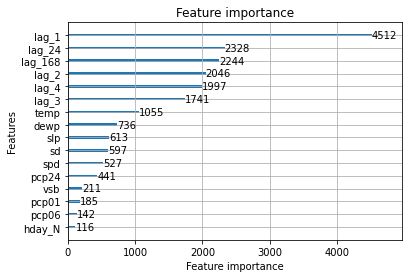

In [34]:
lgb.plot_importance(model)

In [35]:
y_test_df = pd.Series(y_test, index = X_test.index)
y_test_df.index = pd.to_datetime(y_test_df.index)

In [21]:
y_gs = pd.Series(y_gs, index = X_test.index)
y_gs.index = pd.to_datetime(y_gs.index)
y_gs

pickup_dt
2015-06-01 00:00:00    2353.961847
2015-06-01 01:00:00    1196.589889
2015-06-01 02:00:00     604.222247
2015-06-01 03:00:00     643.604897
2015-06-01 04:00:00     519.099941
                          ...     
2015-06-30 19:00:00    4807.799830
2015-06-30 20:00:00    4598.034860
2015-06-30 21:00:00    4200.915224
2015-06-30 22:00:00    4382.805328
2015-06-30 23:00:00    4141.392573
Length: 720, dtype: float64

In [36]:
pd.concat([y_test_df,y_pred_df], axis=1).plot()


Figure(id='1227', ...)

In [48]:
y_test_df

pickup_dt
2015-05-07 17:00:00    3871
2015-05-07 18:00:00    4729
2015-05-07 19:00:00    5336
2015-05-07 20:00:00    4553
2015-05-07 21:00:00    4868
                       ... 
2015-06-30 19:00:00    4585
2015-06-30 20:00:00    4210
2015-06-30 21:00:00    4313
2015-06-30 22:00:00    4452
2015-06-30 23:00:00    3828
Name: pickups, Length: 1303, dtype: int64

In [49]:
y_test_df.to_csv('../y_test_df.csv')

In [37]:
import pickle

pickle.dump(model, open('model_lgbm.pkl','wb'))

In [58]:
y_test.to_csv('../y_test_lgbm.csv')

In [59]:
X_test.to_csv('../X_test_lgbm.csv',index=False)

In [56]:
X_test

spd   vsb   temp   dewp     slp  pcp01  pcp06  pcp24  \
pickup_dt                                                                    
2015-06-01 00:00:00  2.50   3.4  69.00  66.50  1017.2  0.045   1.21    0.0   
2015-06-01 01:00:00  6.25   3.5  68.75  66.25  1018.0  0.080   0.00    0.0   
2015-06-01 02:00:00  8.00   9.1  65.00  62.00  1018.7  0.060   0.00    0.0   
2015-06-01 03:00:00  8.00   9.1  63.00  59.00  1019.9  0.010   0.00    0.0   
2015-06-01 04:00:00  9.00  10.0  59.00  56.00  1020.2  0.060   0.00    0.0   
...                   ...   ...    ...    ...     ...    ...    ...    ...   
2015-06-30 19:00:00  5.00  10.0  80.00  58.00  1012.5  0.000   0.00    0.0   
2015-06-30 20:00:00  8.00  10.0  80.00  58.00  1012.4  0.000   0.00    0.0   
2015-06-30 21:00:00  7.00  10.0  76.00  61.00  1012.4  0.000   0.00    0.0   
2015-06-30 22:00:00  5.00  10.0  76.00  64.00  1011.9  0.000   0.00    0.0   
2015-06-30 23:00:00  7.00  10.0  75.00  65.00  1011.8  0.000   0.00    0.0   

                      sd  hday_N  hday_Y   lag_1   lag_2   lag_3   lag_4  \
pickup_dt                                                                  
2015-06-01 00:00:00  0.0       1       0  2521.0  2848.0  3639.0  4100.0   
2015-06-01 01:00:00  0.0       1       0  1301.0  2521.0  2848.0  3639.0   
2015-06-01 02:00:00  0.0       1       0   704.0  1301.0  2521.0  2848.0   
2015-06-01 03:00:00  0.0       1       0   488.0   704.0  1301.0  2521.0   
2015-06-01 04:00:00  0.0       1       0   349.0   488.0   704.0  1301.0   
...                  ...     ...     ...     ...     ...     ...     ...   
2015-06-30 19:00:00  0.0       1       0  4298.0  3586.0  2929.0  2577.0   
2015-06-30 20:00:00  0.0       1       0  4585.0  4298.0  3586.0  2929.0   
2015-06-30 21:00:00  0.0       1       0  4210.0  4585.0  4298.0  3586.0   
2015-06-30 22:00:00  0.0       1       0  4313.0  4210.0  4585.0  4298.0   
2015-06-30 23:00:00  0.0       1       0  4452.0  4313.0  4210.0  4585.0   

                     lag_24  lag_168  
pickup_dt                             
2015-06-01 00:00:00  4797.0   2201.0  
2015-06-01 01:00:00  4014.0   1694.0  
2015-06-01 02:00:00  2886.0   1092.0  
2015-06-01 03:00:00  1995.0    772.0  
2015-06-01 04:00:00  1409.0    590.0  
...                     ...      ...  
2015-06-30 19:00:00  3712.0   7046.0  
2015-06-30 20:00:00  3317.0   5747.0  
2015-06-30 21:00:00  3340.0   4634.0  
2015-06-30 22:00:00  3317.0   4546.0  
2015-06-30 23:00:00  2964.0   3748.0  

[720 rows x 17 columns]

In [57]:
d = pd.read_csv('../X_test_csv.csv')
d

spd   vsb   temp   dewp     slp  pcp01  pcp06  pcp24   sd  hday_N  \
0    2.50   3.4  69.00  66.50  1017.2  0.045   1.21    0.0  0.0       1   
1    6.25   3.5  68.75  66.25  1018.0  0.080   0.00    0.0  0.0       1   
2    8.00   9.1  65.00  62.00  1018.7  0.060   0.00    0.0  0.0       1   
3    8.00   9.1  63.00  59.00  1019.9  0.010   0.00    0.0  0.0       1   
4    9.00  10.0  59.00  56.00  1020.2  0.060   0.00    0.0  0.0       1   
..    ...   ...    ...    ...     ...    ...    ...    ...  ...     ...   
715  5.00  10.0  80.00  58.00  1012.5  0.000   0.00    0.0  0.0       1   
716  8.00  10.0  80.00  58.00  1012.4  0.000   0.00    0.0  0.0       1   
717  7.00  10.0  76.00  61.00  1012.4  0.000   0.00    0.0  0.0       1   
718  5.00  10.0  76.00  64.00  1011.9  0.000   0.00    0.0  0.0       1   
719  7.00  10.0  75.00  65.00  1011.8  0.000   0.00    0.0  0.0       1   

     hday_Y   lag_1   lag_2   lag_3   lag_4  lag_24  lag_168  
0         0  2521.0  2848.0  3639.0  4100.0  4797.0   2201.0  
1         0  1301.0  2521.0  2848.0  3639.0  4014.0   1694.0  
2         0   704.0  1301.0  2521.0  2848.0  2886.0   1092.0  
3         0   488.0   704.0  1301.0  2521.0  1995.0    772.0  
4         0   349.0   488.0   704.0  1301.0  1409.0    590.0  
..      ...     ...     ...     ...     ...     ...      ...  
715       0  4298.0  3586.0  2929.0  2577.0  3712.0   7046.0  
716       0  4585.0  4298.0  3586.0  2929.0  3317.0   5747.0  
717       0  4210.0  4585.0  4298.0  3586.0  3340.0   4634.0  
718       0  4313.0  4210.0  4585.0  4298.0  3317.0   4546.0  
719       0  4452.0  4313.0  4210.0  4585.0  2964.0   3748.0  

[720 rows x 17 columns]